In [194]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from MySQLdb import connect
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

conn = connect(
    host="140.112.174.28",
    db="ijv_1066",
    user="md703",
    passwd="MD703"
)
# df = pd.read_sql("SELECT * FROM ijv_ann_2", con=conn)
# df = pd.read_sql("SELECT * FROM ijv_ann_3 WHERE muscle_mus < 10.0 AND ijv_mus < 10.0 AND skin_mus < 7 AND skin_mua < 0.01 AND muscle_mua < 0.3", con=conn)
# df = pd.read_sql("SELECT * FROM ijv_ann_4", con=conn)
# df = pd.concat(
#     [pd.read_sql("SELECT * FROM ijv_ann_5", con=conn),
#      pd.read_sql("SELECT * FROM ijv_ann_high", con=conn)
#     ])
df = pd.read_sql("SELECT * FROM ijv_ann_high", con=conn)

# ijv_ann: 
# ijv_ann_2: 參數範圍太大
# ijv_ann_3 : 2e9
# ijv_ann_4: 4e9

len(df)

17900

In [195]:
len(set(df["idx"].tolist()))

179

In [196]:
num = len(df)//3200
num

5

In [197]:
df.iloc[:, -3] = np.log(df.iloc[:, -3]) #*(-3589934592)/5e9)

In [113]:
df.iloc[0, -3]

-15.080997122355612

In [64]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(20, 64)
        self.bn_spec = nn.BatchNorm1d(64)
        self.geo_layer = nn.Linear(7, 64)
        self.bn_geo = nn.BatchNorm1d(64)

        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ELU(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = self.bn_spec(spec)
        spec = nn.ELU()(spec)
        
        geo = self.geo_layer(geo)
        geo = self.bn_geo(geo)
        geo = nn.ELU()(geo)
        
        out = self.fc(spec + geo)
       
        return out

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(20, 64)
        self.bn_spec = nn.BatchNorm1d(64)
        self.geo_layer = nn.Linear(7, 64)
        self.bn_geo = nn.BatchNorm1d(64)

        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ELU(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = self.bn_spec(spec)
        spec = nn.ELU()(spec)
        
        geo = self.geo_layer(geo)
        geo = self.bn_geo(geo)
        geo = nn.ELU()(geo)
        
        out = self.fc(spec + geo)
       
        return out

In [66]:
class SpecData(Dataset):
    def __init__(self, df, aug=False):
        self.df = df.values[:, 3:]
#         self.df = df
        self.aug = aug

    def __getitem__(self, idx):
        # 取最後三個(20mm, 24mm, 28mm的reflectance)
#         spec = self.df.iloc[idx][-3].astype(np.float)
#         spec = torch.tensor(np.expand_dims(spec, 0)).float()
        
#         geo = self.df.iloc[idx][-10:-3].astype(np.float).values
#         geo = torch.tensor(geo).float()
        
#         param = self.df.iloc[idx][2:22].astype(np.float).values
#         param = torch.tensor(param).float()
        
        spec = np.asarray([self.df[idx, -3]]).astype(np.float)
        geo = self.df[idx, -10:-3].astype(np.float)
        param = self.df[idx, 0:20].astype(np.float)
        
        if self.aug:
            geo *= (1+0.005*(2*np.random.rand()-1))
            param *= (1+0.005*(2*np.random.rand()-1))
        
        return spec, geo, param
    
    
    
    def __len__(self):
#         return len(self.df)
        return self.df.shape[0]

In [67]:
model = Model()
model.to(device)
loss_func = nn.MSELoss()
# loss_func = RMSP
# loss_func = nn.CrossEntropyLoss()

In [68]:
optimizer = optim.Adam(lr=1e-6, params=model.parameters(), betas=(0.9, 0.99))
# optimizer = optim.SGD(lr=1e-6, params=model.parameters())
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
# 只train高散射
df = df.iloc[-1500:]
df = df.sample(frac=1)

train_set = SpecData(df[:-100], False)
trainloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0)
valid_set = SpecData(df[-100:], False)
validloader = DataLoader(valid_set, batch_size=2500,
                        shuffle=True, num_workers=0)

In [161]:
df = df.sample(frac=1)
train_set = SpecData(df[:-1000], False)
trainloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0)
valid_set = SpecData(df[-1000:], False)
validloader = DataLoader(valid_set, batch_size=2500,
                        shuffle=True, num_workers=0)

In [162]:
lr_list = []
train_loss_list = []
valid_loss_list = []

In [163]:
for epoch in range(10000):
    train_loss_ = []
    valid_loss_ = []
    
    for i, (spec, geo, param) in enumerate(trainloader):
        spec, geo, param = torch.tensor(spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
        spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(param, geo)
        loss = loss_func(predict, spec)
        loss.backward()
        optimizer.step()
        train_loss_ += [float(loss.data)]
        if i % 100 == 0:
            train_loss_list += [np.mean(train_loss_)]
            train_loss_ = []
            lr_list += [optimizer.param_groups[0]["lr"]]
    
            model.eval()
            for j, (_spec, geo, param) in enumerate(validloader):
                _spec, geo, param = torch.tensor(_spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
                
                _spec, geo, param = _spec.to(device), geo.to(device), param.to(device)
                _predict = model(param, geo)
                _loss = loss_func(_predict, _spec)

                valid_loss_ += [float(_loss.data)]
            model.train()
            valid_loss_list += [np.mean(valid_loss_)]
            valid_loss_ = []
    
    
    if epoch % 1 == 0:
            print("epoch: {} | train: {} | valid: {}".format(
                epoch, train_loss_list[-1], valid_loss_list[-1]),
                 )
            print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))
#             print("{}\n{}".format(spec[0:5]*std+mean, predict[0:5]*std+mean))

#         print(predict)
#         print(param)
#     scheduler.step(loss)

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 | train: 0.07211734689772129 | valid: 0.10435312241315842
tensor([[2.9633e-09],
        [4.2666e-09],
        [1.8729e-09],
        [9.9472e-10],
        [3.7728e-07]], device='cuda:0')
tensor([[7.9344e-09],
        [4.8704e-09],
        [1.5930e-09],
        [1.7192e-09],
        [2.1971e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1 | train: 0.05528821967542172 | valid: 0.09544062614440918
tensor([[4.4603e-09],
        [6.2824e-07],
        [1.6791e-07],
        [3.5191e-10],
        [7.3805e-08]], device='cuda:0')
tensor([[2.0803e-09],
        [5.3053e-07],
        [1.3848e-07],
        [1.8910e-10],
        [4.4497e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2 | train: 0.05269597159698605 | valid: 0.09289857745170593
tensor([[7.9125e-09],
        [7.9029e-09],
        [1.5850e-07],
        [5.3723e-11],
        [3.6935e-10]], device='cuda:0')
tensor([[9.8566e-09],
        [1.1423e-08],
        [1.6747e-07],
        [7.4252e-11],
        [3.1084e-10]], de

epoch: 24 | train: 0.03917985373176634 | valid: 0.07838712632656097
tensor([[1.7810e-09],
        [5.0225e-07],
        [6.3152e-11],
        [1.2234e-08],
        [3.1770e-09]], device='cuda:0')
tensor([[2.0145e-09],
        [4.7601e-07],
        [1.1010e-10],
        [1.3753e-08],
        [1.6163e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 25 | train: 0.038566133128479126 | valid: 0.08455751836299896
tensor([[2.0317e-09],
        [6.6038e-08],
        [6.2084e-11],
        [2.6197e-07],
        [6.8035e-11]], device='cuda:0')
tensor([[1.5241e-09],
        [3.9096e-08],
        [6.2938e-11],
        [2.5493e-07],
        [7.5485e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 26 | train: 0.037858633976429704 | valid: 0.0910111740231514
tensor([[4.7784e-08],
        [1.1891e-10],
        [6.6685e-09],
        [6.5607e-08],
        [1.4658e-07]], device='cuda:0')
tensor([[4.0705e-08],
        [8.1812e-11],
        [5.1973e-09],
        [9.0812e-08],
        [1.2006e-07]]

epoch: 48 | train: 0.032187569374218586 | valid: 0.07244451344013214
tensor([[8.4533e-11],
        [3.2784e-07],
        [7.6292e-08],
        [4.6961e-10],
        [1.0979e-07]], device='cuda:0')
tensor([[1.1521e-10],
        [4.5907e-07],
        [1.3798e-07],
        [5.9888e-10],
        [1.2095e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 49 | train: 0.0335395435988903 | valid: 0.070472352206707
tensor([[7.8182e-10],
        [4.0169e-09],
        [3.4108e-08],
        [1.5120e-08],
        [9.4123e-08]], device='cuda:0')
tensor([[4.4116e-10],
        [3.8107e-09],
        [3.3171e-08],
        [1.3549e-08],
        [8.7489e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 50 | train: 0.043356932820752266 | valid: 0.06264561414718628
tensor([[6.4123e-08],
        [3.0602e-08],
        [7.3688e-10],
        [7.2946e-09],
        [2.5440e-11]], device='cuda:0')
tensor([[7.8367e-08],
        [2.9663e-08],
        [9.5140e-10],
        [6.8000e-09],
        [3.1555e-11]], 

epoch: 72 | train: 0.0329513962380588 | valid: 0.07521390169858932
tensor([[2.9915e-07],
        [1.3096e-10],
        [5.6809e-07],
        [7.4072e-08],
        [4.8282e-07]], device='cuda:0')
tensor([[1.4956e-07],
        [8.6742e-11],
        [4.3030e-07],
        [4.4295e-08],
        [2.2099e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 73 | train: 0.033594735255464914 | valid: 0.06615033000707626
tensor([[1.8259e-07],
        [9.8788e-09],
        [2.5267e-07],
        [2.3704e-09],
        [7.1202e-08]], device='cuda:0')
tensor([[9.5531e-08],
        [4.0135e-09],
        [2.4368e-07],
        [7.1380e-10],
        [5.9138e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 74 | train: 0.034216998014599084 | valid: 0.052570488303899765
tensor([[1.4578e-10],
        [2.7706e-10],
        [1.7715e-09],
        [2.7631e-09],
        [2.6777e-08]], device='cuda:0')
tensor([[1.9498e-10],
        [2.9576e-10],
        [2.1683e-09],
        [4.3568e-09],
        [5.2834e-08]

epoch: 96 | train: 0.03447044545784592 | valid: 0.06345007568597794
tensor([[1.7282e-09],
        [6.1006e-08],
        [2.1598e-08],
        [8.2257e-09],
        [2.5122e-08]], device='cuda:0')
tensor([[2.0855e-09],
        [5.9059e-08],
        [1.5094e-08],
        [1.4117e-08],
        [1.1084e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 97 | train: 0.027995232213288545 | valid: 0.06264708936214447
tensor([[1.1110e-08],
        [2.4626e-10],
        [3.6743e-08],
        [1.1229e-07],
        [3.8373e-07]], device='cuda:0')
tensor([[8.3009e-09],
        [1.8049e-10],
        [3.2963e-08],
        [1.6476e-07],
        [3.6065e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 98 | train: 0.0334664841555059 | valid: 0.06983205676078796
tensor([[5.2482e-11],
        [4.1550e-09],
        [4.4756e-08],
        [1.6539e-09],
        [1.2928e-08]], device='cuda:0')
tensor([[4.0953e-11],
        [3.8850e-09],
        [2.8182e-08],
        [1.6516e-09],
        [1.2748e-08]],

epoch: 120 | train: 0.03451689520850778 | valid: 0.08279038220643997
tensor([[1.0214e-09],
        [5.6809e-07],
        [6.1237e-11],
        [1.3055e-10],
        [2.4316e-10]], device='cuda:0')
tensor([[8.7359e-10],
        [5.1370e-07],
        [9.7081e-11],
        [1.9192e-10],
        [2.5059e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 121 | train: 0.03842448798939586 | valid: 0.07269865274429321
tensor([[1.6194e-09],
        [6.0089e-09],
        [1.0968e-10],
        [9.7576e-11],
        [1.4656e-08]], device='cuda:0')
tensor([[3.2602e-09],
        [6.4211e-09],
        [3.9814e-10],
        [5.3848e-11],
        [7.5621e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 122 | train: 0.03362561410292983 | valid: 0.058380912989377975
tensor([[2.4950e-10],
        [8.0940e-08],
        [1.1049e-09],
        [9.7504e-08],
        [1.0723e-08]], device='cuda:0')
tensor([[1.7369e-10],
        [9.9409e-08],
        [8.3301e-10],
        [7.2567e-08],
        [9.2390e-0

epoch: 144 | train: 0.030543683413416147 | valid: 0.053967345505952835
tensor([[2.9231e-08],
        [5.0328e-09],
        [1.0732e-08],
        [4.0200e-08],
        [9.1968e-11]], device='cuda:0')
tensor([[2.8595e-08],
        [2.6383e-09],
        [8.6968e-09],
        [3.2178e-08],
        [5.5412e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 145 | train: 0.030763018112629652 | valid: 0.08391815423965454
tensor([[5.6418e-09],
        [6.0996e-09],
        [6.4503e-10],
        [3.0287e-07],
        [3.6778e-08]], device='cuda:0')
tensor([[2.3224e-08],
        [6.0942e-09],
        [1.2541e-09],
        [1.7485e-07],
        [4.5290e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 146 | train: 0.032415053276345134 | valid: 0.06788413226604462
tensor([[2.7071e-08],
        [1.9503e-07],
        [3.3633e-07],
        [2.1335e-09],
        [6.4549e-09]], device='cuda:0')
tensor([[4.4037e-08],
        [2.4436e-07],
        [4.1455e-07],
        [2.2896e-09],
        [6.6867

epoch: 168 | train: 0.03359172476455569 | valid: 0.06642728298902512
tensor([[4.3731e-08],
        [8.3274e-10],
        [1.7339e-07],
        [2.5831e-10],
        [3.3377e-08]], device='cuda:0')
tensor([[4.3657e-08],
        [6.9753e-10],
        [1.2391e-07],
        [1.6311e-10],
        [3.3289e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 169 | train: 0.03286967142019421 | valid: 0.0672113224864006
tensor([[2.5501e-12],
        [1.7775e-09],
        [6.3382e-07],
        [4.0213e-09],
        [9.0121e-08]], device='cuda:0')
tensor([[1.9809e-12],
        [2.3479e-09],
        [5.8341e-07],
        [2.7978e-09],
        [1.0302e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 170 | train: 0.03356459292583167 | valid: 0.0583745501935482
tensor([[2.1034e-09],
        [1.7514e-07],
        [1.0881e-07],
        [5.2796e-08],
        [1.8390e-08]], device='cuda:0')
tensor([[6.3500e-10],
        [1.1130e-07],
        [8.7055e-08],
        [5.2646e-08],
        [6.7867e-09]]

epoch: 192 | train: 0.03304105708375573 | valid: 0.06779290735721588
tensor([[4.5336e-09],
        [7.8871e-09],
        [1.6791e-08],
        [4.6942e-08],
        [1.1148e-08]], device='cuda:0')
tensor([[3.6194e-09],
        [8.5698e-09],
        [2.5214e-08],
        [4.1801e-08],
        [1.5254e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 193 | train: 0.03457727028056979 | valid: 0.07368199527263641
tensor([[2.4686e-08],
        [1.4720e-10],
        [8.5104e-09],
        [6.9763e-08],
        [1.3435e-07]], device='cuda:0')
tensor([[1.8702e-08],
        [1.5542e-10],
        [1.1109e-08],
        [7.4375e-08],
        [1.2142e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 194 | train: 0.03365313033573329 | valid: 0.08831825852394104
tensor([[4.8355e-10],
        [5.2564e-10],
        [6.0088e-08],
        [5.4678e-08],
        [7.0673e-10]], device='cuda:0')
tensor([[3.4948e-10],
        [4.9082e-10],
        [5.1551e-08],
        [6.6245e-08],
        [2.9019e-10

epoch: 216 | train: 0.03450669159181416 | valid: 0.0681820884346962
tensor([[2.2070e-07],
        [5.5480e-08],
        [2.1811e-07],
        [2.2436e-08],
        [7.7676e-09]], device='cuda:0')
tensor([[1.8459e-07],
        [4.7636e-08],
        [2.3978e-07],
        [6.1319e-09],
        [4.5676e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 217 | train: 0.03204027811996639 | valid: 0.058853983879089355
tensor([[8.8687e-08],
        [7.6058e-08],
        [2.5935e-08],
        [3.1153e-07],
        [3.8565e-10]], device='cuda:0')
tensor([[9.1036e-08],
        [6.0257e-08],
        [2.8077e-08],
        [3.2865e-07],
        [3.7123e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 218 | train: 0.03310964232776314 | valid: 0.07301762700080872
tensor([[4.6203e-12],
        [2.2638e-10],
        [8.9011e-10],
        [3.2584e-10],
        [3.1147e-08]], device='cuda:0')
tensor([[6.3763e-12],
        [2.5863e-10],
        [1.3816e-09],
        [2.7018e-10],
        [3.3546e-08

epoch: 240 | train: 0.029904857072979213 | valid: 0.06857931613922119
tensor([[1.6873e-09],
        [4.7338e-08],
        [1.5140e-07],
        [4.3318e-10],
        [3.7259e-09]], device='cuda:0')
tensor([[2.3978e-09],
        [5.9069e-08],
        [1.2900e-07],
        [3.1590e-10],
        [1.4923e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 241 | train: 0.03281515730544925 | valid: 0.06964815407991409
tensor([[5.6930e-10],
        [2.1771e-07],
        [7.4454e-10],
        [5.4721e-10],
        [9.6270e-10]], device='cuda:0')
tensor([[2.0275e-09],
        [9.1481e-08],
        [8.4810e-10],
        [7.6537e-10],
        [1.5323e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 242 | train: 0.03317094656638801 | valid: 0.08474595844745636
tensor([[1.6554e-08],
        [1.4851e-10],
        [9.4149e-09],
        [7.5874e-11],
        [2.8556e-10]], device='cuda:0')
tensor([[1.4053e-08],
        [9.9965e-11],
        [9.7124e-09],
        [4.4861e-11],
        [2.5531e-1

epoch: 264 | train: 0.03230872797779739 | valid: 0.06965365260839462
tensor([[2.2564e-09],
        [5.0784e-09],
        [3.0049e-08],
        [2.7887e-10],
        [7.8857e-10]], device='cuda:0')
tensor([[8.4186e-09],
        [1.1743e-08],
        [1.0370e-07],
        [5.4797e-10],
        [3.4223e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 265 | train: 0.03169571460224688 | valid: 0.07064774632453918
tensor([[6.2677e-10],
        [1.1560e-08],
        [1.0082e-07],
        [7.1613e-07],
        [1.8591e-08]], device='cuda:0')
tensor([[7.8272e-10],
        [1.2417e-08],
        [1.2926e-07],
        [9.1261e-07],
        [2.9377e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 266 | train: 0.03188861056230962 | valid: 0.08542125672101974
tensor([[1.6148e-10],
        [2.3472e-07],
        [2.3636e-07],
        [9.2300e-08],
        [3.7416e-09]], device='cuda:0')
tensor([[4.3019e-10],
        [1.5549e-07],
        [2.0297e-07],
        [9.7600e-08],
        [7.2647e-09

epoch: 288 | train: 0.037823328971862795 | valid: 0.059630464762449265
tensor([[3.6824e-08],
        [4.8397e-09],
        [9.5429e-11],
        [1.1224e-08],
        [1.4538e-07]], device='cuda:0')
tensor([[2.4515e-08],
        [5.2672e-09],
        [9.6031e-11],
        [5.8536e-09],
        [1.6102e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 289 | train: 0.03235197590664029 | valid: 0.05619346350431442
tensor([[1.4684e-07],
        [1.5785e-07],
        [1.0472e-08],
        [1.3588e-07],
        [6.6064e-12]], device='cuda:0')
tensor([[2.3904e-07],
        [1.1022e-07],
        [1.2893e-08],
        [2.0781e-07],
        [1.3811e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 290 | train: 0.03041884989477694 | valid: 0.07622084766626358
tensor([[1.0902e-09],
        [2.1269e-10],
        [1.0365e-10],
        [3.2534e-08],
        [1.5371e-08]], device='cuda:0')
tensor([[2.6919e-09],
        [2.8288e-10],
        [2.4517e-10],
        [3.9973e-08],
        [3.6160e-

epoch: 312 | train: 0.031086377645842732 | valid: 0.07338667660951614
tensor([[7.4548e-09],
        [8.3285e-10],
        [2.5068e-09],
        [7.3231e-09],
        [5.2695e-09]], device='cuda:0')
tensor([[7.4952e-09],
        [3.7708e-10],
        [2.1394e-09],
        [6.3267e-09],
        [2.9333e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 313 | train: 0.033664511796087024 | valid: 0.059117965400218964
tensor([[1.8561e-10],
        [1.1652e-09],
        [4.9868e-09],
        [2.9538e-09],
        [5.6011e-08]], device='cuda:0')
tensor([[4.1570e-10],
        [1.6906e-09],
        [5.8300e-09],
        [4.1009e-09],
        [6.7411e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 314 | train: 0.028648179434239866 | valid: 0.07966818660497665
tensor([[1.4424e-07],
        [1.3164e-08],
        [6.1842e-10],
        [2.1183e-09],
        [5.3475e-09]], device='cuda:0')
tensor([[1.8037e-07],
        [1.3739e-08],
        [9.4429e-10],
        [2.2258e-09],
        [5.5232

epoch: 336 | train: 0.028334119161590933 | valid: 0.07844535261392593
tensor([[8.8471e-08],
        [7.1267e-08],
        [7.0763e-08],
        [5.5987e-09],
        [1.2759e-07]], device='cuda:0')
tensor([[8.8362e-08],
        [8.1198e-08],
        [7.8448e-08],
        [4.8021e-09],
        [3.8741e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 337 | train: 0.03181914991699159 | valid: 0.07576308399438858
tensor([[6.8392e-09],
        [1.5461e-07],
        [6.6008e-08],
        [2.2503e-09],
        [2.6839e-09]], device='cuda:0')
tensor([[7.7124e-09],
        [1.4091e-07],
        [7.2219e-08],
        [2.3793e-09],
        [3.9639e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 338 | train: 0.02663362172432244 | valid: 0.05952102690935135
tensor([[8.0171e-09],
        [5.2539e-09],
        [3.1335e-11],
        [9.2125e-08],
        [9.4774e-11]], device='cuda:0')
tensor([[1.2983e-08],
        [4.4718e-09],
        [3.0713e-11],
        [1.2931e-07],
        [1.0930e-1

epoch: 360 | train: 0.031952835768461224 | valid: 0.07714012265205383
tensor([[1.4374e-08],
        [9.8823e-08],
        [1.9897e-08],
        [1.1626e-09],
        [8.9644e-08]], device='cuda:0')
tensor([[8.0833e-09],
        [9.7586e-08],
        [1.2880e-08],
        [6.9976e-10],
        [1.0019e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 361 | train: 0.030352233294397592 | valid: 0.07540613412857056
tensor([[1.2139e-09],
        [1.4295e-08],
        [7.8828e-09],
        [1.1375e-10],
        [3.0798e-07]], device='cuda:0')
tensor([[2.0505e-09],
        [1.3222e-08],
        [5.5866e-09],
        [9.8705e-11],
        [2.4329e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 362 | train: 0.03237547714728862 | valid: 0.0649077445268631
tensor([[2.3416e-10],
        [3.0286e-10],
        [7.8219e-09],
        [1.8552e-09],
        [2.9159e-07]], device='cuda:0')
tensor([[4.9937e-10],
        [1.8160e-09],
        [9.9303e-09],
        [2.4906e-09],
        [3.0689e-0

epoch: 384 | train: 0.032735856510698796 | valid: 0.0542389415204525
tensor([[9.4282e-08],
        [1.7997e-07],
        [5.6125e-08],
        [6.7220e-08],
        [4.2872e-10]], device='cuda:0')
tensor([[7.6020e-08],
        [1.9651e-07],
        [4.3278e-08],
        [6.7635e-08],
        [5.9892e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 385 | train: 0.03011379803530872 | valid: 0.07846931368112564
tensor([[1.8845e-07],
        [4.1806e-09],
        [1.5941e-07],
        [5.6087e-09],
        [8.2170e-10]], device='cuda:0')
tensor([[1.3344e-07],
        [2.1036e-09],
        [1.8620e-07],
        [8.5514e-09],
        [6.2983e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 386 | train: 0.03057619484141469 | valid: 0.07514316588640213
tensor([[1.0370e-07],
        [1.4390e-07],
        [4.9882e-09],
        [4.2709e-08],
        [8.8377e-09]], device='cuda:0')
tensor([[8.1331e-08],
        [1.3069e-07],
        [3.6876e-09],
        [4.0670e-08],
        [6.0800e-09

epoch: 408 | train: 0.029243530509993433 | valid: 0.0707855150103569
tensor([[1.8924e-10],
        [2.8358e-08],
        [2.4583e-07],
        [6.0384e-11],
        [4.9034e-09]], device='cuda:0')
tensor([[1.5103e-10],
        [6.6228e-08],
        [2.7839e-07],
        [7.4060e-11],
        [3.3682e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 409 | train: 0.029841251294128596 | valid: 0.06294485181570053
tensor([[4.6124e-07],
        [1.5716e-07],
        [6.9382e-11],
        [9.8390e-08],
        [3.5859e-09]], device='cuda:0')
tensor([[3.5834e-07],
        [1.0619e-07],
        [6.1810e-11],
        [7.6056e-08],
        [3.0081e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 410 | train: 0.027558284932747482 | valid: 0.071687251329422
tensor([[6.8606e-08],
        [4.9445e-11],
        [4.3844e-08],
        [1.1575e-08],
        [2.8391e-08]], device='cuda:0')
tensor([[5.8293e-08],
        [8.1012e-11],
        [3.6474e-08],
        [1.3483e-08],
        [2.5710e-08

epoch: 432 | train: 0.03206208707299083 | valid: 0.07038095593452454
tensor([[2.2202e-08],
        [2.5812e-07],
        [7.4233e-08],
        [1.1160e-09],
        [1.9100e-07]], device='cuda:0')
tensor([[2.1606e-08],
        [2.0307e-07],
        [8.4379e-08],
        [6.9401e-10],
        [1.0303e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 433 | train: 0.029643490696325898 | valid: 0.08102595806121826
tensor([[3.4795e-10],
        [8.7681e-09],
        [1.9484e-10],
        [4.5254e-09],
        [7.4375e-08]], device='cuda:0')
tensor([[4.9536e-10],
        [1.3039e-08],
        [3.0814e-10],
        [7.0859e-09],
        [1.0579e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 434 | train: 0.03149435160681605 | valid: 0.07907014340162277
tensor([[1.3797e-08],
        [6.8425e-08],
        [9.4534e-08],
        [3.2380e-09],
        [4.8854e-08]], device='cuda:0')
tensor([[2.3000e-08],
        [8.6383e-08],
        [7.1401e-08],
        [3.8441e-09],
        [4.5860e-0

epoch: 456 | train: 0.032741581024602055 | valid: 0.05313192680478096
tensor([[6.7686e-08],
        [5.4295e-07],
        [8.6565e-08],
        [1.2119e-07],
        [1.0861e-07]], device='cuda:0')
tensor([[1.0882e-07],
        [6.7154e-07],
        [8.7708e-08],
        [1.4426e-07],
        [7.0354e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 457 | train: 0.03400822089985013 | valid: 0.06581519544124603
tensor([[1.3856e-09],
        [8.5294e-08],
        [3.5425e-10],
        [8.2818e-10],
        [9.6721e-09]], device='cuda:0')
tensor([[1.5175e-09],
        [6.3043e-08],
        [2.0517e-10],
        [5.4418e-10],
        [1.4859e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 458 | train: 0.028786275084130467 | valid: 0.05586013197898865
tensor([[3.8930e-09],
        [1.6278e-08],
        [7.7011e-10],
        [1.5526e-08],
        [6.7197e-10]], device='cuda:0')
tensor([[5.2162e-09],
        [2.3453e-08],
        [8.9926e-10],
        [1.0187e-08],
        [6.7507e-

epoch: 480 | train: 0.025475895516574382 | valid: 0.0717354267835617
tensor([[1.9542e-07],
        [1.7151e-09],
        [1.1839e-08],
        [1.0793e-08],
        [7.5383e-08]], device='cuda:0')
tensor([[2.7992e-07],
        [1.6313e-09],
        [1.6558e-08],
        [1.0358e-08],
        [6.6857e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 481 | train: 0.02697971513029188 | valid: 0.06257046014070511
tensor([[1.4709e-09],
        [6.7563e-08],
        [5.5205e-07],
        [1.2653e-08],
        [5.3396e-11]], device='cuda:0')
tensor([[1.5919e-09],
        [4.8662e-08],
        [5.0517e-07],
        [1.4962e-08],
        [4.6178e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 482 | train: 0.026092519965022803 | valid: 0.07071816921234131
tensor([[7.5011e-08],
        [8.7027e-08],
        [3.4130e-08],
        [2.9676e-08],
        [5.6465e-08]], device='cuda:0')
tensor([[8.7619e-08],
        [1.3054e-07],
        [2.6102e-08],
        [4.0668e-08],
        [2.6965e-0

epoch: 504 | train: 0.029035540726035834 | valid: 0.07357668876647949
tensor([[6.8545e-08],
        [1.7348e-10],
        [4.7342e-09],
        [2.5145e-07],
        [1.2828e-07]], device='cuda:0')
tensor([[7.2324e-08],
        [2.2501e-10],
        [5.4304e-09],
        [1.6838e-07],
        [1.1993e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 505 | train: 0.03236869098618626 | valid: 0.057171113789081573
tensor([[4.4095e-11],
        [8.6557e-08],
        [8.5568e-08],
        [8.0143e-08],
        [2.0544e-09]], device='cuda:0')
tensor([[8.9650e-11],
        [8.6135e-08],
        [1.0683e-07],
        [9.8654e-08],
        [6.4897e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 506 | train: 0.033234803089872006 | valid: 0.056005652993917465
tensor([[3.2728e-07],
        [1.3736e-10],
        [1.3881e-08],
        [6.8250e-08],
        [4.1574e-08]], device='cuda:0')
tensor([[2.1112e-07],
        [2.0005e-10],
        [1.2799e-08],
        [6.8554e-08],
        [4.1627

epoch: 528 | train: 0.02852706952020526 | valid: 0.05486331880092621
tensor([[5.3089e-09],
        [1.0104e-08],
        [1.6776e-09],
        [4.6133e-08],
        [5.5619e-08]], device='cuda:0')
tensor([[6.5621e-09],
        [1.5149e-08],
        [3.2339e-09],
        [6.7838e-08],
        [2.1494e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 529 | train: 0.028569907918572425 | valid: 0.06397273391485214
tensor([[1.7302e-10],
        [1.6050e-09],
        [4.4995e-09],
        [1.0046e-07],
        [5.4028e-09]], device='cuda:0')
tensor([[1.4015e-10],
        [1.0739e-09],
        [4.2595e-09],
        [9.1530e-08],
        [7.1456e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 530 | train: 0.027735319291241466 | valid: 0.06497849524021149
tensor([[5.7425e-08],
        [3.5145e-09],
        [2.5584e-07],
        [6.9107e-09],
        [1.7734e-07]], device='cuda:0')
tensor([[3.1937e-08],
        [2.4351e-09],
        [2.3016e-07],
        [7.0185e-09],
        [1.5051e-

epoch: 552 | train: 0.026246124422177674 | valid: 0.06922105699777603
tensor([[1.8028e-09],
        [1.8009e-07],
        [5.3783e-08],
        [1.7181e-10],
        [7.7223e-08]], device='cuda:0')
tensor([[8.6059e-10],
        [1.5188e-07],
        [1.6400e-08],
        [1.0505e-10],
        [1.3004e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 553 | train: 0.030695401011034847 | valid: 0.07818649709224701
tensor([[1.2922e-10],
        [1.3624e-08],
        [9.7796e-09],
        [6.2102e-10],
        [4.2288e-10]], device='cuda:0')
tensor([[1.3299e-10],
        [3.3380e-08],
        [1.4012e-08],
        [5.7975e-10],
        [4.6249e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 554 | train: 0.029932487905025482 | valid: 0.08410484343767166
tensor([[5.3019e-08],
        [1.3475e-07],
        [5.8463e-08],
        [7.5732e-08],
        [1.9033e-07]], device='cuda:0')
tensor([[3.2583e-08],
        [1.2950e-07],
        [5.2866e-08],
        [5.2162e-08],
        [1.4553e

epoch: 576 | train: 0.02786339812912047 | valid: 0.07016686350107193
tensor([[2.5657e-10],
        [1.4619e-08],
        [1.7191e-08],
        [9.8248e-12],
        [3.3459e-08]], device='cuda:0')
tensor([[3.3722e-10],
        [1.6746e-08],
        [1.4929e-08],
        [1.5076e-11],
        [4.2327e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 577 | train: 0.0305883035203442 | valid: 0.06297311931848526
tensor([[1.9655e-07],
        [1.7336e-10],
        [3.0707e-10],
        [1.3741e-08],
        [3.3563e-08]], device='cuda:0')
tensor([[3.2264e-07],
        [3.4124e-10],
        [5.8677e-10],
        [2.1424e-08],
        [3.4632e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 578 | train: 0.027020635828375817 | valid: 0.06089438498020172
tensor([[4.7141e-08],
        [1.8144e-08],
        [3.6063e-07],
        [2.1187e-09],
        [1.4236e-08]], device='cuda:0')
tensor([[3.9285e-08],
        [1.2916e-08],
        [2.5402e-07],
        [1.6970e-09],
        [7.7564e-09

epoch: 600 | train: 0.026776554426178337 | valid: 0.06490625441074371
tensor([[3.3679e-10],
        [5.0810e-10],
        [3.2928e-08],
        [3.5933e-08],
        [1.1021e-10]], device='cuda:0')
tensor([[2.8644e-10],
        [2.8024e-10],
        [5.6353e-08],
        [4.3234e-08],
        [1.2307e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 601 | train: 0.03888938364107162 | valid: 0.0660906732082367
tensor([[5.5348e-09],
        [8.4799e-08],
        [6.5713e-08],
        [1.9996e-07],
        [3.2266e-10]], device='cuda:0')
tensor([[6.7326e-09],
        [1.0155e-07],
        [8.6021e-08],
        [1.7436e-07],
        [4.2149e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 602 | train: 0.03352629518602043 | valid: 0.07488851994276047
tensor([[7.0574e-08],
        [1.0052e-09],
        [4.7647e-08],
        [1.1211e-07],
        [5.9664e-09]], device='cuda:0')
tensor([[7.9410e-08],
        [1.0170e-09],
        [4.2224e-08],
        [9.7912e-08],
        [5.7135e-09

epoch: 624 | train: 0.031598626002669335 | valid: 0.076993428170681
tensor([[9.7641e-10],
        [2.2843e-07],
        [1.7458e-10],
        [1.3343e-09],
        [2.6538e-07]], device='cuda:0')
tensor([[7.7432e-10],
        [1.7993e-07],
        [1.6810e-10],
        [1.2827e-09],
        [2.3221e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 625 | train: 0.02975086380727589 | valid: 0.06540660560131073
tensor([[1.1865e-09],
        [6.2060e-10],
        [1.5875e-10],
        [1.9742e-08],
        [1.5043e-08]], device='cuda:0')
tensor([[9.0791e-10],
        [6.4015e-10],
        [1.2958e-10],
        [1.7518e-08],
        [1.2004e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 626 | train: 0.029050019765272737 | valid: 0.0752352625131607
tensor([[1.3664e-11],
        [1.8237e-10],
        [1.1881e-10],
        [2.6249e-07],
        [3.4425e-11]], device='cuda:0')
tensor([[3.3371e-11],
        [2.1578e-10],
        [2.2188e-10],
        [4.1083e-07],
        [4.2165e-11]

epoch: 648 | train: 0.03171596978791058 | valid: 0.0764741525053978
tensor([[1.9996e-07],
        [9.3216e-10],
        [2.7265e-09],
        [4.3815e-07],
        [1.8665e-07]], device='cuda:0')
tensor([[1.3249e-07],
        [3.2334e-10],
        [1.2549e-09],
        [3.6871e-07],
        [1.3602e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 649 | train: 0.02775697681121528 | valid: 0.05684630572795868
tensor([[1.9753e-09],
        [1.8926e-07],
        [3.9501e-08],
        [3.7205e-10],
        [7.6955e-08]], device='cuda:0')
tensor([[1.0569e-09],
        [1.2813e-07],
        [4.5822e-08],
        [2.4709e-10],
        [6.7719e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 650 | train: 0.0274088136292994 | valid: 0.0631575733423233
tensor([[5.3336e-09],
        [9.6246e-08],
        [2.7736e-10],
        [6.4791e-08],
        [9.1714e-11]], device='cuda:0')
tensor([[9.4113e-09],
        [1.1283e-07],
        [5.0476e-10],
        [6.0716e-08],
        [8.3428e-11]],

epoch: 672 | train: 0.0346909682219848 | valid: 0.0678684264421463
tensor([[1.2018e-07],
        [3.3602e-09],
        [1.0110e-10],
        [8.8527e-08],
        [7.4800e-09]], device='cuda:0')
tensor([[1.0987e-07],
        [2.2311e-09],
        [3.2681e-11],
        [8.1953e-08],
        [2.6196e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 673 | train: 0.028963231649249792 | valid: 0.06773925572633743
tensor([[3.5319e-11],
        [6.3520e-09],
        [4.6464e-08],
        [9.4773e-08],
        [1.3450e-07]], device='cuda:0')
tensor([[2.4292e-11],
        [3.7943e-09],
        [4.2072e-08],
        [9.4662e-08],
        [1.2711e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 674 | train: 0.031830033385194835 | valid: 0.07892219722270966
tensor([[3.7442e-09],
        [1.7934e-10],
        [3.5676e-10],
        [2.5286e-11],
        [5.0110e-07]], device='cuda:0')
tensor([[9.1477e-09],
        [1.2917e-10],
        [5.5023e-10],
        [2.3454e-11],
        [5.6991e-07

epoch: 696 | train: 0.03610658683814108 | valid: 0.054647136479616165
tensor([[4.3761e-09],
        [1.2481e-08],
        [9.3469e-09],
        [4.3921e-08],
        [2.3877e-08]], device='cuda:0')
tensor([[3.4766e-09],
        [1.2300e-08],
        [2.3632e-08],
        [6.8159e-08],
        [1.9339e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 697 | train: 0.03775759276002646 | valid: 0.0683312714099884
tensor([[4.5171e-07],
        [1.4331e-08],
        [2.9408e-08],
        [4.7286e-10],
        [1.0431e-07]], device='cuda:0')
tensor([[4.4426e-07],
        [1.1925e-08],
        [2.0842e-08],
        [3.7845e-10],
        [7.7066e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 698 | train: 0.026914787096902728 | valid: 0.07338826358318329
tensor([[3.2356e-10],
        [1.2738e-07],
        [7.5142e-08],
        [3.3038e-11],
        [2.0270e-08]], device='cuda:0')
tensor([[3.0555e-10],
        [7.6250e-08],
        [3.4645e-08],
        [2.8128e-11],
        [1.4418e-0

epoch: 720 | train: 0.028671935894526542 | valid: 0.07461192458868027
tensor([[4.5157e-08],
        [4.8299e-07],
        [3.8459e-08],
        [1.3550e-09],
        [5.0755e-09]], device='cuda:0')
tensor([[2.3141e-08],
        [1.3324e-07],
        [2.2610e-08],
        [4.9467e-10],
        [1.9622e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 721 | train: 0.029334870353341102 | valid: 0.0747203603386879
tensor([[6.1566e-08],
        [3.9734e-08],
        [1.8702e-08],
        [7.6090e-09],
        [3.5696e-08]], device='cuda:0')
tensor([[4.5006e-08],
        [2.0646e-08],
        [1.8781e-08],
        [1.4486e-08],
        [2.4225e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 722 | train: 0.030433123242110015 | valid: 0.06739860028028488
tensor([[5.0080e-09],
        [8.2433e-09],
        [2.2601e-09],
        [1.3899e-10],
        [4.9961e-08]], device='cuda:0')
tensor([[8.1567e-09],
        [8.5214e-09],
        [2.8505e-09],
        [1.8627e-10],
        [5.3930e-

epoch: 744 | train: 0.026567100598476827 | valid: 0.06843210756778717
tensor([[3.7878e-09],
        [1.6175e-08],
        [6.1015e-09],
        [4.7099e-09],
        [9.3906e-10]], device='cuda:0')
tensor([[3.2085e-09],
        [1.7643e-08],
        [4.3117e-09],
        [5.6130e-09],
        [7.9634e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 745 | train: 0.02880053642205894 | valid: 0.06497582793235779
tensor([[1.6167e-07],
        [1.0118e-09],
        [1.3114e-07],
        [2.9340e-08],
        [2.1765e-07]], device='cuda:0')
tensor([[1.6657e-07],
        [1.3238e-09],
        [1.2808e-07],
        [2.8489e-08],
        [2.8562e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 746 | train: 0.0253680284274742 | valid: 0.0666314885020256
tensor([[1.0268e-09],
        [1.6752e-07],
        [8.0017e-10],
        [1.7952e-10],
        [1.3248e-07]], device='cuda:0')
tensor([[1.4909e-09],
        [1.3750e-07],
        [8.2949e-10],
        [1.5603e-10],
        [1.5901e-07]

epoch: 768 | train: 0.02763683531433344 | valid: 0.06840018182992935
tensor([[1.7001e-08],
        [1.2361e-08],
        [1.4950e-07],
        [8.9018e-09],
        [6.9469e-10]], device='cuda:0')
tensor([[2.5560e-08],
        [1.9475e-08],
        [1.3359e-07],
        [7.9183e-09],
        [6.8038e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 769 | train: 0.029999598530121147 | valid: 0.06304741650819778
tensor([[1.2017e-07],
        [1.2326e-08],
        [1.3624e-08],
        [5.4657e-09],
        [3.0361e-08]], device='cuda:0')
tensor([[1.1103e-07],
        [1.2560e-08],
        [1.1350e-08],
        [6.3259e-09],
        [2.3582e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 770 | train: 0.030910389954224227 | valid: 0.07469981908798218
tensor([[5.4188e-11],
        [2.1335e-09],
        [1.0048e-08],
        [2.8868e-09],
        [4.5123e-09]], device='cuda:0')
tensor([[1.3496e-10],
        [7.9923e-10],
        [5.3127e-09],
        [1.9921e-09],
        [5.1670e-

epoch: 792 | train: 0.02683929555118084 | valid: 0.06458629667758942
tensor([[4.7443e-11],
        [4.8485e-10],
        [2.6954e-08],
        [2.9012e-11],
        [4.9512e-09]], device='cuda:0')
tensor([[5.7778e-11],
        [4.2573e-10],
        [3.7206e-08],
        [2.6990e-11],
        [8.1140e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 793 | train: 0.02413925450760871 | valid: 0.07241998612880707
tensor([[5.3551e-11],
        [9.2731e-10],
        [6.9289e-11],
        [1.6742e-08],
        [7.6819e-08]], device='cuda:0')
tensor([[6.6975e-11],
        [1.0416e-09],
        [8.3552e-11],
        [2.5036e-08],
        [1.2562e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 794 | train: 0.0314946158695966 | valid: 0.060990266501903534
tensor([[1.4241e-08],
        [1.0729e-10],
        [1.9795e-08],
        [1.0980e-10],
        [1.0643e-07]], device='cuda:0')
tensor([[2.3747e-08],
        [8.2271e-11],
        [1.4588e-08],
        [1.2931e-10],
        [1.1113e-07

epoch: 816 | train: 0.03038416158873588 | valid: 0.06191244348883629
tensor([[1.3647e-07],
        [4.2898e-08],
        [1.9673e-10],
        [5.8388e-08],
        [1.9160e-10]], device='cuda:0')
tensor([[1.1707e-07],
        [3.2329e-08],
        [2.1837e-10],
        [4.2669e-08],
        [1.2130e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 817 | train: 0.025881898882798852 | valid: 0.06683625280857086
tensor([[7.6169e-08],
        [1.4270e-11],
        [2.3558e-09],
        [2.6234e-09],
        [4.0740e-08]], device='cuda:0')
tensor([[5.6001e-08],
        [1.5244e-11],
        [1.7038e-09],
        [3.4716e-09],
        [4.2152e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 818 | train: 0.030215022321790456 | valid: 0.07148939371109009
tensor([[7.0670e-11],
        [5.9290e-09],
        [3.7992e-08],
        [4.2594e-09],
        [2.7307e-07]], device='cuda:0')
tensor([[1.4444e-10],
        [6.7572e-09],
        [3.9629e-08],
        [5.3319e-09],
        [4.9737e-

epoch: 840 | train: 0.02966967973858118 | valid: 0.060271941125392914
tensor([[1.3431e-08],
        [3.1728e-10],
        [2.9820e-07],
        [5.2590e-10],
        [7.3389e-10]], device='cuda:0')
tensor([[5.9278e-09],
        [3.4064e-10],
        [2.6995e-07],
        [5.1432e-10],
        [4.5141e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 841 | train: 0.029841048289090396 | valid: 0.0704813152551651
tensor([[8.6377e-08],
        [3.0906e-10],
        [1.2571e-07],
        [2.3364e-08],
        [1.8018e-09]], device='cuda:0')
tensor([[6.3941e-08],
        [2.4220e-10],
        [8.9746e-08],
        [1.7350e-08],
        [1.2552e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 842 | train: 0.02968871470540762 | valid: 0.05762733519077301
tensor([[3.2545e-10],
        [2.4363e-09],
        [5.0477e-09],
        [9.5901e-09],
        [8.7387e-08]], device='cuda:0')
tensor([[2.0088e-10],
        [7.3131e-10],
        [3.0231e-09],
        [8.1654e-09],
        [4.1696e-0

epoch: 864 | train: 0.030910804476588963 | valid: 0.07210150361061096
tensor([[1.0610e-07],
        [1.7235e-07],
        [1.0742e-10],
        [5.3035e-09],
        [2.1133e-10]], device='cuda:0')
tensor([[1.1095e-07],
        [1.5572e-07],
        [6.8023e-11],
        [4.3368e-09],
        [1.8166e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 865 | train: 0.02886738581582904 | valid: 0.06773674488067627
tensor([[3.7396e-11],
        [3.0729e-07],
        [6.3131e-10],
        [1.0378e-10],
        [3.0857e-10]], device='cuda:0')
tensor([[2.8862e-11],
        [2.7560e-07],
        [3.9701e-10],
        [6.0105e-11],
        [2.4771e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 866 | train: 0.027381501467898486 | valid: 0.0720757246017456
tensor([[1.7632e-11],
        [6.2016e-09],
        [5.8305e-08],
        [3.4632e-08],
        [5.6806e-08]], device='cuda:0')
tensor([[2.4811e-11],
        [4.0262e-09],
        [6.4240e-08],
        [3.5672e-08],
        [7.8102e-0

epoch: 888 | train: 0.027555810450576246 | valid: 0.0673898383975029
tensor([[2.1250e-07],
        [9.8473e-08],
        [1.4926e-10],
        [1.6113e-10],
        [5.7940e-09]], device='cuda:0')
tensor([[3.5273e-07],
        [1.3553e-07],
        [2.2026e-10],
        [2.4898e-10],
        [1.3514e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 889 | train: 0.028002582457847893 | valid: 0.06106388941407204
tensor([[1.0194e-08],
        [1.2757e-09],
        [3.6060e-11],
        [1.3306e-07],
        [1.2865e-07]], device='cuda:0')
tensor([[1.0400e-08],
        [1.3266e-09],
        [6.2025e-11],
        [2.3750e-07],
        [1.4679e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 890 | train: 0.028177087721414865 | valid: 0.0587395504117012
tensor([[1.2671e-07],
        [1.6338e-09],
        [7.4122e-08],
        [1.7520e-07],
        [4.7141e-08]], device='cuda:0')
tensor([[9.0585e-08],
        [1.3261e-09],
        [4.5606e-08],
        [1.2889e-07],
        [4.2078e-0

epoch: 912 | train: 0.03435368821490556 | valid: 0.07390403747558594
tensor([[1.0770e-07],
        [1.0840e-08],
        [2.4249e-09],
        [1.1529e-10],
        [4.7847e-08]], device='cuda:0')
tensor([[1.2761e-07],
        [1.1806e-08],
        [2.3543e-09],
        [8.9687e-11],
        [4.4113e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 913 | train: 0.0279987973254174 | valid: 0.06579345464706421
tensor([[4.5254e-09],
        [3.9072e-09],
        [5.7592e-08],
        [2.0650e-07],
        [3.0697e-10]], device='cuda:0')
tensor([[8.8654e-09],
        [3.1233e-09],
        [3.5238e-08],
        [2.2471e-07],
        [3.2917e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 914 | train: 0.025735804373398424 | valid: 0.0685606524348259
tensor([[6.7752e-08],
        [3.5724e-07],
        [1.4236e-08],
        [1.5153e-10],
        [3.4073e-10]], device='cuda:0')
tensor([[5.7709e-08],
        [3.7328e-07],
        [1.0862e-08],
        [9.6530e-11],
        [6.5579e-10]

epoch: 936 | train: 0.02787115522660315 | valid: 0.06761705875396729
tensor([[6.3327e-10],
        [2.4498e-07],
        [4.1889e-10],
        [1.8564e-07],
        [6.3226e-09]], device='cuda:0')
tensor([[6.6200e-10],
        [2.3305e-07],
        [3.5989e-10],
        [1.7276e-07],
        [5.7936e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 937 | train: 0.027335512577556075 | valid: 0.06384031474590302
tensor([[8.4212e-08],
        [3.7776e-08],
        [8.5294e-10],
        [8.3330e-08],
        [5.7132e-08]], device='cuda:0')
tensor([[1.2669e-07],
        [6.8754e-08],
        [9.6663e-10],
        [9.4229e-08],
        [6.4926e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 938 | train: 0.031154463896527887 | valid: 0.07621203362941742
tensor([[1.8902e-10],
        [6.0800e-10],
        [1.0453e-10],
        [1.7938e-10],
        [5.3475e-09]], device='cuda:0')
tensor([[1.7375e-10],
        [4.4204e-10],
        [1.0398e-10],
        [3.1451e-10],
        [6.2106e-

epoch: 960 | train: 0.027843174980953334 | valid: 0.05783231556415558
tensor([[3.0542e-07],
        [3.6410e-08],
        [3.6461e-07],
        [5.7545e-08],
        [6.5748e-07]], device='cuda:0')
tensor([[1.9978e-07],
        [1.5787e-08],
        [2.7135e-07],
        [3.7987e-08],
        [5.4113e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 961 | train: 0.02416620955336839 | valid: 0.06809141486883163
tensor([[1.0999e-07],
        [1.1902e-07],
        [5.9527e-09],
        [1.7668e-08],
        [6.9587e-10]], device='cuda:0')
tensor([[1.0399e-07],
        [1.0094e-07],
        [5.3770e-09],
        [1.3346e-08],
        [6.8184e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 962 | train: 0.02944948519114405 | valid: 0.07492879778146744
tensor([[1.8136e-10],
        [1.3827e-07],
        [2.2049e-07],
        [1.5079e-09],
        [1.4259e-10]], device='cuda:0')
tensor([[1.8032e-10],
        [1.0947e-07],
        [2.3695e-07],
        [1.7383e-09],
        [1.6859e-0

epoch: 984 | train: 0.027736032544635237 | valid: 0.07114659994840622
tensor([[8.2264e-08],
        [3.0824e-08],
        [5.3643e-09],
        [5.6741e-09],
        [3.3377e-09]], device='cuda:0')
tensor([[6.8545e-08],
        [3.4433e-08],
        [5.6678e-09],
        [4.3851e-09],
        [2.7070e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 985 | train: 0.02794403085950762 | valid: 0.054294489324092865
tensor([[1.9089e-11],
        [1.6304e-09],
        [2.8383e-10],
        [1.5968e-07],
        [4.5635e-09]], device='cuda:0')
tensor([[1.4224e-11],
        [7.2059e-10],
        [2.6107e-10],
        [1.2218e-07],
        [2.6635e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 986 | train: 0.027767129205167294 | valid: 0.07662121951580048
tensor([[3.3302e-10],
        [4.1138e-07],
        [5.4961e-08],
        [1.4962e-09],
        [1.3427e-09]], device='cuda:0')
tensor([[2.1256e-10],
        [1.9354e-07],
        [3.1726e-08],
        [1.5422e-09],
        [4.4806e

epoch: 1008 | train: 0.025950171556323766 | valid: 0.061897531151771545
tensor([[5.6727e-09],
        [1.4604e-09],
        [7.2715e-08],
        [2.6263e-08],
        [2.2045e-08]], device='cuda:0')
tensor([[4.3691e-09],
        [1.9921e-09],
        [4.7305e-08],
        [1.7726e-08],
        [2.2438e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1009 | train: 0.028209461397491396 | valid: 0.06680364161729813
tensor([[3.1915e-07],
        [4.5222e-09],
        [8.8236e-10],
        [4.7916e-08],
        [2.8459e-07]], device='cuda:0')
tensor([[4.2222e-07],
        [5.1998e-09],
        [7.2524e-10],
        [3.8782e-08],
        [2.6063e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1010 | train: 0.029231523294001818 | valid: 0.08222633600234985
tensor([[1.3843e-08],
        [1.2995e-08],
        [5.2098e-08],
        [7.2923e-12],
        [6.8144e-08]], device='cuda:0')
tensor([[9.5498e-09],
        [5.5580e-09],
        [3.7931e-08],
        [7.3956e-12],
        [4.7

epoch: 1032 | train: 0.025173031357116998 | valid: 0.05897710472345352
tensor([[3.9355e-11],
        [1.2804e-08],
        [1.9136e-07],
        [6.5897e-09],
        [1.2866e-08]], device='cuda:0')
tensor([[2.4577e-11],
        [1.5598e-08],
        [2.2339e-07],
        [3.5835e-09],
        [1.0351e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1033 | train: 0.027367810057476162 | valid: 0.05809679999947548
tensor([[3.6191e-09],
        [2.2054e-10],
        [6.8823e-10],
        [2.0009e-07],
        [2.1476e-09]], device='cuda:0')
tensor([[4.5727e-09],
        [2.2523e-10],
        [7.2026e-10],
        [1.9763e-07],
        [2.9816e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1034 | train: 0.03037777073215693 | valid: 0.07347892969846725
tensor([[5.0603e-09],
        [1.3299e-07],
        [1.0970e-07],
        [2.1576e-09],
        [6.7677e-07]], device='cuda:0')
tensor([[4.6314e-09],
        [9.1570e-08],
        [1.1092e-07],
        [1.5236e-09],
        [6.066

epoch: 1056 | train: 0.026831668503582477 | valid: 0.061812225729227066
tensor([[7.0203e-11],
        [3.3458e-08],
        [1.3684e-07],
        [3.2283e-07],
        [1.0931e-09]], device='cuda:0')
tensor([[7.1518e-11],
        [3.0866e-08],
        [1.3609e-07],
        [2.7643e-07],
        [1.1026e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1057 | train: 0.029776471965014935 | valid: 0.056722819805145264
tensor([[4.1473e-09],
        [1.0309e-09],
        [5.2362e-08],
        [1.6163e-08],
        [4.6353e-09]], device='cuda:0')
tensor([[4.5671e-09],
        [8.7089e-10],
        [4.2353e-08],
        [6.1880e-09],
        [3.7421e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1058 | train: 0.02870519523508847 | valid: 0.0722457766532898
tensor([[3.2989e-07],
        [1.6884e-08],
        [1.2119e-09],
        [1.0809e-09],
        [2.4432e-08]], device='cuda:0')
tensor([[2.8862e-07],
        [1.2525e-08],
        [1.1478e-09],
        [6.9484e-10],
        [2.15

epoch: 1080 | train: 0.027939572646282614 | valid: 0.06433577835559845
tensor([[5.8348e-08],
        [1.1823e-07],
        [6.0230e-08],
        [1.2427e-07],
        [7.6055e-09]], device='cuda:0')
tensor([[6.3332e-08],
        [1.8549e-07],
        [8.3740e-08],
        [1.5222e-07],
        [6.1867e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1081 | train: 0.03181354253087193 | valid: 0.07605849206447601
tensor([[1.3747e-08],
        [4.4371e-11],
        [4.9689e-10],
        [7.7990e-08],
        [6.9697e-08]], device='cuda:0')
tensor([[1.6145e-08],
        [4.2440e-11],
        [7.6396e-10],
        [6.9455e-08],
        [6.1884e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1082 | train: 0.026735767722129822 | valid: 0.07872118800878525
tensor([[1.8276e-09],
        [4.0403e-08],
        [4.0402e-08],
        [2.9918e-10],
        [9.8254e-07]], device='cuda:0')
tensor([[1.0356e-09],
        [3.1569e-08],
        [2.8237e-08],
        [1.5324e-10],
        [8.533

epoch: 1104 | train: 0.02783667329698801 | valid: 0.061188749969005585
tensor([[3.6956e-11],
        [2.3904e-07],
        [2.7785e-11],
        [6.3057e-08],
        [2.2159e-08]], device='cuda:0')
tensor([[4.3009e-11],
        [2.1071e-07],
        [2.2643e-11],
        [6.0612e-08],
        [1.7546e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1105 | train: 0.03082784585189074 | valid: 0.06940864026546478
tensor([[1.6453e-09],
        [1.3427e-09],
        [3.8704e-09],
        [6.0746e-09],
        [4.5424e-08]], device='cuda:0')
tensor([[1.2010e-09],
        [1.5325e-09],
        [3.6979e-09],
        [6.0779e-09],
        [4.4331e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1106 | train: 0.02629295574966818 | valid: 0.06894690543413162
tensor([[2.1099e-07],
        [3.7847e-08],
        [3.3204e-08],
        [1.2137e-08],
        [1.9508e-10]], device='cuda:0')
tensor([[2.0497e-07],
        [2.3049e-08],
        [3.1755e-08],
        [5.9613e-09],
        [1.9614

epoch: 1128 | train: 0.02893830869346857 | valid: 0.06254354119300842
tensor([[1.2193e-07],
        [1.2595e-08],
        [3.8684e-08],
        [2.3535e-08],
        [1.8136e-10]], device='cuda:0')
tensor([[1.1408e-07],
        [1.0966e-08],
        [3.4881e-08],
        [1.5517e-08],
        [1.4194e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1129 | train: 0.02354862539563328 | valid: 0.06703957170248032
tensor([[4.5105e-09],
        [1.1316e-07],
        [3.3309e-09],
        [8.7756e-08],
        [9.8850e-09]], device='cuda:0')
tensor([[3.5397e-09],
        [1.1298e-07],
        [2.4663e-09],
        [9.1262e-08],
        [1.1246e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1130 | train: 0.027192793060094117 | valid: 0.055284708738327026
tensor([[1.0524e-09],
        [3.5119e-07],
        [1.0579e-07],
        [3.6403e-08],
        [8.2462e-09]], device='cuda:0')
tensor([[1.5543e-09],
        [3.8383e-07],
        [1.0415e-07],
        [5.0757e-08],
        [9.565

epoch: 1152 | train: 0.026754881124943494 | valid: 0.0661168321967125
tensor([[1.8373e-10],
        [2.2750e-08],
        [2.9395e-09],
        [2.1502e-10],
        [1.3681e-07]], device='cuda:0')
tensor([[3.3189e-10],
        [3.2045e-08],
        [8.1738e-09],
        [4.9559e-10],
        [2.1280e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1153 | train: 0.027709290413185955 | valid: 0.06872048228979111
tensor([[8.6443e-08],
        [7.2439e-08],
        [1.3038e-08],
        [8.7720e-09],
        [1.3424e-07]], device='cuda:0')
tensor([[6.1328e-08],
        [5.3931e-08],
        [9.5987e-09],
        [1.1452e-08],
        [1.4489e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1154 | train: 0.027019301508553327 | valid: 0.06259297579526901
tensor([[1.1226e-08],
        [2.9614e-10],
        [5.7179e-08],
        [6.1593e-09],
        [1.3634e-09]], device='cuda:0')
tensor([[1.5892e-08],
        [1.8995e-10],
        [2.7591e-08],
        [3.8168e-09],
        [9.336

epoch: 1176 | train: 0.028913486595265568 | valid: 0.07255645096302032
tensor([[2.3219e-08],
        [9.3002e-09],
        [8.6072e-11],
        [5.6531e-09],
        [1.0624e-10]], device='cuda:0')
tensor([[2.1750e-08],
        [1.7869e-08],
        [1.7761e-10],
        [1.4369e-08],
        [1.6429e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1177 | train: 0.028656986891292036 | valid: 0.06348592042922974
tensor([[4.4444e-09],
        [1.0791e-07],
        [1.7470e-08],
        [6.1860e-07],
        [5.5343e-09]], device='cuda:0')
tensor([[3.1514e-09],
        [1.1775e-07],
        [2.2850e-08],
        [4.5540e-07],
        [4.6972e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1178 | train: 0.0317243351507932 | valid: 0.08366231620311737
tensor([[2.8821e-11],
        [9.7728e-08],
        [8.2690e-10],
        [4.4866e-08],
        [3.4087e-08]], device='cuda:0')
tensor([[3.8610e-11],
        [1.1442e-07],
        [9.2923e-10],
        [3.6491e-08],
        [3.0943

epoch: 1200 | train: 0.025435440517030658 | valid: 0.07169956713914871
tensor([[8.0645e-07],
        [5.3482e-08],
        [2.0454e-07],
        [7.3803e-08],
        [4.0800e-09]], device='cuda:0')
tensor([[5.9069e-07],
        [5.3809e-08],
        [1.8247e-07],
        [6.2632e-08],
        [2.6236e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1201 | train: 0.028265910539776087 | valid: 0.05639353021979332
tensor([[1.5011e-07],
        [3.1623e-09],
        [7.5796e-09],
        [2.5982e-07],
        [4.3606e-11]], device='cuda:0')
tensor([[1.1220e-07],
        [2.6240e-09],
        [9.2756e-09],
        [2.7259e-07],
        [3.3614e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1202 | train: 0.026224315110594035 | valid: 0.07089584320783615
tensor([[1.8887e-07],
        [1.1732e-07],
        [3.2013e-10],
        [2.3984e-11],
        [7.4783e-08]], device='cuda:0')
tensor([[1.6072e-07],
        [1.0391e-07],
        [2.8629e-10],
        [1.7470e-11],
        [6.80

epoch: 1224 | train: 0.024061503438279033 | valid: 0.07609018683433533
tensor([[2.1775e-08],
        [1.0812e-07],
        [2.8243e-07],
        [9.3967e-11],
        [1.3652e-08]], device='cuda:0')
tensor([[1.4277e-08],
        [8.4253e-08],
        [2.7434e-07],
        [5.9440e-11],
        [1.2711e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1225 | train: 0.029129128200002016 | valid: 0.06297581642866135
tensor([[1.1042e-07],
        [7.0936e-08],
        [1.3316e-07],
        [4.1231e-10],
        [3.1004e-10]], device='cuda:0')
tensor([[1.0782e-07],
        [6.3499e-08],
        [1.1377e-07],
        [5.3942e-10],
        [5.9273e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1226 | train: 0.026954735526815057 | valid: 0.052960868924856186
tensor([[4.9885e-09],
        [1.7404e-07],
        [1.0713e-08],
        [8.7107e-08],
        [3.7527e-08]], device='cuda:0')
tensor([[4.3161e-09],
        [1.6715e-07],
        [3.3176e-08],
        [8.3909e-08],
        [3.3

epoch: 1248 | train: 0.025415386878885327 | valid: 0.06326564401388168
tensor([[5.3515e-08],
        [1.3600e-07],
        [1.0279e-07],
        [5.3115e-11],
        [1.9754e-07]], device='cuda:0')
tensor([[4.0555e-08],
        [1.4035e-07],
        [1.1057e-07],
        [7.3423e-11],
        [2.5713e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1249 | train: 0.02842870985623449 | valid: 0.06404873728752136
tensor([[6.2122e-09],
        [2.9089e-07],
        [2.3714e-07],
        [5.7066e-11],
        [2.0786e-08]], device='cuda:0')
tensor([[1.4456e-09],
        [2.9676e-07],
        [2.0942e-07],
        [3.5105e-11],
        [1.8285e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1250 | train: 0.02470306200440973 | valid: 0.06687198579311371
tensor([[1.8499e-08],
        [1.9748e-08],
        [1.1390e-08],
        [8.2930e-08],
        [1.0530e-08]], device='cuda:0')
tensor([[2.0493e-08],
        [2.9025e-08],
        [1.0446e-08],
        [1.3021e-07],
        [1.1700

epoch: 1272 | train: 0.02598026838153601 | valid: 0.0709487795829773
tensor([[7.6147e-09],
        [3.8717e-08],
        [8.9384e-08],
        [1.1245e-09],
        [3.0032e-07]], device='cuda:0')
tensor([[1.6695e-08],
        [3.7591e-08],
        [1.1307e-07],
        [1.4021e-09],
        [3.4724e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1273 | train: 0.02916123050265014 | valid: 0.06460064649581909
tensor([[2.3930e-09],
        [1.5544e-08],
        [4.8299e-07],
        [1.4818e-07],
        [5.1638e-08]], device='cuda:0')
tensor([[1.5803e-09],
        [6.6907e-09],
        [2.7167e-07],
        [1.0644e-07],
        [2.9710e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1274 | train: 0.02721230886410922 | valid: 0.07008572667837143
tensor([[6.1515e-10],
        [2.0389e-09],
        [1.6496e-08],
        [8.5261e-08],
        [9.7641e-10]], device='cuda:0')
tensor([[6.3997e-10],
        [2.6671e-09],
        [4.2883e-08],
        [9.5093e-08],
        [7.8388e-

epoch: 1296 | train: 0.029327820017933846 | valid: 0.05688028782606125
tensor([[2.7530e-08],
        [7.3738e-08],
        [1.5404e-07],
        [1.9693e-07],
        [3.0622e-07]], device='cuda:0')
tensor([[2.5231e-08],
        [8.1826e-08],
        [1.1208e-07],
        [2.1414e-07],
        [2.9610e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1297 | train: 0.02735959401819855 | valid: 0.06787002086639404
tensor([[6.4054e-07],
        [1.8181e-08],
        [2.7071e-09],
        [8.5867e-11],
        [4.9815e-07]], device='cuda:0')
tensor([[7.5800e-07],
        [1.7193e-08],
        [2.1860e-09],
        [6.9721e-11],
        [5.7600e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1298 | train: 0.02677896318025887 | valid: 0.06730980426073074
tensor([[2.9960e-11],
        [7.3075e-09],
        [7.0058e-08],
        [1.1375e-10],
        [1.8424e-07]], device='cuda:0')
tensor([[1.4187e-11],
        [4.5791e-09],
        [3.4958e-08],
        [5.3145e-11],
        [1.3669

epoch: 1320 | train: 0.02516321837436408 | valid: 0.06469746679067612
tensor([[6.6821e-10],
        [1.6280e-07],
        [5.3051e-08],
        [1.5300e-10],
        [1.0486e-07]], device='cuda:0')
tensor([[6.2499e-10],
        [1.6739e-07],
        [6.3973e-08],
        [3.4822e-10],
        [1.1158e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1321 | train: 0.022391702574677767 | valid: 0.06306244432926178
tensor([[2.0046e-08],
        [2.0103e-09],
        [8.6275e-08],
        [4.3851e-08],
        [1.3467e-08]], device='cuda:0')
tensor([[1.9560e-08],
        [9.0775e-10],
        [6.2988e-08],
        [3.2334e-08],
        [4.0105e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1322 | train: 0.03232630302663893 | valid: 0.07610126584768295
tensor([[8.2980e-10],
        [2.7255e-10],
        [1.0148e-07],
        [3.8045e-09],
        [1.5846e-09]], device='cuda:0')
tensor([[1.0459e-09],
        [5.1043e-10],
        [1.5610e-07],
        [8.3282e-09],
        [1.4944

epoch: 1344 | train: 0.028775814999826253 | valid: 0.0699230283498764
tensor([[2.0420e-11],
        [1.9104e-08],
        [2.0782e-07],
        [3.1588e-07],
        [1.2303e-07]], device='cuda:0')
tensor([[2.5180e-11],
        [1.9943e-08],
        [2.7205e-07],
        [3.0688e-07],
        [1.0909e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1345 | train: 0.02854981550015509 | valid: 0.044200971722602844
tensor([[6.1397e-10],
        [2.6929e-11],
        [6.2333e-08],
        [2.3116e-09],
        [6.5073e-07]], device='cuda:0')
tensor([[1.9669e-10],
        [3.2957e-11],
        [3.3597e-08],
        [7.9513e-10],
        [5.7093e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1346 | train: 0.03027217846829444 | valid: 0.06479410082101822
tensor([[1.2960e-07],
        [6.1406e-08],
        [2.1309e-08],
        [1.5062e-11],
        [2.5596e-07]], device='cuda:0')
tensor([[1.1077e-07],
        [6.0985e-08],
        [1.5498e-08],
        [1.7506e-11],
        [2.1765

epoch: 1368 | train: 0.02597988213878125 | valid: 0.06497706472873688
tensor([[8.0057e-07],
        [2.7214e-08],
        [6.1012e-09],
        [1.2119e-11],
        [3.5508e-07]], device='cuda:0')
tensor([[6.0046e-07],
        [9.8808e-09],
        [3.2279e-09],
        [7.5029e-12],
        [1.7832e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1369 | train: 0.026556762452237308 | valid: 0.09117194265127182
tensor([[1.0434e-07],
        [2.9193e-09],
        [5.5356e-08],
        [8.7242e-10],
        [1.4942e-07]], device='cuda:0')
tensor([[1.2924e-07],
        [3.3949e-09],
        [5.5493e-08],
        [7.0805e-10],
        [1.3472e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1370 | train: 0.02744418176356703 | valid: 0.06729722023010254
tensor([[5.0616e-08],
        [1.0136e-08],
        [3.0823e-08],
        [4.4493e-10],
        [1.6118e-07]], device='cuda:0')
tensor([[9.3977e-08],
        [1.3270e-08],
        [5.7298e-08],
        [6.8122e-10],
        [1.9825

epoch: 1392 | train: 0.028657341883517803 | valid: 0.07037453353404999
tensor([[3.1676e-08],
        [8.9170e-08],
        [4.6128e-09],
        [9.3113e-09],
        [4.6087e-11]], device='cuda:0')
tensor([[3.9564e-08],
        [1.0113e-07],
        [3.6449e-09],
        [9.1252e-09],
        [4.4617e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1393 | train: 0.02970622487831861 | valid: 0.06122347339987755
tensor([[4.7778e-09],
        [3.3152e-07],
        [1.1806e-10],
        [4.7150e-08],
        [2.4700e-10]], device='cuda:0')
tensor([[4.2819e-09],
        [3.3472e-07],
        [9.7185e-11],
        [5.2649e-08],
        [1.7972e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1394 | train: 0.02414050224237144 | valid: 0.06395304948091507
tensor([[2.2905e-07],
        [1.6919e-09],
        [1.8027e-10],
        [9.6909e-09],
        [2.7870e-08]], device='cuda:0')
tensor([[2.4630e-07],
        [2.2547e-09],
        [1.6122e-10],
        [1.1651e-08],
        [4.8302

epoch: 1416 | train: 0.02476931821089238 | valid: 0.054455894976854324
tensor([[7.4258e-08],
        [1.0507e-07],
        [7.2467e-10],
        [4.3215e-08],
        [1.0054e-07]], device='cuda:0')
tensor([[6.4840e-08],
        [1.1383e-07],
        [5.3661e-10],
        [4.7047e-08],
        [1.2305e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1417 | train: 0.02896398649085313 | valid: 0.06884310394525528
tensor([[4.5097e-08],
        [1.7893e-08],
        [4.8945e-08],
        [9.1597e-09],
        [1.5062e-07]], device='cuda:0')
tensor([[2.8139e-08],
        [1.0442e-08],
        [3.0922e-08],
        [7.2748e-09],
        [1.2962e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1418 | train: 0.030005102024879306 | valid: 0.07431004196405411
tensor([[3.1517e-08],
        [2.6647e-08],
        [7.6801e-08],
        [6.8708e-10],
        [7.6026e-09]], device='cuda:0')
tensor([[2.6088e-08],
        [2.5170e-08],
        [1.0114e-07],
        [3.5616e-10],
        [6.437

epoch: 1440 | train: 0.029937673383392392 | valid: 0.06320413947105408
tensor([[5.3163e-10],
        [1.3802e-08],
        [8.4110e-08],
        [7.3099e-10],
        [1.6445e-10]], device='cuda:0')
tensor([[7.0184e-10],
        [9.3731e-09],
        [1.5914e-07],
        [5.0680e-10],
        [6.5229e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1441 | train: 0.027709206757135688 | valid: 0.06818394362926483
tensor([[2.2670e-08],
        [8.1796e-10],
        [7.7499e-08],
        [8.3330e-09],
        [1.1615e-07]], device='cuda:0')
tensor([[1.7003e-08],
        [1.0860e-09],
        [7.5218e-08],
        [8.4449e-09],
        [1.4361e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1442 | train: 0.023749932744540275 | valid: 0.062228891998529434
tensor([[2.1034e-09],
        [3.7765e-08],
        [4.9690e-08],
        [5.1371e-08],
        [1.7546e-08]], device='cuda:0')
tensor([[1.6354e-09],
        [3.4451e-08],
        [3.6484e-08],
        [5.0538e-08],
        [1.3

epoch: 1464 | train: 0.028414515778422356 | valid: 0.06820717453956604
tensor([[1.7054e-09],
        [1.1187e-08],
        [2.5131e-09],
        [6.0317e-07],
        [3.2195e-09]], device='cuda:0')
tensor([[2.5565e-09],
        [5.2616e-09],
        [2.5690e-09],
        [4.9208e-07],
        [3.8130e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1465 | train: 0.035825306717306375 | valid: 0.06007271260023117
tensor([[8.1576e-12],
        [4.7934e-09],
        [1.1081e-08],
        [1.3517e-07],
        [6.2595e-09]], device='cuda:0')
tensor([[1.0859e-11],
        [4.8261e-09],
        [2.0840e-08],
        [1.6323e-07],
        [1.1426e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1466 | train: 0.023595027648843823 | valid: 0.07748506963253021
tensor([[1.6668e-10],
        [3.0033e-10],
        [2.0184e-08],
        [2.1777e-07],
        [7.5884e-08]], device='cuda:0')
tensor([[1.5311e-10],
        [3.4745e-10],
        [3.6808e-08],
        [1.6193e-07],
        [3.51

epoch: 1488 | train: 0.021824898263439536 | valid: 0.06505171954631805
tensor([[4.9371e-08],
        [1.2889e-09],
        [5.7541e-11],
        [1.3398e-10],
        [1.2313e-08]], device='cuda:0')
tensor([[5.5031e-08],
        [1.3103e-09],
        [6.2657e-11],
        [1.2456e-10],
        [2.0978e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1489 | train: 0.030970666641369462 | valid: 0.07710714638233185
tensor([[2.7785e-11],
        [4.3109e-08],
        [1.7093e-10],
        [5.8572e-08],
        [1.4789e-08]], device='cuda:0')
tensor([[5.9892e-11],
        [5.2003e-08],
        [1.9432e-10],
        [7.1432e-08],
        [1.5604e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1490 | train: 0.02459741862025112 | valid: 0.0665038526058197
tensor([[1.7088e-09],
        [1.1625e-07],
        [7.2350e-10],
        [3.5094e-11],
        [4.7738e-08]], device='cuda:0')
tensor([[2.7851e-09],
        [9.5003e-08],
        [1.5008e-09],
        [7.2543e-11],
        [4.7787

epoch: 1512 | train: 0.029716093181632458 | valid: 0.057764530181884766
tensor([[4.1320e-09],
        [4.5451e-07],
        [3.8523e-10],
        [7.8181e-08],
        [6.3734e-08]], device='cuda:0')
tensor([[4.1978e-09],
        [6.9447e-07],
        [4.6636e-10],
        [1.1490e-07],
        [9.5238e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1513 | train: 0.02478664246853441 | valid: 0.069181889295578
tensor([[5.2253e-08],
        [2.4137e-10],
        [3.4609e-09],
        [3.9455e-11],
        [4.2369e-07]], device='cuda:0')
tensor([[4.9863e-08],
        [2.5017e-10],
        [8.2083e-09],
        [7.0421e-11],
        [4.2549e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1514 | train: 0.023473225133493543 | valid: 0.06071517989039421
tensor([[1.7979e-08],
        [1.2332e-07],
        [2.3564e-10],
        [2.5919e-07],
        [5.3660e-08]], device='cuda:0')
tensor([[2.3051e-08],
        [9.3975e-08],
        [5.4115e-10],
        [2.2690e-07],
        [6.1488

epoch: 1536 | train: 0.026190902115777136 | valid: 0.0729263573884964
tensor([[5.3484e-07],
        [3.7610e-11],
        [2.7419e-08],
        [3.3585e-07],
        [1.2017e-07]], device='cuda:0')
tensor([[5.7487e-07],
        [3.9084e-11],
        [1.4050e-08],
        [2.5940e-07],
        [1.4133e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1537 | train: 0.027409551269374787 | valid: 0.07319460064172745
tensor([[1.7094e-08],
        [4.4433e-09],
        [1.9122e-09],
        [1.0227e-08],
        [8.0640e-10]], device='cuda:0')
tensor([[8.8832e-09],
        [6.4648e-09],
        [1.3551e-09],
        [4.6246e-09],
        [4.1482e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1538 | train: 0.025041231778450312 | valid: 0.06769318878650665
tensor([[1.0919e-07],
        [2.6710e-10],
        [2.0462e-10],
        [2.1226e-08],
        [5.0845e-11]], device='cuda:0')
tensor([[1.2489e-07],
        [3.1150e-09],
        [3.3703e-10],
        [2.7217e-08],
        [8.329

epoch: 1560 | train: 0.026399672031402588 | valid: 0.06659285724163055
tensor([[6.5679e-11],
        [7.5931e-08],
        [2.2768e-07],
        [1.6325e-10],
        [1.5344e-09]], device='cuda:0')
tensor([[8.0364e-11],
        [7.5771e-08],
        [2.0990e-07],
        [1.1551e-10],
        [8.6703e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1561 | train: 0.023598525039851666 | valid: 0.07019978761672974
tensor([[3.1221e-10],
        [1.3015e-08],
        [4.2574e-08],
        [3.4453e-11],
        [2.5906e-09]], device='cuda:0')
tensor([[4.6830e-10],
        [1.5159e-08],
        [4.7460e-08],
        [4.2422e-11],
        [2.6870e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1562 | train: 0.023313707425259053 | valid: 0.06171099841594696
tensor([[3.0977e-08],
        [1.8964e-08],
        [4.7682e-09],
        [6.7518e-08],
        [1.3359e-10]], device='cuda:0')
tensor([[1.2170e-07],
        [2.2418e-08],
        [1.6218e-08],
        [9.9212e-08],
        [2.14

epoch: 1584 | train: 0.025094756903126837 | valid: 0.07625575363636017
tensor([[1.9503e-07],
        [4.3713e-08],
        [2.6177e-09],
        [2.7659e-08],
        [1.0668e-07]], device='cuda:0')
tensor([[2.8261e-07],
        [6.3508e-08],
        [3.5824e-09],
        [2.6497e-08],
        [1.1567e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1585 | train: 0.028731769444420935 | valid: 0.06490293890237808
tensor([[3.2212e-08],
        [1.8573e-07],
        [9.8878e-10],
        [7.9304e-08],
        [1.7818e-10]], device='cuda:0')
tensor([[1.6738e-08],
        [2.0542e-07],
        [7.6372e-10],
        [6.8958e-08],
        [2.7908e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1586 | train: 0.027478650072589518 | valid: 0.06640263646841049
tensor([[1.9119e-08],
        [1.9092e-09],
        [1.3239e-10],
        [5.9170e-08],
        [8.1259e-10]], device='cuda:0')
tensor([[1.1265e-08],
        [1.4639e-09],
        [7.7527e-11],
        [6.1056e-08],
        [4.77

epoch: 1608 | train: 0.02380166188813746 | valid: 0.0671093612909317
tensor([[1.2059e-07],
        [2.7514e-08],
        [2.5424e-09],
        [1.9773e-08],
        [5.8351e-08]], device='cuda:0')
tensor([[1.6509e-07],
        [2.8556e-08],
        [3.0182e-09],
        [2.1129e-08],
        [5.5043e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1609 | train: 0.0291312698693946 | valid: 0.06767763942480087
tensor([[1.0616e-09],
        [1.3985e-08],
        [5.1041e-08],
        [7.2870e-10],
        [1.3024e-10]], device='cuda:0')
tensor([[1.4151e-09],
        [1.7399e-08],
        [5.2594e-08],
        [1.0021e-09],
        [9.0247e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1610 | train: 0.029761214163154363 | valid: 0.06789189577102661
tensor([[5.1267e-08],
        [4.3592e-10],
        [1.8732e-09],
        [9.0458e-08],
        [6.0886e-07]], device='cuda:0')
tensor([[4.1773e-08],
        [3.5906e-10],
        [1.2658e-09],
        [9.3190e-08],
        [4.4684e-

epoch: 1632 | train: 0.02332446844317019 | valid: 0.07180263102054596
tensor([[2.6821e-07],
        [1.0131e-10],
        [1.8840e-09],
        [6.9289e-11],
        [2.6096e-08]], device='cuda:0')
tensor([[2.1865e-07],
        [1.8899e-10],
        [2.6567e-09],
        [1.5055e-10],
        [1.8567e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1633 | train: 0.023983639506623147 | valid: 0.07079476118087769
tensor([[1.2143e-09],
        [1.1111e-07],
        [1.1840e-08],
        [1.0340e-07],
        [4.1770e-10]], device='cuda:0')
tensor([[2.3786e-09],
        [1.5853e-07],
        [1.4727e-08],
        [1.0133e-07],
        [6.3266e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1634 | train: 0.023510860539972783 | valid: 0.062135566025972366
tensor([[5.7131e-10],
        [1.9089e-11],
        [6.9467e-09],
        [8.4449e-10],
        [4.2754e-08]], device='cuda:0')
tensor([[3.4014e-10],
        [2.0718e-11],
        [4.3582e-09],
        [7.0293e-10],
        [3.53

epoch: 1656 | train: 0.02813652144279331 | valid: 0.06640996783971786
tensor([[4.3675e-08],
        [4.8824e-08],
        [3.0317e-07],
        [2.0091e-07],
        [3.0186e-10]], device='cuda:0')
tensor([[5.8852e-08],
        [7.1334e-08],
        [7.3188e-07],
        [5.5471e-07],
        [3.2262e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1657 | train: 0.023729050755500792 | valid: 0.07365801185369492
tensor([[9.4510e-09],
        [3.0379e-08],
        [1.6440e-07],
        [5.9529e-08],
        [3.2854e-08]], device='cuda:0')
tensor([[4.1844e-09],
        [2.0311e-08],
        [9.1616e-08],
        [4.4641e-08],
        [1.5527e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1658 | train: 0.026445715939626097 | valid: 0.0665312260389328
tensor([[5.2976e-07],
        [1.5583e-07],
        [1.6715e-08],
        [1.1952e-10],
        [2.4541e-08]], device='cuda:0')
tensor([[4.5976e-07],
        [9.4923e-08],
        [1.5851e-08],
        [1.1475e-10],
        [1.7578

epoch: 1680 | train: 0.025754817808046938 | valid: 0.06397408992052078
tensor([[7.8508e-10],
        [3.6245e-08],
        [6.0827e-09],
        [8.4755e-07],
        [9.5300e-11]], device='cuda:0')
tensor([[1.3115e-09],
        [5.4846e-08],
        [8.8517e-09],
        [7.6161e-07],
        [1.1394e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1681 | train: 0.027172219161875545 | valid: 0.07009471952915192
tensor([[2.6708e-08],
        [7.4086e-10],
        [6.1515e-10],
        [4.1348e-07],
        [1.3684e-07]], device='cuda:0')
tensor([[2.8713e-08],
        [1.0623e-09],
        [6.6522e-10],
        [2.9723e-07],
        [1.4652e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1682 | train: 0.027427334655076265 | valid: 0.0788317322731018
tensor([[9.5529e-10],
        [4.6513e-08],
        [7.5937e-08],
        [6.0825e-08],
        [4.4139e-10]], device='cuda:0')
tensor([[5.9427e-10],
        [5.6726e-08],
        [9.8488e-08],
        [3.1063e-08],
        [4.067

epoch: 1704 | train: 0.023747512763366105 | valid: 0.0653340294957161
tensor([[1.5712e-08],
        [2.2061e-09],
        [7.2426e-08],
        [1.0259e-08],
        [1.9758e-07]], device='cuda:0')
tensor([[1.3779e-08],
        [1.5999e-09],
        [6.2591e-08],
        [4.5986e-09],
        [1.8264e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1705 | train: 0.03041436433326453 | valid: 0.06522318720817566
tensor([[4.0361e-08],
        [1.6942e-07],
        [2.3513e-07],
        [4.2681e-10],
        [2.2157e-09]], device='cuda:0')
tensor([[6.9332e-08],
        [1.6457e-07],
        [2.5607e-07],
        [6.1901e-10],
        [4.6142e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1706 | train: 0.02558449875563383 | valid: 0.0597054585814476
tensor([[2.9607e-08],
        [2.5533e-07],
        [6.9716e-09],
        [2.8607e-09],
        [1.4820e-11]], device='cuda:0')
tensor([[4.8303e-08],
        [3.7672e-07],
        [1.3005e-08],
        [8.4707e-09],
        [2.0638e-

epoch: 1728 | train: 0.027325340015813708 | valid: 0.060756344348192215
tensor([[2.5554e-09],
        [3.7778e-10],
        [6.7392e-08],
        [3.1748e-08],
        [1.5037e-08]], device='cuda:0')
tensor([[2.7054e-09],
        [1.2915e-09],
        [5.8568e-08],
        [4.3148e-08],
        [1.6819e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1729 | train: 0.023399682156741618 | valid: 0.05867752060294151
tensor([[9.1657e-09],
        [1.6787e-08],
        [1.2297e-08],
        [7.1345e-09],
        [1.6299e-08]], device='cuda:0')
tensor([[1.0460e-08],
        [1.7373e-08],
        [1.6841e-08],
        [7.8975e-09],
        [1.5642e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1730 | train: 0.022658176564145833 | valid: 0.05965438112616539
tensor([[3.0059e-08],
        [9.4881e-08],
        [1.2043e-07],
        [1.2544e-09],
        [1.4934e-09]], device='cuda:0')
tensor([[1.0703e-07],
        [1.2873e-07],
        [1.4652e-07],
        [1.8384e-09],
        [5.7

epoch: 1752 | train: 0.025634656799957155 | valid: 0.06926710903644562
tensor([[3.5405e-09],
        [4.2167e-09],
        [6.7244e-08],
        [2.0314e-11],
        [7.5806e-08]], device='cuda:0')
tensor([[3.5514e-09],
        [6.4469e-09],
        [6.9683e-08],
        [2.3789e-11],
        [8.6711e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1753 | train: 0.0240774934226647 | valid: 0.06823287159204483
tensor([[1.3470e-09],
        [9.5042e-10],
        [2.6837e-09],
        [4.0617e-08],
        [5.0660e-08]], device='cuda:0')
tensor([[2.0206e-09],
        [7.5572e-10],
        [2.4703e-09],
        [6.6679e-08],
        [4.9175e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1754 | train: 0.02567495185881853 | valid: 0.07240024209022522
tensor([[3.1474e-08],
        [6.2587e-10],
        [1.5658e-08],
        [1.3550e-09],
        [9.5730e-09]], device='cuda:0')
tensor([[3.4061e-08],
        [5.7906e-10],
        [7.3832e-09],
        [1.4099e-09],
        [1.0072e

epoch: 1776 | train: 0.02900060751941055 | valid: 0.06695688515901566
tensor([[7.7693e-08],
        [2.5996e-07],
        [4.3913e-09],
        [9.9521e-09],
        [5.2924e-08]], device='cuda:0')
tensor([[4.4954e-08],
        [3.0073e-07],
        [1.6749e-09],
        [1.1245e-08],
        [1.8359e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1777 | train: 0.024882308873347938 | valid: 0.05235401540994644
tensor([[2.6633e-08],
        [8.0896e-08],
        [1.4899e-09],
        [1.3367e-07],
        [6.9239e-08]], device='cuda:0')
tensor([[1.4542e-08],
        [6.9717e-08],
        [9.1132e-10],
        [1.1829e-07],
        [6.2293e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1778 | train: 0.02722606809809804 | valid: 0.06850173324346542
tensor([[1.5852e-08],
        [6.5043e-09],
        [5.0746e-08],
        [1.7893e-08],
        [3.4562e-09]], device='cuda:0')
tensor([[1.1280e-08],
        [6.8333e-09],
        [5.5432e-08],
        [1.4466e-08],
        [4.8248

epoch: 1800 | train: 0.02570090721361339 | valid: 0.0768272876739502
tensor([[1.3848e-07],
        [1.7611e-10],
        [1.1576e-08],
        [2.6781e-10],
        [4.3528e-08]], device='cuda:0')
tensor([[9.5339e-08],
        [1.0460e-10],
        [9.5750e-09],
        [1.2835e-10],
        [3.6832e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1801 | train: 0.024122659671120344 | valid: 0.07826593518257141
tensor([[1.1098e-09],
        [4.9591e-10],
        [2.1990e-10],
        [1.3667e-09],
        [8.1255e-10]], device='cuda:0')
tensor([[1.0378e-09],
        [5.8419e-10],
        [2.5065e-10],
        [2.0979e-09],
        [9.6577e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1802 | train: 0.02940034549217671 | valid: 0.05912451073527336
tensor([[1.9282e-08],
        [9.0855e-09],
        [7.5420e-09],
        [3.5914e-10],
        [1.9590e-08]], device='cuda:0')
tensor([[2.2138e-08],
        [1.3869e-08],
        [1.0188e-08],
        [3.7656e-10],
        [1.9733e

epoch: 1824 | train: 0.026827900656498968 | valid: 0.0692777931690216
tensor([[3.9454e-08],
        [6.9222e-10],
        [6.5564e-10],
        [4.2254e-09],
        [9.4464e-08]], device='cuda:0')
tensor([[3.6050e-08],
        [4.3566e-10],
        [5.8738e-10],
        [4.6691e-09],
        [8.9809e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1825 | train: 0.027412539054639636 | valid: 0.0621173121035099
tensor([[1.4713e-10],
        [3.3544e-11],
        [2.9378e-07],
        [1.3280e-10],
        [2.2799e-12]], device='cuda:0')
tensor([[5.1335e-10],
        [5.6973e-11],
        [5.0115e-07],
        [1.7470e-10],
        [3.0493e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1826 | train: 0.02690333596430719 | valid: 0.06531619280576706
tensor([[1.8235e-08],
        [8.7456e-11],
        [1.4859e-07],
        [2.0070e-09],
        [1.0173e-10]], device='cuda:0')
tensor([[2.1519e-08],
        [1.1627e-10],
        [1.6656e-07],
        [1.6417e-09],
        [1.1493e

epoch: 1848 | train: 0.02195446311030537 | valid: 0.07165762782096863
tensor([[1.5480e-08],
        [9.8788e-08],
        [6.5526e-08],
        [1.4499e-09],
        [5.1448e-08]], device='cuda:0')
tensor([[1.6673e-08],
        [1.2257e-07],
        [1.1713e-07],
        [1.7160e-09],
        [6.9019e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1849 | train: 0.02541808455251157 | valid: 0.06685540825128555
tensor([[1.0334e-07],
        [1.1543e-08],
        [2.4838e-08],
        [6.0215e-08],
        [9.2920e-08]], device='cuda:0')
tensor([[7.1920e-08],
        [5.9485e-09],
        [4.8777e-08],
        [4.8728e-08],
        [7.7921e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1850 | train: 0.025179187271278353 | valid: 0.05489254370331764
tensor([[3.3808e-08],
        [9.5310e-09],
        [4.6390e-08],
        [7.5531e-08],
        [2.8780e-10]], device='cuda:0')
tensor([[2.8071e-08],
        [9.8440e-09],
        [4.7629e-08],
        [7.5660e-08],
        [2.5133

epoch: 1872 | train: 0.026375425360165537 | valid: 0.06625077873468399
tensor([[1.3077e-08],
        [1.8800e-09],
        [1.1874e-09],
        [2.8730e-10],
        [2.1147e-09]], device='cuda:0')
tensor([[2.8260e-08],
        [2.5485e-09],
        [1.3465e-09],
        [3.0588e-10],
        [2.8420e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1873 | train: 0.026720876968465746 | valid: 0.054023489356040955
tensor([[1.9729e-07],
        [2.5876e-07],
        [2.9122e-10],
        [4.8483e-09],
        [5.1551e-09]], device='cuda:0')
tensor([[2.0459e-07],
        [4.8352e-07],
        [3.7380e-10],
        [1.0552e-08],
        [6.5979e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1874 | train: 0.026869220780208706 | valid: 0.06369438022375107
tensor([[2.5370e-10],
        [1.1399e-10],
        [1.6598e-08],
        [1.5280e-10],
        [3.1286e-09]], device='cuda:0')
tensor([[2.5454e-10],
        [1.1080e-10],
        [1.4598e-08],
        [1.3577e-10],
        [3.2

epoch: 1896 | train: 0.03034718332346529 | valid: 0.06120634078979492
tensor([[4.5181e-09],
        [5.0338e-10],
        [7.6547e-10],
        [4.0800e-09],
        [8.1288e-08]], device='cuda:0')
tensor([[5.7510e-09],
        [5.2278e-10],
        [8.3355e-10],
        [3.9641e-09],
        [1.0083e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1897 | train: 0.02430154452100396 | valid: 0.06142470985651016
tensor([[6.8266e-10],
        [1.2325e-10],
        [6.8651e-08],
        [7.6021e-08],
        [7.3625e-08]], device='cuda:0')
tensor([[5.6132e-10],
        [1.1326e-10],
        [7.9451e-08],
        [8.4046e-08],
        [8.0220e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1898 | train: 0.026833193227648735 | valid: 0.05410546436905861
tensor([[1.2817e-08],
        [1.9376e-08],
        [2.8031e-09],
        [4.4120e-09],
        [3.1222e-09]], device='cuda:0')
tensor([[1.5771e-08],
        [1.4686e-08],
        [1.6172e-09],
        [3.1863e-09],
        [1.4838

epoch: 1920 | train: 0.02574078264646232 | valid: 0.061853643506765366
tensor([[1.3404e-07],
        [1.3045e-08],
        [8.3363e-09],
        [1.1021e-07],
        [4.0954e-10]], device='cuda:0')
tensor([[1.1983e-07],
        [1.8244e-08],
        [6.9497e-09],
        [1.3902e-07],
        [6.7485e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1921 | train: 0.025509516736492516 | valid: 0.049821991473436356
tensor([[1.8427e-08],
        [4.8993e-09],
        [4.1387e-09],
        [6.1650e-09],
        [2.6187e-09]], device='cuda:0')
tensor([[1.4315e-08],
        [4.2613e-09],
        [3.0889e-09],
        [5.8914e-09],
        [1.9679e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1922 | train: 0.023988883043639362 | valid: 0.06599748134613037
tensor([[6.0351e-10],
        [2.7793e-09],
        [3.5706e-08],
        [1.4388e-07],
        [3.7880e-08]], device='cuda:0')
tensor([[9.3648e-10],
        [1.0827e-09],
        [4.9489e-08],
        [2.7294e-07],
        [6.0

epoch: 1944 | train: 0.024376554107293488 | valid: 0.07357150316238403
tensor([[1.3435e-07],
        [4.1697e-10],
        [6.0469e-11],
        [3.6225e-10],
        [1.0254e-07]], device='cuda:0')
tensor([[1.0997e-07],
        [3.1672e-10],
        [2.0667e-11],
        [2.6837e-10],
        [8.4929e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1945 | train: 0.022506850357167422 | valid: 0.06476466357707977
tensor([[1.8272e-07],
        [2.9390e-10],
        [6.6964e-08],
        [2.2159e-08],
        [5.4349e-09]], device='cuda:0')
tensor([[1.1003e-07],
        [1.8128e-10],
        [3.3051e-08],
        [1.8809e-08],
        [3.8877e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1946 | train: 0.023134093550033867 | valid: 0.06477569788694382
tensor([[4.1516e-07],
        [1.1891e-07],
        [2.5425e-09],
        [2.8424e-08],
        [1.3549e-07]], device='cuda:0')
tensor([[3.5476e-07],
        [1.0003e-07],
        [1.8488e-09],
        [3.6917e-08],
        [1.43

epoch: 1968 | train: 0.02289278847631067 | valid: 0.06655960530042648
tensor([[5.0615e-09],
        [8.2240e-08],
        [1.7421e-07],
        [5.9764e-08],
        [1.8591e-08]], device='cuda:0')
tensor([[3.5773e-09],
        [9.3194e-08],
        [1.1208e-07],
        [5.4720e-08],
        [1.9189e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1969 | train: 0.027187030874192716 | valid: 0.059794023633003235
tensor([[1.1147e-07],
        [2.0370e-08],
        [8.5844e-09],
        [1.5937e-07],
        [4.4620e-09]], device='cuda:0')
tensor([[1.7491e-07],
        [2.9866e-08],
        [2.0291e-08],
        [1.1601e-07],
        [7.0118e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1970 | train: 0.028251358387060464 | valid: 0.07008378952741623
tensor([[1.0834e-07],
        [1.8384e-07],
        [1.1393e-08],
        [9.4600e-10],
        [1.5975e-08]], device='cuda:0')
tensor([[7.8106e-08],
        [2.0146e-07],
        [1.0125e-08],
        [1.1436e-09],
        [1.25

epoch: 1992 | train: 0.022645438238978386 | valid: 0.060744281858205795
tensor([[4.1009e-11],
        [2.6660e-09],
        [3.0976e-10],
        [9.6536e-09],
        [4.9184e-07]], device='cuda:0')
tensor([[3.0589e-11],
        [1.7873e-09],
        [2.0878e-10],
        [6.6386e-09],
        [4.5087e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1993 | train: 0.024810808654874564 | valid: 0.0655956119298935
tensor([[1.8661e-08],
        [2.5024e-09],
        [2.2924e-07],
        [2.3646e-10],
        [8.6491e-10]], device='cuda:0')
tensor([[2.1925e-08],
        [3.7427e-09],
        [2.0584e-07],
        [2.6640e-10],
        [1.4188e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1994 | train: 0.0215656072832644 | valid: 0.06169276311993599
tensor([[1.4373e-08],
        [3.4556e-08],
        [3.5393e-08],
        [7.5784e-09],
        [1.2775e-07]], device='cuda:0')
tensor([[1.3759e-08],
        [2.8097e-08],
        [3.2810e-08],
        [6.4363e-09],
        [1.1664

epoch: 2016 | train: 0.026889473674818875 | valid: 0.06107832491397858
tensor([[7.4545e-10],
        [2.0494e-07],
        [2.1725e-07],
        [3.1452e-10],
        [9.2774e-11]], device='cuda:0')
tensor([[1.1901e-09],
        [2.0023e-07],
        [2.0872e-07],
        [3.5255e-10],
        [1.4403e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2017 | train: 0.02140139268245548 | valid: 0.06345393508672714
tensor([[1.9567e-09],
        [6.6975e-08],
        [7.7388e-09],
        [1.6488e-08],
        [2.3268e-07]], device='cuda:0')
tensor([[3.6349e-09],
        [7.0819e-08],
        [1.0894e-08],
        [2.6021e-08],
        [2.8663e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2018 | train: 0.025235008154995738 | valid: 0.0607881098985672
tensor([[6.2869e-10],
        [9.4149e-09],
        [8.4911e-08],
        [1.6988e-07],
        [6.7403e-10]], device='cuda:0')
tensor([[4.5943e-10],
        [8.7489e-09],
        [4.8479e-08],
        [1.1228e-07],
        [4.6249

epoch: 2040 | train: 0.027377699692733584 | valid: 0.07059026509523392
tensor([[3.3418e-07],
        [8.1883e-08],
        [1.9716e-08],
        [4.5768e-08],
        [4.8013e-08]], device='cuda:0')
tensor([[3.0986e-07],
        [8.8962e-08],
        [1.1741e-08],
        [3.2380e-08],
        [3.0630e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2041 | train: 0.02609857689589262 | valid: 0.06887064129114151
tensor([[1.9895e-07],
        [8.4521e-10],
        [3.3962e-11],
        [1.1939e-09],
        [6.3291e-08]], device='cuda:0')
tensor([[2.0789e-07],
        [1.0436e-09],
        [3.6422e-11],
        [7.8949e-10],
        [5.6105e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2042 | train: 0.022229937827214597 | valid: 0.06042124330997467
tensor([[5.6695e-10],
        [8.8349e-08],
        [4.9174e-08],
        [3.0287e-07],
        [2.4317e-07]], device='cuda:0')
tensor([[2.2945e-10],
        [5.8188e-08],
        [4.6255e-08],
        [2.2495e-07],
        [2.174

epoch: 2064 | train: 0.026341126221232115 | valid: 0.06027456372976303
tensor([[1.8819e-10],
        [9.7168e-11],
        [2.0196e-09],
        [6.5521e-10],
        [4.2552e-10]], device='cuda:0')
tensor([[2.2490e-10],
        [3.0744e-10],
        [3.5659e-09],
        [1.3287e-09],
        [5.7510e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2065 | train: 0.025792627250775694 | valid: 0.05932919681072235
tensor([[1.0020e-07],
        [5.0820e-09],
        [1.2700e-09],
        [1.0359e-07],
        [3.7771e-08]], device='cuda:0')
tensor([[9.3322e-08],
        [4.8153e-09],
        [2.5206e-09],
        [1.1909e-07],
        [1.3485e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2066 | train: 0.023462501843459903 | valid: 0.06597121059894562
tensor([[6.7541e-10],
        [4.2376e-09],
        [2.3714e-07],
        [5.2548e-11],
        [1.3763e-08]], device='cuda:0')
tensor([[1.8721e-09],
        [3.8362e-09],
        [3.6170e-07],
        [5.9439e-11],
        [3.43

epoch: 2088 | train: 0.028184063993394376 | valid: 0.05247340723872185
tensor([[5.3723e-11],
        [1.0632e-09],
        [2.7647e-10],
        [8.9275e-08],
        [8.8947e-08]], device='cuda:0')
tensor([[4.8857e-11],
        [1.4859e-09],
        [3.3963e-10],
        [8.7352e-08],
        [1.1736e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2089 | train: 0.025163368596695365 | valid: 0.06550978869199753
tensor([[1.1750e-10],
        [1.0667e-07],
        [9.6250e-09],
        [1.4274e-07],
        [2.6588e-07]], device='cuda:0')
tensor([[1.4400e-10],
        [7.0998e-08],
        [8.3484e-09],
        [8.8184e-08],
        [2.6456e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2090 | train: 0.02394055635202676 | valid: 0.06263740360736847
tensor([[2.0559e-09],
        [1.8970e-08],
        [4.0256e-07],
        [5.3848e-08],
        [5.5458e-08]], device='cuda:0')
tensor([[3.5025e-09],
        [2.4040e-08],
        [3.9752e-07],
        [7.0962e-08],
        [7.205

epoch: 2112 | train: 0.02488803517073393 | valid: 0.057677000761032104
tensor([[2.0146e-07],
        [4.3299e-08],
        [1.3248e-07],
        [2.9819e-10],
        [3.5074e-08]], device='cuda:0')
tensor([[2.6085e-07],
        [6.9810e-08],
        [2.2165e-07],
        [5.9611e-10],
        [5.0398e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2113 | train: 0.023276111101731656 | valid: 0.06526342779397964
tensor([[3.6107e-11],
        [8.5828e-08],
        [1.2308e-07],
        [3.2617e-10],
        [3.0778e-07]], device='cuda:0')
tensor([[5.3257e-11],
        [1.3839e-07],
        [1.1898e-07],
        [3.0802e-10],
        [1.4375e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2114 | train: 0.024214793592691422 | valid: 0.06199580058455467
tensor([[1.1735e-07],
        [6.8905e-08],
        [1.0666e-07],
        [5.1503e-08],
        [3.8203e-07]], device='cuda:0')
tensor([[7.0069e-08],
        [6.7592e-08],
        [5.4323e-08],
        [3.0597e-08],
        [2.44

epoch: 2136 | train: 0.025352346231229603 | valid: 0.07320011407136917
tensor([[4.4297e-10],
        [5.8028e-09],
        [2.2532e-10],
        [3.1719e-09],
        [7.2494e-09]], device='cuda:0')
tensor([[3.2890e-10],
        [5.7438e-09],
        [2.1535e-10],
        [1.9086e-09],
        [7.4330e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2137 | train: 0.027217092541977763 | valid: 0.06427603214979172
tensor([[5.9295e-11],
        [3.5774e-08],
        [3.3507e-10],
        [2.7117e-07],
        [4.7541e-07]], device='cuda:0')
tensor([[5.6029e-11],
        [2.2526e-08],
        [6.8566e-10],
        [3.0424e-07],
        [5.5426e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2138 | train: 0.025357074439525604 | valid: 0.08143659681081772
tensor([[6.7069e-08],
        [5.4256e-11],
        [3.5383e-08],
        [6.5083e-07],
        [2.2210e-09]], device='cuda:0')
tensor([[8.3153e-08],
        [9.5012e-11],
        [4.5171e-08],
        [7.4098e-07],
        [2.17

epoch: 2160 | train: 0.022861780235543847 | valid: 0.07407525926828384
tensor([[6.1919e-08],
        [4.7853e-08],
        [1.0769e-07],
        [2.3775e-09],
        [8.0057e-07]], device='cuda:0')
tensor([[5.7716e-08],
        [3.8904e-08],
        [5.4795e-08],
        [1.5516e-09],
        [6.4227e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2161 | train: 0.023201208785176276 | valid: 0.06359309703111649
tensor([[7.9249e-08],
        [3.6197e-08],
        [4.5260e-08],
        [1.4713e-07],
        [7.2904e-08]], device='cuda:0')
tensor([[7.1628e-08],
        [2.8736e-08],
        [6.9040e-08],
        [6.6109e-08],
        [6.2954e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2162 | train: 0.026895070183090865 | valid: 0.06876221299171448
tensor([[1.3169e-08],
        [1.4493e-07],
        [5.7071e-07],
        [1.8069e-08],
        [1.7919e-07]], device='cuda:0')
tensor([[1.5280e-08],
        [1.1446e-07],
        [5.6682e-07],
        [1.2503e-08],
        [2.22

epoch: 2184 | train: 0.02807362165302038 | valid: 0.05605050548911095
tensor([[6.5524e-08],
        [2.1702e-09],
        [7.2344e-08],
        [2.0234e-08],
        [7.1445e-11]], device='cuda:0')
tensor([[4.1380e-08],
        [1.6682e-09],
        [4.9369e-08],
        [1.6801e-08],
        [2.1251e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2185 | train: 0.024996729153208434 | valid: 0.05426431819796562
tensor([[1.2278e-10],
        [2.7804e-11],
        [1.0338e-07],
        [4.6984e-07],
        [8.6805e-10]], device='cuda:0')
tensor([[5.4169e-11],
        [2.4806e-11],
        [9.1905e-08],
        [4.1838e-07],
        [1.0683e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2186 | train: 0.026052856435999274 | valid: 0.06163030117750168
tensor([[1.2851e-08],
        [4.3847e-08],
        [4.9953e-11],
        [1.3141e-08],
        [4.4143e-09]], device='cuda:0')
tensor([[9.9795e-09],
        [4.1205e-08],
        [3.7746e-11],
        [1.2220e-08],
        [6.106

epoch: 2208 | train: 0.02614520410541445 | valid: 0.05714746192097664
tensor([[5.8362e-08],
        [2.2078e-08],
        [2.0527e-09],
        [1.1566e-09],
        [7.8950e-08]], device='cuda:0')
tensor([[4.7377e-08],
        [1.5700e-08],
        [1.3471e-09],
        [7.1020e-10],
        [6.7988e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2209 | train: 0.02459981138817966 | valid: 0.06381194293498993
tensor([[1.8235e-09],
        [3.8701e-08],
        [9.4510e-09],
        [1.2948e-09],
        [6.0029e-10]], device='cuda:0')
tensor([[1.9030e-09],
        [3.6221e-08],
        [1.9750e-09],
        [1.5478e-09],
        [6.6118e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2210 | train: 0.026194772166199982 | valid: 0.06711357086896896
tensor([[6.8416e-08],
        [1.6432e-08],
        [7.1147e-10],
        [1.3176e-10],
        [6.8615e-10]], device='cuda:0')
tensor([[7.5556e-08],
        [2.3531e-08],
        [8.9483e-10],
        [1.0883e-10],
        [1.0927

epoch: 2232 | train: 0.024430439551360907 | valid: 0.06466452032327652
tensor([[1.4022e-08],
        [4.8007e-08],
        [6.5641e-09],
        [2.6096e-08],
        [6.9256e-10]], device='cuda:0')
tensor([[1.0895e-08],
        [5.0930e-08],
        [5.5245e-09],
        [3.9853e-08],
        [5.0468e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2233 | train: 0.023387654167599976 | valid: 0.06710392236709595
tensor([[3.4980e-07],
        [3.3436e-09],
        [4.6133e-08],
        [3.1676e-08],
        [1.2443e-08]], device='cuda:0')
tensor([[4.0253e-07],
        [2.5384e-09],
        [3.7133e-08],
        [2.7068e-08],
        [8.0894e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2234 | train: 0.02688575559761375 | valid: 0.06648021191358566
tensor([[1.1856e-08],
        [1.3492e-09],
        [5.0261e-07],
        [1.4083e-08],
        [5.6510e-10]], device='cuda:0')
tensor([[9.0786e-09],
        [1.3407e-09],
        [5.3140e-07],
        [1.3599e-08],
        [6.767

epoch: 2256 | train: 0.022910937510896474 | valid: 0.06913389265537262
tensor([[1.6406e-07],
        [2.2664e-09],
        [3.6875e-08],
        [6.0067e-09],
        [1.3038e-08]], device='cuda:0')
tensor([[1.8419e-07],
        [3.5269e-09],
        [3.5694e-08],
        [5.0559e-09],
        [1.3024e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2257 | train: 0.022103730123490095 | valid: 0.07776443660259247
tensor([[6.9971e-08],
        [9.5019e-11],
        [5.3551e-11],
        [6.9179e-10],
        [3.5136e-07]], device='cuda:0')
tensor([[4.7670e-08],
        [1.1441e-10],
        [9.2158e-11],
        [7.7422e-10],
        [4.1486e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2258 | train: 0.023453974188305436 | valid: 0.06375518441200256
tensor([[3.5048e-08],
        [2.0019e-07],
        [8.5732e-09],
        [8.4592e-11],
        [2.9061e-08]], device='cuda:0')
tensor([[4.0541e-08],
        [1.2722e-07],
        [8.2941e-09],
        [7.8880e-11],
        [1.98

epoch: 2280 | train: 0.026012395145371556 | valid: 0.05929937586188316
tensor([[7.1147e-10],
        [4.0092e-08],
        [2.9520e-08],
        [1.8830e-08],
        [2.6073e-07]], device='cuda:0')
tensor([[5.5856e-10],
        [2.9140e-08],
        [3.2372e-08],
        [1.6844e-08],
        [3.3676e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2281 | train: 0.024782559401355684 | valid: 0.06792301684617996
tensor([[7.3277e-11],
        [1.6948e-11],
        [1.5407e-08],
        [4.1392e-09],
        [2.9043e-10]], device='cuda:0')
tensor([[1.4962e-10],
        [7.1096e-11],
        [5.9754e-08],
        [7.0372e-09],
        [9.5397e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2282 | train: 0.024279665541835128 | valid: 0.07217482477426529
tensor([[1.4331e-08],
        [1.8563e-07],
        [6.1342e-08],
        [9.4719e-08],
        [4.2430e-08]], device='cuda:0')
tensor([[1.6285e-08],
        [1.9721e-07],
        [6.0783e-08],
        [1.0430e-07],
        [4.09

epoch: 2304 | train: 0.023691214877180754 | valid: 0.071877621114254
tensor([[2.7270e-07],
        [1.7061e-07],
        [7.9679e-09],
        [7.0298e-10],
        [1.1745e-07]], device='cuda:0')
tensor([[2.4610e-07],
        [1.2601e-07],
        [5.0616e-09],
        [3.7916e-10],
        [1.0241e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2305 | train: 0.024267824445851148 | valid: 0.06922446936368942
tensor([[2.0751e-07],
        [7.1128e-08],
        [2.9005e-07],
        [2.2671e-07],
        [2.4949e-09]], device='cuda:0')
tensor([[2.0419e-07],
        [7.0303e-08],
        [3.5506e-07],
        [2.9181e-07],
        [3.5549e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2306 | train: 0.02476098655257374 | valid: 0.061721738427877426
tensor([[1.3859e-09],
        [3.6142e-07],
        [5.9164e-08],
        [2.3714e-07],
        [1.6661e-09]], device='cuda:0')
tensor([[1.1136e-09],
        [3.7352e-07],
        [8.4432e-08],
        [1.8591e-07],
        [1.7850

epoch: 2328 | train: 0.02556546326726675 | valid: 0.06276020407676697
tensor([[1.3015e-08],
        [9.2397e-08],
        [3.7452e-10],
        [6.9048e-07],
        [4.0590e-08]], device='cuda:0')
tensor([[1.1001e-08],
        [1.4103e-07],
        [1.2975e-10],
        [7.9367e-07],
        [3.3177e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2329 | train: 0.027117225215770303 | valid: 0.08063609153032303
tensor([[1.4317e-08],
        [2.2315e-10],
        [2.1628e-07],
        [8.9194e-09],
        [9.7295e-11]], device='cuda:0')
tensor([[1.0108e-08],
        [1.6022e-10],
        [2.6424e-07],
        [8.9037e-09],
        [7.6213e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2330 | train: 0.025694706304930152 | valid: 0.07229586690664291
tensor([[2.5484e-07],
        [9.4184e-08],
        [3.2422e-07],
        [5.8028e-09],
        [1.0280e-07]], device='cuda:0')
tensor([[2.2984e-07],
        [8.1103e-08],
        [3.3842e-07],
        [4.8786e-09],
        [8.753

epoch: 2352 | train: 0.024692580439150333 | valid: 0.0686582699418068
tensor([[2.9787e-09],
        [2.3410e-08],
        [1.1330e-11],
        [1.0123e-08],
        [2.8416e-10]], device='cuda:0')
tensor([[2.2559e-09],
        [2.2170e-08],
        [1.4790e-11],
        [1.1888e-08],
        [2.6420e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2353 | train: 0.027351836590096355 | valid: 0.06655137985944748
tensor([[9.3044e-10],
        [1.7306e-07],
        [7.3583e-11],
        [2.5370e-10],
        [2.1408e-10]], device='cuda:0')
tensor([[1.4413e-09],
        [1.8657e-07],
        [1.2846e-10],
        [3.7792e-10],
        [2.9389e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2354 | train: 0.022900624903850256 | valid: 0.055958714336156845
tensor([[3.5865e-10],
        [4.3748e-08],
        [9.2495e-08],
        [2.6155e-11],
        [1.2541e-09]], device='cuda:0')
tensor([[4.6842e-10],
        [9.5711e-08],
        [6.1317e-08],
        [2.2877e-11],
        [1.19

epoch: 2376 | train: 0.02284595537930727 | valid: 0.06547285616397858
tensor([[2.6781e-10],
        [1.2989e-07],
        [5.4538e-11],
        [3.9960e-11],
        [1.2463e-08]], device='cuda:0')
tensor([[2.0519e-10],
        [1.5953e-07],
        [7.7249e-11],
        [3.2704e-11],
        [1.1127e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2377 | train: 0.022201376357115804 | valid: 0.07254314422607422
tensor([[1.9269e-07],
        [8.9960e-08],
        [1.8129e-08],
        [7.9060e-08],
        [2.2577e-08]], device='cuda:0')
tensor([[1.3911e-07],
        [6.5696e-08],
        [1.9271e-08],
        [7.6329e-08],
        [2.6687e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2378 | train: 0.02386347737163305 | valid: 0.054649218916893005
tensor([[2.1568e-08],
        [6.1643e-08],
        [5.7213e-09],
        [2.4961e-07],
        [1.2404e-08]], device='cuda:0')
tensor([[3.7693e-08],
        [1.1011e-07],
        [9.6353e-09],
        [4.7369e-07],
        [1.913

epoch: 2400 | train: 0.025193766131997107 | valid: 0.06936895847320557
tensor([[7.6750e-08],
        [1.4639e-07],
        [9.3257e-08],
        [7.2740e-08],
        [2.4641e-07]], device='cuda:0')
tensor([[5.8413e-08],
        [1.6403e-07],
        [1.8777e-07],
        [6.3550e-08],
        [2.8690e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2401 | train: 0.02336796039249748 | valid: 0.054026663303375244
tensor([[1.6681e-10],
        [4.8253e-08],
        [7.2689e-10],
        [3.7912e-09],
        [1.1148e-07]], device='cuda:0')
tensor([[2.1995e-10],
        [7.1745e-08],
        [5.9194e-10],
        [3.1615e-09],
        [1.4963e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2402 | train: 0.0258213898120448 | valid: 0.06227951869368553
tensor([[1.6193e-07],
        [3.5267e-08],
        [1.6029e-09],
        [2.0412e-11],
        [1.0239e-08]], device='cuda:0')
tensor([[1.4324e-07],
        [3.1564e-08],
        [1.5521e-09],
        [1.6411e-11],
        [5.8587

epoch: 2424 | train: 0.02709980372339487 | valid: 0.06500629335641861
tensor([[4.9038e-10],
        [8.4104e-08],
        [3.2140e-09],
        [7.0190e-08],
        [4.5309e-08]], device='cuda:0')
tensor([[3.8964e-10],
        [7.3721e-08],
        [2.8328e-09],
        [8.2412e-08],
        [3.3467e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2425 | train: 0.023706807126291096 | valid: 0.064776711165905
tensor([[4.3824e-09],
        [6.3405e-09],
        [1.2628e-10],
        [2.5688e-11],
        [1.8548e-07]], device='cuda:0')
tensor([[3.6936e-09],
        [5.3480e-09],
        [2.5980e-10],
        [2.5089e-11],
        [1.9069e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2426 | train: 0.022670483039692043 | valid: 0.06070093810558319
tensor([[1.4589e-07],
        [1.3414e-10],
        [1.2243e-09],
        [1.2588e-07],
        [7.3687e-08]], device='cuda:0')
tensor([[1.4357e-07],
        [1.3452e-10],
        [1.1485e-09],
        [1.2235e-07],
        [5.9419e

epoch: 2448 | train: 0.024351794463582335 | valid: 0.0728100836277008
tensor([[2.0749e-10],
        [1.4911e-10],
        [8.2032e-09],
        [1.0280e-09],
        [1.1663e-10]], device='cuda:0')
tensor([[3.0052e-10],
        [2.5873e-10],
        [9.9228e-09],
        [1.6890e-09],
        [1.9791e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2449 | train: 0.02539340563584119 | valid: 0.0643678680062294
tensor([[1.3277e-08],
        [2.7958e-09],
        [4.9690e-08],
        [2.9988e-09],
        [8.7756e-08]], device='cuda:0')
tensor([[8.5813e-09],
        [5.1142e-10],
        [3.8634e-08],
        [2.0382e-09],
        [9.4559e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2450 | train: 0.02638070094399154 | valid: 0.06251435726881027
tensor([[1.2660e-11],
        [6.1738e-08],
        [1.0560e-08],
        [1.2075e-07],
        [1.3902e-09]], device='cuda:0')
tensor([[1.0342e-11],
        [4.8231e-08],
        [5.7664e-09],
        [9.7223e-08],
        [1.1608e-

epoch: 2472 | train: 0.02582798446994275 | valid: 0.05691370740532875
tensor([[6.5774e-11],
        [1.4818e-07],
        [1.1025e-08],
        [5.3898e-10],
        [3.4073e-10]], device='cuda:0')
tensor([[9.9495e-11],
        [1.6284e-07],
        [1.0430e-08],
        [7.4323e-10],
        [5.2756e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2473 | train: 0.023520754030905665 | valid: 0.06543094664812088
tensor([[3.9412e-08],
        [7.6782e-08],
        [3.8122e-12],
        [8.5268e-08],
        [5.1221e-08]], device='cuda:0')
tensor([[3.6613e-08],
        [7.1067e-08],
        [4.2776e-12],
        [8.2260e-08],
        [5.1713e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2474 | train: 0.025294538256712257 | valid: 0.06582017242908478
tensor([[2.8067e-08],
        [8.1068e-08],
        [1.8792e-09],
        [5.3005e-11],
        [1.7845e-08]], device='cuda:0')
tensor([[6.6188e-08],
        [1.5231e-07],
        [8.7766e-09],
        [1.2914e-10],
        [7.152

epoch: 2496 | train: 0.024853097097948192 | valid: 0.05142058804631233
tensor([[8.6542e-12],
        [1.3062e-10],
        [5.9369e-09],
        [4.9003e-08],
        [1.6300e-09]], device='cuda:0')
tensor([[1.4158e-11],
        [1.8377e-10],
        [7.2977e-09],
        [8.7693e-08],
        [2.2886e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2497 | train: 0.02393324205186218 | valid: 0.055233173072338104
tensor([[1.8635e-07],
        [1.0120e-09],
        [1.2662e-11],
        [1.1593e-08],
        [6.0400e-09]], device='cuda:0')
tensor([[1.7373e-07],
        [8.5287e-10],
        [1.3913e-11],
        [1.1557e-08],
        [5.3424e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2498 | train: 0.024147899029776453 | valid: 0.05819936469197273
tensor([[2.5837e-08],
        [3.1359e-09],
        [5.0402e-07],
        [1.2925e-08],
        [7.4042e-08]], device='cuda:0')
tensor([[2.1403e-08],
        [3.1420e-09],
        [3.1831e-07],
        [1.0221e-08],
        [5.61

epoch: 2520 | train: 0.023258637515828014 | valid: 0.07819168269634247
tensor([[1.3795e-09],
        [5.7284e-09],
        [9.1930e-10],
        [6.6885e-11],
        [9.3312e-10]], device='cuda:0')
tensor([[7.6285e-09],
        [6.6839e-09],
        [9.1314e-10],
        [6.0112e-11],
        [1.4093e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2521 | train: 0.026086321957409384 | valid: 0.061591986566782
tensor([[5.0714e-08],
        [9.1804e-10],
        [1.3433e-10],
        [1.1019e-10],
        [1.6723e-07]], device='cuda:0')
tensor([[3.6453e-08],
        [6.5355e-10],
        [1.1758e-10],
        [7.2340e-11],
        [1.5427e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2522 | train: 0.026688784565776585 | valid: 0.06008000299334526
tensor([[8.7590e-09],
        [8.0517e-11],
        [9.2188e-09],
        [1.8019e-08],
        [1.6114e-11]], device='cuda:0')
tensor([[5.8044e-09],
        [6.8087e-11],
        [5.9709e-09],
        [1.3285e-08],
        [9.3212

epoch: 2544 | train: 0.02748128231149167 | valid: 0.06815929710865021
tensor([[1.7919e-07],
        [2.2878e-08],
        [1.4782e-08],
        [1.4943e-08],
        [4.5694e-09]], device='cuda:0')
tensor([[2.1184e-07],
        [1.9938e-08],
        [8.9452e-09],
        [9.0435e-09],
        [3.3890e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2545 | train: 0.02386172753293067 | valid: 0.06573273986577988
tensor([[3.8122e-12],
        [1.2774e-07],
        [5.1611e-08],
        [2.2429e-10],
        [2.3834e-08]], device='cuda:0')
tensor([[4.8866e-12],
        [1.2479e-07],
        [4.4724e-08],
        [1.5188e-10],
        [6.7963e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2546 | train: 0.02232497653923929 | valid: 0.061988383531570435
tensor([[7.0940e-10],
        [4.6683e-10],
        [7.5695e-08],
        [3.0356e-09],
        [3.5479e-09]], device='cuda:0')
tensor([[1.0790e-09],
        [5.7674e-10],
        [8.4127e-08],
        [5.5172e-09],
        [3.2847

epoch: 2568 | train: 0.02243709239177406 | valid: 0.049976252019405365
tensor([[2.7391e-11],
        [8.3363e-09],
        [2.6346e-09],
        [4.8426e-08],
        [3.4449e-07]], device='cuda:0')
tensor([[3.1339e-11],
        [2.1623e-08],
        [3.1065e-09],
        [6.7670e-08],
        [2.0246e-06]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2569 | train: 0.027101208670064807 | valid: 0.059789810329675674
tensor([[3.5490e-08],
        [1.6445e-10],
        [1.1831e-07],
        [3.0223e-08],
        [2.5775e-08]], device='cuda:0')
tensor([[3.4477e-08],
        [1.1168e-10],
        [1.3780e-07],
        [2.4958e-08],
        [2.5836e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2570 | train: 0.027470693020150067 | valid: 0.05913545936346054
tensor([[2.9872e-09],
        [7.2466e-08],
        [3.0027e-10],
        [1.1539e-11],
        [3.9455e-11]], device='cuda:0')
tensor([[3.1282e-09],
        [7.7034e-08],
        [3.8845e-10],
        [1.3396e-11],
        [7.1

epoch: 2592 | train: 0.029054968408308922 | valid: 0.06304778903722763
tensor([[3.5201e-09],
        [1.9745e-07],
        [3.7512e-09],
        [2.7274e-10],
        [4.3159e-11]], device='cuda:0')
tensor([[3.6516e-09],
        [2.4347e-07],
        [4.2306e-09],
        [5.7522e-10],
        [6.5771e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2593 | train: 0.02662925629410893 | valid: 0.06112903729081154
tensor([[3.9046e-08],
        [1.6824e-09],
        [2.3928e-07],
        [5.6217e-07],
        [5.0784e-09]], device='cuda:0')
tensor([[5.8606e-08],
        [1.1958e-09],
        [2.2750e-07],
        [6.4201e-07],
        [4.5442e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2594 | train: 0.02536125629208982 | valid: 0.05382167175412178
tensor([[2.2872e-08],
        [5.6367e-09],
        [1.1687e-06],
        [7.2861e-07],
        [4.6514e-08]], device='cuda:0')
tensor([[1.5088e-08],
        [4.7250e-09],
        [7.6146e-07],
        [5.1751e-07],
        [3.7823

epoch: 2616 | train: 0.024235520865768193 | valid: 0.06713831424713135
tensor([[4.1736e-10],
        [1.1337e-07],
        [1.8999e-09],
        [2.6384e-09],
        [5.7748e-09]], device='cuda:0')
tensor([[5.4220e-10],
        [1.4075e-07],
        [1.6059e-09],
        [2.7279e-09],
        [4.0133e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2617 | train: 0.023026302764192222 | valid: 0.07520288228988647
tensor([[1.6502e-09],
        [3.4910e-08],
        [5.1721e-09],
        [7.6170e-09],
        [5.8796e-07]], device='cuda:0')
tensor([[1.3300e-09],
        [4.3732e-08],
        [1.3615e-08],
        [9.3578e-09],
        [6.6103e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2618 | train: 0.0246293570054695 | valid: 0.059467241168022156
tensor([[1.5012e-08],
        [3.0076e-07],
        [5.4817e-09],
        [2.0690e-09],
        [1.1282e-07]], device='cuda:0')
tensor([[1.5001e-08],
        [2.1133e-07],
        [3.1600e-09],
        [1.5639e-09],
        [8.907

epoch: 2640 | train: 0.02415286411996931 | valid: 0.06065910682082176
tensor([[1.3987e-07],
        [3.0384e-08],
        [6.0586e-09],
        [2.5937e-07],
        [1.2928e-08]], device='cuda:0')
tensor([[1.6988e-07],
        [3.3153e-08],
        [6.6226e-09],
        [2.6555e-07],
        [1.1163e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2641 | train: 0.025670865112915636 | valid: 0.0663222223520279
tensor([[1.6163e-08],
        [3.7975e-08],
        [8.1549e-10],
        [3.7778e-10],
        [1.0716e-07]], device='cuda:0')
tensor([[9.4561e-09],
        [3.7563e-08],
        [5.4096e-10],
        [2.8318e-10],
        [8.7550e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2642 | train: 0.02605402296409011 | valid: 0.06712790578603745
tensor([[1.2357e-08],
        [3.3337e-08],
        [2.3468e-10],
        [1.4907e-07],
        [1.3414e-10]], device='cuda:0')
tensor([[6.3839e-09],
        [3.3684e-08],
        [1.0995e-10],
        [1.5081e-07],
        [4.5034e

epoch: 2664 | train: 0.02279364355839789 | valid: 0.05736880749464035
tensor([[3.2565e-11],
        [2.7932e-10],
        [1.0666e-07],
        [5.2077e-09],
        [3.4524e-08]], device='cuda:0')
tensor([[3.6752e-11],
        [2.9392e-10],
        [1.0689e-07],
        [7.4664e-09],
        [4.6481e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2665 | train: 0.02012698453851044 | valid: 0.06456305831670761
tensor([[3.3077e-09],
        [1.2973e-09],
        [6.3746e-11],
        [1.8653e-09],
        [6.7386e-08]], device='cuda:0')
tensor([[6.8503e-09],
        [1.2292e-08],
        [6.3722e-11],
        [4.2072e-09],
        [1.0731e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2666 | train: 0.027193288812413813 | valid: 0.06334676593542099
tensor([[3.6828e-08],
        [1.5456e-09],
        [1.5764e-08],
        [1.4085e-07],
        [4.7186e-10]], device='cuda:0')
tensor([[3.6416e-08],
        [1.2294e-09],
        [1.6517e-08],
        [8.8944e-08],
        [3.8516

epoch: 2688 | train: 0.028118139086291193 | valid: 0.05273469537496567
tensor([[1.0252e-07],
        [2.3704e-09],
        [6.1603e-08],
        [6.9529e-10],
        [1.2226e-09]], device='cuda:0')
tensor([[8.7989e-08],
        [2.2283e-09],
        [6.0940e-08],
        [7.9256e-10],
        [1.2177e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2689 | train: 0.02764976056292653 | valid: 0.06401173770427704
tensor([[4.6410e-07],
        [3.2747e-08],
        [2.8275e-08],
        [1.0298e-10],
        [4.4185e-09]], device='cuda:0')
tensor([[3.5802e-07],
        [2.6653e-08],
        [3.5115e-08],
        [8.7198e-11],
        [3.7615e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2690 | train: 0.022773358640260994 | valid: 0.06971361488103867
tensor([[1.1631e-07],
        [5.9646e-08],
        [7.4643e-10],
        [3.0027e-08],
        [3.5934e-08]], device='cuda:0')
tensor([[9.0120e-08],
        [5.2591e-08],
        [8.1526e-10],
        [9.0964e-09],
        [3.349

epoch: 2712 | train: 0.025310821677558125 | valid: 0.06490768492221832
tensor([[1.3299e-07],
        [1.8429e-12],
        [5.7036e-08],
        [1.3374e-10],
        [8.0640e-10]], device='cuda:0')
tensor([[1.0146e-07],
        [3.2924e-12],
        [4.7218e-08],
        [9.2792e-11],
        [9.0477e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2713 | train: 0.02200331224128604 | valid: 0.06486615538597107
tensor([[1.6124e-09],
        [3.3468e-10],
        [2.8160e-08],
        [8.5867e-11],
        [1.0693e-07]], device='cuda:0')
tensor([[2.3443e-09],
        [7.0118e-10],
        [5.0618e-08],
        [1.5417e-10],
        [2.3533e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2714 | train: 0.02504164750687778 | valid: 0.050325747579336166
tensor([[3.1825e-08],
        [1.0574e-08],
        [1.9617e-08],
        [1.1807e-08],
        [6.1140e-08]], device='cuda:0')
tensor([[4.3021e-08],
        [7.5145e-09],
        [1.3795e-08],
        [4.7062e-09],
        [5.008

epoch: 2736 | train: 0.025621142350137235 | valid: 0.06030255928635597
tensor([[6.4299e-09],
        [1.7784e-09],
        [3.3459e-08],
        [1.7270e-08],
        [2.6640e-07]], device='cuda:0')
tensor([[8.5517e-09],
        [1.9048e-09],
        [2.7794e-08],
        [1.8319e-08],
        [3.1958e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2737 | train: 0.021747689130716025 | valid: 0.06336699426174164
tensor([[2.8566e-09],
        [1.1139e-09],
        [2.4514e-09],
        [1.6228e-08],
        [3.3377e-08]], device='cuda:0')
tensor([[2.2289e-09],
        [1.0134e-09],
        [2.0589e-09],
        [1.1506e-08],
        [3.7608e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2738 | train: 0.02276166306808591 | valid: 0.06568685919046402
tensor([[1.7456e-09],
        [9.4548e-09],
        [1.7351e-09],
        [2.4727e-09],
        [2.5091e-09]], device='cuda:0')
tensor([[1.2976e-09],
        [5.7214e-09],
        [1.6285e-09],
        [2.0565e-09],
        [1.706

epoch: 2760 | train: 0.02893097224412486 | valid: 0.06376376003026962
tensor([[7.0657e-08],
        [1.0910e-10],
        [5.6451e-11],
        [4.9058e-11],
        [2.1329e-10]], device='cuda:0')
tensor([[4.9608e-08],
        [2.6598e-10],
        [7.4122e-11],
        [7.8336e-11],
        [4.3168e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2761 | train: 0.03012993386015296 | valid: 0.06295143812894821
tensor([[8.5325e-08],
        [8.4351e-08],
        [1.8335e-08],
        [1.8271e-07],
        [3.0273e-09]], device='cuda:0')
tensor([[6.9311e-08],
        [6.8241e-08],
        [2.4824e-08],
        [1.4635e-07],
        [4.1663e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2762 | train: 0.024382042735815047 | valid: 0.06495152413845062
tensor([[3.6509e-10],
        [8.2410e-11],
        [1.5948e-07],
        [1.7586e-07],
        [4.7778e-09]], device='cuda:0')
tensor([[2.3519e-10],
        [6.7052e-11],
        [1.4766e-07],
        [1.2757e-07],
        [3.9028

epoch: 2784 | train: 0.02677645955700427 | valid: 0.06336698681116104
tensor([[1.2928e-08],
        [9.2282e-08],
        [1.3424e-07],
        [7.1475e-11],
        [5.0236e-09]], device='cuda:0')
tensor([[1.9889e-08],
        [1.1628e-07],
        [1.1778e-07],
        [1.3643e-10],
        [1.1243e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2785 | train: 0.024702270124107598 | valid: 0.05439872667193413
tensor([[2.1005e-08],
        [2.1787e-07],
        [2.4874e-08],
        [2.7167e-10],
        [9.9676e-08]], device='cuda:0')
tensor([[1.6782e-08],
        [1.8067e-07],
        [2.1061e-08],
        [1.8760e-10],
        [6.9497e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2786 | train: 0.024511023443192243 | valid: 0.06408268958330154
tensor([[2.4509e-07],
        [3.8535e-09],
        [6.9697e-08],
        [2.1130e-08],
        [2.2685e-09]], device='cuda:0')
tensor([[2.0208e-07],
        [2.9719e-09],
        [5.4477e-08],
        [1.6491e-08],
        [1.974

epoch: 2808 | train: 0.022289487491361795 | valid: 0.06434404850006104
tensor([[3.2228e-09],
        [1.0642e-09],
        [1.1130e-10],
        [2.0487e-07],
        [1.7129e-08]], device='cuda:0')
tensor([[3.1765e-09],
        [7.2229e-10],
        [5.3202e-11],
        [1.8190e-07],
        [1.9744e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2809 | train: 0.026013373830355704 | valid: 0.058484140783548355
tensor([[2.8901e-08],
        [1.3215e-07],
        [3.5934e-08],
        [7.9045e-08],
        [1.6046e-07]], device='cuda:0')
tensor([[4.1430e-08],
        [1.3497e-07],
        [3.3742e-08],
        [6.0278e-08],
        [2.9829e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2810 | train: 0.02638373859692365 | valid: 0.06839797645807266
tensor([[2.0084e-08],
        [6.8637e-08],
        [4.0143e-11],
        [2.2384e-07],
        [3.4567e-10]], device='cuda:0')
tensor([[2.2452e-08],
        [6.8266e-08],
        [2.4849e-11],
        [1.8148e-07],
        [4.34

epoch: 2832 | train: 0.025154507765546442 | valid: 0.07704899460077286
tensor([[7.6021e-08],
        [3.3918e-07],
        [5.8148e-08],
        [8.5971e-09],
        [2.6595e-10]], device='cuda:0')
tensor([[6.4470e-08],
        [3.2297e-07],
        [6.1572e-08],
        [6.4886e-09],
        [2.4238e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2833 | train: 0.02444886776152998 | valid: 0.06639067083597183
tensor([[1.0148e-07],
        [8.1790e-08],
        [1.1431e-08],
        [4.0958e-08],
        [4.9113e-10]], device='cuda:0')
tensor([[1.2773e-07],
        [9.7007e-08],
        [9.0230e-09],
        [4.7669e-08],
        [4.1221e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2834 | train: 0.024660429009236394 | valid: 0.0686921626329422
tensor([[1.1809e-07],
        [3.5775e-07],
        [6.6857e-08],
        [1.1159e-08],
        [1.5747e-07]], device='cuda:0')
tensor([[8.6458e-08],
        [3.0838e-07],
        [6.3414e-08],
        [8.6740e-09],
        [1.1920

epoch: 2856 | train: 0.019958897409960628 | valid: 0.057560600340366364
tensor([[1.4551e-08],
        [1.9948e-07],
        [1.6008e-10],
        [4.7568e-10],
        [8.5808e-08]], device='cuda:0')
tensor([[1.1818e-08],
        [1.5349e-07],
        [1.0561e-10],
        [3.4556e-10],
        [8.6168e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2857 | train: 0.023860119245946408 | valid: 0.06677901744842529
tensor([[2.3533e-10],
        [9.4149e-09],
        [4.4395e-08],
        [8.4997e-09],
        [2.9621e-08]], device='cuda:0')
tensor([[2.6512e-10],
        [8.9194e-09],
        [2.8499e-08],
        [1.0703e-08],
        [3.0645e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2858 | train: 0.02433675362262875 | valid: 0.06923562288284302
tensor([[2.2923e-08],
        [6.5116e-07],
        [5.0648e-10],
        [3.2391e-08],
        [7.2971e-09]], device='cuda:0')
tensor([[2.2367e-08],
        [5.5166e-07],
        [4.1858e-10],
        [3.3525e-08],
        [4.23

epoch: 2880 | train: 0.02413721098564565 | valid: 0.059946876019239426
tensor([[5.3144e-09],
        [3.9164e-07],
        [1.6886e-10],
        [8.6260e-09],
        [4.7201e-08]], device='cuda:0')
tensor([[5.6948e-09],
        [3.7691e-07],
        [1.1452e-10],
        [1.2687e-08],
        [1.2518e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2881 | train: 0.02527008509961888 | valid: 0.06841164082288742
tensor([[1.7719e-09],
        [7.0973e-08],
        [8.9094e-08],
        [4.2928e-10],
        [2.2561e-08]], device='cuda:0')
tensor([[1.9933e-09],
        [6.8358e-08],
        [1.1071e-07],
        [3.9783e-10],
        [2.3954e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2882 | train: 0.024669839250855148 | valid: 0.06134963408112526
tensor([[7.7123e-09],
        [2.3623e-09],
        [5.9623e-10],
        [5.6741e-09],
        [3.9097e-10]], device='cuda:0')
tensor([[1.4803e-08],
        [3.2463e-09],
        [6.8329e-10],
        [7.0380e-09],
        [4.379

epoch: 2904 | train: 0.0253422819590196 | valid: 0.061718251556158066
tensor([[1.1471e-07],
        [7.0042e-10],
        [8.7309e-09],
        [8.2993e-09],
        [1.0671e-07]], device='cuda:0')
tensor([[2.3409e-07],
        [1.9620e-08],
        [4.3679e-09],
        [5.7989e-09],
        [1.3481e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2905 | train: 0.022284662928432227 | valid: 0.06110098212957382
tensor([[2.1465e-08],
        [1.7425e-09],
        [1.6496e-07],
        [1.9395e-07],
        [1.3972e-07]], device='cuda:0')
tensor([[1.7873e-08],
        [9.0687e-10],
        [1.3546e-07],
        [1.2327e-07],
        [1.3739e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2906 | train: 0.02583250168710947 | valid: 0.06125713884830475
tensor([[1.9093e-10],
        [1.6920e-07],
        [5.6173e-08],
        [1.3802e-07],
        [1.4395e-08]], device='cuda:0')
tensor([[1.4750e-10],
        [3.0182e-07],
        [9.6974e-08],
        [1.8887e-07],
        [1.5698

epoch: 2928 | train: 0.030633384042885153 | valid: 0.06459441781044006
tensor([[3.2457e-09],
        [2.4711e-07],
        [4.7549e-08],
        [7.5273e-11],
        [1.5462e-09]], device='cuda:0')
tensor([[2.3733e-09],
        [3.0912e-07],
        [4.5488e-08],
        [6.3803e-11],
        [1.4989e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2929 | train: 0.023358523668721317 | valid: 0.0576142854988575
tensor([[9.3286e-11],
        [7.9448e-10],
        [4.7258e-08],
        [5.0436e-08],
        [5.0725e-08]], device='cuda:0')
tensor([[8.3073e-11],
        [7.2430e-10],
        [3.4380e-08],
        [4.6273e-08],
        [4.0662e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2930 | train: 0.021242655329406262 | valid: 0.05704682320356369
tensor([[2.2805e-07],
        [6.1643e-08],
        [7.0340e-08],
        [4.3660e-07],
        [4.8463e-07]], device='cuda:0')
tensor([[1.0783e-07],
        [3.9450e-08],
        [3.9292e-08],
        [3.0971e-07],
        [2.593

epoch: 2952 | train: 0.026060467096976937 | valid: 0.06570308655500412
tensor([[2.6876e-07],
        [4.2316e-07],
        [3.0851e-10],
        [2.0299e-09],
        [5.1786e-07]], device='cuda:0')
tensor([[2.6354e-07],
        [2.1111e-07],
        [2.1816e-10],
        [1.1817e-09],
        [3.6829e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2953 | train: 0.021373935835435988 | valid: 0.06673545390367508
tensor([[3.3853e-08],
        [1.0290e-07],
        [8.2993e-09],
        [2.9469e-08],
        [5.3086e-08]], device='cuda:0')
tensor([[2.3506e-08],
        [6.9122e-08],
        [3.3457e-09],
        [1.6260e-08],
        [2.7924e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2954 | train: 0.024439242933876813 | valid: 0.06537492573261261
tensor([[8.6305e-08],
        [5.3863e-09],
        [9.5228e-08],
        [1.7659e-07],
        [9.6532e-08]], device='cuda:0')
tensor([[7.6151e-08],
        [6.7893e-09],
        [1.0415e-07],
        [2.1497e-07],
        [8.93

epoch: 2976 | train: 0.022226959811523558 | valid: 0.06666361540555954
tensor([[4.8968e-07],
        [1.0452e-07],
        [2.4414e-08],
        [5.6624e-10],
        [9.3194e-08]], device='cuda:0')
tensor([[2.3544e-07],
        [8.8069e-08],
        [2.3635e-08],
        [3.0665e-10],
        [7.3789e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2977 | train: 0.01853179877623916 | valid: 0.05442768707871437
tensor([[6.8242e-09],
        [6.6857e-08],
        [1.2303e-09],
        [4.5248e-11],
        [2.4993e-07]], device='cuda:0')
tensor([[2.9358e-09],
        [7.2405e-08],
        [9.9838e-10],
        [3.8914e-11],
        [1.6904e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2978 | train: 0.02268907703924924 | valid: 0.06903844326734543
tensor([[1.1007e-07],
        [6.1365e-08],
        [6.1356e-09],
        [3.6208e-08],
        [1.5449e-07]], device='cuda:0')
tensor([[5.6589e-08],
        [1.2605e-07],
        [8.4412e-09],
        [4.7103e-08],
        [1.5068

epoch: 3000 | train: 0.022349317215848714 | valid: 0.05462515354156494
tensor([[1.0834e-07],
        [6.7686e-09],
        [3.1883e-07],
        [7.0508e-08],
        [5.4572e-08]], device='cuda:0')
tensor([[1.2874e-07],
        [6.8292e-09],
        [4.0966e-07],
        [7.8166e-08],
        [7.3319e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3001 | train: 0.0237876130733639 | valid: 0.06583737581968307
tensor([[2.6758e-10],
        [1.3907e-12],
        [1.7555e-08],
        [3.4664e-07],
        [1.9165e-10]], device='cuda:0')
tensor([[2.7890e-10],
        [1.1523e-12],
        [1.9992e-08],
        [3.8177e-07],
        [2.6733e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3002 | train: 0.023792753624729813 | valid: 0.06068072095513344
tensor([[1.0974e-09],
        [4.7944e-09],
        [5.9995e-11],
        [3.3438e-07],
        [8.4381e-11]], device='cuda:0')
tensor([[7.0538e-10],
        [6.9871e-09],
        [5.0467e-11],
        [4.5635e-07],
        [8.4962

epoch: 3024 | train: 0.02705324557609856 | valid: 0.059909187257289886
tensor([[3.6964e-10],
        [1.9795e-08],
        [5.8235e-11],
        [1.1728e-11],
        [5.0249e-10]], device='cuda:0')
tensor([[6.8378e-10],
        [4.1272e-08],
        [8.9787e-11],
        [1.3714e-11],
        [8.9411e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3025 | train: 0.02067512731999159 | valid: 0.07229818403720856
tensor([[5.8425e-08],
        [9.7767e-09],
        [6.6061e-08],
        [1.2971e-10],
        [1.0266e-12]], device='cuda:0')
tensor([[6.1793e-08],
        [1.0449e-08],
        [1.0167e-07],
        [1.4975e-10],
        [1.7571e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3026 | train: 0.024788200715556742 | valid: 0.06275822222232819
tensor([[6.1466e-07],
        [1.1670e-07],
        [4.8591e-08],
        [5.3970e-11],
        [1.0620e-11]], device='cuda:0')
tensor([[6.4281e-07],
        [1.5495e-07],
        [3.9625e-08],
        [5.0833e-11],
        [9.273

epoch: 3048 | train: 0.02113165318034589 | valid: 0.05593961104750633
tensor([[2.3490e-08],
        [6.7773e-08],
        [2.0347e-07],
        [8.4886e-08],
        [1.8799e-09]], device='cuda:0')
tensor([[4.2902e-08],
        [6.9949e-08],
        [2.7369e-07],
        [9.4697e-08],
        [1.8656e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3049 | train: 0.02790905689354986 | valid: 0.0574088916182518
tensor([[1.2115e-09],
        [1.8959e-07],
        [8.9431e-08],
        [2.0592e-08],
        [7.2876e-09]], device='cuda:0')
tensor([[8.5587e-10],
        [1.0746e-07],
        [7.0026e-08],
        [1.3586e-08],
        [3.7292e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3050 | train: 0.024555206010118128 | valid: 0.0760321095585823
tensor([[3.9329e-09],
        [3.2070e-11],
        [2.3621e-07],
        [6.8642e-09],
        [4.0092e-11]], device='cuda:0')
tensor([[4.1623e-09],
        [3.2684e-11],
        [2.2016e-07],
        [1.3075e-08],
        [3.4590e-

epoch: 3072 | train: 0.026022884491831065 | valid: 0.06727320700883865
tensor([[2.8379e-08],
        [8.6762e-10],
        [1.0757e-11],
        [2.4069e-07],
        [2.5896e-09]], device='cuda:0')
tensor([[3.4129e-08],
        [1.1737e-09],
        [1.4316e-11],
        [2.4539e-07],
        [2.6335e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3073 | train: 0.023843382443301378 | valid: 0.07025501877069473
tensor([[8.2191e-09],
        [3.3507e-09],
        [1.4951e-07],
        [7.5789e-10],
        [1.3078e-10]], device='cuda:0')
tensor([[7.5680e-09],
        [3.3240e-09],
        [1.1403e-07],
        [6.1617e-10],
        [1.4942e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3074 | train: 0.026762196458876134 | valid: 0.06948108226060867
tensor([[1.2215e-08],
        [6.1084e-07],
        [1.8747e-10],
        [5.0857e-11],
        [2.9670e-07]], device='cuda:0')
tensor([[7.5303e-09],
        [4.8475e-07],
        [3.0376e-10],
        [3.1935e-11],
        [2.25

epoch: 3096 | train: 0.02432775273453444 | valid: 0.0565151609480381
tensor([[4.2502e-08],
        [4.4935e-08],
        [1.8800e-09],
        [8.3688e-08],
        [6.1447e-09]], device='cuda:0')
tensor([[5.6764e-08],
        [5.9993e-08],
        [5.3115e-09],
        [1.2316e-07],
        [1.1003e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3097 | train: 0.026682516424916685 | valid: 0.0586543083190918
tensor([[1.2135e-08],
        [2.3214e-08],
        [3.8647e-09],
        [1.5517e-07],
        [2.5209e-07]], device='cuda:0')
tensor([[1.6759e-08],
        [2.6746e-08],
        [3.2421e-09],
        [1.5181e-07],
        [4.6745e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3098 | train: 0.02373303472995758 | valid: 0.06419451534748077
tensor([[5.7872e-09],
        [1.5010e-10],
        [2.9982e-10],
        [6.4074e-10],
        [1.0671e-08]], device='cuda:0')
tensor([[8.6254e-09],
        [3.7122e-10],
        [3.9929e-10],
        [1.3793e-09],
        [2.0676e-

epoch: 3120 | train: 0.025572939682751893 | valid: 0.07352603226900101
tensor([[1.4571e-08],
        [1.8332e-07],
        [3.0807e-07],
        [2.1156e-08],
        [8.6343e-09]], device='cuda:0')
tensor([[2.6484e-08],
        [1.8865e-07],
        [4.3040e-07],
        [3.1301e-08],
        [1.2679e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3121 | train: 0.02285032575484365 | valid: 0.058512259274721146
tensor([[2.0247e-07],
        [2.0954e-07],
        [7.7965e-08],
        [2.0331e-07],
        [1.1720e-10]], device='cuda:0')
tensor([[1.9124e-07],
        [1.4262e-07],
        [6.7646e-08],
        [1.8702e-07],
        [1.1166e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3122 | train: 0.0252335925353691 | valid: 0.07093766331672668
tensor([[2.2571e-10],
        [1.5018e-08],
        [2.8157e-08],
        [1.1254e-07],
        [1.1629e-07]], device='cuda:0')
tensor([[2.3132e-10],
        [1.9075e-08],
        [4.0847e-08],
        [1.3050e-07],
        [1.4569

epoch: 3144 | train: 0.025816248836927114 | valid: 0.06042593717575073
tensor([[2.9854e-10],
        [1.9758e-07],
        [1.6865e-08],
        [5.5722e-11],
        [1.2918e-07]], device='cuda:0')
tensor([[1.3686e-09],
        [1.5176e-07],
        [1.4743e-08],
        [1.1948e-10],
        [9.0092e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3145 | train: 0.025525045515969395 | valid: 0.060540515929460526
tensor([[8.8629e-10],
        [6.9712e-09],
        [4.1166e-08],
        [1.4440e-07],
        [5.3683e-09]], device='cuda:0')
tensor([[6.4235e-10],
        [7.3562e-09],
        [5.1435e-08],
        [1.6820e-07],
        [4.6801e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3146 | train: 0.024398456164635717 | valid: 0.06115267053246498
tensor([[1.1830e-09],
        [2.5078e-08],
        [9.5746e-08],
        [1.6785e-08],
        [4.3913e-09]], device='cuda:0')
tensor([[9.7724e-10],
        [2.8693e-08],
        [4.7143e-08],
        [1.2032e-08],
        [4.2

epoch: 3168 | train: 0.023618685267865657 | valid: 0.06408161669969559
tensor([[1.0042e-10],
        [1.6113e-08],
        [2.0636e-09],
        [2.4133e-07],
        [1.7316e-07]], device='cuda:0')
tensor([[7.0825e-11],
        [1.7130e-08],
        [1.9223e-09],
        [2.8143e-07],
        [2.1216e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3169 | train: 0.02302457066718489 | valid: 0.05318482220172882
tensor([[5.8666e-09],
        [1.0198e-09],
        [4.0951e-07],
        [7.2255e-11],
        [8.6981e-08]], device='cuda:0')
tensor([[4.4200e-09],
        [1.2024e-09],
        [4.3812e-07],
        [7.7148e-11],
        [8.0708e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3170 | train: 0.02257485308451578 | valid: 0.06716256588697433
tensor([[1.0470e-09],
        [5.0298e-09],
        [4.0411e-09],
        [9.3698e-08],
        [8.9194e-09]], device='cuda:0')
tensor([[1.3809e-09],
        [5.0052e-09],
        [3.8634e-09],
        [7.7198e-08],
        [7.4957

epoch: 3192 | train: 0.02363156429026276 | valid: 0.059779249131679535
tensor([[4.3440e-07],
        [1.2989e-09],
        [7.8939e-08],
        [8.3397e-08],
        [1.4861e-09]], device='cuda:0')
tensor([[2.3706e-07],
        [8.2344e-10],
        [6.9939e-08],
        [5.9735e-08],
        [8.4202e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3193 | train: 0.0246015023579821 | valid: 0.0619363859295845
tensor([[3.1313e-10],
        [6.9260e-09],
        [3.4234e-07],
        [7.1121e-08],
        [8.2617e-11]], device='cuda:0')
tensor([[2.4451e-10],
        [5.5247e-09],
        [2.4868e-07],
        [5.6644e-08],
        [7.1971e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3194 | train: 0.023670701058581472 | valid: 0.06496681272983551
tensor([[1.8885e-09],
        [2.7856e-08],
        [4.7920e-09],
        [5.2467e-08],
        [1.1372e-07]], device='cuda:0')
tensor([[1.2003e-09],
        [2.1489e-08],
        [3.6148e-09],
        [3.3120e-08],
        [1.3466e

epoch: 3216 | train: 0.022888849745504557 | valid: 0.0669233649969101
tensor([[1.6168e-09],
        [2.7685e-09],
        [9.0495e-08],
        [3.9606e-09],
        [1.5488e-08]], device='cuda:0')
tensor([[1.9527e-09],
        [2.8536e-09],
        [1.0306e-07],
        [7.0541e-09],
        [1.4908e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3217 | train: 0.028718051430769265 | valid: 0.06426429748535156
tensor([[5.2466e-10],
        [2.9645e-10],
        [7.6090e-09],
        [4.9852e-07],
        [3.3383e-08]], device='cuda:0')
tensor([[3.8868e-10],
        [2.1766e-10],
        [4.2723e-09],
        [3.4684e-07],
        [4.0382e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3218 | train: 0.020062826410867273 | valid: 0.06829497218132019
tensor([[7.6838e-10],
        [5.9465e-11],
        [2.0314e-11],
        [2.3564e-10],
        [1.0247e-07]], device='cuda:0')
tensor([[1.1405e-09],
        [6.1631e-11],
        [1.9582e-11],
        [5.7611e-10],
        [1.038

epoch: 3240 | train: 0.02231751671526581 | valid: 0.05151445046067238
tensor([[1.0900e-07],
        [2.8329e-10],
        [3.1051e-07],
        [9.4688e-08],
        [1.3608e-07]], device='cuda:0')
tensor([[4.8496e-08],
        [1.4094e-10],
        [1.8189e-07],
        [6.9052e-08],
        [8.8608e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3241 | train: 0.0225130021199584 | valid: 0.07374653220176697
tensor([[2.3999e-08],
        [1.9540e-09],
        [9.2126e-08],
        [2.4409e-09],
        [5.1843e-08]], device='cuda:0')
tensor([[3.5719e-08],
        [2.4494e-09],
        [1.0610e-07],
        [4.8645e-09],
        [2.4794e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3242 | train: 0.025278352769091725 | valid: 0.06346702575683594
tensor([[2.4641e-07],
        [7.2322e-10],
        [9.2484e-10],
        [3.7201e-08],
        [1.2081e-07]], device='cuda:0')
tensor([[2.5382e-07],
        [3.2597e-10],
        [3.2058e-10],
        [3.1344e-08],
        [7.3789e

epoch: 3264 | train: 0.027585422792471944 | valid: 0.05988414213061333
tensor([[5.1615e-08],
        [5.0920e-08],
        [9.6958e-09],
        [4.8064e-08],
        [1.4815e-07]], device='cuda:0')
tensor([[3.0245e-08],
        [4.9686e-08],
        [9.7166e-09],
        [3.9227e-08],
        [1.2791e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3265 | train: 0.02161571507807821 | valid: 0.062303561717271805
tensor([[3.3165e-10],
        [1.3907e-09],
        [4.0359e-09],
        [3.0520e-09],
        [1.6838e-07]], device='cuda:0')
tensor([[1.4109e-10],
        [5.5929e-10],
        [2.5068e-09],
        [2.2489e-09],
        [1.1754e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3266 | train: 0.021763110472820698 | valid: 0.07254282385110855
tensor([[3.6478e-09],
        [7.4051e-08],
        [1.6440e-07],
        [1.3375e-08],
        [5.5605e-08]], device='cuda:0')
tensor([[9.5514e-10],
        [8.1625e-08],
        [1.5673e-07],
        [2.2381e-08],
        [4.38

epoch: 3288 | train: 0.024197886977344752 | valid: 0.06617515534162521
tensor([[2.2284e-08],
        [8.5030e-08],
        [1.2019e-08],
        [3.2944e-10],
        [6.5637e-09]], device='cuda:0')
tensor([[3.5686e-08],
        [1.0535e-07],
        [1.9259e-08],
        [3.6328e-10],
        [6.4359e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3289 | train: 0.022417445895262064 | valid: 0.0642479956150055
tensor([[1.1728e-08],
        [2.4581e-07],
        [7.4463e-08],
        [3.3746e-07],
        [7.1393e-10]], device='cuda:0')
tensor([[1.3536e-08],
        [1.8455e-07],
        [6.8880e-08],
        [4.2731e-07],
        [5.4139e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3290 | train: 0.023413215349428355 | valid: 0.06256689131259918
tensor([[3.3853e-08],
        [3.6341e-07],
        [1.3027e-07],
        [1.7207e-08],
        [1.5266e-09]], device='cuda:0')
tensor([[2.5304e-08],
        [2.7968e-07],
        [1.1244e-07],
        [1.4283e-08],
        [1.071

epoch: 3312 | train: 0.0264064038079232 | valid: 0.06485013663768768
tensor([[4.1488e-08],
        [1.0448e-11],
        [2.2152e-09],
        [1.2075e-07],
        [9.6310e-10]], device='cuda:0')
tensor([[4.9397e-08],
        [1.1972e-11],
        [2.9798e-09],
        [1.2153e-07],
        [1.3243e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3313 | train: 0.0223662192421034 | valid: 0.05548712983727455
tensor([[2.9220e-07],
        [2.7218e-07],
        [5.7166e-10],
        [1.7060e-07],
        [2.0873e-10]], device='cuda:0')
tensor([[1.7032e-07],
        [2.2737e-07],
        [4.7091e-10],
        [7.4139e-08],
        [2.0986e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3314 | train: 0.022342543671838938 | valid: 0.05884753540158272
tensor([[3.9038e-08],
        [9.7814e-08],
        [6.6005e-11],
        [2.9675e-09],
        [1.6941e-07]], device='cuda:0')
tensor([[4.0844e-08],
        [8.2839e-08],
        [1.3720e-10],
        [3.1772e-09],
        [2.0263e-

epoch: 3336 | train: 0.02170035890303552 | valid: 0.0697970911860466
tensor([[4.0359e-09],
        [7.6193e-08],
        [7.0753e-09],
        [3.5649e-07],
        [8.1288e-08]], device='cuda:0')
tensor([[4.8767e-09],
        [4.6578e-08],
        [1.0720e-08],
        [4.1640e-07],
        [8.2632e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3337 | train: 0.023740168637596072 | valid: 0.05807066336274147
tensor([[8.0435e-08],
        [7.8179e-10],
        [2.5984e-11],
        [1.1009e-07],
        [1.2394e-07]], device='cuda:0')
tensor([[8.3177e-08],
        [8.0129e-10],
        [3.6750e-11],
        [1.2273e-07],
        [1.4083e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3338 | train: 0.02206515328027308 | valid: 0.05495056137442589
tensor([[6.5507e-08],
        [3.4437e-10],
        [1.5399e-09],
        [9.2574e-09],
        [9.6056e-08]], device='cuda:0')
tensor([[1.2243e-07],
        [5.6970e-10],
        [2.1847e-09],
        [1.5299e-08],
        [1.6202e

epoch: 3360 | train: 0.02195498503278941 | valid: 0.05800540745258331
tensor([[1.5629e-09],
        [1.1304e-08],
        [6.1515e-10],
        [2.9732e-09],
        [1.5103e-08]], device='cuda:0')
tensor([[1.2592e-09],
        [1.1099e-08],
        [3.2457e-10],
        [8.4002e-09],
        [1.1426e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3361 | train: 0.024079056461341678 | valid: 0.06065012514591217
tensor([[3.0089e-09],
        [3.8990e-10],
        [6.5117e-09],
        [1.7845e-10],
        [2.8127e-08]], device='cuda:0')
tensor([[2.4688e-09],
        [5.0991e-10],
        [8.9675e-09],
        [2.7809e-10],
        [2.7860e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3362 | train: 0.0246969489287585 | valid: 0.06375310570001602
tensor([[3.1322e-10],
        [5.9111e-08],
        [2.0527e-09],
        [4.2378e-08],
        [4.9689e-10]], device='cuda:0')
tensor([[3.4328e-09],
        [5.6567e-08],
        [1.5621e-09],
        [5.3846e-08],
        [5.5106e

epoch: 3384 | train: 0.02464750088751316 | valid: 0.05202123895287514
tensor([[8.1186e-08],
        [6.9179e-10],
        [2.3300e-09],
        [8.5234e-10],
        [1.5019e-10]], device='cuda:0')
tensor([[6.4311e-08],
        [8.7132e-10],
        [1.7176e-09],
        [7.4119e-10],
        [1.4564e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3385 | train: 0.02273026413284242 | valid: 0.07649700343608856
tensor([[2.6614e-08],
        [9.2886e-08],
        [1.9488e-10],
        [4.5648e-10],
        [1.0054e-08]], device='cuda:0')
tensor([[1.6919e-08],
        [6.4760e-08],
        [1.9722e-10],
        [6.0689e-10],
        [9.9182e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3386 | train: 0.020719514605589212 | valid: 0.06174482777714729
tensor([[4.6942e-08],
        [5.3032e-11],
        [3.1773e-09],
        [7.2507e-08],
        [3.8103e-07]], device='cuda:0')
tensor([[4.3452e-08],
        [8.4722e-11],
        [3.1197e-09],
        [6.6501e-08],
        [4.5649

epoch: 3408 | train: 0.024148159343749285 | valid: 0.06450792402029037
tensor([[1.6674e-07],
        [1.0895e-07],
        [1.5710e-08],
        [1.0147e-07],
        [1.2211e-07]], device='cuda:0')
tensor([[1.3015e-07],
        [1.0680e-07],
        [1.0748e-08],
        [9.9402e-08],
        [1.0080e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3409 | train: 0.024037281507626174 | valid: 0.0746692642569542
tensor([[5.3463e-08],
        [2.3456e-09],
        [1.4870e-09],
        [7.3135e-09],
        [1.0327e-09]], device='cuda:0')
tensor([[3.9423e-08],
        [2.1290e-09],
        [1.0029e-09],
        [4.3094e-09],
        [7.2629e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3410 | train: 0.022979386509396137 | valid: 0.07049700617790222
tensor([[1.5676e-08],
        [2.0380e-09],
        [2.8453e-08],
        [3.8899e-08],
        [9.5720e-08]], device='cuda:0')
tensor([[2.0223e-08],
        [3.2589e-09],
        [3.0836e-08],
        [4.0273e-08],
        [1.002

epoch: 3432 | train: 0.02427091493271291 | valid: 0.05729969963431358
tensor([[1.1566e-07],
        [1.1284e-07],
        [3.5123e-08],
        [3.9960e-11],
        [4.9716e-08]], device='cuda:0')
tensor([[1.2573e-07],
        [1.1583e-07],
        [3.5852e-08],
        [4.7014e-11],
        [5.9418e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3433 | train: 0.02351430057082325 | valid: 0.060708798468112946
tensor([[8.3916e-11],
        [1.3577e-07],
        [1.1647e-08],
        [8.9245e-08],
        [1.1148e-07]], device='cuda:0')
tensor([[1.1603e-10],
        [1.5244e-07],
        [1.3381e-08],
        [1.0583e-07],
        [1.2249e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3434 | train: 0.02038538177497685 | valid: 0.0661562979221344
tensor([[9.5496e-08],
        [3.8156e-08],
        [5.4203e-08],
        [4.2315e-07],
        [6.5642e-08]], device='cuda:0')
tensor([[3.1532e-08],
        [1.2197e-08],
        [1.5438e-08],
        [3.6146e-07],
        [2.2003e

epoch: 3456 | train: 0.023099318905733527 | valid: 0.06389384716749191
tensor([[4.5212e-08],
        [5.5747e-08],
        [8.6354e-10],
        [5.4226e-08],
        [8.3712e-09]], device='cuda:0')
tensor([[8.8610e-08],
        [7.9699e-08],
        [1.0077e-09],
        [5.8933e-08],
        [1.3028e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3457 | train: 0.02169320671353489 | valid: 0.06393880397081375
tensor([[5.2276e-08],
        [3.7539e-09],
        [2.2223e-08],
        [9.4070e-11],
        [5.3549e-10]], device='cuda:0')
tensor([[7.1887e-08],
        [4.4854e-09],
        [3.4183e-08],
        [9.7464e-11],
        [5.1688e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3458 | train: 0.02426476504188031 | valid: 0.0722985491156578
tensor([[1.0394e-07],
        [1.1949e-08],
        [3.9501e-08],
        [8.9431e-08],
        [3.1435e-07]], device='cuda:0')
tensor([[7.2791e-08],
        [7.1014e-09],
        [3.6828e-08],
        [6.6184e-08],
        [2.9105e

epoch: 3480 | train: 0.020131746237166227 | valid: 0.06775052100419998
tensor([[1.4893e-09],
        [5.2786e-08],
        [4.1013e-08],
        [1.0474e-09],
        [2.2372e-08]], device='cuda:0')
tensor([[1.5205e-09],
        [7.4631e-08],
        [4.6469e-08],
        [1.2068e-09],
        [3.0670e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3481 | train: 0.02408751943614334 | valid: 0.07534940540790558
tensor([[1.5182e-08],
        [7.5060e-08],
        [8.0102e-08],
        [2.3815e-10],
        [1.2127e-07]], device='cuda:0')
tensor([[1.8888e-08],
        [7.3555e-08],
        [8.9098e-08],
        [2.3639e-10],
        [1.8368e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3482 | train: 0.019879307094961406 | valid: 0.058768175542354584
tensor([[1.0628e-09],
        [6.8119e-10],
        [2.9447e-07],
        [3.7591e-09],
        [5.8571e-07]], device='cuda:0')
tensor([[1.3209e-09],
        [5.8376e-10],
        [2.2715e-07],
        [2.8902e-09],
        [5.53

epoch: 3504 | train: 0.025024635712616147 | valid: 0.06602668762207031
tensor([[1.0842e-09],
        [8.5415e-09],
        [2.7759e-11],
        [1.3272e-08],
        [1.9273e-08]], device='cuda:0')
tensor([[8.0257e-10],
        [1.9670e-08],
        [2.3071e-11],
        [2.7027e-08],
        [2.6393e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3505 | train: 0.024718016730621458 | valid: 0.07338826358318329
tensor([[9.5029e-09],
        [3.8442e-10],
        [4.8642e-10],
        [1.2995e-08],
        [3.5637e-08]], device='cuda:0')
tensor([[9.0529e-09],
        [3.5701e-10],
        [2.8424e-10],
        [9.2418e-09],
        [3.1401e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3506 | train: 0.021436568214558065 | valid: 0.06758765876293182
tensor([[1.1438e-07],
        [1.5021e-09],
        [1.3128e-09],
        [3.1648e-07],
        [3.6207e-08]], device='cuda:0')
tensor([[7.2396e-08],
        [1.6710e-09],
        [6.5408e-10],
        [2.6836e-07],
        [2.50

epoch: 3528 | train: 0.024810985163785517 | valid: 0.07050380855798721
tensor([[2.7339e-08],
        [7.4258e-11],
        [1.6358e-11],
        [2.6081e-09],
        [3.4697e-10]], device='cuda:0')
tensor([[3.7653e-08],
        [7.3605e-11],
        [1.2767e-11],
        [2.1537e-09],
        [2.5030e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3529 | train: 0.024104927591979505 | valid: 0.07339850068092346
tensor([[1.0929e-07],
        [3.0422e-10],
        [8.2142e-10],
        [1.3957e-07],
        [1.1053e-08]], device='cuda:0')
tensor([[8.1408e-08],
        [1.8059e-10],
        [5.1725e-10],
        [1.1836e-07],
        [7.6879e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3530 | train: 0.02123911273665726 | valid: 0.06251619011163712
tensor([[8.3366e-08],
        [2.2714e-07],
        [4.0788e-08],
        [1.5428e-09],
        [1.2734e-07]], device='cuda:0')
tensor([[6.3378e-08],
        [1.9754e-07],
        [2.4909e-08],
        [1.2636e-09],
        [1.181

epoch: 3552 | train: 0.024329564096406103 | valid: 0.06383787840604782
tensor([[5.5691e-08],
        [6.9639e-10],
        [1.8920e-07],
        [2.0130e-07],
        [1.7772e-08]], device='cuda:0')
tensor([[4.5421e-08],
        [5.4075e-10],
        [1.5255e-07],
        [2.3794e-07],
        [1.3222e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3553 | train: 0.02287070126272738 | valid: 0.060650911182165146
tensor([[5.3630e-10],
        [4.2260e-07],
        [9.6397e-09],
        [2.9675e-09],
        [1.4367e-09]], device='cuda:0')
tensor([[3.9795e-10],
        [3.0058e-07],
        [7.6610e-09],
        [2.3350e-09],
        [1.4590e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3554 | train: 0.023254763749428094 | valid: 0.06414403766393661
tensor([[6.2270e-08],
        [1.0582e-10],
        [2.3245e-10],
        [2.6435e-09],
        [7.4073e-09]], device='cuda:0')
tensor([[2.7833e-07],
        [1.7714e-10],
        [2.3438e-10],
        [2.1127e-09],
        [7.29

epoch: 3576 | train: 0.022529268711805342 | valid: 0.057139359414577484
tensor([[2.0064e-10],
        [1.4043e-08],
        [1.2627e-09],
        [4.3613e-08],
        [3.2047e-08]], device='cuda:0')
tensor([[2.5482e-10],
        [2.0061e-08],
        [1.6516e-09],
        [4.6804e-08],
        [4.8614e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3577 | train: 0.028602852560579775 | valid: 0.055209510028362274
tensor([[1.0104e-08],
        [7.4258e-08],
        [2.8753e-07],
        [1.6463e-08],
        [2.7218e-07]], device='cuda:0')
tensor([[6.9006e-09],
        [6.8225e-08],
        [3.3174e-07],
        [1.3827e-08],
        [3.2026e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3578 | train: 0.0244649522844702 | valid: 0.0630219355225563
tensor([[4.8059e-08],
        [2.3981e-11],
        [2.0331e-07],
        [2.1026e-07],
        [1.6233e-07]], device='cuda:0')
tensor([[4.6075e-08],
        [3.1211e-11],
        [2.7636e-07],
        [2.7568e-07],
        [1.844

epoch: 3600 | train: 0.025044884183444083 | valid: 0.07250320166349411
tensor([[7.7155e-08],
        [1.3473e-07],
        [7.2561e-11],
        [1.3665e-07],
        [6.4549e-09]], device='cuda:0')
tensor([[5.7417e-08],
        [1.4864e-07],
        [6.8293e-11],
        [1.2308e-07],
        [7.7628e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3601 | train: 0.026806761282496153 | valid: 0.06969377398490906
tensor([[1.3310e-07],
        [7.6203e-08],
        [5.7641e-08],
        [1.0793e-08],
        [6.5521e-10]], device='cuda:0')
tensor([[1.3229e-07],
        [8.9843e-08],
        [4.0639e-08],
        [8.1158e-09],
        [4.7163e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3602 | train: 0.02173035170417279 | valid: 0.059854183346033096
tensor([[2.3594e-10],
        [2.7995e-07],
        [1.3204e-08],
        [4.4709e-08],
        [5.5919e-09]], device='cuda:0')
tensor([[3.3518e-10],
        [3.0066e-07],
        [1.3646e-08],
        [6.1217e-08],
        [6.12

epoch: 3624 | train: 0.02541399111505598 | valid: 0.05882446467876434
tensor([[1.4554e-07],
        [1.5687e-11],
        [5.5205e-07],
        [1.1107e-07],
        [2.5985e-07]], device='cuda:0')
tensor([[1.5013e-07],
        [1.1828e-11],
        [5.8812e-07],
        [8.2784e-08],
        [2.4542e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3625 | train: 0.02040128444787115 | valid: 0.06500998139381409
tensor([[7.3099e-10],
        [1.4279e-11],
        [5.8844e-11],
        [8.3285e-11],
        [1.0426e-07]], device='cuda:0')
tensor([[1.8240e-09],
        [3.2993e-11],
        [1.1412e-10],
        [8.8604e-11],
        [1.9927e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3626 | train: 0.025954759663436563 | valid: 0.0710916817188263
tensor([[3.6204e-09],
        [8.3423e-10],
        [6.1356e-09],
        [1.6143e-07],
        [2.7838e-08]], device='cuda:0')
tensor([[4.1579e-09],
        [8.2929e-10],
        [8.1169e-09],
        [1.2761e-07],
        [2.6264e

epoch: 3648 | train: 0.023783101039007305 | valid: 0.06294019520282745
tensor([[8.2221e-08],
        [1.4043e-08],
        [1.1636e-07],
        [2.3360e-10],
        [5.7436e-08]], device='cuda:0')
tensor([[5.5149e-08],
        [1.4626e-08],
        [1.0477e-07],
        [1.8047e-10],
        [4.7887e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3649 | train: 0.023699806733056904 | valid: 0.05708533152937889
tensor([[3.8223e-10],
        [1.6933e-09],
        [3.1309e-08],
        [2.7255e-10],
        [1.5870e-07]], device='cuda:0')
tensor([[2.3515e-10],
        [1.2884e-09],
        [2.5739e-08],
        [1.5512e-10],
        [1.2990e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3650 | train: 0.02205651964060962 | valid: 0.06518315523862839
tensor([[7.2475e-08],
        [6.0170e-09],
        [3.1701e-09],
        [2.2255e-11],
        [7.0555e-11]], device='cuda:0')
tensor([[2.9544e-08],
        [6.4428e-09],
        [2.5669e-09],
        [1.0765e-11],
        [5.408

epoch: 3672 | train: 0.023696063281968237 | valid: 0.05890475586056709
tensor([[4.9827e-09],
        [3.8831e-09],
        [1.2950e-09],
        [3.0790e-08],
        [4.0345e-07]], device='cuda:0')
tensor([[3.1765e-09],
        [2.9709e-09],
        [9.4848e-10],
        [2.1307e-08],
        [2.5191e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3673 | train: 0.026300544389523565 | valid: 0.05967652425169945
tensor([[1.7577e-08],
        [7.4074e-08],
        [2.1112e-09],
        [1.9136e-07],
        [2.0898e-10]], device='cuda:0')
tensor([[1.7134e-08],
        [8.7689e-08],
        [1.7659e-09],
        [2.6795e-07],
        [1.9797e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3674 | train: 0.029559607994742693 | valid: 0.07329601794481277
tensor([[4.5007e-10],
        [5.1024e-10],
        [7.6396e-10],
        [1.7190e-08],
        [6.0736e-09]], device='cuda:0')
tensor([[3.0376e-10],
        [2.4577e-10],
        [6.0786e-10],
        [1.2641e-08],
        [3.55

epoch: 3696 | train: 0.024144792277365924 | valid: 0.060444701462984085
tensor([[1.9198e-09],
        [2.3395e-10],
        [1.0327e-09],
        [1.8474e-09],
        [1.2882e-07]], device='cuda:0')
tensor([[1.5745e-09],
        [3.0380e-10],
        [9.6864e-10],
        [1.5920e-09],
        [8.9668e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3697 | train: 0.02457923794630915 | valid: 0.0586693100631237
tensor([[9.9026e-08],
        [1.7797e-07],
        [1.3043e-07],
        [1.4198e-07],
        [1.2096e-07]], device='cuda:0')
tensor([[1.0603e-07],
        [1.6408e-07],
        [1.2388e-07],
        [1.2469e-07],
        [1.3522e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3698 | train: 0.021845437637530267 | valid: 0.060282111167907715
tensor([[6.3315e-08],
        [1.9122e-09],
        [1.3192e-07],
        [2.2269e-08],
        [1.3391e-10]], device='cuda:0')
tensor([[6.6287e-08],
        [1.0280e-09],
        [1.1248e-07],
        [1.8683e-08],
        [1.36

epoch: 3720 | train: 0.024340278403833508 | valid: 0.062491435557603836
tensor([[2.5826e-08],
        [1.9029e-08],
        [8.2988e-09],
        [1.8054e-08],
        [3.8943e-09]], device='cuda:0')
tensor([[3.0036e-08],
        [1.9818e-08],
        [8.2296e-09],
        [2.3666e-08],
        [7.8266e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3721 | train: 0.022196555393747985 | valid: 0.06970402598381042
tensor([[4.0030e-08],
        [8.9658e-08],
        [8.0885e-10],
        [7.6521e-09],
        [6.7843e-08]], device='cuda:0')
tensor([[4.3028e-08],
        [8.8345e-08],
        [8.5311e-10],
        [7.0885e-09],
        [1.0646e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3722 | train: 0.02371368748601526 | valid: 0.06162792816758156
tensor([[8.1236e-08],
        [1.1913e-09],
        [1.0789e-07],
        [9.3387e-08],
        [2.5050e-07]], device='cuda:0')
tensor([[4.5796e-08],
        [4.0315e-10],
        [6.3559e-08],
        [6.3675e-08],
        [1.41

epoch: 3744 | train: 0.02695229148492217 | valid: 0.07151419669389725
tensor([[1.5339e-10],
        [9.5996e-08],
        [5.9646e-08],
        [4.5976e-09],
        [1.4448e-08]], device='cuda:0')
tensor([[1.1937e-10],
        [6.2388e-08],
        [6.2367e-08],
        [2.8899e-09],
        [1.3450e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3745 | train: 0.021747276247479023 | valid: 0.0595875047147274
tensor([[1.4809e-07],
        [1.9014e-10],
        [2.1598e-07],
        [3.1635e-07],
        [9.7319e-09]], device='cuda:0')
tensor([[1.0097e-07],
        [1.4937e-10],
        [2.0945e-07],
        [2.2703e-07],
        [1.3359e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3746 | train: 0.02162060503847897 | valid: 0.0592096671462059
tensor([[7.8619e-11],
        [7.0084e-09],
        [1.2198e-08],
        [1.3993e-08],
        [1.2335e-09]], device='cuda:0')
tensor([[7.9700e-11],
        [4.3408e-09],
        [1.0004e-08],
        [1.4188e-08],
        [1.1739e-

epoch: 3768 | train: 0.021862495054956525 | valid: 0.06133997440338135
tensor([[8.3736e-08],
        [1.8082e-09],
        [4.0747e-10],
        [1.7362e-07],
        [1.0768e-08]], device='cuda:0')
tensor([[7.6472e-08],
        [1.6022e-09],
        [6.9705e-10],
        [2.1345e-07],
        [1.6713e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3769 | train: 0.024056616998277606 | valid: 0.057840749621391296
tensor([[6.0516e-09],
        [2.3930e-09],
        [2.9589e-08],
        [1.5419e-10],
        [1.0735e-08]], device='cuda:0')
tensor([[5.8984e-09],
        [2.5867e-09],
        [3.1997e-08],
        [1.8307e-10],
        [1.1626e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3770 | train: 0.02121555003337562 | valid: 0.06128394603729248
tensor([[3.6760e-08],
        [2.0667e-10],
        [7.5493e-10],
        [7.5645e-09],
        [3.5518e-07]], device='cuda:0')
tensor([[3.3962e-08],
        [1.8476e-10],
        [5.3462e-10],
        [6.3914e-09],
        [3.36

epoch: 3792 | train: 0.024509655688889326 | valid: 0.062653087079525
tensor([[3.5087e-08],
        [5.2183e-07],
        [1.1900e-10],
        [2.4510e-08],
        [1.9090e-08]], device='cuda:0')
tensor([[3.9065e-08],
        [4.4707e-07],
        [1.0755e-10],
        [2.1596e-08],
        [1.8166e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3793 | train: 0.02301181905437261 | valid: 0.056901849806308746
tensor([[5.1037e-08],
        [7.0959e-10],
        [4.4517e-09],
        [3.8197e-11],
        [6.8941e-11]], device='cuda:0')
tensor([[3.2905e-08],
        [8.6963e-10],
        [3.9407e-09],
        [3.0907e-11],
        [5.0400e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3794 | train: 0.026417389791458846 | valid: 0.06124154478311539
tensor([[1.2536e-08],
        [1.5267e-10],
        [8.9655e-08],
        [4.8036e-09],
        [1.3976e-07]], device='cuda:0')
tensor([[1.2217e-08],
        [2.9615e-10],
        [1.1425e-07],
        [4.9897e-09],
        [1.6798

epoch: 3816 | train: 0.022505665295757354 | valid: 0.0542026124894619
tensor([[1.0602e-07],
        [2.5641e-09],
        [3.5804e-08],
        [2.3291e-08],
        [3.0184e-10]], device='cuda:0')
tensor([[1.6077e-07],
        [2.1679e-09],
        [6.9980e-08],
        [1.6719e-08],
        [1.8150e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3817 | train: 0.025038729729130862 | valid: 0.07106095552444458
tensor([[1.5277e-10],
        [4.7302e-09],
        [3.7314e-08],
        [1.0142e-09],
        [4.1600e-08]], device='cuda:0')
tensor([[2.1214e-10],
        [6.3367e-09],
        [3.6120e-08],
        [1.2275e-09],
        [4.4755e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3818 | train: 0.02523190061561763 | valid: 0.0639941394329071
tensor([[3.1755e-09],
        [3.8155e-09],
        [3.5222e-09],
        [1.4941e-07],
        [2.0672e-09]], device='cuda:0')
tensor([[7.8571e-09],
        [2.1784e-08],
        [5.3727e-09],
        [3.5800e-07],
        [2.4558e

epoch: 3840 | train: 0.0200961094442755 | valid: 0.05601966753602028
tensor([[1.4925e-08],
        [1.2010e-08],
        [6.2200e-09],
        [1.5948e-07],
        [1.2493e-08]], device='cuda:0')
tensor([[1.4522e-08],
        [1.6574e-08],
        [7.9579e-09],
        [1.3588e-07],
        [1.3139e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3841 | train: 0.0221698143100366 | valid: 0.0677822008728981
tensor([[2.4009e-08],
        [7.6725e-08],
        [1.3043e-11],
        [2.8213e-07],
        [2.8849e-11]], device='cuda:0')
tensor([[4.2561e-08],
        [1.1350e-07],
        [2.6435e-11],
        [4.1032e-07],
        [5.3391e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3842 | train: 0.021246340023353696 | valid: 0.06291468441486359
tensor([[2.6302e-11],
        [4.1337e-09],
        [3.2922e-08],
        [5.3283e-08],
        [3.5627e-10]], device='cuda:0')
tensor([[6.3784e-11],
        [4.8417e-09],
        [2.6595e-08],
        [5.9803e-08],
        [5.1404e-1

epoch: 3864 | train: 0.021472460045479237 | valid: 0.053936783224344254
tensor([[4.3481e-08],
        [1.6145e-09],
        [7.1789e-08],
        [2.4384e-08],
        [1.7679e-08]], device='cuda:0')
tensor([[4.3828e-08],
        [1.7735e-09],
        [5.6344e-08],
        [1.9552e-08],
        [1.1488e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3865 | train: 0.022629440957680345 | valid: 0.07181432098150253
tensor([[8.5078e-08],
        [1.2651e-08],
        [1.3681e-10],
        [3.4786e-11],
        [1.9501e-10]], device='cuda:0')
tensor([[8.3119e-08],
        [1.3919e-08],
        [1.3190e-10],
        [3.7533e-11],
        [1.7170e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3866 | train: 0.022456699726171793 | valid: 0.06220955774188042
tensor([[3.7076e-10],
        [1.6037e-08],
        [2.1042e-07],
        [1.7918e-09],
        [1.1900e-10]], device='cuda:0')
tensor([[3.3370e-10],
        [1.1691e-08],
        [2.2845e-07],
        [2.7390e-09],
        [1.2

epoch: 3888 | train: 0.02165409184526652 | valid: 0.07157832384109497
tensor([[9.0595e-08],
        [8.4292e-11],
        [3.5532e-09],
        [3.2854e-08],
        [2.7049e-10]], device='cuda:0')
tensor([[6.9244e-08],
        [5.9820e-11],
        [3.8522e-09],
        [4.3792e-08],
        [3.1215e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3889 | train: 0.022845964431762695 | valid: 0.05318661034107208
tensor([[4.0200e-08],
        [4.5404e-10],
        [5.8143e-11],
        [1.7495e-10],
        [1.5449e-07]], device='cuda:0')
tensor([[5.6633e-08],
        [2.2156e-10],
        [4.6153e-11],
        [1.3794e-10],
        [1.2831e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3890 | train: 0.019421505052596332 | valid: 0.06361137330532074
tensor([[4.3599e-08],
        [4.6882e-09],
        [3.6744e-08],
        [3.7278e-07],
        [4.5184e-08]], device='cuda:0')
tensor([[3.0631e-08],
        [2.6673e-09],
        [2.1022e-08],
        [2.8621e-07],
        [3.553

epoch: 3912 | train: 0.021746094841510057 | valid: 0.05067972093820572
tensor([[5.2538e-10],
        [4.5024e-09],
        [4.2744e-08],
        [1.3403e-07],
        [5.7835e-09]], device='cuda:0')
tensor([[5.1339e-10],
        [4.8251e-09],
        [4.5996e-08],
        [1.5093e-07],
        [6.0599e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3913 | train: 0.020473314453847705 | valid: 0.05956834554672241
tensor([[2.3797e-10],
        [1.7870e-10],
        [3.5915e-10],
        [1.1825e-07],
        [2.3262e-07]], device='cuda:0')
tensor([[1.2113e-10],
        [1.1827e-10],
        [2.7042e-10],
        [9.7155e-08],
        [1.6016e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3914 | train: 0.021913711805827917 | valid: 0.06837770342826843
tensor([[5.5120e-08],
        [1.2482e-11],
        [9.5739e-08],
        [3.6247e-10],
        [1.2145e-07]], device='cuda:0')
tensor([[1.1004e-07],
        [1.7595e-11],
        [7.5597e-08],
        [3.8786e-10],
        [1.10

epoch: 3936 | train: 0.02051259607076645 | valid: 0.06842254847288132
tensor([[2.2766e-08],
        [2.9562e-07],
        [1.8553e-08],
        [3.3853e-08],
        [1.0867e-08]], device='cuda:0')
tensor([[2.7953e-08],
        [3.1594e-07],
        [1.9754e-08],
        [3.7762e-08],
        [1.3192e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3937 | train: 0.02580301634501666 | valid: 0.07151418924331665
tensor([[2.2377e-09],
        [5.0725e-08],
        [1.5821e-09],
        [1.2291e-09],
        [5.5691e-08]], device='cuda:0')
tensor([[2.9525e-09],
        [6.2815e-08],
        [1.8428e-09],
        [1.4776e-09],
        [5.8207e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3938 | train: 0.023194147846661507 | valid: 0.05685257539153099
tensor([[3.1004e-08],
        [5.0681e-09],
        [1.0867e-08],
        [2.2547e-07],
        [5.3115e-11]], device='cuda:0')
tensor([[4.2732e-08],
        [4.5540e-09],
        [1.0212e-08],
        [1.2681e-07],
        [3.7570

epoch: 3960 | train: 0.023499345667660237 | valid: 0.0608055405318737
tensor([[2.6131e-08],
        [1.4964e-09],
        [2.5325e-09],
        [1.1292e-07],
        [3.1951e-08]], device='cuda:0')
tensor([[2.5271e-08],
        [1.2182e-09],
        [2.0114e-09],
        [1.3498e-07],
        [2.1489e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3961 | train: 0.024450084175914526 | valid: 0.06752648949623108
tensor([[1.9485e-07],
        [1.6106e-07],
        [5.1343e-12],
        [2.9910e-11],
        [1.2432e-08]], device='cuda:0')
tensor([[1.3092e-07],
        [1.3302e-07],
        [5.9309e-12],
        [8.5317e-11],
        [2.3383e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3962 | train: 0.022026406079530717 | valid: 0.06813114881515503
tensor([[1.1645e-08],
        [2.2941e-09],
        [2.7961e-08],
        [9.1909e-09],
        [1.0914e-08]], device='cuda:0')
tensor([[6.7057e-09],
        [1.7617e-09],
        [2.8067e-08],
        [1.0016e-08],
        [7.737

epoch: 3984 | train: 0.022381975962780416 | valid: 0.059271909296512604
tensor([[3.0977e-09],
        [5.6237e-10],
        [7.9617e-09],
        [3.7962e-07],
        [2.3563e-09]], device='cuda:0')
tensor([[4.3704e-09],
        [7.1778e-10],
        [1.2388e-08],
        [4.0343e-07],
        [2.4843e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3985 | train: 0.02131531270686537 | valid: 0.05995749682188034
tensor([[4.0898e-08],
        [1.3205e-09],
        [9.8864e-08],
        [9.9926e-11],
        [2.1367e-10]], device='cuda:0')
tensor([[3.8061e-08],
        [1.9194e-09],
        [9.0807e-08],
        [8.6038e-11],
        [2.2978e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3986 | train: 0.023259975565597415 | valid: 0.05732938274741173
tensor([[9.2250e-08],
        [2.0225e-09],
        [8.9397e-08],
        [1.9807e-11],
        [1.3938e-07]], device='cuda:0')
tensor([[1.4695e-07],
        [1.6604e-09],
        [1.0458e-07],
        [2.4290e-11],
        [1.13

epoch: 4008 | train: 0.022293852479197084 | valid: 0.06410368531942368
tensor([[6.2018e-08],
        [7.3611e-09],
        [2.3459e-07],
        [4.9239e-08],
        [9.3988e-08]], device='cuda:0')
tensor([[6.2829e-08],
        [5.3102e-09],
        [3.1785e-07],
        [4.0197e-08],
        [1.0659e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4009 | train: 0.020245673921890556 | valid: 0.060124125331640244
tensor([[9.4329e-10],
        [6.2670e-08],
        [1.5687e-11],
        [2.5919e-07],
        [2.1960e-07]], device='cuda:0')
tensor([[1.6899e-09],
        [6.2773e-08],
        [2.5976e-11],
        [3.3572e-07],
        [2.8148e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4010 | train: 0.024292736682109534 | valid: 0.06111624836921692
tensor([[1.0091e-09],
        [1.0002e-09],
        [1.7019e-07],
        [4.4165e-10],
        [2.3135e-10]], device='cuda:0')
tensor([[1.1244e-09],
        [1.3984e-09],
        [1.9078e-07],
        [1.4060e-10],
        [6.1

epoch: 4032 | train: 0.027280967123806475 | valid: 0.06428784877061844
tensor([[1.1134e-07],
        [1.0483e-07],
        [6.4849e-08],
        [2.0040e-07],
        [2.0966e-08]], device='cuda:0')
tensor([[9.5185e-08],
        [9.8533e-08],
        [4.2623e-08],
        [1.8179e-07],
        [1.9002e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4033 | train: 0.022857393850572408 | valid: 0.061991725116968155
tensor([[1.7514e-07],
        [7.1245e-10],
        [3.4924e-08],
        [3.0122e-09],
        [8.8814e-10]], device='cuda:0')
tensor([[6.7877e-07],
        [5.7458e-10],
        [2.9541e-08],
        [3.5057e-09],
        [1.1246e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4034 | train: 0.02412640588823706 | valid: 0.05831611901521683
tensor([[9.3424e-10],
        [1.0037e-08],
        [1.8215e-08],
        [2.1584e-08],
        [2.0266e-09]], device='cuda:0')
tensor([[8.1156e-10],
        [1.0152e-08],
        [1.4256e-08],
        [1.9057e-08],
        [1.55

epoch: 4056 | train: 0.021544948681257666 | valid: 0.06343294680118561
tensor([[6.4657e-08],
        [4.4530e-07],
        [4.7185e-07],
        [6.6899e-09],
        [4.8795e-07]], device='cuda:0')
tensor([[4.0757e-08],
        [3.0183e-07],
        [3.4469e-07],
        [5.5656e-09],
        [2.7738e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4057 | train: 0.024174617920070886 | valid: 0.060530051589012146
tensor([[9.2343e-08],
        [2.1654e-10],
        [1.0616e-09],
        [2.7553e-07],
        [1.0492e-08]], device='cuda:0')
tensor([[1.5128e-07],
        [2.4049e-10],
        [1.7113e-09],
        [3.7264e-07],
        [2.9668e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4058 | train: 0.021237579048611222 | valid: 0.06694948673248291
tensor([[1.6280e-11],
        [3.9135e-09],
        [6.6253e-08],
        [9.5993e-11],
        [8.5958e-10]], device='cuda:0')
tensor([[2.7134e-11],
        [7.1624e-09],
        [9.5401e-08],
        [1.8848e-10],
        [1.1

epoch: 4080 | train: 0.0239011305058375 | valid: 0.06000082567334175
tensor([[2.3834e-08],
        [3.5805e-08],
        [2.3700e-10],
        [2.3204e-07],
        [3.5243e-08]], device='cuda:0')
tensor([[1.7966e-08],
        [2.3554e-08],
        [1.9138e-10],
        [2.2494e-07],
        [3.1488e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4081 | train: 0.01977831155527383 | valid: 0.05941711738705635
tensor([[1.6338e-09],
        [5.7128e-10],
        [3.8407e-10],
        [3.3702e-08],
        [1.3892e-07]], device='cuda:0')
tensor([[1.8047e-09],
        [4.8153e-10],
        [3.8055e-10],
        [2.4188e-08],
        [1.0334e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4082 | train: 0.023931635478511452 | valid: 0.06628123670816422
tensor([[1.1621e-08],
        [9.8321e-08],
        [8.9655e-08],
        [4.6464e-08],
        [1.0976e-10]], device='cuda:0')
tensor([[3.3261e-09],
        [6.5663e-08],
        [8.1168e-08],
        [3.7035e-08],
        [4.6411e

epoch: 4104 | train: 0.02351021081674844 | valid: 0.06927044689655304
tensor([[1.5983e-07],
        [1.5223e-07],
        [1.7505e-08],
        [5.6059e-10],
        [6.3154e-08]], device='cuda:0')
tensor([[1.2362e-07],
        [1.2241e-07],
        [1.0198e-08],
        [3.3966e-10],
        [5.3558e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4105 | train: 0.021945802257396282 | valid: 0.06645084172487259
tensor([[4.2686e-08],
        [4.2610e-08],
        [2.5690e-08],
        [1.0546e-08],
        [6.1043e-13]], device='cuda:0')
tensor([[4.2836e-08],
        [4.2495e-08],
        [3.6591e-08],
        [1.2688e-08],
        [5.4786e-13]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4106 | train: 0.024478352135047315 | valid: 0.059766508638858795
tensor([[2.5375e-08],
        [1.5624e-07],
        [2.1958e-07],
        [1.5941e-07],
        [2.6581e-11]], device='cuda:0')
tensor([[2.5598e-08],
        [1.3347e-07],
        [2.6223e-07],
        [1.3154e-07],
        [2.68

epoch: 4128 | train: 0.021834189449436964 | valid: 0.06507262587547302
tensor([[4.8212e-08],
        [1.6347e-07],
        [1.7962e-09],
        [8.0258e-08],
        [8.3325e-08]], device='cuda:0')
tensor([[3.7006e-08],
        [9.9760e-08],
        [1.3897e-09],
        [6.5920e-08],
        [5.2486e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4129 | train: 0.025847219610586763 | valid: 0.055826764553785324
tensor([[2.1371e-08],
        [1.3473e-07],
        [1.4836e-10],
        [2.2252e-08],
        [1.8784e-08]], device='cuda:0')
tensor([[2.0401e-08],
        [1.4979e-07],
        [1.7808e-10],
        [2.3485e-08],
        [2.3484e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4130 | train: 0.02581298543140292 | valid: 0.07236811518669128
tensor([[1.9946e-07],
        [2.0555e-08],
        [2.5209e-07],
        [2.4709e-10],
        [1.5020e-07]], device='cuda:0')
tensor([[1.7102e-07],
        [1.8828e-08],
        [2.6613e-07],
        [1.7944e-10],
        [1.04

epoch: 4152 | train: 0.0250375744048506 | valid: 0.05948486551642418
tensor([[1.3410e-07],
        [9.8184e-10],
        [1.3927e-07],
        [2.7216e-08],
        [3.4292e-09]], device='cuda:0')
tensor([[1.1344e-07],
        [3.5706e-10],
        [1.1507e-07],
        [2.2832e-08],
        [2.4785e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4153 | train: 0.02666545492131263 | valid: 0.07092560827732086
tensor([[1.2909e-07],
        [1.0593e-08],
        [6.5144e-10],
        [1.3767e-07],
        [1.6033e-07]], device='cuda:0')
tensor([[1.2610e-07],
        [8.0006e-09],
        [4.9582e-10],
        [1.0797e-07],
        [1.2627e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4154 | train: 0.026396529101766646 | valid: 0.052931953221559525
tensor([[3.8417e-08],
        [9.9104e-08],
        [9.5019e-11],
        [1.9323e-08],
        [2.6425e-09]], device='cuda:0')
tensor([[4.0423e-08],
        [8.8516e-08],
        [9.4351e-11],
        [2.4797e-08],
        [2.3899

epoch: 4176 | train: 0.02222472238354385 | valid: 0.05440368130803108
tensor([[8.7891e-08],
        [1.9752e-11],
        [3.8182e-08],
        [5.6010e-11],
        [1.0903e-07]], device='cuda:0')
tensor([[8.1678e-08],
        [3.2652e-11],
        [3.4282e-08],
        [3.2211e-11],
        [1.2783e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4177 | train: 0.02345691740512848 | valid: 0.0668855831027031
tensor([[2.2287e-09],
        [3.1309e-08],
        [7.4647e-08],
        [2.4543e-07],
        [2.0567e-08]], device='cuda:0')
tensor([[1.1275e-09],
        [2.4794e-08],
        [8.9401e-08],
        [2.6493e-07],
        [1.6232e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4178 | train: 0.027523282282054425 | valid: 0.06046385318040848
tensor([[1.6791e-07],
        [2.0734e-09],
        [5.4650e-10],
        [1.1062e-07],
        [2.3460e-10]], device='cuda:0')
tensor([[2.1885e-07],
        [2.1362e-09],
        [6.6836e-10],
        [1.1859e-07],
        [2.6300e

epoch: 4200 | train: 0.022651114594191314 | valid: 0.056619059294462204
tensor([[8.0075e-07],
        [9.7255e-08],
        [6.6327e-08],
        [1.3022e-08],
        [1.2580e-08]], device='cuda:0')
tensor([[8.8349e-07],
        [8.1332e-08],
        [4.6495e-08],
        [8.3912e-09],
        [4.2115e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4201 | train: 0.022087904608342798 | valid: 0.05896372348070145
tensor([[9.7540e-08],
        [2.5924e-09],
        [3.1704e-08],
        [3.1005e-08],
        [7.9450e-10]], device='cuda:0')
tensor([[1.5376e-07],
        [2.1090e-09],
        [3.9891e-08],
        [2.5874e-08],
        [8.0468e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4202 | train: 0.017765925996936858 | valid: 0.05746191367506981
tensor([[1.5893e-07],
        [2.9122e-09],
        [3.2161e-08],
        [6.0851e-12],
        [8.0057e-08]], device='cuda:0')
tensor([[1.5891e-07],
        [2.7975e-09],
        [3.1647e-08],
        [4.2815e-12],
        [6.6

epoch: 4224 | train: 0.022889631800353527 | valid: 0.05844279006123543
tensor([[5.8698e-11],
        [3.0422e-10],
        [3.7662e-09],
        [2.2224e-10],
        [1.5983e-07]], device='cuda:0')
tensor([[7.8073e-11],
        [2.8611e-10],
        [3.3038e-09],
        [1.3127e-10],
        [1.0052e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4225 | train: 0.02193957253359258 | valid: 0.055899057537317276
tensor([[2.9191e-08],
        [1.6117e-09],
        [3.4815e-08],
        [1.3898e-09],
        [1.6901e-10]], device='cuda:0')
tensor([[3.6559e-08],
        [1.9543e-09],
        [3.2850e-08],
        [9.5716e-10],
        [1.8701e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4226 | train: 0.022998776785098016 | valid: 0.05295097455382347
tensor([[1.4863e-07],
        [4.1063e-08],
        [1.1946e-09],
        [1.4183e-11],
        [5.5700e-11]], device='cuda:0')
tensor([[5.1045e-07],
        [1.2769e-07],
        [2.3073e-09],
        [1.3565e-11],
        [6.29

epoch: 4248 | train: 0.020141829457134008 | valid: 0.059845276176929474
tensor([[9.6452e-08],
        [1.5060e-09],
        [7.1128e-08],
        [1.2928e-07],
        [1.7421e-07]], device='cuda:0')
tensor([[7.2757e-08],
        [1.0009e-09],
        [7.1896e-08],
        [7.2001e-08],
        [1.8343e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4249 | train: 0.022898036101832987 | valid: 0.06659989804029465
tensor([[1.1940e-07],
        [2.9064e-07],
        [2.1770e-10],
        [1.1716e-08],
        [2.1378e-09]], device='cuda:0')
tensor([[1.2474e-07],
        [2.3629e-07],
        [1.6642e-10],
        [7.8867e-09],
        [2.0066e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4250 | train: 0.02010500878561288 | valid: 0.060836948454380035
tensor([[1.2632e-08],
        [4.9890e-07],
        [3.1955e-08],
        [4.2085e-08],
        [6.5091e-08]], device='cuda:0')
tensor([[9.0258e-09],
        [2.3234e-07],
        [1.6238e-08],
        [1.9827e-08],
        [3.8

epoch: 4272 | train: 0.02338812124915421 | valid: 0.06085241213440895
tensor([[2.5600e-07],
        [1.9612e-08],
        [1.8445e-07],
        [8.4764e-08],
        [7.8507e-08]], device='cuda:0')
tensor([[2.4422e-07],
        [1.3966e-08],
        [1.9862e-07],
        [8.6130e-08],
        [7.5103e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4273 | train: 0.024526309845969083 | valid: 0.060133300721645355
tensor([[3.6760e-08],
        [2.0987e-07],
        [6.8587e-08],
        [3.1017e-09],
        [4.1867e-08]], device='cuda:0')
tensor([[4.1757e-08],
        [1.9174e-07],
        [7.8163e-08],
        [3.0460e-09],
        [3.6390e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4274 | train: 0.023744786605238915 | valid: 0.059017810970544815
tensor([[1.7782e-07],
        [1.3138e-07],
        [1.4656e-08],
        [3.2967e-08],
        [1.0096e-09]], device='cuda:0')
tensor([[1.1097e-07],
        [1.2598e-07],
        [1.3239e-08],
        [3.1959e-08],
        [9.7

epoch: 4296 | train: 0.021141178021207453 | valid: 0.07787629216909409
tensor([[6.0495e-08],
        [7.3982e-09],
        [1.3099e-08],
        [9.7980e-10],
        [3.7734e-08]], device='cuda:0')
tensor([[3.6650e-08],
        [6.9526e-09],
        [1.2107e-08],
        [9.3821e-10],
        [4.4601e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4297 | train: 0.020335939771030098 | valid: 0.06187441200017929
tensor([[3.1109e-07],
        [3.7785e-09],
        [8.1761e-08],
        [6.5313e-09],
        [2.8354e-07]], device='cuda:0')
tensor([[3.3872e-07],
        [2.6367e-09],
        [5.1802e-08],
        [3.2323e-09],
        [2.4938e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4298 | train: 0.02075340608134866 | valid: 0.05800437182188034
tensor([[4.2882e-08],
        [1.4990e-07],
        [1.6670e-08],
        [4.9938e-08],
        [1.4367e-09]], device='cuda:0')
tensor([[4.6205e-08],
        [2.3117e-07],
        [1.7036e-08],
        [4.3576e-08],
        [1.894

epoch: 4320 | train: 0.02317031519021839 | valid: 0.05455382168292999
tensor([[8.1775e-08],
        [2.8921e-07],
        [4.9668e-09],
        [2.2532e-10],
        [1.1645e-07]], device='cuda:0')
tensor([[6.6834e-08],
        [4.4539e-07],
        [1.3252e-08],
        [2.8849e-10],
        [1.6151e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4321 | train: 0.0179426649864763 | valid: 0.0519232377409935
tensor([[2.4204e-07],
        [3.1381e-08],
        [2.0244e-09],
        [3.5383e-08],
        [1.0064e-08]], device='cuda:0')
tensor([[2.2871e-07],
        [2.5559e-08],
        [2.0064e-09],
        [2.7686e-08],
        [9.6437e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4322 | train: 0.019892035266384483 | valid: 0.06597668677568436
tensor([[2.5749e-08],
        [6.1697e-11],
        [3.3611e-08],
        [9.8243e-08],
        [5.9886e-08]], device='cuda:0')
tensor([[3.2034e-08],
        [6.0175e-11],
        [3.6157e-08],
        [9.7521e-08],
        [4.3076e-

epoch: 4344 | train: 0.022141784289851786 | valid: 0.056814391165971756
tensor([[5.2196e-08],
        [1.1548e-07],
        [2.7478e-08],
        [1.0054e-08],
        [8.6087e-10]], device='cuda:0')
tensor([[3.1131e-08],
        [1.1639e-07],
        [2.2735e-08],
        [6.1598e-09],
        [5.2792e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4345 | train: 0.023085490996018053 | valid: 0.061351049691438675
tensor([[5.5433e-08],
        [1.7672e-07],
        [2.8535e-10],
        [8.8469e-08],
        [1.8375e-10]], device='cuda:0')
tensor([[7.1081e-08],
        [1.8019e-07],
        [2.8903e-10],
        [9.8631e-08],
        [1.9832e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4346 | train: 0.020132646495476365 | valid: 0.0562460720539093
tensor([[7.2968e-08],
        [3.2439e-11],
        [4.4742e-07],
        [2.1502e-10],
        [1.8745e-08]], device='cuda:0')
tensor([[5.2515e-08],
        [3.5820e-11],
        [4.9234e-07],
        [2.6482e-10],
        [1.9

epoch: 4368 | train: 0.020004095234908162 | valid: 0.061197806149721146
tensor([[4.1996e-10],
        [6.7685e-08],
        [9.3090e-11],
        [1.2842e-08],
        [7.0309e-08]], device='cuda:0')
tensor([[4.6020e-10],
        [6.3197e-08],
        [5.4041e-11],
        [1.0828e-08],
        [6.5012e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4369 | train: 0.022049936139956115 | valid: 0.056052934378385544
tensor([[9.3445e-08],
        [2.9617e-08],
        [1.0740e-09],
        [4.5933e-07],
        [1.0786e-07]], device='cuda:0')
tensor([[1.0798e-07],
        [2.8083e-08],
        [1.0886e-09],
        [5.2989e-07],
        [9.3687e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4370 | train: 0.019810383771546185 | valid: 0.06137921288609505
tensor([[1.3571e-10],
        [4.5418e-09],
        [3.7599e-09],
        [1.2442e-09],
        [6.5411e-09]], device='cuda:0')
tensor([[1.0481e-10],
        [3.0953e-09],
        [2.6892e-09],
        [1.1515e-09],
        [6.

epoch: 4392 | train: 0.021203682413324713 | valid: 0.055607620626688004
tensor([[6.0239e-08],
        [6.9637e-08],
        [7.3613e-08],
        [2.5151e-07],
        [3.0360e-07]], device='cuda:0')
tensor([[3.1674e-08],
        [5.2001e-08],
        [3.1771e-08],
        [1.5935e-07],
        [2.5854e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4393 | train: 0.018108244915492833 | valid: 0.061478517949581146
tensor([[6.1791e-08],
        [1.0956e-10],
        [1.1046e-07],
        [6.7720e-09],
        [2.4819e-10]], device='cuda:0')
tensor([[5.4109e-08],
        [9.4966e-11],
        [8.8854e-08],
        [6.7777e-09],
        [1.9656e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4394 | train: 0.024241050793789326 | valid: 0.05335710197687149
tensor([[1.2918e-07],
        [7.6420e-11],
        [9.8823e-08],
        [1.7970e-07],
        [4.0619e-09]], device='cuda:0')
tensor([[8.2173e-08],
        [5.2989e-11],
        [9.1018e-08],
        [1.3520e-07],
        [2.

epoch: 4416 | train: 0.02376741704531014 | valid: 0.055678024888038635
tensor([[4.8002e-08],
        [1.5347e-08],
        [1.7848e-10],
        [4.8370e-08],
        [5.1503e-08]], device='cuda:0')
tensor([[5.3784e-08],
        [1.7396e-08],
        [1.4465e-10],
        [5.6401e-08],
        [3.5137e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4417 | train: 0.025471368790604174 | valid: 0.06976402550935745
tensor([[4.8036e-09],
        [2.6779e-09],
        [4.9989e-08],
        [9.1324e-08],
        [1.6932e-07]], device='cuda:0')
tensor([[5.5463e-09],
        [2.0257e-09],
        [6.2366e-08],
        [3.5739e-08],
        [1.6534e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4418 | train: 0.020191042213700713 | valid: 0.0723230391740799
tensor([[2.7481e-07],
        [6.8167e-10],
        [3.9301e-09],
        [3.1602e-08],
        [2.5267e-10]], device='cuda:0')
tensor([[1.7192e-07],
        [7.6857e-10],
        [5.7654e-09],
        [4.3405e-08],
        [2.589

epoch: 4440 | train: 0.021272884025238456 | valid: 0.05740543082356453
tensor([[6.3607e-08],
        [3.9061e-08],
        [2.7855e-09],
        [3.6688e-09],
        [2.3040e-08]], device='cuda:0')
tensor([[6.3975e-08],
        [6.5770e-08],
        [3.0111e-09],
        [3.6759e-09],
        [1.5692e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4441 | train: 0.02630065384320915 | valid: 0.06229162588715553
tensor([[1.0084e-09],
        [3.9301e-09],
        [2.5440e-11],
        [1.0842e-11],
        [1.2788e-08]], device='cuda:0')
tensor([[1.7724e-09],
        [5.8815e-09],
        [1.9238e-11],
        [1.5084e-11],
        [5.4488e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4442 | train: 0.019856393975205718 | valid: 0.058550409972667694
tensor([[8.9162e-08],
        [9.9675e-08],
        [4.7258e-09],
        [7.0062e-10],
        [1.0129e-08]], device='cuda:0')
tensor([[5.8761e-08],
        [8.6066e-08],
        [2.3551e-09],
        [2.9505e-10],
        [9.08

epoch: 4464 | train: 0.01705354585312307 | valid: 0.06532058119773865
tensor([[1.2076e-08],
        [1.1014e-09],
        [2.5907e-08],
        [4.6229e-10],
        [4.8349e-10]], device='cuda:0')
tensor([[1.8485e-08],
        [9.4262e-10],
        [2.2955e-08],
        [6.9097e-10],
        [3.4206e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4465 | train: 0.019322380144149064 | valid: 0.05375021696090698
tensor([[1.7235e-07],
        [2.7959e-09],
        [9.2333e-08],
        [1.6155e-07],
        [1.5646e-10]], device='cuda:0')
tensor([[1.4915e-07],
        [2.5338e-09],
        [9.6794e-08],
        [1.6476e-07],
        [1.5051e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4466 | train: 0.023148785755038263 | valid: 0.06588861346244812
tensor([[3.2205e-10],
        [3.7662e-09],
        [5.6624e-10],
        [2.1937e-09],
        [7.6985e-08]], device='cuda:0')
tensor([[2.0344e-10],
        [4.1413e-09],
        [7.3636e-10],
        [1.5732e-09],
        [8.478

epoch: 4488 | train: 0.021956478049978613 | valid: 0.06867017596960068
tensor([[7.5942e-10],
        [1.3684e-07],
        [1.8520e-09],
        [6.2122e-09],
        [8.5909e-09]], device='cuda:0')
tensor([[8.5723e-10],
        [1.1441e-07],
        [1.4023e-09],
        [2.8506e-09],
        [7.9190e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4489 | train: 0.02611958117224276 | valid: 0.058318354189395905
tensor([[4.8287e-08],
        [8.6037e-08],
        [5.2393e-11],
        [7.1303e-09],
        [1.6349e-07]], device='cuda:0')
tensor([[4.7709e-08],
        [7.9064e-08],
        [4.8965e-11],
        [8.1360e-09],
        [1.3405e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4490 | train: 0.02127770144958049 | valid: 0.0711343064904213
tensor([[1.0738e-09],
        [1.8812e-09],
        [1.2689e-07],
        [2.8798e-08],
        [1.2837e-07]], device='cuda:0')
tensor([[9.5808e-10],
        [1.8406e-09],
        [1.4355e-07],
        [2.5371e-08],
        [1.3114

epoch: 4512 | train: 0.025532509302720427 | valid: 0.07008160650730133
tensor([[2.4709e-10],
        [6.7401e-08],
        [1.3194e-07],
        [4.9692e-10],
        [4.5706e-08]], device='cuda:0')
tensor([[5.0380e-10],
        [7.4316e-08],
        [2.2509e-07],
        [1.5020e-09],
        [7.9010e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4513 | train: 0.025005628648214043 | valid: 0.06454327702522278
tensor([[2.1803e-09],
        [5.0398e-08],
        [1.4973e-08],
        [1.2604e-07],
        [3.3571e-08]], device='cuda:0')
tensor([[1.6161e-09],
        [6.8701e-08],
        [1.6084e-08],
        [8.2778e-08],
        [3.1527e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4514 | train: 0.02165816770400852 | valid: 0.06534796208143234
tensor([[1.7362e-07],
        [3.7387e-08],
        [1.4720e-10],
        [3.7076e-10],
        [1.0525e-09]], device='cuda:0')
tensor([[2.3272e-07],
        [3.6800e-08],
        [1.5150e-10],
        [1.8022e-10],
        [7.126

epoch: 4536 | train: 0.02128000942058861 | valid: 0.05418198183178902
tensor([[5.1083e-08],
        [2.0565e-08],
        [4.7426e-10],
        [3.3717e-10],
        [1.2490e-08]], device='cuda:0')
tensor([[4.5657e-08],
        [1.8302e-08],
        [4.3315e-10],
        [2.2792e-10],
        [1.3200e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4537 | train: 0.020186933961231262 | valid: 0.06273426860570908
tensor([[8.5961e-08],
        [6.9635e-09],
        [2.6612e-07],
        [2.2723e-11],
        [9.9085e-10]], device='cuda:0')
tensor([[8.0659e-08],
        [6.8759e-09],
        [2.3935e-07],
        [3.3012e-11],
        [7.9162e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4538 | train: 0.019090208979323505 | valid: 0.06361443549394608
tensor([[5.6309e-08],
        [1.6807e-07],
        [3.2380e-09],
        [5.5760e-09],
        [7.7089e-11]], device='cuda:0')
tensor([[6.0566e-08],
        [1.6477e-07],
        [3.0251e-09],
        [6.2648e-09],
        [1.128

epoch: 4560 | train: 0.019403915200382472 | valid: 0.06495977938175201
tensor([[2.7763e-08],
        [3.6822e-11],
        [4.1283e-08],
        [1.6904e-09],
        [1.1469e-09]], device='cuda:0')
tensor([[1.9949e-08],
        [5.6306e-11],
        [5.5770e-08],
        [4.6940e-09],
        [9.4519e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4561 | train: 0.020782477802131324 | valid: 0.055956993252038956
tensor([[4.7252e-11],
        [3.7167e-09],
        [3.7883e-08],
        [6.4711e-09],
        [9.4745e-12]], device='cuda:0')
tensor([[1.3359e-10],
        [6.9301e-09],
        [5.0841e-08],
        [5.9551e-09],
        [1.1954e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4562 | train: 0.02249109241180122 | valid: 0.0543045736849308
tensor([[1.7882e-08],
        [2.1981e-08],
        [4.5184e-08],
        [7.5733e-09],
        [1.2354e-07]], device='cuda:0')
tensor([[9.5084e-09],
        [1.4902e-08],
        [2.9631e-08],
        [5.0025e-09],
        [7.185

epoch: 4584 | train: 0.02116880228044465 | valid: 0.07188040018081665
tensor([[1.6029e-09],
        [6.9921e-08],
        [2.2693e-09],
        [1.9502e-10],
        [6.2510e-10]], device='cuda:0')
tensor([[8.6757e-10],
        [4.9341e-08],
        [2.1685e-09],
        [8.0722e-11],
        [1.1703e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4585 | train: 0.02453857456333935 | valid: 0.058634813874959946
tensor([[7.6364e-08],
        [5.5416e-08],
        [5.9286e-08],
        [1.1666e-07],
        [2.8254e-07]], device='cuda:0')
tensor([[6.5609e-08],
        [4.1907e-08],
        [3.9839e-08],
        [4.3477e-08],
        [1.9158e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4586 | train: 0.02226691334042698 | valid: 0.0509306825697422
tensor([[1.1902e-07],
        [2.8067e-08],
        [5.8274e-11],
        [5.4329e-07],
        [2.6829e-09]], device='cuda:0')
tensor([[1.2660e-07],
        [2.7653e-08],
        [6.7345e-11],
        [4.9633e-07],
        [2.4676e

epoch: 4608 | train: 0.01767822291702032 | valid: 0.06647353619337082
tensor([[1.9203e-11],
        [3.3476e-10],
        [1.4866e-08],
        [5.1070e-08],
        [6.0821e-11]], device='cuda:0')
tensor([[1.8173e-11],
        [3.1130e-10],
        [1.5621e-08],
        [4.8857e-08],
        [1.7568e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4609 | train: 0.02145920612383634 | valid: 0.05723624303936958
tensor([[5.0280e-09],
        [3.5188e-11],
        [1.3709e-09],
        [8.0746e-11],
        [6.9107e-09]], device='cuda:0')
tensor([[9.4249e-09],
        [1.2832e-10],
        [3.2729e-09],
        [3.4141e-10],
        [6.2880e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4610 | train: 0.023887074175290762 | valid: 0.06215156614780426
tensor([[1.9789e-10],
        [3.6620e-08],
        [1.7090e-09],
        [1.2822e-07],
        [9.1606e-08]], device='cuda:0')
tensor([[1.5983e-10],
        [3.5005e-08],
        [1.2920e-09],
        [1.2380e-07],
        [8.9266

epoch: 4632 | train: 0.020412811990827322 | valid: 0.07028603553771973
tensor([[3.5393e-08],
        [5.1477e-07],
        [7.2322e-10],
        [2.4073e-11],
        [1.9848e-08]], device='cuda:0')
tensor([[3.2867e-08],
        [4.6646e-07],
        [1.1952e-09],
        [6.3286e-11],
        [2.3243e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4633 | train: 0.017669293098151684 | valid: 0.07389427721500397
tensor([[9.7772e-08],
        [6.6606e-08],
        [1.4718e-08],
        [1.5402e-07],
        [3.8217e-10]], device='cuda:0')
tensor([[1.0359e-07],
        [7.0278e-08],
        [1.4400e-08],
        [1.3837e-07],
        [3.2948e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4634 | train: 0.023602296016179025 | valid: 0.06338289380073547
tensor([[1.0629e-08],
        [2.4627e-08],
        [1.7013e-09],
        [4.1189e-07],
        [1.7627e-08]], device='cuda:0')
tensor([[1.0612e-08],
        [1.7947e-08],
        [9.3315e-10],
        [3.0239e-07],
        [1.66

epoch: 4656 | train: 0.022356535918079318 | valid: 0.06419911980628967
tensor([[1.5985e-08],
        [5.8063e-07],
        [3.3620e-08],
        [1.3021e-10],
        [9.8271e-08]], device='cuda:0')
tensor([[1.4105e-08],
        [5.7366e-07],
        [3.9730e-08],
        [1.4926e-10],
        [1.1242e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4657 | train: 0.020541266347281636 | valid: 0.05719219520688057
tensor([[3.0238e-10],
        [1.4649e-08],
        [1.2161e-10],
        [7.8158e-09],
        [7.8275e-09]], device='cuda:0')
tensor([[2.9784e-10],
        [1.0688e-08],
        [9.3474e-11],
        [7.0042e-09],
        [9.2288e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4658 | train: 0.025562562607228757 | valid: 0.05192284286022186
tensor([[8.2309e-08],
        [6.5454e-09],
        [1.4446e-08],
        [8.1989e-11],
        [3.3365e-08]], device='cuda:0')
tensor([[8.6728e-09],
        [2.7776e-09],
        [1.4579e-08],
        [5.5500e-11],
        [2.47

epoch: 4680 | train: 0.023292797286994755 | valid: 0.05186730623245239
tensor([[9.0447e-08],
        [5.5475e-08],
        [6.8266e-10],
        [5.8765e-08],
        [1.2143e-09]], device='cuda:0')
tensor([[7.6529e-08],
        [4.9375e-08],
        [6.2042e-10],
        [6.6859e-08],
        [9.4162e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4681 | train: 0.02268516202457249 | valid: 0.06400812417268753
tensor([[2.5310e-09],
        [3.5318e-07],
        [7.8189e-08],
        [1.4638e-07],
        [2.1551e-08]], device='cuda:0')
tensor([[1.7781e-09],
        [2.9757e-07],
        [5.3055e-08],
        [1.2106e-07],
        [2.3495e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4682 | train: 0.021397676900960505 | valid: 0.05226098746061325
tensor([[6.5595e-09],
        [5.5907e-08],
        [6.8950e-08],
        [7.1505e-08],
        [3.2723e-08]], device='cuda:0')
tensor([[7.8775e-09],
        [9.0842e-08],
        [7.1789e-08],
        [7.4844e-08],
        [3.211

epoch: 4704 | train: 0.020973486145958304 | valid: 0.057157743722200394
tensor([[1.1290e-07],
        [3.8316e-07],
        [3.2618e-11],
        [3.2229e-07],
        [8.6913e-10]], device='cuda:0')
tensor([[7.4149e-08],
        [2.0460e-07],
        [4.4692e-11],
        [2.0275e-07],
        [4.0236e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4705 | train: 0.02572697838768363 | valid: 0.05889653414487839
tensor([[3.7379e-10],
        [1.0144e-07],
        [3.1619e-07],
        [5.1160e-10],
        [3.0659e-08]], device='cuda:0')
tensor([[3.3283e-10],
        [8.2166e-08],
        [2.2495e-07],
        [4.1840e-10],
        [3.1435e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4706 | train: 0.01962240698747337 | valid: 0.0662900060415268
tensor([[7.6988e-08],
        [5.9820e-08],
        [1.4040e-09],
        [1.8702e-08],
        [1.5190e-08]], device='cuda:0')
tensor([[1.2738e-07],
        [5.7678e-08],
        [1.1254e-09],
        [2.0821e-08],
        [1.4880

epoch: 4728 | train: 0.02645903791766614 | valid: 0.059788644313812256
tensor([[5.4686e-09],
        [6.4679e-09],
        [3.8056e-09],
        [2.2399e-09],
        [1.0881e-07]], device='cuda:0')
tensor([[1.1307e-08],
        [3.9751e-09],
        [4.0535e-09],
        [2.1051e-09],
        [1.0699e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4729 | train: 0.02742909111082554 | valid: 0.05725206807255745
tensor([[4.0824e-09],
        [1.6266e-08],
        [1.6367e-07],
        [4.6856e-08],
        [2.7702e-08]], device='cuda:0')
tensor([[4.6790e-09],
        [1.0638e-08],
        [1.8279e-07],
        [4.6189e-08],
        [1.9169e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4730 | train: 0.022141307415440677 | valid: 0.06384783983230591
tensor([[1.4638e-07],
        [2.0535e-08],
        [1.5706e-07],
        [1.4051e-09],
        [2.9087e-08]], device='cuda:0')
tensor([[1.1647e-07],
        [1.4252e-08],
        [1.1380e-07],
        [1.6884e-09],
        [3.389

epoch: 4752 | train: 0.022663353227544578 | valid: 0.06795289367437363
tensor([[3.8717e-08],
        [2.1050e-08],
        [4.8036e-09],
        [4.0030e-08],
        [1.9869e-08]], device='cuda:0')
tensor([[2.5451e-08],
        [1.5845e-08],
        [2.6777e-09],
        [3.3022e-08],
        [1.5952e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4753 | train: 0.024027781216427683 | valid: 0.0516483373939991
tensor([[6.3716e-08],
        [2.6883e-08],
        [1.2356e-07],
        [3.1658e-07],
        [4.9509e-09]], device='cuda:0')
tensor([[4.6916e-08],
        [1.9059e-08],
        [8.6521e-08],
        [2.5819e-07],
        [4.2482e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4754 | train: 0.0198369203414768 | valid: 0.04856807738542557
tensor([[2.4392e-08],
        [8.3800e-08],
        [5.5224e-08],
        [8.0488e-11],
        [2.5645e-08]], device='cuda:0')
tensor([[2.2531e-08],
        [9.9268e-08],
        [4.7595e-08],
        [5.0330e-11],
        [2.1516e

epoch: 4776 | train: 0.02012366497889161 | valid: 0.07196413725614548
tensor([[1.4150e-08],
        [3.5144e-07],
        [2.3552e-07],
        [2.4967e-10],
        [4.3916e-10]], device='cuda:0')
tensor([[1.5075e-08],
        [1.6395e-07],
        [1.9042e-07],
        [2.5674e-10],
        [2.7420e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4777 | train: 0.02100555438082665 | valid: 0.06602346152067184
tensor([[1.9395e-07],
        [1.8895e-10],
        [3.8684e-08],
        [8.2308e-08],
        [1.8326e-07]], device='cuda:0')
tensor([[1.9058e-07],
        [1.1147e-10],
        [2.6032e-08],
        [7.2652e-08],
        [1.6687e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4778 | train: 0.021845109052956103 | valid: 0.04893677681684494
tensor([[3.5079e-09],
        [1.0040e-08],
        [4.0551e-09],
        [2.8382e-08],
        [1.4524e-09]], device='cuda:0')
tensor([[3.9011e-09],
        [9.6070e-09],
        [3.9531e-09],
        [2.4708e-08],
        [1.5215

epoch: 4800 | train: 0.02187552236020565 | valid: 0.059402089565992355
tensor([[1.6308e-08],
        [2.4846e-10],
        [1.3470e-07],
        [1.3125e-07],
        [4.6589e-08]], device='cuda:0')
tensor([[1.5161e-08],
        [1.9628e-10],
        [1.1285e-07],
        [8.2200e-08],
        [5.1305e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4801 | train: 0.023110244954004884 | valid: 0.05727425217628479
tensor([[2.3051e-08],
        [1.7633e-08],
        [5.6516e-11],
        [4.0210e-09],
        [7.6733e-08]], device='cuda:0')
tensor([[2.8601e-08],
        [2.1349e-08],
        [1.0198e-10],
        [5.1019e-09],
        [9.8720e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4802 | train: 0.027447783960960804 | valid: 0.0546753853559494
tensor([[2.3764e-11],
        [1.0344e-09],
        [1.8696e-07],
        [3.9905e-08],
        [2.4426e-08]], device='cuda:0')
tensor([[2.7678e-11],
        [1.2180e-09],
        [2.2797e-07],
        [4.7613e-08],
        [5.225

epoch: 4824 | train: 0.019370270413346588 | valid: 0.06026671454310417
tensor([[2.6720e-07],
        [1.0425e-09],
        [2.7640e-10],
        [6.8988e-09],
        [1.7288e-10]], device='cuda:0')
tensor([[2.5315e-07],
        [1.3467e-09],
        [2.9173e-10],
        [5.7127e-09],
        [2.0688e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4825 | train: 0.023261252660304307 | valid: 0.06703237444162369
tensor([[4.0603e-11],
        [2.1718e-08],
        [3.3853e-08],
        [2.7825e-08],
        [4.0634e-09]], device='cuda:0')
tensor([[2.9968e-11],
        [1.6224e-08],
        [3.3690e-08],
        [2.5633e-08],
        [3.4257e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4826 | train: 0.01984724711161107 | valid: 0.06089239940047264
tensor([[2.8376e-07],
        [4.2018e-10],
        [3.0953e-08],
        [9.9640e-09],
        [4.2761e-09]], device='cuda:0')
tensor([[2.6948e-07],
        [2.5549e-10],
        [3.4168e-08],
        [5.6603e-09],
        [3.633

epoch: 4848 | train: 0.019807438415009527 | valid: 0.057945191860198975
tensor([[3.5425e-08],
        [7.1354e-09],
        [8.9170e-08],
        [1.8126e-09],
        [2.7838e-08]], device='cuda:0')
tensor([[3.5818e-08],
        [6.8936e-09],
        [8.1171e-08],
        [1.8321e-09],
        [2.7215e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4849 | train: 0.02029550172854215 | valid: 0.06450850516557693
tensor([[2.2252e-08],
        [4.4639e-08],
        [6.8477e-09],
        [1.0659e-07],
        [1.1327e-07]], device='cuda:0')
tensor([[1.6077e-08],
        [1.9716e-08],
        [3.9129e-09],
        [8.5214e-08],
        [9.0648e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4850 | train: 0.02142129883170128 | valid: 0.050865329802036285
tensor([[8.7695e-08],
        [2.4137e-09],
        [2.5344e-08],
        [1.0028e-07],
        [2.5855e-07]], device='cuda:0')
tensor([[7.2043e-08],
        [2.7829e-09],
        [1.8764e-08],
        [1.2646e-07],
        [2.72

epoch: 4872 | train: 0.01783121101325378 | valid: 0.06475336849689484
tensor([[1.7499e-07],
        [1.2573e-07],
        [1.1451e-10],
        [8.3916e-11],
        [3.1352e-08]], device='cuda:0')
tensor([[2.4094e-07],
        [1.0858e-07],
        [1.1038e-10],
        [1.7421e-10],
        [5.3384e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4873 | train: 0.020101021151058374 | valid: 0.05372575297951698
tensor([[3.1079e-08],
        [1.0043e-09],
        [6.3358e-11],
        [9.2358e-10],
        [3.6906e-08]], device='cuda:0')
tensor([[2.7591e-08],
        [8.0364e-10],
        [1.2731e-10],
        [7.3439e-10],
        [5.1079e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4874 | train: 0.02318855500780046 | valid: 0.06378177553415298
tensor([[6.8541e-08],
        [1.9177e-07],
        [6.5041e-09],
        [1.5112e-07],
        [2.2713e-07]], device='cuda:0')
tensor([[6.1879e-08],
        [1.5972e-07],
        [3.5047e-09],
        [1.0408e-07],
        [1.9663

epoch: 4896 | train: 0.020220073913224043 | valid: 0.06001651659607887
tensor([[1.6678e-09],
        [9.0092e-10],
        [2.6367e-07],
        [5.3635e-08],
        [4.7783e-10]], device='cuda:0')
tensor([[2.2209e-09],
        [8.8247e-10],
        [2.7393e-07],
        [5.4038e-08],
        [4.0894e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4897 | train: 0.024243338513188065 | valid: 0.06587371230125427
tensor([[3.0738e-08],
        [1.2465e-07],
        [2.8254e-09],
        [3.8345e-10],
        [1.3577e-07]], device='cuda:0')
tensor([[2.7737e-08],
        [7.9742e-08],
        [2.5613e-09],
        [3.5925e-10],
        [1.1290e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4898 | train: 0.01896834775339812 | valid: 0.0633624717593193
tensor([[1.2037e-09],
        [3.8472e-09],
        [1.9816e-09],
        [2.7496e-08],
        [5.2855e-08]], device='cuda:0')
tensor([[9.3316e-10],
        [3.2932e-09],
        [1.5673e-09],
        [2.2469e-08],
        [4.1161

epoch: 4920 | train: 0.025360923917032777 | valid: 0.058686353266239166
tensor([[7.4442e-10],
        [1.4707e-09],
        [1.4726e-09],
        [1.0146e-10],
        [3.5874e-08]], device='cuda:0')
tensor([[9.2470e-10],
        [1.5454e-09],
        [1.3831e-09],
        [1.1565e-10],
        [4.0167e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4921 | train: 0.020023364420048893 | valid: 0.06230449303984642
tensor([[1.0634e-08],
        [9.6325e-10],
        [3.8116e-07],
        [8.8457e-08],
        [6.9377e-08]], device='cuda:0')
tensor([[4.4031e-08],
        [3.6885e-10],
        [3.5286e-07],
        [6.1889e-08],
        [4.9168e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4922 | train: 0.0238169846823439 | valid: 0.060456011444330215
tensor([[3.0419e-10],
        [5.8388e-08],
        [3.8997e-10],
        [2.0314e-07],
        [1.4600e-08]], device='cuda:0')
tensor([[1.0303e-10],
        [3.8329e-08],
        [1.9204e-10],
        [1.3759e-07],
        [9.14

epoch: 4944 | train: 0.021797972144559027 | valid: 0.059640850871801376
tensor([[1.0665e-09],
        [8.4499e-08],
        [6.0251e-09],
        [3.7406e-07],
        [4.5881e-10]], device='cuda:0')
tensor([[1.3032e-09],
        [6.4448e-08],
        [1.0764e-08],
        [3.2192e-07],
        [3.8723e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4945 | train: 0.02174120470881462 | valid: 0.057008273899555206
tensor([[5.9982e-10],
        [5.0056e-08],
        [3.1487e-08],
        [1.8502e-07],
        [2.1898e-07]], device='cuda:0')
tensor([[1.8018e-10],
        [5.7419e-08],
        [2.1922e-08],
        [6.4210e-08],
        [1.5230e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4946 | train: 0.018188766464591027 | valid: 0.06048497185111046
tensor([[1.6230e-10],
        [8.5372e-08],
        [4.5851e-08],
        [6.0589e-08],
        [7.4671e-11]], device='cuda:0')
tensor([[4.0209e-10],
        [1.4472e-07],
        [8.0468e-08],
        [1.2911e-07],
        [2.0

epoch: 4968 | train: 0.01970358191523701 | valid: 0.05748935788869858
tensor([[9.0867e-08],
        [8.5947e-08],
        [1.5295e-09],
        [8.6275e-08],
        [2.8329e-08]], device='cuda:0')
tensor([[9.4851e-08],
        [7.1333e-08],
        [1.1360e-09],
        [7.8516e-08],
        [2.9564e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4969 | train: 0.021741414747666568 | valid: 0.06185842305421829
tensor([[2.3034e-08],
        [5.9386e-10],
        [2.4754e-10],
        [1.1774e-07],
        [2.2489e-09]], device='cuda:0')
tensor([[2.4047e-08],
        [4.2411e-10],
        [2.4179e-10],
        [1.3822e-07],
        [2.1342e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4970 | train: 0.022010798491537573 | valid: 0.0593387708067894
tensor([[1.3020e-07],
        [7.4842e-08],
        [3.7512e-09],
        [1.2173e-10],
        [5.3498e-08]], device='cuda:0')
tensor([[1.2610e-07],
        [8.4572e-08],
        [3.1708e-09],
        [6.2160e-11],
        [2.9972

epoch: 4992 | train: 0.02002033920492977 | valid: 0.054724328219890594
tensor([[3.9455e-11],
        [1.4215e-07],
        [9.4149e-09],
        [2.7044e-09],
        [3.1414e-07]], device='cuda:0')
tensor([[2.5555e-11],
        [1.6053e-07],
        [6.0514e-09],
        [1.5532e-09],
        [4.3140e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4993 | train: 0.018214909061789512 | valid: 0.05990810692310333
tensor([[3.9629e-09],
        [1.9653e-07],
        [3.4621e-10],
        [9.9479e-08],
        [6.1215e-11]], device='cuda:0')
tensor([[3.5875e-09],
        [1.9523e-07],
        [3.7911e-10],
        [1.2348e-07],
        [5.4633e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4994 | train: 0.018333010761998593 | valid: 0.06002901494503021
tensor([[2.9336e-09],
        [9.5615e-11],
        [2.6246e-09],
        [2.3426e-08],
        [4.0788e-08]], device='cuda:0')
tensor([[4.5555e-09],
        [1.0919e-10],
        [3.2405e-09],
        [3.0873e-08],
        [6.40

epoch: 5016 | train: 0.020160062788054347 | valid: 0.05888925492763519
tensor([[9.7849e-11],
        [5.0409e-07],
        [2.2905e-07],
        [6.1904e-11],
        [2.8869e-10]], device='cuda:0')
tensor([[1.1211e-10],
        [4.3620e-07],
        [1.9138e-07],
        [6.6201e-11],
        [2.4238e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5017 | train: 0.02208090797998011 | valid: 0.057357270270586014
tensor([[1.3543e-08],
        [2.9070e-10],
        [9.0288e-09],
        [7.9201e-08],
        [1.8423e-07]], device='cuda:0')
tensor([[1.2001e-08],
        [1.5877e-10],
        [7.9658e-09],
        [4.2833e-08],
        [6.5685e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5018 | train: 0.018638299871236087 | valid: 0.061675284057855606
tensor([[1.0079e-08],
        [1.8528e-10],
        [2.5146e-10],
        [1.2098e-07],
        [7.6610e-07]], device='cuda:0')
tensor([[1.6108e-08],
        [2.1754e-10],
        [2.6676e-10],
        [1.5986e-07],
        [4.0

epoch: 5040 | train: 0.021942281341180207 | valid: 0.05582127720117569
tensor([[8.1423e-09],
        [3.9184e-09],
        [1.2081e-07],
        [2.2905e-07],
        [1.2533e-10]], device='cuda:0')
tensor([[9.3995e-09],
        [2.2248e-08],
        [1.5900e-07],
        [2.1961e-07],
        [1.2293e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5041 | train: 0.02308329874649644 | valid: 0.059868842363357544
tensor([[1.0473e-07],
        [2.2753e-07],
        [8.5354e-08],
        [1.2912e-08],
        [7.8827e-08]], device='cuda:0')
tensor([[4.8852e-08],
        [1.9901e-07],
        [9.0526e-08],
        [1.5342e-08],
        [6.7056e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5042 | train: 0.022186569976620375 | valid: 0.061501890420913696
tensor([[3.8048e-11],
        [2.5376e-10],
        [5.8045e-10],
        [3.1044e-08],
        [5.9527e-09]], device='cuda:0')
tensor([[1.2718e-10],
        [4.8246e-10],
        [5.0344e-09],
        [7.3734e-08],
        [4.0

epoch: 5064 | train: 0.02340562756638974 | valid: 0.05160870403051376
tensor([[5.2628e-09],
        [5.0950e-08],
        [9.7615e-08],
        [8.6087e-10],
        [2.8423e-10]], device='cuda:0')
tensor([[3.7722e-09],
        [2.6615e-08],
        [8.8143e-08],
        [5.7786e-10],
        [1.7205e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5065 | train: 0.0221997099602595 | valid: 0.0668260008096695
tensor([[5.1160e-10],
        [1.9341e-08],
        [3.3063e-11],
        [6.0246e-08],
        [6.0299e-08]], device='cuda:0')
tensor([[6.6488e-10],
        [3.2229e-08],
        [4.0956e-11],
        [1.5214e-07],
        [2.1582e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5066 | train: 0.019942249758169054 | valid: 0.05685170367360115
tensor([[2.0010e-09],
        [8.3109e-08],
        [6.0089e-09],
        [2.6586e-08],
        [3.3450e-09]], device='cuda:0')
tensor([[1.4580e-09],
        [1.0588e-07],
        [5.9885e-09],
        [2.1783e-08],
        [2.7781e-

epoch: 5088 | train: 0.020257541630417108 | valid: 0.06388413906097412
tensor([[4.6365e-08],
        [4.7457e-07],
        [1.1623e-08],
        [2.3165e-09],
        [4.1761e-11]], device='cuda:0')
tensor([[4.5417e-08],
        [4.7146e-07],
        [1.1431e-08],
        [1.7990e-09],
        [2.2922e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5089 | train: 0.02067419936414808 | valid: 0.06380639225244522
tensor([[9.7917e-08],
        [1.0458e-08],
        [2.7893e-11],
        [1.8016e-08],
        [1.8236e-07]], device='cuda:0')
tensor([[7.0079e-08],
        [1.3552e-08],
        [2.8021e-11],
        [1.3533e-08],
        [2.1313e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5090 | train: 0.022316429070197045 | valid: 0.06028269603848457
tensor([[5.0664e-11],
        [3.2270e-08],
        [4.1852e-11],
        [1.9368e-08],
        [5.5677e-09]], device='cuda:0')
tensor([[1.7032e-10],
        [4.6779e-08],
        [1.0316e-10],
        [2.8542e-08],
        [6.896

epoch: 5112 | train: 0.023270497829653323 | valid: 0.0622870959341526
tensor([[6.8392e-09],
        [4.5181e-09],
        [1.0084e-07],
        [4.2280e-08],
        [5.8961e-08]], device='cuda:0')
tensor([[5.9007e-09],
        [4.2769e-09],
        [1.2291e-07],
        [4.2406e-08],
        [7.6742e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5113 | train: 0.02001846568658948 | valid: 0.059889987111091614
tensor([[1.0232e-10],
        [2.1973e-07],
        [4.7311e-08],
        [4.4530e-07],
        [2.0363e-07]], device='cuda:0')
tensor([[8.8687e-11],
        [1.7015e-07],
        [4.0759e-08],
        [2.4181e-07],
        [1.7972e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5114 | train: 0.0175153491133824 | valid: 0.052165597677230835
tensor([[2.3484e-08],
        [1.8701e-11],
        [3.2839e-07],
        [1.4614e-10],
        [3.8625e-10]], device='cuda:0')
tensor([[4.3764e-08],
        [2.4431e-11],
        [3.0793e-07],
        [2.1584e-10],
        [5.1833

epoch: 5136 | train: 0.022092874310910702 | valid: 0.05223849043250084
tensor([[2.6677e-07],
        [2.0791e-07],
        [1.0578e-09],
        [1.3974e-08],
        [9.9660e-10]], device='cuda:0')
tensor([[2.8709e-07],
        [2.0657e-07],
        [1.2857e-09],
        [1.4671e-08],
        [8.1362e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5137 | train: 0.022532314374111594 | valid: 0.05925590544939041
tensor([[1.8749e-09],
        [2.1458e-08],
        [8.5645e-11],
        [1.5101e-07],
        [1.4485e-08]], device='cuda:0')
tensor([[1.6944e-09],
        [1.9770e-08],
        [8.1600e-11],
        [2.5084e-07],
        [1.3954e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5138 | train: 0.02040528494864702 | valid: 0.058283306658267975
tensor([[6.6137e-10],
        [6.3942e-09],
        [5.1229e-08],
        [5.8152e-11],
        [4.8039e-08]], device='cuda:0')
tensor([[5.0426e-10],
        [8.3227e-09],
        [6.3706e-08],
        [6.7170e-11],
        [5.34

epoch: 5160 | train: 0.01951982794329524 | valid: 0.052940692752599716
tensor([[2.3892e-09],
        [1.0829e-08],
        [1.2267e-08],
        [2.9415e-08],
        [1.8501e-07]], device='cuda:0')
tensor([[2.7295e-09],
        [1.0754e-08],
        [1.0535e-08],
        [3.6516e-08],
        [1.8099e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5161 | train: 0.022889979355968534 | valid: 0.061160821467638016
tensor([[1.3908e-07],
        [2.0647e-11],
        [3.1432e-10],
        [9.3085e-11],
        [6.3468e-11]], device='cuda:0')
tensor([[1.4936e-07],
        [3.4440e-11],
        [1.7493e-09],
        [4.1943e-10],
        [2.3749e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5162 | train: 0.01866611175239086 | valid: 0.06953736394643784
tensor([[5.0360e-09],
        [5.2548e-11],
        [1.0091e-09],
        [2.2147e-07],
        [1.9499e-10]], device='cuda:0')
tensor([[7.0047e-09],
        [7.8559e-11],
        [1.1671e-09],
        [2.6012e-07],
        [3.10

epoch: 5184 | train: 0.023574253218248485 | valid: 0.06311870366334915
tensor([[7.4254e-10],
        [1.2204e-07],
        [8.6542e-12],
        [5.2635e-09],
        [6.6637e-08]], device='cuda:0')
tensor([[1.5600e-09],
        [2.1812e-07],
        [9.7902e-12],
        [9.1681e-09],
        [7.4343e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5185 | train: 0.02397604557685554 | valid: 0.061545152217149734
tensor([[4.3985e-09],
        [8.4092e-09],
        [4.3904e-07],
        [1.0352e-07],
        [3.0502e-07]], device='cuda:0')
tensor([[3.8540e-09],
        [1.2025e-08],
        [4.0417e-07],
        [1.0828e-07],
        [2.3289e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5186 | train: 0.02530207238625735 | valid: 0.06211130693554878
tensor([[4.7362e-11],
        [1.0798e-08],
        [4.0126e-07],
        [1.3339e-08],
        [2.6955e-09]], device='cuda:0')
tensor([[7.7502e-11],
        [1.2294e-08],
        [6.0447e-07],
        [1.9035e-08],
        [2.476

epoch: 5208 | train: 0.01860220651840791 | valid: 0.0684657171368599
tensor([[8.5873e-08],
        [9.2343e-08],
        [3.6249e-12],
        [9.6135e-08],
        [1.4441e-10]], device='cuda:0')
tensor([[1.4274e-07],
        [1.4610e-07],
        [5.6706e-12],
        [8.7731e-08],
        [2.1361e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5209 | train: 0.02082068194169551 | valid: 0.05852486938238144
tensor([[3.2678e-09],
        [4.7233e-09],
        [1.2401e-09],
        [1.4559e-10],
        [4.8760e-08]], device='cuda:0')
tensor([[3.7665e-09],
        [3.8399e-09],
        [1.3765e-09],
        [1.1638e-10],
        [4.6047e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5210 | train: 0.022483902857638894 | valid: 0.05370425805449486
tensor([[2.3224e-10],
        [4.7590e-08],
        [8.9972e-08],
        [8.2951e-09],
        [1.3123e-07]], device='cuda:0')
tensor([[3.2203e-10],
        [4.5684e-08],
        [1.1710e-07],
        [1.1082e-08],
        [2.0380e

epoch: 5232 | train: 0.020588387025054545 | valid: 0.06074997037649155
tensor([[1.2416e-10],
        [1.5204e-07],
        [1.0690e-08],
        [2.3912e-11],
        [8.7766e-08]], device='cuda:0')
tensor([[9.7346e-11],
        [1.4460e-07],
        [9.1451e-09],
        [1.6685e-11],
        [2.1830e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5233 | train: 0.017278101479168983 | valid: 0.06346102803945541
tensor([[5.0067e-08],
        [9.5172e-09],
        [3.9069e-08],
        [7.4363e-09],
        [1.0318e-07]], device='cuda:0')
tensor([[5.0676e-08],
        [8.5995e-09],
        [3.2314e-08],
        [6.3605e-09],
        [9.8899e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5234 | train: 0.020227744411677122 | valid: 0.0673239454627037
tensor([[7.8109e-07],
        [8.4058e-08],
        [1.3797e-08],
        [5.2080e-07],
        [2.6128e-09]], device='cuda:0')
tensor([[5.6937e-07],
        [7.4600e-08],
        [1.0041e-08],
        [4.7759e-07],
        [2.189

epoch: 5256 | train: 0.02153869972098619 | valid: 0.061719123274087906
tensor([[4.3124e-07],
        [1.1360e-07],
        [8.3718e-08],
        [1.4031e-08],
        [3.6065e-08]], device='cuda:0')
tensor([[2.9455e-07],
        [1.0209e-07],
        [8.9222e-08],
        [1.2977e-08],
        [3.1521e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5257 | train: 0.02080703546991572 | valid: 0.06535574048757553
tensor([[3.4699e-07],
        [5.8186e-11],
        [6.9056e-08],
        [3.9720e-08],
        [6.8234e-08]], device='cuda:0')
tensor([[3.4101e-07],
        [6.0440e-11],
        [5.6741e-08],
        [3.5829e-08],
        [5.3780e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5258 | train: 0.020198849895969033 | valid: 0.056412726640701294
tensor([[1.7882e-08],
        [6.3985e-08],
        [1.3542e-11],
        [1.9567e-09],
        [1.0389e-10]], device='cuda:0')
tensor([[7.2232e-09],
        [4.5204e-08],
        [1.4415e-11],
        [1.0767e-09],
        [5.26

epoch: 5280 | train: 0.023795284116640687 | valid: 0.06306996941566467
tensor([[2.6354e-07],
        [8.9399e-09],
        [5.2475e-08],
        [4.1138e-07],
        [3.2766e-08]], device='cuda:0')
tensor([[2.4569e-07],
        [7.9263e-09],
        [4.8257e-08],
        [3.0418e-07],
        [2.7942e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5281 | train: 0.02046869481448084 | valid: 0.05699606612324715
tensor([[7.0055e-08],
        [4.0411e-09],
        [1.2227e-08],
        [3.0310e-07],
        [1.0217e-08]], device='cuda:0')
tensor([[4.0249e-08],
        [3.3154e-09],
        [6.2240e-09],
        [2.7719e-07],
        [5.7019e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5282 | train: 0.020075713631231337 | valid: 0.0496489517390728
tensor([[3.6001e-07],
        [7.2521e-07],
        [3.6417e-08],
        [5.1882e-12],
        [2.9718e-07]], device='cuda:0')
tensor([[5.4923e-07],
        [9.5989e-07],
        [3.9151e-08],
        [1.0227e-11],
        [3.3521

epoch: 5304 | train: 0.01928632949013263 | valid: 0.05751572921872139
tensor([[2.8266e-09],
        [2.1787e-11],
        [9.2008e-11],
        [2.8806e-10],
        [3.9301e-09]], device='cuda:0')
tensor([[3.4941e-09],
        [2.8893e-11],
        [1.0690e-10],
        [3.5502e-10],
        [3.2669e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5305 | train: 0.023426866913214325 | valid: 0.0656522735953331
tensor([[1.5341e-08],
        [1.7105e-08],
        [9.2917e-08],
        [2.8321e-09],
        [9.0447e-08]], device='cuda:0')
tensor([[1.7515e-08],
        [2.9361e-08],
        [1.0930e-07],
        [4.2988e-09],
        [1.2257e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5306 | train: 0.022141839703544976 | valid: 0.058603279292583466
tensor([[1.0126e-08],
        [1.1254e-08],
        [9.5506e-09],
        [1.2276e-07],
        [3.1411e-07]], device='cuda:0')
tensor([[1.2765e-08],
        [1.2929e-08],
        [7.2102e-09],
        [1.1218e-07],
        [1.548

epoch: 5328 | train: 0.01839449957944453 | valid: 0.06730355322360992
tensor([[7.1181e-07],
        [4.9929e-11],
        [1.4439e-09],
        [1.1615e-07],
        [5.9376e-10]], device='cuda:0')
tensor([[8.7091e-07],
        [1.6290e-10],
        [1.6319e-09],
        [1.0505e-07],
        [6.6408e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5329 | train: 0.020255455439910294 | valid: 0.058044951409101486
tensor([[2.8781e-07],
        [4.8027e-09],
        [2.1109e-07],
        [1.6955e-07],
        [3.5003e-09]], device='cuda:0')
tensor([[6.1336e-07],
        [5.1529e-09],
        [2.5969e-07],
        [2.0635e-07],
        [4.1583e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5330 | train: 0.02097224195487797 | valid: 0.05282209813594818
tensor([[1.6624e-08],
        [1.2095e-08],
        [5.9223e-08],
        [5.6307e-09],
        [4.0092e-08]], device='cuda:0')
tensor([[3.0527e-08],
        [2.0863e-08],
        [9.8410e-08],
        [7.9123e-09],
        [6.020

epoch: 5352 | train: 0.0193755764933303 | valid: 0.05609521269798279
tensor([[2.4217e-10],
        [1.2938e-07],
        [7.5386e-10],
        [5.4738e-08],
        [6.8978e-08]], device='cuda:0')
tensor([[3.5000e-10],
        [1.3495e-07],
        [9.9234e-10],
        [8.7958e-08],
        [9.8692e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5353 | train: 0.02026448649354279 | valid: 0.05068826302886009
tensor([[8.5336e-08],
        [7.2512e-10],
        [2.6389e-08],
        [4.1942e-09],
        [9.2409e-11]], device='cuda:0')
tensor([[6.2195e-08],
        [4.7773e-10],
        [2.7851e-08],
        [2.0492e-09],
        [9.5459e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5354 | train: 0.020948189669288696 | valid: 0.062267936766147614
tensor([[1.1029e-07],
        [2.4270e-08],
        [2.9621e-08],
        [3.3238e-07],
        [8.7937e-10]], device='cuda:0')
tensor([[9.0927e-08],
        [1.0295e-08],
        [1.8529e-08],
        [1.9288e-07],
        [3.2353

epoch: 5376 | train: 0.0206772591243498 | valid: 0.05961254611611366
tensor([[9.4381e-09],
        [2.6712e-08],
        [4.9815e-07],
        [9.0853e-09],
        [5.4230e-08]], device='cuda:0')
tensor([[5.6547e-09],
        [2.2678e-08],
        [8.6091e-07],
        [8.2554e-09],
        [3.9423e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5377 | train: 0.019578315704129635 | valid: 0.06399893015623093
tensor([[4.7565e-07],
        [1.2024e-10],
        [4.2426e-08],
        [4.7963e-08],
        [5.5971e-11]], device='cuda:0')
tensor([[2.8217e-07],
        [1.2580e-10],
        [3.4631e-08],
        [7.0997e-08],
        [2.4847e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5378 | train: 0.020697715487331153 | valid: 0.057959768921136856
tensor([[2.2255e-11],
        [4.7590e-08],
        [1.0338e-08],
        [3.1763e-08],
        [4.4296e-08]], device='cuda:0')
tensor([[2.3170e-11],
        [5.0713e-08],
        [1.1356e-08],
        [3.1859e-08],
        [3.351

epoch: 5400 | train: 0.01917069368995726 | valid: 0.05531549081206322
tensor([[1.3099e-08],
        [1.1830e-09],
        [7.9660e-08],
        [3.2430e-08],
        [2.2773e-07]], device='cuda:0')
tensor([[8.2783e-09],
        [7.4085e-10],
        [2.5511e-08],
        [2.1333e-08],
        [1.7178e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5401 | train: 0.019309579860419035 | valid: 0.057692840695381165
tensor([[1.1760e-11],
        [2.0088e-11],
        [9.6332e-08],
        [4.7480e-08],
        [7.1708e-10]], device='cuda:0')
tensor([[1.9955e-11],
        [3.7115e-11],
        [1.0566e-07],
        [9.0570e-08],
        [1.1543e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5402 | train: 0.022628904725424944 | valid: 0.060343801975250244
tensor([[1.4344e-09],
        [5.9222e-08],
        [2.4050e-10],
        [3.9939e-10],
        [9.3122e-11]], device='cuda:0')
tensor([[2.0114e-09],
        [6.1661e-08],
        [3.1892e-10],
        [4.9574e-10],
        [1.7

epoch: 5424 | train: 0.02212210523430258 | valid: 0.05554485321044922
tensor([[5.5015e-08],
        [6.0299e-08],
        [1.2633e-07],
        [4.1278e-11],
        [4.8467e-09]], device='cuda:0')
tensor([[4.9142e-08],
        [5.8210e-08],
        [2.2436e-07],
        [2.9349e-11],
        [3.2693e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5425 | train: 0.017846202054060997 | valid: 0.06770084798336029
tensor([[1.9309e-07],
        [3.5637e-08],
        [3.4022e-12],
        [4.3739e-10],
        [9.7018e-10]], device='cuda:0')
tensor([[1.7158e-07],
        [4.2697e-08],
        [6.2520e-12],
        [4.9853e-10],
        [7.6964e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5426 | train: 0.021721092558000237 | valid: 0.06514652818441391
tensor([[5.7826e-10],
        [6.6200e-08],
        [2.0540e-09],
        [4.4703e-10],
        [2.1884e-08]], device='cuda:0')
tensor([[7.7092e-10],
        [8.5922e-08],
        [2.8256e-09],
        [5.7701e-10],
        [3.603

epoch: 5448 | train: 0.021721481224521996 | valid: 0.05174737051129341
tensor([[9.0635e-08],
        [3.4130e-08],
        [8.9057e-08],
        [1.0068e-10],
        [5.4948e-09]], device='cuda:0')
tensor([[5.9044e-08],
        [3.3075e-08],
        [5.0833e-08],
        [7.1565e-11],
        [6.7751e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5449 | train: 0.019003453098703174 | valid: 0.0517616793513298
tensor([[4.4686e-09],
        [2.7155e-08],
        [6.5403e-10],
        [3.7578e-07],
        [4.0285e-11]], device='cuda:0')
tensor([[8.5599e-09],
        [2.5701e-08],
        [6.8054e-10],
        [3.3330e-07],
        [4.0633e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5450 | train: 0.0206690635625273 | valid: 0.05442644655704498
tensor([[1.3274e-09],
        [1.9893e-07],
        [1.7194e-07],
        [5.3558e-07],
        [1.2313e-11]], device='cuda:0')
tensor([[1.1985e-09],
        [1.7815e-07],
        [1.5177e-07],
        [4.8742e-07],
        [1.2062e

epoch: 5472 | train: 0.021186107625253497 | valid: 0.06072581931948662
tensor([[1.2784e-08],
        [3.2774e-07],
        [2.9918e-10],
        [7.1721e-08],
        [4.2978e-10]], device='cuda:0')
tensor([[1.3285e-08],
        [2.6744e-07],
        [1.3775e-10],
        [6.8539e-08],
        [3.5757e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5473 | train: 0.0178636376792565 | valid: 0.05808060243725777
tensor([[8.7881e-09],
        [7.8851e-10],
        [4.1564e-08],
        [1.3393e-09],
        [1.8924e-10]], device='cuda:0')
tensor([[5.5242e-09],
        [8.6824e-10],
        [3.6287e-08],
        [1.2843e-09],
        [1.3880e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5474 | train: 0.020720615833997726 | valid: 0.06025903299450874
tensor([[4.4588e-09],
        [8.4376e-08],
        [7.2870e-10],
        [3.4329e-09],
        [7.5107e-08]], device='cuda:0')
tensor([[1.7234e-09],
        [4.5465e-08],
        [2.9881e-10],
        [3.0301e-09],
        [4.0118

epoch: 5496 | train: 0.020248737018555403 | valid: 0.06333544105291367
tensor([[1.4065e-08],
        [6.0628e-10],
        [1.6481e-07],
        [1.9228e-07],
        [4.6147e-10]], device='cuda:0')
tensor([[6.8894e-09],
        [2.2164e-09],
        [2.8054e-07],
        [3.0302e-07],
        [3.3001e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5497 | train: 0.02029385570436716 | valid: 0.07140602171421051
tensor([[1.5863e-09],
        [2.5580e-08],
        [2.8052e-09],
        [1.4006e-10],
        [7.5608e-10]], device='cuda:0')
tensor([[2.8260e-09],
        [2.7371e-08],
        [3.0445e-09],
        [3.4858e-10],
        [1.5514e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5498 | train: 0.01877238182350993 | valid: 0.06347130239009857
tensor([[5.8313e-09],
        [2.6974e-11],
        [6.6433e-11],
        [1.3208e-08],
        [1.0343e-07]], device='cuda:0')
tensor([[3.8969e-09],
        [2.5005e-11],
        [6.9068e-11],
        [8.4303e-09],
        [1.0674

epoch: 5520 | train: 0.019265081929042936 | valid: 0.06073922663927078
tensor([[9.5835e-09],
        [1.3647e-07],
        [1.6948e-08],
        [1.2030e-10],
        [9.6042e-08]], device='cuda:0')
tensor([[6.3879e-09],
        [9.2354e-08],
        [1.2711e-08],
        [7.6816e-11],
        [7.4268e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5521 | train: 0.019400781611911954 | valid: 0.05942494049668312
tensor([[1.9594e-09],
        [5.2216e-07],
        [2.5541e-07],
        [1.2308e-10],
        [2.5789e-08]], device='cuda:0')
tensor([[1.8224e-09],
        [5.1198e-07],
        [1.7596e-07],
        [6.8411e-11],
        [1.9637e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5522 | train: 0.02182525666896254 | valid: 0.06528659164905548
tensor([[1.9531e-08],
        [7.8293e-08],
        [6.2149e-07],
        [4.5105e-09],
        [4.8824e-08]], device='cuda:0')
tensor([[1.5484e-08],
        [6.5501e-08],
        [7.4452e-07],
        [5.8559e-09],
        [4.034

epoch: 5544 | train: 0.021494587678462268 | valid: 0.05296501889824867
tensor([[9.8864e-08],
        [1.5020e-07],
        [1.1030e-10],
        [4.6472e-09],
        [3.3992e-09]], device='cuda:0')
tensor([[8.2150e-08],
        [1.2422e-07],
        [1.2144e-10],
        [4.5279e-09],
        [3.0051e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5545 | train: 0.017358380327932535 | valid: 0.059286221861839294
tensor([[6.4305e-09],
        [2.8965e-09],
        [1.3724e-09],
        [1.3815e-10],
        [4.1348e-08]], device='cuda:0')
tensor([[4.9489e-09],
        [2.0193e-09],
        [1.0049e-09],
        [8.7354e-11],
        [4.0088e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5546 | train: 0.022712110546417533 | valid: 0.055785179138183594
tensor([[2.7994e-08],
        [3.6393e-08],
        [1.5898e-10],
        [1.7264e-08],
        [1.1117e-09]], device='cuda:0')
tensor([[3.2058e-08],
        [4.1683e-08],
        [1.7407e-10],
        [2.5687e-08],
        [1.

epoch: 5568 | train: 0.022159412573091685 | valid: 0.055313583463430405
tensor([[9.2290e-09],
        [5.6738e-10],
        [4.3911e-08],
        [1.3436e-07],
        [8.8349e-08]], device='cuda:0')
tensor([[4.2278e-09],
        [2.5790e-10],
        [3.1468e-08],
        [1.0747e-07],
        [4.1719e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5569 | train: 0.020418397246394306 | valid: 0.05954193323850632
tensor([[2.5362e-10],
        [1.7743e-10],
        [8.6567e-10],
        [7.7711e-08],
        [1.2431e-09]], device='cuda:0')
tensor([[1.9036e-10],
        [1.7507e-10],
        [5.8299e-10],
        [7.1193e-08],
        [1.5224e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5570 | train: 0.022712326175533235 | valid: 0.06682804226875305
tensor([[3.8431e-08],
        [4.3025e-09],
        [2.8607e-09],
        [6.2000e-08],
        [1.5571e-08]], device='cuda:0')
tensor([[4.4787e-08],
        [5.0371e-09],
        [4.5057e-09],
        [7.0420e-08],
        [2.3

epoch: 5592 | train: 0.01987119186669588 | valid: 0.056386109441518784
tensor([[3.5208e-10],
        [1.3015e-08],
        [1.2849e-09],
        [2.6004e-08],
        [2.5642e-09]], device='cuda:0')
tensor([[6.1195e-10],
        [2.0571e-08],
        [1.9450e-09],
        [5.2433e-08],
        [6.7090e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5593 | train: 0.017205773685127497 | valid: 0.05879540368914604
tensor([[9.8157e-09],
        [4.4719e-09],
        [8.7686e-11],
        [7.7705e-08],
        [2.0023e-09]], device='cuda:0')
tensor([[1.0471e-08],
        [3.4786e-09],
        [6.6393e-11],
        [6.0169e-08],
        [1.3022e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5594 | train: 0.023561142720282077 | valid: 0.06542766094207764
tensor([[1.7708e-11],
        [4.0531e-08],
        [2.0460e-08],
        [1.3321e-07],
        [3.6320e-09]], device='cuda:0')
tensor([[2.0416e-11],
        [5.4677e-08],
        [5.1240e-08],
        [2.2695e-07],
        [9.95

epoch: 5616 | train: 0.021836114074103533 | valid: 0.06808172166347504
tensor([[3.8212e-08],
        [3.5094e-11],
        [2.5874e-09],
        [1.0751e-07],
        [1.3229e-07]], device='cuda:0')
tensor([[4.0387e-08],
        [2.6062e-11],
        [2.8532e-09],
        [9.6872e-08],
        [1.1065e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5617 | train: 0.021741348206996917 | valid: 0.058295752853155136
tensor([[4.0560e-10],
        [8.8307e-09],
        [1.4836e-10],
        [8.4590e-08],
        [9.7645e-08]], device='cuda:0')
tensor([[3.0835e-10],
        [1.0468e-08],
        [1.0498e-10],
        [5.2949e-08],
        [7.1638e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5618 | train: 0.020833549075759947 | valid: 0.05716007947921753
tensor([[2.3638e-09],
        [9.2128e-12],
        [6.8587e-08],
        [5.3607e-09],
        [4.7128e-11]], device='cuda:0')
tensor([[2.8640e-09],
        [2.0546e-11],
        [8.8181e-08],
        [4.7651e-09],
        [4.4

epoch: 5640 | train: 0.023598554218187927 | valid: 0.06015574187040329
tensor([[3.9151e-08],
        [1.5563e-08],
        [6.5702e-08],
        [3.1905e-09],
        [2.0464e-07]], device='cuda:0')
tensor([[2.9958e-08],
        [1.3074e-08],
        [5.9207e-08],
        [5.9257e-09],
        [1.7912e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5641 | train: 0.017367156278342007 | valid: 0.06009580194950104
tensor([[1.3990e-11],
        [3.2372e-09],
        [2.9144e-07],
        [1.7001e-07],
        [1.6609e-07]], device='cuda:0')
tensor([[1.3519e-11],
        [6.7209e-09],
        [4.3788e-07],
        [1.9323e-07],
        [1.7004e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5642 | train: 0.02009274773998186 | valid: 0.05127643793821335
tensor([[5.6067e-08],
        [2.4557e-09],
        [6.1791e-08],
        [5.9445e-09],
        [2.5267e-07]], device='cuda:0')
tensor([[6.2298e-08],
        [4.4984e-09],
        [6.7104e-08],
        [5.7362e-09],
        [1.850

epoch: 5664 | train: 0.02297870256472379 | valid: 0.05828596279025078
tensor([[1.8236e-07],
        [3.6736e-10],
        [1.1977e-08],
        [6.8952e-09],
        [6.5718e-08]], device='cuda:0')
tensor([[1.8600e-07],
        [1.5000e-09],
        [2.8082e-08],
        [1.1197e-08],
        [2.4197e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5665 | train: 0.02881572131998837 | valid: 0.0693364068865776
tensor([[2.1787e-07],
        [1.0340e-07],
        [8.9716e-08],
        [3.9520e-10],
        [5.5355e-08]], device='cuda:0')
tensor([[1.5959e-07],
        [6.0423e-08],
        [7.1193e-08],
        [1.8606e-10],
        [4.2877e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5666 | train: 0.02003801804035902 | valid: 0.06427713483572006
tensor([[6.6905e-09],
        [3.7367e-08],
        [2.4838e-08],
        [9.0516e-08],
        [9.9279e-11]], device='cuda:0')
tensor([[6.8463e-09],
        [3.1997e-08],
        [1.9501e-08],
        [9.3555e-08],
        [9.7540e-

epoch: 5688 | train: 0.02113257844466716 | valid: 0.048988450318574905
tensor([[3.2777e-10],
        [1.3417e-08],
        [1.6236e-07],
        [1.1647e-07],
        [1.0312e-10]], device='cuda:0')
tensor([[2.1576e-10],
        [1.8517e-08],
        [1.7065e-07],
        [1.1496e-07],
        [7.3079e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5689 | train: 0.01910446527414024 | valid: 0.05197783187031746
tensor([[3.6513e-08],
        [6.5656e-09],
        [1.3489e-08],
        [1.1292e-07],
        [5.4787e-09]], device='cuda:0')
tensor([[3.2637e-08],
        [1.2918e-08],
        [1.1793e-08],
        [1.8771e-07],
        [5.2338e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5690 | train: 0.017624367610551417 | valid: 0.05095673352479935
tensor([[8.6492e-09],
        [9.0751e-08],
        [3.7110e-08],
        [3.6517e-09],
        [3.9635e-08]], device='cuda:0')
tensor([[7.2782e-09],
        [8.2360e-08],
        [2.7103e-08],
        [2.8714e-09],
        [4.214

epoch: 5712 | train: 0.024322331114672125 | valid: 0.057599615305662155
tensor([[1.0459e-09],
        [1.8670e-08],
        [8.6762e-10],
        [1.2662e-09],
        [9.2265e-09]], device='cuda:0')
tensor([[5.2193e-10],
        [1.1285e-08],
        [5.8063e-10],
        [4.4826e-10],
        [4.7701e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5713 | train: 0.02424539805855602 | valid: 0.05446188151836395
tensor([[4.9405e-08],
        [4.3075e-08],
        [5.1961e-10],
        [1.2337e-07],
        [9.1657e-09]], device='cuda:0')
tensor([[6.1747e-08],
        [3.9704e-08],
        [5.0287e-10],
        [1.3021e-07],
        [1.1429e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5714 | train: 0.020113112735562027 | valid: 0.05769486725330353
tensor([[1.1323e-07],
        [1.2479e-08],
        [8.8947e-08],
        [1.0593e-09],
        [1.3682e-07]], device='cuda:0')
tensor([[7.8797e-08],
        [4.9646e-09],
        [6.2401e-08],
        [9.2511e-10],
        [5.65

epoch: 5736 | train: 0.02385121616534889 | valid: 0.06343834847211838
tensor([[2.9588e-08],
        [8.5379e-09],
        [3.5261e-08],
        [8.9676e-08],
        [2.9012e-11]], device='cuda:0')
tensor([[3.5159e-08],
        [1.4722e-08],
        [4.4300e-08],
        [9.8589e-08],
        [2.5452e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5737 | train: 0.022890213658101857 | valid: 0.06029338389635086
tensor([[8.5111e-10],
        [1.1437e-09],
        [3.8023e-07],
        [2.3705e-08],
        [4.6321e-08]], device='cuda:0')
tensor([[6.8643e-10],
        [1.1149e-09],
        [4.4214e-07],
        [2.1855e-08],
        [5.2142e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5738 | train: 0.0165818796120584 | valid: 0.05880142003297806
tensor([[4.9788e-11],
        [8.0721e-08],
        [4.9652e-08],
        [4.9882e-09],
        [1.0250e-08]], device='cuda:0')
tensor([[6.7002e-11],
        [8.6250e-08],
        [6.4963e-08],
        [4.6009e-09],
        [1.3706e

epoch: 5760 | train: 0.01888219022192061 | valid: 0.05529490485787392
tensor([[7.2715e-08],
        [4.2794e-08],
        [5.0067e-08],
        [1.9083e-09],
        [3.8856e-08]], device='cuda:0')
tensor([[6.1822e-08],
        [4.0061e-08],
        [3.9884e-08],
        [1.5464e-09],
        [3.7218e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5761 | train: 0.022486572666093708 | valid: 0.061622172594070435
tensor([[8.9225e-08],
        [4.5998e-08],
        [1.5557e-07],
        [1.9049e-07],
        [3.3510e-08]], device='cuda:0')
tensor([[6.8196e-08],
        [4.2098e-08],
        [1.4180e-07],
        [1.7525e-07],
        [2.9635e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5762 | train: 0.01854618907440454 | valid: 0.06303726136684418
tensor([[1.1617e-07],
        [6.9813e-11],
        [5.0349e-09],
        [1.4599e-08],
        [1.8843e-08]], device='cuda:0')
tensor([[1.0923e-07],
        [6.6373e-11],
        [3.0816e-09],
        [1.1463e-08],
        [1.245

epoch: 5784 | train: 0.023144009718671442 | valid: 0.0529036708176136
tensor([[1.2185e-08],
        [5.0548e-09],
        [1.9020e-07],
        [2.5504e-07],
        [8.8696e-08]], device='cuda:0')
tensor([[7.4435e-09],
        [5.0888e-09],
        [2.0925e-07],
        [2.4630e-07],
        [8.1296e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5785 | train: 0.01916114639956504 | valid: 0.04889325797557831
tensor([[1.3590e-08],
        [1.9643e-07],
        [1.2779e-09],
        [1.0702e-10],
        [2.6614e-08]], device='cuda:0')
tensor([[1.4104e-08],
        [2.1820e-07],
        [9.7463e-10],
        [8.3921e-11],
        [2.2903e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5786 | train: 0.01978577523957938 | valid: 0.0672105997800827
tensor([[4.7186e-10],
        [1.1849e-07],
        [6.3000e-10],
        [1.5889e-07],
        [1.2599e-08]], device='cuda:0')
tensor([[2.1600e-10],
        [8.2691e-08],
        [4.4281e-10],
        [1.5438e-07],
        [1.3363e-

epoch: 5808 | train: 0.021807571756653488 | valid: 0.0622580386698246
tensor([[1.1304e-08],
        [1.3266e-11],
        [4.2347e-09],
        [7.4254e-10],
        [1.4321e-08]], device='cuda:0')
tensor([[9.1622e-09],
        [1.0062e-11],
        [4.9662e-09],
        [6.1076e-10],
        [2.6443e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5809 | train: 0.018006532681174577 | valid: 0.0699465200304985
tensor([[5.5444e-09],
        [5.2036e-08],
        [1.2465e-08],
        [5.4761e-11],
        [1.9573e-07]], device='cuda:0')
tensor([[4.6145e-09],
        [5.0765e-08],
        [7.7712e-09],
        [7.9464e-11],
        [1.9929e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5810 | train: 0.022306330585852265 | valid: 0.05608924478292465
tensor([[2.3960e-08],
        [2.5600e-07],
        [9.3059e-08],
        [3.3102e-10],
        [2.3723e-11]], device='cuda:0')
tensor([[2.1597e-08],
        [2.5631e-07],
        [6.5434e-08],
        [3.6327e-10],
        [2.0833

epoch: 5832 | train: 0.020377991064451637 | valid: 0.05399252846837044
tensor([[1.2709e-07],
        [1.5588e-08],
        [1.7386e-07],
        [1.1147e-07],
        [8.1870e-09]], device='cuda:0')
tensor([[1.1873e-07],
        [9.0356e-09],
        [1.4974e-07],
        [1.2836e-07],
        [6.3015e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5833 | train: 0.01828678586287424 | valid: 0.06427399814128876
tensor([[1.9590e-08],
        [1.2264e-10],
        [1.5226e-07],
        [1.7672e-07],
        [1.0853e-07]], device='cuda:0')
tensor([[2.1240e-08],
        [8.5901e-11],
        [2.2211e-07],
        [1.6854e-07],
        [1.5198e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5834 | train: 0.021466796342283486 | valid: 0.06643842905759811
tensor([[7.3453e-08],
        [1.7650e-07],
        [4.0988e-10],
        [9.2755e-08],
        [8.0491e-09]], device='cuda:0')
tensor([[7.0010e-08],
        [1.7411e-07],
        [3.7052e-10],
        [7.7699e-08],
        [8.797

epoch: 5856 | train: 0.01873726996127516 | valid: 0.05779923126101494
tensor([[1.6250e-08],
        [2.9617e-08],
        [1.8875e-07],
        [6.9863e-09],
        [1.3910e-07]], device='cuda:0')
tensor([[2.9217e-08],
        [4.0229e-08],
        [2.0148e-07],
        [3.0113e-09],
        [1.5708e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5857 | train: 0.019819095926359297 | valid: 0.054177794605493546
tensor([[6.0367e-08],
        [9.8878e-10],
        [3.6760e-08],
        [8.2911e-10],
        [7.2406e-11]], device='cuda:0')
tensor([[4.5706e-08],
        [7.2166e-10],
        [3.0718e-08],
        [6.0994e-10],
        [6.7193e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5858 | train: 0.019292477001436055 | valid: 0.059119660407304764
tensor([[7.8329e-09],
        [8.1437e-08],
        [1.6558e-07],
        [5.3515e-08],
        [7.4373e-08]], device='cuda:0')
tensor([[6.7501e-09],
        [9.8490e-08],
        [1.1353e-07],
        [4.6753e-08],
        [5.5

epoch: 5880 | train: 0.021215020888485016 | valid: 0.05632614716887474
tensor([[4.6660e-10],
        [3.2221e-10],
        [8.2663e-11],
        [4.4733e-08],
        [7.5983e-08]], device='cuda:0')
tensor([[3.8428e-10],
        [2.5183e-10],
        [6.0873e-11],
        [4.8289e-08],
        [6.0365e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5881 | train: 0.022177536454983056 | valid: 0.06231028586626053
tensor([[5.5120e-08],
        [1.9773e-08],
        [4.5168e-08],
        [6.2976e-08],
        [2.3026e-07]], device='cuda:0')
tensor([[2.0321e-08],
        [5.2209e-09],
        [1.9944e-08],
        [3.6507e-08],
        [2.8722e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5882 | train: 0.018775151441805065 | valid: 0.05447361245751381
tensor([[9.5579e-10],
        [3.6554e-08],
        [3.9468e-11],
        [4.5648e-10],
        [6.2133e-10]], device='cuda:0')
tensor([[1.9579e-09],
        [5.4666e-08],
        [3.5190e-11],
        [3.3549e-10],
        [5.11

epoch: 5904 | train: 0.022337888390757142 | valid: 0.07303889095783234
tensor([[2.4952e-11],
        [3.4472e-09],
        [1.0462e-07],
        [3.5211e-12],
        [1.0527e-07]], device='cuda:0')
tensor([[3.8233e-11],
        [3.5563e-09],
        [9.8135e-08],
        [4.0395e-12],
        [9.9864e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5905 | train: 0.018943103181663902 | valid: 0.05150411278009415
tensor([[6.0661e-08],
        [1.0766e-07],
        [1.2149e-07],
        [1.0464e-07],
        [1.2643e-10]], device='cuda:0')
tensor([[7.3961e-08],
        [1.5622e-07],
        [1.3301e-07],
        [1.5220e-07],
        [1.8884e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5906 | train: 0.019008586639538406 | valid: 0.053047873079776764
tensor([[1.4095e-07],
        [2.1467e-09],
        [3.3476e-10],
        [1.2460e-08],
        [6.5430e-10]], device='cuda:0')
tensor([[1.7960e-07],
        [4.1585e-09],
        [3.6415e-10],
        [1.1046e-08],
        [9.1

epoch: 5928 | train: 0.016843707067891955 | valid: 0.0611804760992527
tensor([[7.3831e-09],
        [4.6721e-10],
        [7.2255e-11],
        [7.9309e-08],
        [9.2246e-08]], device='cuda:0')
tensor([[6.6972e-09],
        [5.3986e-10],
        [7.2845e-11],
        [8.0987e-08],
        [1.3135e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5929 | train: 0.0242734905378893 | valid: 0.05787644535303116
tensor([[9.5739e-08],
        [2.5848e-09],
        [1.1032e-08],
        [3.5874e-08],
        [2.6420e-08]], device='cuda:0')
tensor([[9.5648e-08],
        [6.7197e-10],
        [1.2174e-08],
        [3.0599e-08],
        [2.4399e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5930 | train: 0.017264450108632444 | valid: 0.05241775140166283
tensor([[2.4692e-08],
        [6.5803e-08],
        [5.3549e-10],
        [1.4204e-08],
        [7.8175e-10]], device='cuda:0')
tensor([[2.2276e-08],
        [7.3996e-08],
        [5.8281e-10],
        [1.3763e-08],
        [1.0982e

epoch: 5952 | train: 0.02064943078439683 | valid: 0.05950549989938736
tensor([[2.8595e-07],
        [7.1721e-08],
        [4.1473e-09],
        [4.3481e-08],
        [2.1335e-09]], device='cuda:0')
tensor([[3.0456e-07],
        [7.7041e-08],
        [3.5193e-09],
        [5.6832e-08],
        [2.1952e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5953 | train: 0.020183674031868576 | valid: 0.04801483824849129
tensor([[2.0105e-07],
        [1.0886e-09],
        [1.4964e-09],
        [7.8587e-09],
        [1.1019e-10]], device='cuda:0')
tensor([[1.6316e-07],
        [9.5764e-10],
        [9.7091e-10],
        [7.3604e-09],
        [5.6858e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5954 | train: 0.022050643363036214 | valid: 0.059934165328741074
tensor([[2.2333e-08],
        [3.5888e-10],
        [5.7650e-08],
        [3.0584e-09],
        [2.5477e-08]], device='cuda:0')
tensor([[1.9243e-08],
        [3.2500e-10],
        [8.0338e-08],
        [2.5930e-09],
        [7.12

epoch: 5976 | train: 0.021091746231541038 | valid: 0.05736181512475014
tensor([[1.1529e-07],
        [1.7996e-11],
        [4.2239e-08],
        [1.3276e-08],
        [5.8266e-08]], device='cuda:0')
tensor([[1.1895e-07],
        [1.1743e-11],
        [3.1730e-08],
        [1.4438e-08],
        [7.3261e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5977 | train: 0.018299326407723127 | valid: 0.06779955327510834
tensor([[1.0574e-08],
        [1.8591e-08],
        [9.7172e-11],
        [4.4764e-07],
        [2.2745e-07]], device='cuda:0')
tensor([[1.2610e-08],
        [2.3916e-08],
        [1.1341e-10],
        [7.2128e-07],
        [4.3341e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 5978 | train: 0.021947714127600194 | valid: 0.06249312683939934
tensor([[2.0061e-08],
        [4.6661e-08],
        [1.1605e-09],
        [8.5968e-09],
        [5.2874e-07]], device='cuda:0')
tensor([[2.0864e-08],
        [4.5737e-08],
        [1.1173e-09],
        [7.2968e-09],
        [3.54

epoch: 6000 | train: 0.01871013381052762 | valid: 0.07682427763938904
tensor([[1.8525e-09],
        [5.5816e-11],
        [6.7982e-08],
        [9.2125e-08],
        [2.0138e-07]], device='cuda:0')
tensor([[1.3875e-09],
        [4.8586e-11],
        [8.7547e-08],
        [8.3837e-08],
        [2.0511e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6001 | train: 0.019791323286481203 | valid: 0.06116625294089317
tensor([[1.0461e-07],
        [1.4310e-07],
        [1.6278e-11],
        [8.4507e-08],
        [1.2631e-09]], device='cuda:0')
tensor([[1.1081e-07],
        [1.8408e-07],
        [2.0442e-11],
        [9.2159e-08],
        [2.1117e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6002 | train: 0.02004876219201833 | valid: 0.06224873289465904
tensor([[1.3400e-07],
        [2.4740e-07],
        [3.2614e-09],
        [3.8739e-09],
        [1.2463e-06]], device='cuda:0')
tensor([[1.4727e-07],
        [1.5844e-07],
        [3.2993e-09],
        [2.9036e-09],
        [7.6907

epoch: 6024 | train: 0.021522251907736063 | valid: 0.059641506522893906
tensor([[2.2768e-08],
        [1.9053e-08],
        [4.7503e-08],
        [5.9507e-10],
        [5.2535e-07]], device='cuda:0')
tensor([[2.1973e-08],
        [1.6922e-08],
        [5.2076e-08],
        [3.6277e-10],
        [5.6730e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6025 | train: 0.018708599838428198 | valid: 0.05644432455301285
tensor([[1.3451e-08],
        [5.0942e-08],
        [3.9168e-10],
        [5.3318e-09],
        [7.1798e-11]], device='cuda:0')
tensor([[9.5866e-09],
        [4.1045e-08],
        [7.8612e-10],
        [4.2544e-09],
        [1.9740e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6026 | train: 0.018936357190832497 | valid: 0.0660507008433342
tensor([[1.3870e-10],
        [1.0129e-07],
        [1.3528e-08],
        [6.7290e-08],
        [2.5371e-07]], device='cuda:0')
tensor([[8.2868e-11],
        [6.3192e-08],
        [1.1000e-08],
        [4.7676e-08],
        [1.55

epoch: 6048 | train: 0.02214099218137562 | valid: 0.06725415587425232
tensor([[7.3836e-08],
        [1.5449e-07],
        [2.1784e-08],
        [2.0292e-08],
        [1.2452e-07]], device='cuda:0')
tensor([[5.8177e-08],
        [9.0062e-08],
        [1.4514e-08],
        [1.2754e-08],
        [1.2694e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6049 | train: 0.019142345250584183 | valid: 0.06330917030572891
tensor([[1.8137e-08],
        [1.5890e-07],
        [1.2729e-08],
        [1.1714e-07],
        [5.9138e-10]], device='cuda:0')
tensor([[2.3456e-08],
        [1.6689e-07],
        [8.4387e-09],
        [7.4211e-08],
        [6.5642e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6050 | train: 0.01939227441791445 | valid: 0.06038012355566025
tensor([[7.4692e-11],
        [3.2457e-09],
        [3.9819e-08],
        [9.9500e-10],
        [6.6147e-08]], device='cuda:0')
tensor([[8.7345e-11],
        [2.1774e-09],
        [2.0192e-08],
        [5.3435e-10],
        [6.5324

epoch: 6072 | train: 0.018381652710959314 | valid: 0.059394802898168564
tensor([[3.5002e-08],
        [6.9643e-10],
        [2.6611e-07],
        [6.1749e-09],
        [2.1103e-11]], device='cuda:0')
tensor([[3.2987e-08],
        [4.7462e-10],
        [2.6006e-07],
        [5.4516e-09],
        [1.4152e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6073 | train: 0.018676539952866732 | valid: 0.0729403868317604
tensor([[1.9862e-07],
        [1.5211e-10],
        [5.7650e-08],
        [6.5450e-08],
        [4.9842e-09]], device='cuda:0')
tensor([[2.3944e-07],
        [1.8611e-10],
        [7.0112e-08],
        [6.2207e-08],
        [4.9060e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6074 | train: 0.01884409205056727 | valid: 0.06314484775066376
tensor([[2.0119e-08],
        [5.6478e-09],
        [4.3937e-09],
        [1.0792e-07],
        [3.0924e-08]], device='cuda:0')
tensor([[2.2802e-08],
        [7.9467e-09],
        [6.3888e-09],
        [1.1252e-07],
        [5.028

epoch: 6096 | train: 0.01802103469381109 | valid: 0.05100385844707489
tensor([[9.2005e-09],
        [1.5357e-09],
        [6.4930e-08],
        [8.4959e-08],
        [1.0845e-07]], device='cuda:0')
tensor([[2.0080e-08],
        [2.0010e-09],
        [7.6977e-08],
        [1.2503e-07],
        [1.7086e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6097 | train: 0.020636273226700724 | valid: 0.050341758877038956
tensor([[6.8425e-08],
        [1.6491e-08],
        [2.3981e-11],
        [4.9989e-10],
        [3.9520e-10]], device='cuda:0')
tensor([[7.2611e-08],
        [2.7660e-08],
        [4.5748e-11],
        [1.3172e-09],
        [8.0421e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6098 | train: 0.018664598900359125 | valid: 0.06158662959933281
tensor([[1.7939e-07],
        [1.6581e-07],
        [2.8509e-08],
        [6.1860e-07],
        [1.8147e-10]], device='cuda:0')
tensor([[9.7657e-08],
        [8.6677e-08],
        [1.8642e-08],
        [4.2885e-07],
        [1.57

epoch: 6120 | train: 0.017958824508823454 | valid: 0.06299541890621185
tensor([[1.9045e-08],
        [2.5437e-08],
        [6.4554e-08],
        [5.0183e-12],
        [3.7011e-08]], device='cuda:0')
tensor([[1.1319e-08],
        [1.2910e-08],
        [4.3426e-08],
        [1.8067e-12],
        [2.0508e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6121 | train: 0.020918671539984644 | valid: 0.06471915543079376
tensor([[1.4215e-07],
        [6.2678e-08],
        [6.8121e-09],
        [1.5153e-10],
        [1.1242e-08]], device='cuda:0')
tensor([[1.6163e-07],
        [1.0522e-07],
        [8.2371e-09],
        [2.4484e-10],
        [1.3211e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6122 | train: 0.019207037412561478 | valid: 0.06271769106388092
tensor([[2.9419e-08],
        [5.8212e-08],
        [2.8796e-08],
        [2.3056e-07],
        [1.2606e-10]], device='cuda:0')
tensor([[2.0561e-08],
        [5.4125e-08],
        [2.6889e-08],
        [1.7476e-07],
        [9.78

epoch: 6144 | train: 0.020358615359291433 | valid: 0.057944342494010925
tensor([[9.5386e-09],
        [2.9315e-09],
        [2.2238e-07],
        [1.3400e-07],
        [2.7824e-09]], device='cuda:0')
tensor([[1.1092e-08],
        [2.4459e-09],
        [2.0700e-07],
        [1.0199e-07],
        [2.2315e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6145 | train: 0.020732115006539972 | valid: 0.05855539068579674
tensor([[1.2875e-09],
        [6.9755e-11],
        [1.0724e-08],
        [5.5480e-08],
        [4.4953e-09]], device='cuda:0')
tensor([[9.3901e-10],
        [6.9815e-11],
        [8.1270e-09],
        [4.7943e-08],
        [5.9785e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6146 | train: 0.02142348697874695 | valid: 0.06012020632624626
tensor([[3.0930e-08],
        [3.9454e-08],
        [5.4256e-11],
        [5.7545e-08],
        [2.4508e-08]], device='cuda:0')
tensor([[3.1532e-08],
        [3.1839e-08],
        [4.9779e-11],
        [4.0841e-08],
        [1.60

epoch: 6168 | train: 0.02195691434200853 | valid: 0.06119383126497269
tensor([[1.1330e-11],
        [3.2989e-08],
        [1.5918e-08],
        [1.6111e-09],
        [9.8078e-11]], device='cuda:0')
tensor([[1.3666e-11],
        [4.7628e-08],
        [2.5139e-08],
        [3.4738e-09],
        [1.4143e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6169 | train: 0.021145447914022952 | valid: 0.052874140441417694
tensor([[5.6148e-10],
        [2.1861e-08],
        [1.5790e-08],
        [5.9960e-09],
        [7.3636e-07]], device='cuda:0')
tensor([[4.9345e-10],
        [1.8847e-08],
        [1.7782e-08],
        [4.9285e-09],
        [5.4994e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6170 | train: 0.02183571585919708 | valid: 0.050277188420295715
tensor([[9.0306e-08],
        [7.0406e-08],
        [1.0312e-10],
        [1.3594e-07],
        [1.3025e-07]], device='cuda:0')
tensor([[1.3271e-07],
        [8.2043e-08],
        [1.7469e-10],
        [1.5359e-07],
        [1.93

epoch: 6192 | train: 0.021071237581782042 | valid: 0.06243304908275604
tensor([[4.4887e-11],
        [1.0907e-07],
        [7.4727e-09],
        [1.6454e-08],
        [1.8520e-09]], device='cuda:0')
tensor([[6.4890e-11],
        [1.0215e-07],
        [9.4626e-09],
        [2.0949e-08],
        [2.1574e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6193 | train: 0.01995133889373392 | valid: 0.06371815502643585
tensor([[2.5519e-07],
        [1.3575e-07],
        [2.8381e-09],
        [2.4846e-10],
        [7.9446e-09]], device='cuda:0')
tensor([[3.4927e-07],
        [7.2331e-08],
        [3.6502e-09],
        [2.1822e-10],
        [2.2776e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6194 | train: 0.02215408901218325 | valid: 0.05615722015500069
tensor([[2.4731e-07],
        [1.4952e-08],
        [7.8967e-08],
        [2.6719e-10],
        [4.7682e-10]], device='cuda:0')
tensor([[2.1732e-07],
        [1.4457e-08],
        [8.2774e-08],
        [3.5540e-10],
        [4.9575

epoch: 6216 | train: 0.021454482998233288 | valid: 0.05749256908893585
tensor([[3.9236e-09],
        [1.8141e-07],
        [9.3673e-09],
        [2.8414e-10],
        [6.6075e-08]], device='cuda:0')
tensor([[3.3144e-09],
        [1.4800e-07],
        [1.2897e-08],
        [2.0458e-10],
        [5.7843e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6217 | train: 0.018777095852419733 | valid: 0.0691489428281784
tensor([[5.7381e-09],
        [3.5801e-09],
        [6.2191e-08],
        [5.1109e-12],
        [4.9264e-08]], device='cuda:0')
tensor([[7.3847e-09],
        [6.5045e-09],
        [6.3275e-08],
        [1.5222e-11],
        [4.8796e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6218 | train: 0.01755009660962969 | valid: 0.05414867401123047
tensor([[2.8908e-07],
        [5.3198e-09],
        [1.2768e-10],
        [1.5544e-08],
        [1.1469e-08]], device='cuda:0')
tensor([[3.4121e-07],
        [1.0217e-08],
        [1.7315e-10],
        [1.2363e-08],
        [1.8036

epoch: 6240 | train: 0.020096912141889335 | valid: 0.056892525404691696
tensor([[3.6691e-08],
        [8.2849e-10],
        [2.9224e-10],
        [7.7005e-10],
        [7.0418e-08]], device='cuda:0')
tensor([[3.5672e-08],
        [8.7760e-10],
        [3.9891e-10],
        [7.6342e-10],
        [7.2323e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6241 | train: 0.02003610013052821 | valid: 0.057378582656383514
tensor([[8.7720e-09],
        [1.7957e-07],
        [7.7002e-08],
        [3.2392e-10],
        [2.6444e-07]], device='cuda:0')
tensor([[1.1166e-08],
        [1.7864e-07],
        [5.7164e-08],
        [3.0762e-10],
        [2.7002e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6242 | train: 0.024505644822493195 | valid: 0.053719840943813324
tensor([[1.2405e-08],
        [9.3991e-09],
        [8.4548e-11],
        [6.3041e-10],
        [9.5430e-09]], device='cuda:0')
tensor([[1.1170e-08],
        [8.7068e-09],
        [6.0465e-11],
        [4.1755e-10],
        [1.

epoch: 6264 | train: 0.020535037240479143 | valid: 0.05802163481712341
tensor([[6.8708e-10],
        [9.5615e-11],
        [5.0280e-09],
        [2.5093e-09],
        [1.0840e-07]], device='cuda:0')
tensor([[6.8275e-10],
        [8.1841e-11],
        [4.2892e-09],
        [2.7844e-09],
        [1.0531e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6265 | train: 0.019417737680487334 | valid: 0.060522399842739105
tensor([[8.0799e-09],
        [6.5856e-10],
        [2.5370e-08],
        [3.3084e-11],
        [6.7663e-09]], device='cuda:0')
tensor([[1.3972e-08],
        [9.3225e-10],
        [3.2830e-08],
        [1.1155e-10],
        [1.2554e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6266 | train: 0.02312943852506578 | valid: 0.062158919870853424
tensor([[9.4743e-08],
        [1.3282e-10],
        [1.4026e-11],
        [7.1244e-08],
        [2.2163e-07]], device='cuda:0')
tensor([[1.3087e-07],
        [1.7670e-10],
        [1.0797e-11],
        [1.5284e-07],
        [3.3

epoch: 6288 | train: 0.01847232415806502 | valid: 0.05929458513855934
tensor([[8.3718e-08],
        [5.4785e-08],
        [1.2104e-09],
        [1.5927e-07],
        [1.8047e-07]], device='cuda:0')
tensor([[7.5900e-08],
        [3.7508e-08],
        [5.1171e-10],
        [1.1818e-07],
        [1.1863e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6289 | train: 0.021679129018448293 | valid: 0.05961381644010544
tensor([[1.2625e-10],
        [3.0358e-09],
        [5.0289e-08],
        [4.9925e-08],
        [1.1710e-07]], device='cuda:0')
tensor([[1.1361e-10],
        [2.6519e-09],
        [4.8232e-08],
        [4.4804e-08],
        [8.1392e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6290 | train: 0.021739919623360037 | valid: 0.056589096784591675
tensor([[3.0957e-07],
        [2.2079e-08],
        [3.2000e-08],
        [1.4547e-07],
        [1.9000e-10]], device='cuda:0')
tensor([[1.9888e-07],
        [1.1185e-08],
        [2.2963e-08],
        [7.6114e-08],
        [1.29

epoch: 6312 | train: 0.019188116998411716 | valid: 0.059371378272771835
tensor([[2.2009e-07],
        [2.7300e-09],
        [4.5137e-09],
        [8.4643e-09],
        [2.1946e-07]], device='cuda:0')
tensor([[2.3179e-07],
        [2.6123e-09],
        [3.9588e-09],
        [6.5327e-09],
        [1.4897e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6313 | train: 0.018764670377131552 | valid: 0.05969357118010521
tensor([[1.0136e-08],
        [3.5408e-07],
        [6.8206e-09],
        [1.8053e-08],
        [5.9055e-11]], device='cuda:0')
tensor([[8.1775e-09],
        [2.6425e-07],
        [9.4499e-09],
        [1.8390e-08],
        [5.8867e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6314 | train: 0.01712596436496824 | valid: 0.061342522501945496
tensor([[6.8220e-09],
        [1.3202e-08],
        [1.3239e-10],
        [1.0913e-07],
        [3.2171e-08]], device='cuda:0')
tensor([[9.4646e-09],
        [1.7121e-08],
        [2.6614e-10],
        [1.6100e-07],
        [4.3

epoch: 6336 | train: 0.02203331805067137 | valid: 0.055403247475624084
tensor([[1.0340e-07],
        [7.4443e-11],
        [1.7878e-07],
        [6.3154e-08],
        [3.3246e-08]], device='cuda:0')
tensor([[8.4832e-08],
        [3.8687e-11],
        [1.2016e-07],
        [4.4025e-08],
        [2.8422e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6337 | train: 0.022649982068687676 | valid: 0.05481218546628952
tensor([[3.2180e-09],
        [8.1809e-08],
        [7.1442e-08],
        [5.3042e-11],
        [6.3807e-07]], device='cuda:0')
tensor([[2.5913e-09],
        [5.8734e-08],
        [3.8354e-08],
        [1.3343e-10],
        [5.5058e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6338 | train: 0.019178078835830094 | valid: 0.053893815726041794
tensor([[5.8611e-10],
        [5.0180e-11],
        [7.5200e-08],
        [3.6896e-10],
        [3.6924e-08]], device='cuda:0')
tensor([[8.5863e-10],
        [5.8278e-11],
        [7.8795e-08],
        [4.5844e-10],
        [3.6

epoch: 6360 | train: 0.01805262781213969 | valid: 0.06277775764465332
tensor([[4.8819e-08],
        [2.9862e-09],
        [2.0090e-10],
        [2.4137e-10],
        [4.4764e-07]], device='cuda:0')
tensor([[5.1598e-08],
        [4.0266e-09],
        [2.1539e-10],
        [3.1271e-10],
        [4.4752e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6361 | train: 0.019933026125654577 | valid: 0.06855474412441254
tensor([[3.1663e-07],
        [5.8950e-09],
        [6.8049e-10],
        [8.7279e-11],
        [9.8053e-10]], device='cuda:0')
tensor([[3.3945e-07],
        [6.4566e-09],
        [5.5854e-10],
        [7.7311e-11],
        [1.2827e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6362 | train: 0.017025765404105185 | valid: 0.05326104909181595
tensor([[2.2047e-11],
        [2.9610e-08],
        [1.7012e-10],
        [3.1296e-08],
        [3.4838e-10]], device='cuda:0')
tensor([[4.2329e-11],
        [5.7529e-08],
        [2.8546e-10],
        [6.2250e-08],
        [9.620

epoch: 6384 | train: 0.019241233933717013 | valid: 0.056497734040021896
tensor([[1.0616e-07],
        [7.4068e-08],
        [1.9070e-08],
        [3.3256e-09],
        [2.5877e-10]], device='cuda:0')
tensor([[6.2416e-08],
        [6.7954e-08],
        [1.2555e-08],
        [2.3767e-09],
        [2.1292e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6385 | train: 0.020231529884040356 | valid: 0.06897948682308197
tensor([[1.3021e-08],
        [4.7916e-09],
        [2.8329e-08],
        [1.9244e-08],
        [3.5966e-12]], device='cuda:0')
tensor([[2.5055e-08],
        [5.5744e-09],
        [4.5352e-08],
        [2.6011e-08],
        [5.5327e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6386 | train: 0.022107000960968435 | valid: 0.04739111661911011
tensor([[3.3190e-10],
        [5.5421e-07],
        [1.8516e-09],
        [1.8069e-09],
        [7.4861e-08]], device='cuda:0')
tensor([[5.2639e-10],
        [5.4237e-07],
        [2.3525e-09],
        [2.6329e-09],
        [8.6

epoch: 6408 | train: 0.018327136393636465 | valid: 0.05361057445406914
tensor([[4.2220e-08],
        [5.0114e-08],
        [6.2581e-08],
        [9.9453e-08],
        [1.1805e-07]], device='cuda:0')
tensor([[4.0321e-08],
        [4.5990e-08],
        [5.5710e-08],
        [7.9185e-08],
        [1.6005e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6409 | train: 0.018712302087806165 | valid: 0.05707879364490509
tensor([[6.0381e-10],
        [2.6574e-08],
        [4.5900e-08],
        [4.2527e-07],
        [9.3748e-10]], device='cuda:0')
tensor([[2.3309e-10],
        [1.9637e-08],
        [2.3436e-08],
        [3.1815e-07],
        [1.8529e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6410 | train: 0.019391048289835452 | valid: 0.05296232923865318
tensor([[1.0094e-10],
        [2.0487e-12],
        [1.3831e-08],
        [2.9525e-08],
        [1.4382e-07]], device='cuda:0')
tensor([[9.3884e-11],
        [4.8621e-12],
        [1.8047e-08],
        [2.9547e-08],
        [1.55

epoch: 6432 | train: 0.016219061445444823 | valid: 0.0618729442358017
tensor([[4.9791e-07],
        [4.2815e-08],
        [3.7167e-09],
        [5.9815e-08],
        [1.6218e-08]], device='cuda:0')
tensor([[3.9352e-07],
        [3.1204e-08],
        [2.8603e-09],
        [5.1885e-08],
        [1.4800e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6433 | train: 0.019830219419673084 | valid: 0.0536537691950798
tensor([[9.0735e-09],
        [6.4931e-08],
        [2.2713e-09],
        [3.2989e-07],
        [6.2643e-10]], device='cuda:0')
tensor([[8.4204e-09],
        [5.9570e-08],
        [2.2905e-09],
        [3.3534e-07],
        [6.5043e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6434 | train: 0.020085349529981613 | valid: 0.06528865545988083
tensor([[4.4065e-09],
        [8.4408e-08],
        [2.0920e-07],
        [1.1159e-08],
        [8.3249e-08]], device='cuda:0')
tensor([[3.9146e-09],
        [1.0178e-07],
        [2.6068e-07],
        [1.2315e-08],
        [6.9770

epoch: 6456 | train: 0.0182081666123122 | valid: 0.06322634220123291
tensor([[1.5226e-07],
        [7.3947e-08],
        [1.3378e-07],
        [3.6310e-08],
        [2.9723e-10]], device='cuda:0')
tensor([[1.7665e-07],
        [7.0047e-08],
        [1.5820e-07],
        [3.8448e-08],
        [1.7540e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6457 | train: 0.018734576646238565 | valid: 0.05673293396830559
tensor([[1.2168e-08],
        [1.1250e-07],
        [5.0684e-09],
        [2.2802e-07],
        [1.2897e-10]], device='cuda:0')
tensor([[9.1411e-09],
        [8.4582e-08],
        [2.9412e-09],
        [1.4471e-07],
        [1.2295e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6458 | train: 0.020281099011190237 | valid: 0.06102782487869263
tensor([[4.4598e-08],
        [2.6613e-08],
        [4.1038e-09],
        [2.1771e-07],
        [1.0710e-10]], device='cuda:0')
tensor([[6.8724e-08],
        [2.2055e-08],
        [4.7019e-09],
        [1.5950e-07],
        [1.5129

epoch: 6480 | train: 0.023394915577955543 | valid: 0.06671799719333649
tensor([[1.9303e-08],
        [4.5960e-10],
        [4.8171e-08],
        [2.9644e-07],
        [3.3563e-08]], device='cuda:0')
tensor([[1.2796e-08],
        [1.8129e-10],
        [3.0248e-08],
        [2.8472e-07],
        [3.5428e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6481 | train: 0.020513669562060386 | valid: 0.05575459450483322
tensor([[4.6484e-08],
        [1.0000e-08],
        [2.7383e-08],
        [1.7340e-07],
        [1.8675e-07]], device='cuda:0')
tensor([[3.8684e-08],
        [2.5293e-08],
        [2.5501e-08],
        [1.1980e-07],
        [1.0260e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6482 | train: 0.018849357273429634 | valid: 0.056281737983226776
tensor([[1.4096e-07],
        [1.3470e-09],
        [1.0216e-08],
        [7.8293e-08],
        [7.3688e-10]], device='cuda:0')
tensor([[1.7406e-07],
        [2.2839e-09],
        [1.5694e-08],
        [6.7543e-08],
        [9.2

epoch: 6504 | train: 0.019323777602985502 | valid: 0.06605876237154007
tensor([[1.0598e-09],
        [1.7142e-08],
        [1.1823e-07],
        [2.2615e-10],
        [1.4230e-10]], device='cuda:0')
tensor([[1.0408e-09],
        [2.0273e-08],
        [1.3766e-07],
        [2.8340e-10],
        [1.8116e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6505 | train: 0.016750025721266867 | valid: 0.04476100578904152
tensor([[1.3220e-09],
        [2.1244e-09],
        [4.0159e-08],
        [5.3750e-08],
        [1.2126e-08]], device='cuda:0')
tensor([[1.3205e-09],
        [1.5841e-09],
        [4.3873e-08],
        [3.1787e-08],
        [1.1405e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6506 | train: 0.020314860702492298 | valid: 0.06261210143566132
tensor([[3.9230e-08],
        [2.6250e-08],
        [9.9842e-08],
        [4.4251e-11],
        [8.6087e-10]], device='cuda:0')
tensor([[4.0422e-08],
        [2.8870e-08],
        [1.0974e-07],
        [6.5703e-11],
        [9.54

epoch: 6528 | train: 0.025127670019865034 | valid: 0.05504274740815163
tensor([[1.2918e-07],
        [6.2638e-08],
        [6.0246e-08],
        [6.8263e-10],
        [4.2179e-08]], device='cuda:0')
tensor([[1.6877e-07],
        [7.4770e-08],
        [8.3327e-08],
        [1.0070e-09],
        [4.1434e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6529 | train: 0.019409630428999663 | valid: 0.056826479732990265
tensor([[9.2361e-08],
        [1.4053e-07],
        [6.9625e-09],
        [1.0709e-07],
        [3.6825e-08]], device='cuda:0')
tensor([[9.4551e-08],
        [1.2538e-07],
        [6.6080e-09],
        [9.2422e-08],
        [4.4703e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6530 | train: 0.022310950327664614 | valid: 0.06258147954940796
tensor([[8.3350e-08],
        [1.6376e-10],
        [2.9621e-08],
        [1.4974e-07],
        [1.9092e-09]], device='cuda:0')
tensor([[3.9581e-08],
        [1.2355e-10],
        [3.8017e-08],
        [1.4108e-07],
        [2.0

epoch: 6552 | train: 0.019346050200983882 | valid: 0.052720654755830765
tensor([[1.0903e-09],
        [6.9179e-10],
        [1.0927e-09],
        [3.6707e-08],
        [2.0615e-09]], device='cuda:0')
tensor([[1.7419e-09],
        [5.7454e-09],
        [2.3431e-09],
        [9.8901e-08],
        [4.0649e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6553 | train: 0.021068230574019253 | valid: 0.05609877035021782
tensor([[5.3444e-11],
        [3.1728e-10],
        [6.9246e-10],
        [3.5188e-11],
        [6.4538e-08]], device='cuda:0')
tensor([[5.9967e-11],
        [3.0947e-10],
        [7.6823e-10],
        [3.5444e-11],
        [6.7470e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6554 | train: 0.018356052055023612 | valid: 0.05525223910808563
tensor([[1.5526e-08],
        [3.9682e-09],
        [6.2210e-08],
        [1.5353e-09],
        [5.1567e-08]], device='cuda:0')
tensor([[1.6443e-08],
        [2.7484e-09],
        [5.0930e-08],
        [1.8293e-09],
        [5.5

epoch: 6576 | train: 0.021436922554858028 | valid: 0.056592024862766266
tensor([[2.2115e-07],
        [1.0096e-08],
        [6.3082e-08],
        [5.3815e-10],
        [4.3016e-07]], device='cuda:0')
tensor([[2.5107e-07],
        [1.2242e-08],
        [4.4149e-08],
        [6.3279e-10],
        [6.0614e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6577 | train: 0.01777443853439763 | valid: 0.059773288667201996
tensor([[4.7839e-08],
        [3.2152e-07],
        [1.7951e-08],
        [2.5313e-08],
        [2.0410e-10]], device='cuda:0')
tensor([[7.7968e-08],
        [2.6497e-07],
        [1.7766e-08],
        [2.1686e-08],
        [1.7018e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6578 | train: 0.0207471618661657 | valid: 0.06020990386605263
tensor([[9.3549e-09],
        [3.1487e-09],
        [4.6812e-09],
        [7.9819e-08],
        [1.1529e-07]], device='cuda:0')
tensor([[1.3188e-08],
        [3.3941e-09],
        [4.3269e-09],
        [8.0308e-08],
        [1.114

epoch: 6600 | train: 0.022141734221950173 | valid: 0.05729365721344948
tensor([[2.5876e-09],
        [1.8661e-08],
        [5.0192e-08],
        [1.0284e-08],
        [3.6003e-07]], device='cuda:0')
tensor([[1.8761e-09],
        [1.6563e-08],
        [4.8088e-08],
        [4.4911e-09],
        [3.2746e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6601 | train: 0.020665550995618107 | valid: 0.05538023263216019
tensor([[2.4181e-08],
        [4.7839e-08],
        [6.5062e-09],
        [2.0450e-09],
        [4.7454e-09]], device='cuda:0')
tensor([[1.7697e-08],
        [4.8655e-08],
        [6.2747e-09],
        [2.0479e-09],
        [3.4427e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6602 | train: 0.01878068646416068 | valid: 0.06157653033733368
tensor([[1.0265e-07],
        [2.4360e-09],
        [1.2589e-08],
        [3.6954e-08],
        [2.8383e-07]], device='cuda:0')
tensor([[1.0078e-07],
        [2.6707e-09],
        [1.1784e-08],
        [2.8904e-08],
        [2.506

epoch: 6624 | train: 0.02052036700770259 | valid: 0.06642425805330276
tensor([[1.4586e-09],
        [5.1536e-08],
        [1.0782e-11],
        [3.5685e-10],
        [8.1549e-10]], device='cuda:0')
tensor([[1.2616e-09],
        [8.0556e-08],
        [1.5845e-11],
        [3.6548e-10],
        [9.9016e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6625 | train: 0.022662659408524632 | valid: 0.05034911632537842
tensor([[2.9525e-08],
        [2.4708e-10],
        [2.4901e-07],
        [1.3114e-07],
        [6.5564e-10]], device='cuda:0')
tensor([[2.8136e-08],
        [2.4466e-10],
        [2.3634e-07],
        [1.2300e-07],
        [6.4279e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6626 | train: 0.019567114831879735 | valid: 0.06893320381641388
tensor([[7.4122e-08],
        [7.3315e-09],
        [2.1142e-08],
        [1.3027e-09],
        [4.0955e-08]], device='cuda:0')
tensor([[5.1899e-08],
        [5.5052e-09],
        [2.7130e-08],
        [1.7166e-09],
        [4.192

epoch: 6648 | train: 0.018817444150336086 | valid: 0.04944311082363129
tensor([[6.0736e-09],
        [3.5542e-08],
        [2.0096e-09],
        [6.6581e-10],
        [6.9476e-09]], device='cuda:0')
tensor([[5.2389e-09],
        [3.5661e-08],
        [1.8960e-09],
        [4.8584e-10],
        [5.9715e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6649 | train: 0.018172245528548955 | valid: 0.05694916844367981
tensor([[2.2330e-08],
        [3.7848e-08],
        [3.8665e-10],
        [9.0901e-08],
        [6.9359e-09]], device='cuda:0')
tensor([[3.1891e-08],
        [5.0743e-08],
        [5.3117e-10],
        [1.0348e-07],
        [7.5606e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6650 | train: 0.025466136205941438 | valid: 0.06049174442887306
tensor([[1.8535e-08],
        [1.0451e-09],
        [1.6356e-09],
        [3.9152e-08],
        [1.4423e-09]], device='cuda:0')
tensor([[3.8038e-08],
        [1.6665e-09],
        [1.4842e-09],
        [3.4502e-08],
        [2.07

epoch: 6672 | train: 0.02129858036059886 | valid: 0.06073424965143204
tensor([[5.9575e-10],
        [5.2563e-09],
        [2.3376e-09],
        [3.8015e-08],
        [3.9147e-09]], device='cuda:0')
tensor([[5.9560e-10],
        [7.4482e-09],
        [3.6106e-09],
        [3.6703e-08],
        [5.2622e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6673 | train: 0.020253828400745987 | valid: 0.06095246598124504
tensor([[1.5402e-08],
        [2.0019e-08],
        [1.6791e-08],
        [9.7430e-08],
        [9.2546e-11]], device='cuda:0')
tensor([[1.7184e-08],
        [1.5338e-08],
        [1.3120e-08],
        [9.6256e-08],
        [8.7913e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6674 | train: 0.02080881666392088 | valid: 0.052118923515081406
tensor([[7.9114e-09],
        [1.3598e-08],
        [3.4569e-10],
        [1.2093e-07],
        [3.5128e-10]], device='cuda:0')
tensor([[7.1305e-09],
        [1.3500e-08],
        [6.4862e-10],
        [1.0910e-07],
        [2.852

epoch: 6696 | train: 0.021817142679356038 | valid: 0.05634545162320137
tensor([[5.5450e-12],
        [3.7546e-11],
        [1.8197e-09],
        [3.0296e-10],
        [5.2460e-07]], device='cuda:0')
tensor([[4.6576e-12],
        [3.0195e-11],
        [1.9071e-09],
        [1.6754e-10],
        [4.3194e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6697 | train: 0.020449640597216785 | valid: 0.05000843107700348
tensor([[1.2258e-07],
        [5.8080e-08],
        [1.7421e-07],
        [5.2758e-09],
        [4.1061e-08]], device='cuda:0')
tensor([[1.2467e-07],
        [4.9599e-08],
        [1.6774e-07],
        [4.6260e-09],
        [2.9742e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6698 | train: 0.01922580860555172 | valid: 0.05465538054704666
tensor([[4.3067e-09],
        [5.4701e-10],
        [1.3313e-07],
        [2.3347e-07],
        [1.6966e-08]], device='cuda:0')
tensor([[3.1766e-09],
        [4.2711e-10],
        [1.3284e-07],
        [1.9094e-07],
        [2.203

epoch: 6720 | train: 0.0181558617670089 | valid: 0.0633637011051178
tensor([[1.3739e-10],
        [8.0195e-10],
        [3.3524e-07],
        [1.2773e-08],
        [8.4411e-08]], device='cuda:0')
tensor([[1.1021e-10],
        [6.2093e-10],
        [3.1716e-07],
        [1.0473e-08],
        [7.2198e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6721 | train: 0.02165789635386318 | valid: 0.05238834768533707
tensor([[2.3169e-07],
        [3.8420e-10],
        [1.8872e-10],
        [1.4040e-09],
        [1.1541e-08]], device='cuda:0')
tensor([[1.7889e-07],
        [4.1509e-10],
        [1.6614e-10],
        [1.3433e-09],
        [1.1923e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6722 | train: 0.01904079155996442 | valid: 0.06697206199169159
tensor([[2.1408e-08],
        [4.6582e-09],
        [5.3048e-09],
        [5.1667e-12],
        [2.9362e-10]], device='cuda:0')
tensor([[2.8742e-08],
        [1.0116e-08],
        [5.7015e-09],
        [8.1696e-12],
        [3.6162e-1

epoch: 6744 | train: 0.021481433352455497 | valid: 0.0631466954946518
tensor([[1.0980e-08],
        [3.9821e-08],
        [2.3445e-09],
        [7.8106e-08],
        [2.6552e-08]], device='cuda:0')
tensor([[6.4783e-09],
        [2.9062e-08],
        [1.5570e-09],
        [5.2103e-08],
        [1.0827e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6745 | train: 0.017153303399682046 | valid: 0.051725272089242935
tensor([[1.5153e-10],
        [1.7088e-09],
        [9.2921e-11],
        [1.8964e-08],
        [4.4196e-08]], device='cuda:0')
tensor([[3.2195e-10],
        [2.4892e-09],
        [1.5786e-10],
        [3.2674e-08],
        [4.4049e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6746 | train: 0.021564653152599932 | valid: 0.0637800320982933
tensor([[2.8894e-08],
        [1.6490e-08],
        [9.1930e-10],
        [3.4675e-10],
        [4.4848e-09]], device='cuda:0')
tensor([[2.6401e-08],
        [1.9439e-08],
        [1.4531e-09],
        [6.4272e-10],
        [6.306

epoch: 6768 | train: 0.018257804345339537 | valid: 0.052841927856206894
tensor([[2.0762e-07],
        [1.0080e-08],
        [4.9719e-07],
        [3.4477e-08],
        [6.1518e-08]], device='cuda:0')
tensor([[1.4513e-07],
        [4.7789e-09],
        [3.9918e-07],
        [2.3663e-08],
        [5.4838e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6769 | train: 0.017760170612018556 | valid: 0.053485795855522156
tensor([[1.7052e-07],
        [8.8277e-08],
        [1.1015e-07],
        [8.1441e-08],
        [1.0190e-08]], device='cuda:0')
tensor([[2.0841e-07],
        [8.5173e-08],
        [8.6731e-08],
        [1.0362e-07],
        [9.1165e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6770 | train: 0.017368887485936284 | valid: 0.054555077105760574
tensor([[6.3613e-09],
        [5.2527e-11],
        [1.0014e-09],
        [8.4970e-08],
        [1.6694e-08]], device='cuda:0')
tensor([[9.3771e-09],
        [8.9898e-11],
        [1.7124e-09],
        [8.5490e-08],
        [1

epoch: 6792 | train: 0.018726891102269293 | valid: 0.05828886106610298
tensor([[7.0304e-09],
        [2.0705e-08],
        [5.2564e-10],
        [4.6744e-10],
        [2.9589e-08]], device='cuda:0')
tensor([[4.5780e-09],
        [1.3407e-08],
        [3.4410e-10],
        [3.5153e-10],
        [2.5391e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6793 | train: 0.017386368322186173 | valid: 0.05663153901696205
tensor([[1.5516e-08],
        [3.9451e-08],
        [4.7151e-09],
        [1.2578e-10],
        [1.2667e-07]], device='cuda:0')
tensor([[2.1321e-08],
        [8.3407e-08],
        [6.9332e-09],
        [2.9829e-10],
        [1.2792e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6794 | train: 0.017865378973074258 | valid: 0.04571988061070442
tensor([[4.7397e-08],
        [2.2837e-10],
        [9.8632e-11],
        [8.7670e-11],
        [1.9430e-10]], device='cuda:0')
tensor([[5.7029e-08],
        [2.5240e-10],
        [1.6748e-10],
        [9.7814e-11],
        [2.14

epoch: 6816 | train: 0.018438280574046076 | valid: 0.05207677558064461
tensor([[1.3173e-07],
        [3.6001e-07],
        [1.3405e-07],
        [2.5151e-07],
        [7.2084e-08]], device='cuda:0')
tensor([[1.1488e-07],
        [3.0627e-07],
        [1.0738e-07],
        [1.9435e-07],
        [7.7684e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6817 | train: 0.018708790857344865 | valid: 0.0555848591029644
tensor([[2.3791e-10],
        [9.4721e-11],
        [4.5374e-09],
        [2.5504e-07],
        [1.0718e-10]], device='cuda:0')
tensor([[1.4540e-10],
        [8.4649e-11],
        [3.0378e-09],
        [2.3676e-07],
        [9.9828e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6818 | train: 0.02213569438550621 | valid: 0.05629000812768936
tensor([[1.8573e-07],
        [7.5716e-08],
        [6.2781e-07],
        [5.5619e-08],
        [5.3582e-08]], device='cuda:0')
tensor([[1.6010e-07],
        [4.8216e-08],
        [4.3346e-07],
        [3.0922e-08],
        [3.6709

epoch: 6840 | train: 0.020923316697590053 | valid: 0.06175483763217926
tensor([[3.3139e-09],
        [2.7806e-08],
        [4.7716e-09],
        [2.7702e-08],
        [1.5626e-07]], device='cuda:0')
tensor([[4.1763e-09],
        [2.1393e-08],
        [3.6936e-09],
        [3.2500e-08],
        [1.4323e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6841 | train: 0.018723815381526947 | valid: 0.060164567083120346
tensor([[8.6382e-08],
        [7.8374e-10],
        [3.0020e-09],
        [1.8235e-08],
        [6.0801e-07]], device='cuda:0')
tensor([[7.3420e-08],
        [9.8213e-10],
        [4.0332e-09],
        [1.7812e-08],
        [6.9027e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6842 | train: 0.022555084419436752 | valid: 0.049631379544734955
tensor([[4.9336e-09],
        [8.4700e-08],
        [9.0445e-08],
        [6.1383e-08],
        [1.0863e-08]], device='cuda:0')
tensor([[4.4311e-09],
        [8.4635e-08],
        [1.1079e-07],
        [4.8789e-08],
        [9.

epoch: 6864 | train: 0.02288473751395941 | valid: 0.05668764188885689
tensor([[1.2386e-08],
        [7.4066e-09],
        [1.5228e-09],
        [5.9708e-08],
        [1.8540e-08]], device='cuda:0')
tensor([[1.1829e-08],
        [6.3597e-09],
        [1.3608e-09],
        [7.2686e-08],
        [1.7179e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6865 | train: 0.020333697930909694 | valid: 0.0576685331761837
tensor([[5.5840e-08],
        [4.6758e-11],
        [2.2002e-09],
        [5.3464e-09],
        [9.7298e-11]], device='cuda:0')
tensor([[6.5659e-08],
        [5.2364e-11],
        [1.9358e-09],
        [6.5479e-09],
        [8.6218e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6866 | train: 0.01754253070568666 | valid: 0.05722944810986519
tensor([[6.0846e-09],
        [3.1719e-09],
        [3.6484e-10],
        [7.5112e-08],
        [2.4384e-08]], device='cuda:0')
tensor([[2.1605e-09],
        [1.1783e-09],
        [1.2971e-10],
        [5.2857e-08],
        [2.0886e

epoch: 6888 | train: 0.02028238327940926 | valid: 0.05494920164346695
tensor([[8.3679e-08],
        [4.8996e-08],
        [4.5254e-09],
        [1.2263e-08],
        [2.0480e-07]], device='cuda:0')
tensor([[5.4725e-08],
        [2.9654e-08],
        [3.0379e-09],
        [1.6679e-09],
        [1.3242e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6889 | train: 0.021706071924418213 | valid: 0.0664212629199028
tensor([[9.2265e-09],
        [3.7924e-09],
        [1.2005e-07],
        [1.5010e-10],
        [5.6366e-08]], device='cuda:0')
tensor([[7.0663e-09],
        [2.6103e-09],
        [9.3939e-08],
        [1.4515e-10],
        [4.0296e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6890 | train: 0.01791435734834522 | valid: 0.05497950688004494
tensor([[4.3781e-09],
        [5.5999e-07],
        [6.7015e-08],
        [4.3167e-10],
        [4.4136e-07]], device='cuda:0')
tensor([[5.7790e-09],
        [4.4684e-07],
        [5.7819e-08],
        [4.3345e-10],
        [7.0289e

epoch: 6912 | train: 0.01818362564779818 | valid: 0.050232864916324615
tensor([[8.4322e-09],
        [2.6502e-07],
        [1.2743e-07],
        [2.9598e-07],
        [3.9418e-08]], device='cuda:0')
tensor([[4.4028e-09],
        [2.2491e-07],
        [1.0029e-07],
        [2.8382e-07],
        [4.4161e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6913 | train: 0.01939566120505333 | valid: 0.05961475521326065
tensor([[5.9572e-08],
        [1.7864e-09],
        [4.1337e-09],
        [8.8199e-10],
        [3.7009e-08]], device='cuda:0')
tensor([[5.3881e-08],
        [3.2776e-09],
        [4.0596e-09],
        [7.7730e-10],
        [2.1854e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6914 | train: 0.018308212540578097 | valid: 0.06719772517681122
tensor([[9.5353e-08],
        [1.4606e-08],
        [3.3635e-08],
        [4.8149e-11],
        [5.0862e-11]], device='cuda:0')
tensor([[1.2573e-07],
        [1.6375e-08],
        [2.6148e-08],
        [3.2572e-11],
        [5.578

epoch: 6936 | train: 0.019507047617807985 | valid: 0.05361557751893997
tensor([[4.3890e-08],
        [1.3653e-07],
        [8.8739e-07],
        [6.5216e-07],
        [4.2741e-09]], device='cuda:0')
tensor([[3.3272e-08],
        [1.0497e-07],
        [7.6422e-07],
        [5.4933e-07],
        [4.0129e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6937 | train: 0.019000509269535542 | valid: 0.05793002247810364
tensor([[2.6071e-08],
        [1.2226e-07],
        [8.4418e-08],
        [3.3510e-09],
        [2.9792e-08]], device='cuda:0')
tensor([[2.1597e-08],
        [1.0949e-07],
        [4.0312e-08],
        [1.8024e-09],
        [2.1751e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6938 | train: 0.02107934087049216 | valid: 0.05049670487642288
tensor([[4.3159e-08],
        [6.7774e-10],
        [1.8414e-09],
        [1.9428e-09],
        [9.6414e-10]], device='cuda:0')
tensor([[7.2949e-08],
        [1.2807e-09],
        [2.7812e-09],
        [2.2145e-09],
        [1.541

epoch: 6960 | train: 0.019786548633128405 | valid: 0.06528706103563309
tensor([[7.7973e-08],
        [1.2861e-10],
        [1.8200e-07],
        [9.2954e-11],
        [3.2614e-09]], device='cuda:0')
tensor([[7.0315e-08],
        [6.1299e-11],
        [2.2368e-07],
        [1.1396e-10],
        [9.7837e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6961 | train: 0.01848280370235443 | valid: 0.05339868366718292
tensor([[8.1002e-12],
        [2.2532e-10],
        [1.8194e-07],
        [2.2353e-08],
        [4.9038e-10]], device='cuda:0')
tensor([[6.2581e-12],
        [1.4207e-10],
        [1.9113e-07],
        [2.7116e-08],
        [5.4557e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6962 | train: 0.019459968104492874 | valid: 0.056237585842609406
tensor([[1.1246e-10],
        [5.2786e-08],
        [3.1988e-07],
        [1.5496e-07],
        [2.0096e-08]], device='cuda:0')
tensor([[6.1493e-11],
        [5.7140e-08],
        [3.4981e-07],
        [1.3080e-07],
        [1.62

epoch: 6984 | train: 0.019693794818595053 | valid: 0.049714140594005585
tensor([[4.9579e-09],
        [6.8002e-09],
        [7.5575e-08],
        [9.2905e-08],
        [8.5624e-08]], device='cuda:0')
tensor([[4.7773e-09],
        [5.6361e-09],
        [4.7399e-08],
        [1.0158e-07],
        [6.2025e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6985 | train: 0.019856766792945565 | valid: 0.056382521986961365
tensor([[6.6382e-08],
        [3.8763e-07],
        [3.8436e-08],
        [7.1181e-07],
        [4.0090e-08]], device='cuda:0')
tensor([[4.4513e-08],
        [3.4025e-07],
        [3.5971e-08],
        [6.9862e-07],
        [3.4351e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 6986 | train: 0.019246443114243447 | valid: 0.06568525731563568
tensor([[2.8418e-10],
        [1.3649e-09],
        [3.5121e-10],
        [2.5191e-08],
        [4.9594e-08]], device='cuda:0')
tensor([[2.0944e-10],
        [1.2548e-09],
        [3.1224e-10],
        [2.1375e-08],
        [3.

epoch: 7008 | train: 0.021628262368030848 | valid: 0.04621568322181702
tensor([[2.4707e-11],
        [3.1352e-08],
        [2.0027e-08],
        [3.4567e-10],
        [5.8307e-08]], device='cuda:0')
tensor([[2.8171e-11],
        [3.0601e-08],
        [2.5532e-08],
        [2.7849e-10],
        [6.4016e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7009 | train: 0.018742882926017047 | valid: 0.058371663093566895
tensor([[2.2045e-08],
        [5.9824e-08],
        [1.5526e-08],
        [1.7243e-07],
        [4.4873e-08]], device='cuda:0')
tensor([[2.4597e-08],
        [8.1060e-08],
        [1.5590e-08],
        [1.5142e-07],
        [3.0493e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7010 | train: 0.01948192745447159 | valid: 0.058958955109119415
tensor([[4.3273e-10],
        [1.1078e-07],
        [9.3278e-08],
        [4.5794e-08],
        [4.4245e-07]], device='cuda:0')
tensor([[3.4009e-10],
        [8.1777e-08],
        [8.0359e-08],
        [5.3322e-08],
        [4.0

epoch: 7032 | train: 0.02140155453700572 | valid: 0.06191492825746536
tensor([[1.6482e-09],
        [2.2384e-07],
        [2.7238e-07],
        [1.4789e-08],
        [1.6910e-09]], device='cuda:0')
tensor([[1.6577e-09],
        [2.9650e-07],
        [3.3749e-07],
        [2.0337e-08],
        [2.5937e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7033 | train: 0.018239077036269008 | valid: 0.07203157246112823
tensor([[9.8184e-10],
        [2.1520e-07],
        [2.5937e-07],
        [7.6487e-08],
        [6.5748e-07]], device='cuda:0')
tensor([[7.4402e-10],
        [3.0073e-08],
        [3.0011e-07],
        [3.4446e-08],
        [6.2498e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7034 | train: 0.023582552233710884 | valid: 0.06465504318475723
tensor([[3.5123e-08],
        [2.8759e-11],
        [6.9155e-10],
        [1.2750e-07],
        [3.4146e-08]], device='cuda:0')
tensor([[7.2739e-08],
        [4.8735e-11],
        [7.9748e-10],
        [1.4200e-07],
        [8.437

epoch: 7056 | train: 0.02091480024624616 | valid: 0.06626512110233307
tensor([[1.7997e-10],
        [6.2333e-08],
        [9.9086e-11],
        [5.3152e-09],
        [4.0617e-08]], device='cuda:0')
tensor([[2.7620e-10],
        [5.2500e-08],
        [1.2922e-10],
        [5.6678e-09],
        [5.5410e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7057 | train: 0.020179266100749372 | valid: 0.05107105150818825
tensor([[9.5404e-09],
        [1.0593e-09],
        [2.4754e-10],
        [1.1906e-08],
        [1.7888e-09]], device='cuda:0')
tensor([[1.0291e-08],
        [7.3621e-10],
        [2.6900e-10],
        [1.3196e-08],
        [9.5398e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7058 | train: 0.020333537450060248 | valid: 0.05870916694402695
tensor([[7.3387e-11],
        [1.4951e-07],
        [2.3666e-09],
        [7.2861e-07],
        [1.7456e-07]], device='cuda:0')
tensor([[3.1489e-11],
        [1.2966e-07],
        [1.5328e-09],
        [6.2906e-07],
        [1.209

epoch: 7080 | train: 0.01612874459475279 | valid: 0.06021123751997948
tensor([[2.4248e-09],
        [1.6502e-08],
        [5.5622e-09],
        [1.6924e-09],
        [1.2452e-07]], device='cuda:0')
tensor([[3.3575e-09],
        [1.7584e-08],
        [6.3766e-09],
        [1.6358e-09],
        [9.0303e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7081 | train: 0.018022818686440588 | valid: 0.05377325043082237
tensor([[1.9107e-09],
        [1.0122e-07],
        [1.9917e-08],
        [4.3501e-08],
        [1.4328e-10]], device='cuda:0')
tensor([[1.6214e-09],
        [8.3881e-08],
        [1.8091e-08],
        [3.1121e-08],
        [1.0649e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7082 | train: 0.01772010832792148 | valid: 0.05384976789355278
tensor([[7.2861e-07],
        [4.1608e-10],
        [2.4532e-10],
        [4.3266e-10],
        [1.5309e-09]], device='cuda:0')
tensor([[7.5756e-07],
        [4.5995e-10],
        [3.2118e-10],
        [3.0195e-10],
        [1.5887

epoch: 7104 | train: 0.023111957744695245 | valid: 0.05686234310269356
tensor([[4.6321e-08],
        [2.9234e-10],
        [4.6066e-09],
        [1.8873e-07],
        [2.1196e-11]], device='cuda:0')
tensor([[5.6950e-08],
        [3.4828e-10],
        [8.2053e-09],
        [2.5175e-07],
        [3.0954e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7105 | train: 0.017270536299329252 | valid: 0.06193244457244873
tensor([[1.6046e-10],
        [1.1960e-09],
        [3.8340e-10],
        [1.2583e-10],
        [4.6211e-08]], device='cuda:0')
tensor([[1.4760e-10],
        [1.0529e-09],
        [3.7661e-10],
        [1.0877e-10],
        [4.7921e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7106 | train: 0.02158578248694539 | valid: 0.05321023613214493
tensor([[1.5101e-07],
        [2.4263e-08],
        [5.6695e-10],
        [5.1724e-07],
        [3.8440e-08]], device='cuda:0')
tensor([[1.2891e-07],
        [2.1070e-08],
        [2.2537e-10],
        [4.8246e-07],
        [2.787

epoch: 7128 | train: 0.02210774125531316 | valid: 0.062398768961429596
tensor([[2.8897e-07],
        [4.0937e-08],
        [3.3365e-08],
        [2.3755e-09],
        [3.9944e-09]], device='cuda:0')
tensor([[3.1077e-07],
        [4.2406e-08],
        [4.5281e-08],
        [2.6075e-09],
        [4.9135e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7129 | train: 0.019537943592295052 | valid: 0.05016808956861496
tensor([[2.2064e-09],
        [2.3724e-10],
        [3.1222e-09],
        [1.5794e-09],
        [1.4248e-07]], device='cuda:0')
tensor([[1.2710e-09],
        [2.6372e-10],
        [3.0749e-09],
        [1.5522e-09],
        [1.2237e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7130 | train: 0.01648390354588628 | valid: 0.047937989234924316
tensor([[2.3992e-08],
        [1.9427e-08],
        [1.7477e-08],
        [1.2402e-07],
        [5.5965e-08]], device='cuda:0')
tensor([[1.5984e-08],
        [1.1277e-08],
        [1.0975e-08],
        [4.7431e-08],
        [1.77

epoch: 7152 | train: 0.018409863375127317 | valid: 0.05252869427204132
tensor([[7.4286e-10],
        [2.2946e-10],
        [1.4915e-08],
        [5.7166e-10],
        [2.7510e-10]], device='cuda:0')
tensor([[7.1782e-10],
        [2.2020e-10],
        [3.6873e-08],
        [6.0180e-10],
        [8.5630e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7153 | train: 0.021279417122714223 | valid: 0.05831397697329521
tensor([[1.6785e-08],
        [2.7785e-11],
        [1.9903e-10],
        [4.3835e-08],
        [8.9921e-10]], device='cuda:0')
tensor([[1.4367e-08],
        [3.7486e-11],
        [2.0221e-10],
        [5.3211e-08],
        [1.4309e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7154 | train: 0.018544061679858715 | valid: 0.06260964274406433
tensor([[7.5081e-08],
        [3.8459e-08],
        [1.4586e-07],
        [5.3152e-09],
        [9.6779e-10]], device='cuda:0')
tensor([[5.0187e-08],
        [2.5330e-08],
        [1.1427e-07],
        [3.8235e-09],
        [9.80

epoch: 7176 | train: 0.020435033743269743 | valid: 0.0541863888502121
tensor([[1.2342e-09],
        [4.7059e-08],
        [4.7207e-08],
        [5.6644e-10],
        [8.5511e-09]], device='cuda:0')
tensor([[1.4056e-09],
        [3.6667e-08],
        [7.6271e-08],
        [4.0718e-10],
        [8.3745e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7177 | train: 0.019925837796181442 | valid: 0.0662335753440857
tensor([[6.1059e-08],
        [4.8546e-10],
        [2.3813e-11],
        [1.5379e-10],
        [1.0772e-09]], device='cuda:0')
tensor([[6.2284e-08],
        [2.9814e-10],
        [2.8149e-11],
        [9.7123e-11],
        [1.3330e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7178 | train: 0.020705782673321665 | valid: 0.05539943650364876
tensor([[4.8567e-10],
        [3.7052e-10],
        [2.1515e-08],
        [1.1611e-08],
        [9.9676e-08]], device='cuda:0')
tensor([[3.0099e-10],
        [2.7059e-10],
        [2.6251e-08],
        [8.0172e-08],
        [7.5742

epoch: 7200 | train: 0.01788155856076628 | valid: 0.05942738056182861
tensor([[8.5009e-08],
        [8.3588e-08],
        [3.3796e-09],
        [3.2605e-08],
        [3.9601e-08]], device='cuda:0')
tensor([[6.1871e-08],
        [1.2509e-07],
        [3.3854e-09],
        [2.2796e-08],
        [4.3651e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7201 | train: 0.018385240118950607 | valid: 0.052473727613687515
tensor([[3.2384e-08],
        [2.1641e-10],
        [8.5379e-09],
        [2.0705e-08],
        [1.1280e-07]], device='cuda:0')
tensor([[2.9210e-08],
        [1.6843e-10],
        [8.4416e-09],
        [2.2030e-08],
        [9.0654e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7202 | train: 0.019614896981511264 | valid: 0.05908959358930588
tensor([[6.4525e-10],
        [2.6781e-10],
        [2.6638e-09],
        [4.9770e-10],
        [4.4995e-09]], device='cuda:0')
tensor([[4.0635e-09],
        [2.7232e-10],
        [1.8866e-09],
        [1.2779e-09],
        [3.89

epoch: 7224 | train: 0.0157119763456285 | valid: 0.05630052834749222
tensor([[3.6444e-08],
        [1.4405e-09],
        [8.7558e-10],
        [1.5111e-07],
        [8.7460e-08]], device='cuda:0')
tensor([[3.0514e-08],
        [1.2450e-09],
        [6.9483e-10],
        [1.1998e-07],
        [6.2990e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7225 | train: 0.01424405470956117 | valid: 0.06070498749613762
tensor([[1.4560e-10],
        [7.6243e-08],
        [4.4143e-09],
        [2.9016e-09],
        [2.8985e-09]], device='cuda:0')
tensor([[8.5370e-11],
        [7.5687e-08],
        [2.7760e-09],
        [1.6918e-09],
        [2.8420e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7226 | train: 0.01772583070676774 | valid: 0.05957319214940071
tensor([[2.4350e-08],
        [5.6504e-07],
        [2.6400e-09],
        [6.2070e-10],
        [3.6665e-08]], device='cuda:0')
tensor([[2.5451e-08],
        [5.7616e-07],
        [3.7965e-09],
        [7.5238e-10],
        [3.2465e-

epoch: 7248 | train: 0.020223219566978513 | valid: 0.054543305188417435
tensor([[1.6006e-07],
        [5.5140e-09],
        [2.1196e-11],
        [5.5213e-10],
        [4.2038e-11]], device='cuda:0')
tensor([[2.0795e-07],
        [7.3413e-09],
        [4.5305e-11],
        [1.1036e-09],
        [8.5243e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7249 | train: 0.022047603521496057 | valid: 0.05119635909795761
tensor([[1.0969e-09],
        [1.7913e-08],
        [2.5307e-07],
        [4.8078e-10],
        [3.0994e-11]], device='cuda:0')
tensor([[1.1557e-09],
        [2.4260e-08],
        [2.5726e-07],
        [5.9388e-10],
        [2.5344e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7250 | train: 0.022148394496180116 | valid: 0.055183980613946915
tensor([[4.7253e-09],
        [1.9380e-07],
        [1.0673e-07],
        [8.2663e-11],
        [9.8243e-08]], device='cuda:0')
tensor([[4.3295e-09],
        [2.0306e-07],
        [8.9594e-08],
        [6.7775e-11],
        [5.

epoch: 7272 | train: 0.01914245814085007 | valid: 0.06590475887060165
tensor([[7.9947e-09],
        [1.2648e-07],
        [2.1048e-07],
        [2.3893e-07],
        [6.4459e-09]], device='cuda:0')
tensor([[4.6784e-09],
        [1.1562e-07],
        [1.4177e-07],
        [2.2117e-07],
        [5.7608e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7273 | train: 0.01865671289153397 | valid: 0.05940982326865196
tensor([[1.1763e-11],
        [1.0066e-07],
        [3.4870e-09],
        [1.5190e-10],
        [2.8850e-09]], device='cuda:0')
tensor([[1.3333e-11],
        [1.0069e-07],
        [3.3021e-09],
        [2.3995e-10],
        [2.7804e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7274 | train: 0.01676146507728845 | valid: 0.054674241691827774
tensor([[5.3787e-09],
        [2.9147e-08],
        [6.3871e-08],
        [8.9398e-10],
        [8.1879e-11]], device='cuda:0')
tensor([[4.8719e-09],
        [3.6113e-08],
        [7.4216e-08],
        [8.0645e-10],
        [7.2772

epoch: 7296 | train: 0.023958498027641325 | valid: 0.05920995771884918
tensor([[2.2231e-08],
        [4.9236e-08],
        [8.8930e-08],
        [2.8400e-09],
        [1.9095e-07]], device='cuda:0')
tensor([[2.1224e-08],
        [6.6210e-08],
        [1.0665e-07],
        [5.7511e-09],
        [2.2622e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7297 | train: 0.020662931106053294 | valid: 0.062145888805389404
tensor([[2.5086e-07],
        [2.9619e-11],
        [2.7253e-08],
        [1.2015e-08],
        [2.8816e-08]], device='cuda:0')
tensor([[2.3138e-07],
        [2.8049e-11],
        [3.6162e-08],
        [9.9705e-09],
        [3.0713e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7298 | train: 0.021757910042069853 | valid: 0.05745008960366249
tensor([[4.4028e-07],
        [1.6149e-09],
        [5.4686e-09],
        [9.0314e-08],
        [1.6178e-08]], device='cuda:0')
tensor([[4.1071e-07],
        [1.1308e-09],
        [3.6441e-09],
        [7.3434e-08],
        [1.2

epoch: 7320 | train: 0.019357320056296885 | valid: 0.050860680639743805
tensor([[3.3611e-08],
        [1.9743e-07],
        [5.2529e-08],
        [2.6049e-07],
        [1.7489e-07]], device='cuda:0')
tensor([[1.7969e-08],
        [1.5973e-07],
        [1.1825e-08],
        [9.2380e-08],
        [9.8854e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7321 | train: 0.017372424160130323 | valid: 0.05478671193122864
tensor([[9.7436e-08],
        [1.7180e-10],
        [4.9564e-10],
        [1.0082e-09],
        [1.4552e-10]], device='cuda:0')
tensor([[1.1710e-07],
        [2.0961e-10],
        [6.4436e-10],
        [1.0122e-09],
        [2.4494e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7322 | train: 0.020116974958218636 | valid: 0.04889818653464317
tensor([[5.8348e-08],
        [7.8175e-10],
        [4.1140e-08],
        [2.9391e-09],
        [2.8194e-11]], device='cuda:0')
tensor([[5.9929e-08],
        [1.1655e-09],
        [4.8075e-08],
        [4.6666e-09],
        [5.4

epoch: 7344 | train: 0.02015041052363813 | valid: 0.06271718442440033
tensor([[2.3266e-09],
        [3.6506e-08],
        [6.3892e-08],
        [5.3191e-09],
        [1.2429e-07]], device='cuda:0')
tensor([[2.3587e-09],
        [4.6779e-08],
        [6.9178e-08],
        [5.4302e-09],
        [1.4561e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7345 | train: 0.018350358782336117 | valid: 0.060615718364715576
tensor([[1.8873e-07],
        [1.6932e-08],
        [8.6786e-08],
        [5.1245e-10],
        [1.8474e-08]], device='cuda:0')
tensor([[2.0625e-07],
        [2.1314e-08],
        [9.0939e-08],
        [7.2670e-10],
        [1.9250e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7346 | train: 0.02305089747067541 | valid: 0.06328660249710083
tensor([[2.2434e-10],
        [2.7240e-08],
        [9.5656e-08],
        [3.0924e-08],
        [4.8720e-07]], device='cuda:0')
tensor([[1.8751e-10],
        [2.5686e-08],
        [9.1688e-08],
        [2.7265e-08],
        [4.975

epoch: 7368 | train: 0.01934944546315819 | valid: 0.054214294999837875
tensor([[1.5193e-07],
        [4.6997e-07],
        [5.5677e-09],
        [1.1299e-08],
        [1.0169e-08]], device='cuda:0')
tensor([[7.6747e-08],
        [3.3146e-07],
        [2.0890e-09],
        [5.4519e-09],
        [5.3939e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7369 | train: 0.017235817508772015 | valid: 0.05440633371472359
tensor([[3.9466e-07],
        [1.2730e-08],
        [1.0952e-07],
        [3.0982e-08],
        [3.6074e-07]], device='cuda:0')
tensor([[4.4568e-07],
        [3.4527e-09],
        [1.2246e-07],
        [3.4588e-08],
        [4.2286e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7370 | train: 0.017444346833508463 | valid: 0.06019706279039383
tensor([[2.7421e-08],
        [4.2907e-08],
        [1.8535e-08],
        [7.6123e-09],
        [7.5716e-08]], device='cuda:0')
tensor([[3.8976e-08],
        [3.5783e-08],
        [2.4219e-08],
        [5.7693e-09],
        [6.79

epoch: 7392 | train: 0.025105592934414743 | valid: 0.0647391602396965
tensor([[2.6431e-07],
        [4.3910e-10],
        [1.5539e-09],
        [1.3062e-10],
        [1.3287e-08]], device='cuda:0')
tensor([[4.3886e-07],
        [5.2435e-10],
        [1.8689e-09],
        [1.2451e-10],
        [1.9316e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7393 | train: 0.018732125940732657 | valid: 0.06405139714479446
tensor([[7.2466e-08],
        [1.4899e-09],
        [1.0576e-08],
        [3.4153e-09],
        [7.9327e-11]], device='cuda:0')
tensor([[6.2925e-08],
        [8.6596e-10],
        [8.5194e-09],
        [2.9092e-09],
        [6.1937e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7394 | train: 0.0168977451371029 | valid: 0.05829497426748276
tensor([[9.9690e-08],
        [4.9823e-08],
        [8.4120e-09],
        [3.5133e-08],
        [6.3733e-08]], device='cuda:0')
tensor([[8.4794e-08],
        [5.7308e-08],
        [7.5440e-09],
        [3.4193e-08],
        [9.4173e

epoch: 7416 | train: 0.023195577361620964 | valid: 0.0625106543302536
tensor([[1.5481e-07],
        [1.4217e-10],
        [2.1700e-08],
        [4.8426e-08],
        [1.1005e-11]], device='cuda:0')
tensor([[1.4557e-07],
        [1.1835e-10],
        [1.8944e-08],
        [4.2914e-08],
        [1.4442e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7417 | train: 0.01905195616418496 | valid: 0.06311964988708496
tensor([[7.5122e-10],
        [1.7201e-07],
        [5.9455e-08],
        [5.3692e-08],
        [2.0816e-11]], device='cuda:0')
tensor([[6.5028e-10],
        [1.5808e-07],
        [4.9510e-08],
        [3.3177e-08],
        [1.8340e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7418 | train: 0.017956315181218086 | valid: 0.06413223594427109
tensor([[1.3499e-08],
        [4.0339e-09],
        [1.4131e-09],
        [1.5520e-08],
        [3.2479e-09]], device='cuda:0')
tensor([[1.2321e-08],
        [3.9091e-09],
        [1.1775e-09],
        [1.7486e-08],
        [3.5352

epoch: 7440 | train: 0.017592069460079074 | valid: 0.04687216505408287
tensor([[1.9161e-08],
        [4.5772e-09],
        [4.7942e-08],
        [7.1598e-08],
        [1.5967e-08]], device='cuda:0')
tensor([[2.0053e-08],
        [3.7803e-09],
        [4.9830e-08],
        [7.5826e-08],
        [1.8381e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7441 | train: 0.018351879501715303 | valid: 0.06257840245962143
tensor([[3.5887e-07],
        [1.4747e-09],
        [8.6891e-11],
        [3.3725e-07],
        [7.6582e-08]], device='cuda:0')
tensor([[3.2187e-07],
        [1.7794e-09],
        [8.4357e-11],
        [3.4218e-07],
        [7.7248e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7442 | train: 0.01799213255289942 | valid: 0.05917804315686226
tensor([[9.8061e-08],
        [8.6176e-09],
        [3.5393e-07],
        [4.1390e-08],
        [1.0421e-11]], device='cuda:0')
tensor([[4.9011e-08],
        [7.0464e-09],
        [2.3621e-07],
        [2.2078e-08],
        [1.759

epoch: 7464 | train: 0.017516749370843174 | valid: 0.05790688470005989
tensor([[4.7191e-09],
        [5.2433e-07],
        [1.5666e-07],
        [1.0913e-09],
        [2.5481e-09]], device='cuda:0')
tensor([[5.0184e-09],
        [4.2847e-07],
        [1.5753e-07],
        [1.2246e-09],
        [2.9789e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7465 | train: 0.020307042682543398 | valid: 0.06450404226779938
tensor([[7.8275e-09],
        [3.4649e-07],
        [2.8612e-08],
        [1.1932e-08],
        [6.3935e-09]], device='cuda:0')
tensor([[9.0605e-09],
        [3.6450e-07],
        [2.8368e-08],
        [1.3317e-08],
        [6.2361e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7466 | train: 0.019929808229207993 | valid: 0.05130861699581146
tensor([[6.8477e-09],
        [8.6354e-10],
        [1.0129e-08],
        [5.6601e-09],
        [3.2059e-08]], device='cuda:0')
tensor([[6.0391e-09],
        [9.3321e-10],
        [8.2080e-09],
        [5.4997e-09],
        [2.75

epoch: 7488 | train: 0.015958319758065043 | valid: 0.05792384222149849
tensor([[4.5468e-10],
        [2.7686e-09],
        [2.5149e-07],
        [2.0371e-07],
        [2.4072e-08]], device='cuda:0')
tensor([[7.0056e-10],
        [2.7011e-09],
        [4.8443e-07],
        [3.8754e-07],
        [2.7822e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7489 | train: 0.019747584650758654 | valid: 0.05556751787662506
tensor([[1.6367e-07],
        [1.3688e-07],
        [5.8108e-10],
        [1.2541e-09],
        [1.4815e-07]], device='cuda:0')
tensor([[2.2719e-07],
        [1.3210e-07],
        [5.0635e-10],
        [1.4088e-09],
        [1.3853e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7490 | train: 0.01658448185538873 | valid: 0.05601472780108452
tensor([[2.7407e-08],
        [3.5120e-07],
        [1.2344e-08],
        [4.8491e-10],
        [1.1090e-09]], device='cuda:0')
tensor([[1.7706e-08],
        [2.9685e-07],
        [1.0636e-08],
        [4.0676e-10],
        [8.255

epoch: 7512 | train: 0.020276790135540068 | valid: 0.06253639608621597
tensor([[2.9886e-08],
        [4.5036e-11],
        [3.1569e-07],
        [7.4363e-09],
        [3.4344e-08]], device='cuda:0')
tensor([[4.0133e-08],
        [4.6101e-11],
        [2.6689e-07],
        [7.4405e-09],
        [3.2731e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7513 | train: 0.017404136583209037 | valid: 0.061040449887514114
tensor([[7.0117e-10],
        [2.4384e-10],
        [2.0385e-08],
        [1.5875e-10],
        [2.2784e-07]], device='cuda:0')
tensor([[5.7573e-10],
        [2.5034e-10],
        [1.5132e-08],
        [1.6686e-10],
        [2.2715e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7514 | train: 0.0217329870746471 | valid: 0.05560266971588135
tensor([[4.1158e-07],
        [1.7731e-07],
        [1.0723e-08],
        [6.2875e-09],
        [1.5353e-08]], device='cuda:0')
tensor([[4.0431e-07],
        [1.3604e-07],
        [9.7994e-09],
        [7.5064e-09],
        [1.463

epoch: 7536 | train: 0.020741811003535986 | valid: 0.05448797717690468
tensor([[2.2231e-08],
        [1.3737e-07],
        [1.1788e-08],
        [1.0322e-07],
        [1.1767e-07]], device='cuda:0')
tensor([[1.7707e-08],
        [1.1550e-07],
        [9.2285e-09],
        [8.8783e-08],
        [8.5243e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7537 | train: 0.016767553926911205 | valid: 0.06467843800783157
tensor([[1.6906e-09],
        [1.5811e-07],
        [1.8202e-11],
        [6.9755e-11],
        [1.0949e-07]], device='cuda:0')
tensor([[1.4436e-09],
        [1.0962e-07],
        [2.4026e-11],
        [9.4402e-11],
        [8.9172e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7538 | train: 0.017469377850648015 | valid: 0.05868063122034073
tensor([[8.6654e-08],
        [7.4175e-09],
        [1.3247e-07],
        [9.0186e-08],
        [5.9529e-08]], device='cuda:0')
tensor([[6.7027e-08],
        [4.8268e-09],
        [8.6680e-08],
        [6.1453e-08],
        [4.59

epoch: 7560 | train: 0.02106017993297428 | valid: 0.059952329844236374
tensor([[8.6455e-08],
        [1.4805e-10],
        [2.6910e-08],
        [3.7974e-07],
        [8.1406e-09]], device='cuda:0')
tensor([[1.7585e-07],
        [1.3483e-10],
        [1.9173e-08],
        [3.3532e-07],
        [4.5197e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7561 | train: 0.020235052902717144 | valid: 0.05727240443229675
tensor([[2.0815e-07],
        [4.6873e-08],
        [9.7495e-08],
        [1.7135e-08],
        [9.2632e-09]], device='cuda:0')
tensor([[1.6777e-07],
        [4.6681e-08],
        [9.0541e-08],
        [2.8953e-08],
        [6.8934e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7562 | train: 0.018629322717897592 | valid: 0.05417417362332344
tensor([[6.4928e-09],
        [1.9714e-08],
        [1.2373e-10],
        [1.1531e-08],
        [7.4412e-08]], device='cuda:0')
tensor([[4.6156e-09],
        [1.1338e-08],
        [9.4695e-11],
        [6.7713e-09],
        [4.42

epoch: 7584 | train: 0.020171904666349293 | valid: 0.0555899403989315
tensor([[4.9713e-10],
        [2.2600e-07],
        [2.5089e-10],
        [2.3158e-07],
        [1.4474e-08]], device='cuda:0')
tensor([[3.1848e-10],
        [2.3122e-07],
        [2.3238e-10],
        [1.9180e-07],
        [1.7100e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7585 | train: 0.015792424036189915 | valid: 0.06043655425310135
tensor([[8.7756e-08],
        [3.1357e-10],
        [3.1949e-07],
        [7.6782e-08],
        [1.4923e-07]], device='cuda:0')
tensor([[6.7877e-08],
        [3.5158e-10],
        [2.4343e-07],
        [5.9731e-08],
        [9.4599e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7586 | train: 0.01866105556022376 | valid: 0.0564553439617157
tensor([[5.5205e-07],
        [1.4195e-08],
        [9.8976e-08],
        [8.6992e-08],
        [1.9961e-10]], device='cuda:0')
tensor([[8.5532e-07],
        [1.0418e-08],
        [1.5093e-07],
        [9.1811e-08],
        [2.8065e

epoch: 7608 | train: 0.024065104047767818 | valid: 0.06086461618542671
tensor([[7.7245e-09],
        [4.2870e-07],
        [4.7485e-11],
        [6.4575e-09],
        [5.3131e-09]], device='cuda:0')
tensor([[5.8810e-09],
        [4.6539e-07],
        [3.0106e-11],
        [6.3446e-09],
        [4.2858e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7609 | train: 0.022132485855836423 | valid: 0.052601706236600876
tensor([[1.3781e-10],
        [2.3744e-07],
        [2.8872e-10],
        [5.8514e-10],
        [5.5637e-07]], device='cuda:0')
tensor([[1.2152e-10],
        [2.3703e-07],
        [3.3646e-10],
        [7.5928e-10],
        [5.4170e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7610 | train: 0.020075943032279612 | valid: 0.06560304015874863
tensor([[3.1412e-11],
        [1.3160e-07],
        [3.5869e-10],
        [2.6435e-09],
        [9.4490e-08]], device='cuda:0')
tensor([[5.9006e-11],
        [2.7118e-07],
        [4.9131e-10],
        [5.1780e-09],
        [1.1

epoch: 7632 | train: 0.02217610415071249 | valid: 0.05293640121817589
tensor([[6.5116e-11],
        [2.1786e-10],
        [9.9311e-09],
        [6.0932e-10],
        [7.1262e-08]], device='cuda:0')
tensor([[1.0707e-10],
        [4.7459e-10],
        [2.1573e-08],
        [1.0123e-09],
        [9.1351e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7633 | train: 0.01659836237318814 | valid: 0.06570811569690704
tensor([[1.9629e-07],
        [3.5339e-10],
        [5.1918e-09],
        [3.4124e-08],
        [7.0181e-08]], device='cuda:0')
tensor([[2.0836e-07],
        [4.2381e-10],
        [5.5246e-09],
        [4.2666e-08],
        [6.2600e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7634 | train: 0.017367316866293548 | valid: 0.05739721283316612
tensor([[2.2789e-09],
        [5.3362e-09],
        [1.0022e-07],
        [6.4972e-08],
        [9.5429e-11]], device='cuda:0')
tensor([[6.3968e-09],
        [7.5578e-09],
        [9.1887e-08],
        [7.7538e-08],
        [9.1216

epoch: 7656 | train: 0.01985428761225194 | valid: 0.060783177614212036
tensor([[1.5862e-07],
        [1.2218e-07],
        [4.1253e-07],
        [1.0659e-07],
        [1.2894e-09]], device='cuda:0')
tensor([[1.2727e-07],
        [7.9789e-08],
        [3.7791e-07],
        [9.1720e-08],
        [8.9412e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7657 | train: 0.01652335937367752 | valid: 0.060167305171489716
tensor([[1.0758e-07],
        [6.1650e-09],
        [5.8464e-08],
        [2.1422e-07],
        [1.4042e-08]], device='cuda:0')
tensor([[1.0272e-07],
        [8.7340e-09],
        [6.5030e-08],
        [2.1965e-07],
        [1.4182e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7658 | train: 0.018039341554977 | valid: 0.05844159424304962
tensor([[2.0815e-09],
        [4.5706e-08],
        [1.2208e-08],
        [2.7576e-08],
        [6.6122e-08]], device='cuda:0')
tensor([[2.4664e-09],
        [5.6711e-08],
        [1.4796e-08],
        [3.6282e-08],
        [7.5922e

epoch: 7680 | train: 0.02151284886524081 | valid: 0.0506090372800827
tensor([[9.4600e-10],
        [3.3895e-10],
        [6.7707e-11],
        [2.0091e-08],
        [1.6266e-08]], device='cuda:0')
tensor([[6.9973e-10],
        [2.0733e-10],
        [4.1341e-11],
        [1.5030e-08],
        [1.3935e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7681 | train: 0.018505711094476282 | valid: 0.0518668033182621
tensor([[1.3230e-07],
        [6.7238e-08],
        [1.4218e-10],
        [8.1930e-08],
        [1.8948e-10]], device='cuda:0')
tensor([[1.2148e-07],
        [6.8620e-08],
        [1.6999e-10],
        [7.8835e-08],
        [1.5069e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7682 | train: 0.017513271227944643 | valid: 0.055761244148015976
tensor([[4.1647e-10],
        [4.8642e-09],
        [1.4106e-07],
        [1.2344e-08],
        [3.4780e-10]], device='cuda:0')
tensor([[7.8549e-10],
        [5.3349e-09],
        [1.0577e-07],
        [1.1275e-08],
        [2.6552

epoch: 7704 | train: 0.01911481780000031 | valid: 0.0630815252661705
tensor([[6.5507e-08],
        [5.8219e-10],
        [1.9404e-09],
        [2.6099e-11],
        [1.0670e-10]], device='cuda:0')
tensor([[4.9704e-08],
        [7.4899e-10],
        [1.8907e-09],
        [3.1817e-11],
        [2.7378e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7705 | train: 0.019850705608259887 | valid: 0.053925447165966034
tensor([[5.9815e-08],
        [2.3745e-07],
        [1.9591e-10],
        [2.6643e-09],
        [2.5603e-10]], device='cuda:0')
tensor([[6.2077e-08],
        [2.0999e-07],
        [1.8842e-10],
        [2.4862e-09],
        [2.3718e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7706 | train: 0.021919583925046025 | valid: 0.05945625901222229
tensor([[4.0531e-08],
        [2.2811e-08],
        [3.2524e-10],
        [1.6145e-09],
        [3.2321e-08]], device='cuda:0')
tensor([[4.1059e-08],
        [1.8483e-08],
        [3.6726e-10],
        [1.6891e-09],
        [3.011

epoch: 7728 | train: 0.016841877633705735 | valid: 0.06073082238435745
tensor([[3.5509e-09],
        [7.3869e-10],
        [9.6045e-10],
        [7.3859e-12],
        [2.1505e-09]], device='cuda:0')
tensor([[4.9747e-09],
        [1.2103e-09],
        [9.2795e-10],
        [7.5767e-12],
        [1.0741e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7729 | train: 0.01751834069378674 | valid: 0.05431989207863808
tensor([[3.4795e-08],
        [4.5796e-09],
        [2.8602e-09],
        [9.9973e-12],
        [9.6270e-10]], device='cuda:0')
tensor([[6.5175e-08],
        [4.5027e-09],
        [4.4978e-09],
        [1.0429e-11],
        [2.3057e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7730 | train: 0.021012253086082636 | valid: 0.0576254203915596
tensor([[3.2615e-08],
        [1.6609e-07],
        [3.3923e-09],
        [6.1333e-10],
        [3.0144e-08]], device='cuda:0')
tensor([[3.1301e-08],
        [1.8878e-07],
        [4.9997e-09],
        [8.1635e-10],
        [3.3881

epoch: 7752 | train: 0.019272014517337083 | valid: 0.058746304363012314
tensor([[1.0598e-08],
        [1.6348e-07],
        [1.2989e-09],
        [1.6479e-07],
        [6.9186e-08]], device='cuda:0')
tensor([[1.7767e-08],
        [1.6818e-07],
        [1.3075e-09],
        [8.3266e-08],
        [7.5006e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7753 | train: 0.01948771682800725 | valid: 0.05038721114397049
tensor([[1.8845e-07],
        [2.9987e-10],
        [5.5646e-07],
        [8.4507e-08],
        [3.9122e-11]], device='cuda:0')
tensor([[2.1620e-07],
        [3.3875e-10],
        [6.3014e-07],
        [9.1308e-08],
        [4.8044e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7754 | train: 0.018175303265452386 | valid: 0.05069183558225632
tensor([[1.8900e-09],
        [1.2198e-07],
        [6.4586e-08],
        [1.3445e-08],
        [3.0662e-07]], device='cuda:0')
tensor([[2.4035e-09],
        [1.0082e-07],
        [5.5715e-08],
        [1.0715e-08],
        [2.19

epoch: 7776 | train: 0.01952346715843305 | valid: 0.06220453605055809
tensor([[1.0338e-09],
        [5.6749e-08],
        [1.4461e-08],
        [1.4126e-07],
        [1.5410e-07]], device='cuda:0')
tensor([[6.1738e-10],
        [2.8285e-08],
        [1.0616e-08],
        [1.3209e-07],
        [1.3645e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7777 | train: 0.01894660630263388 | valid: 0.053131718188524246
tensor([[4.5851e-08],
        [1.1051e-09],
        [1.4554e-07],
        [2.2224e-10],
        [1.0802e-07]], device='cuda:0')
tensor([[3.6537e-08],
        [1.1369e-09],
        [1.6861e-07],
        [1.8619e-10],
        [9.4402e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7778 | train: 0.019029193921014667 | valid: 0.057013485580682755
tensor([[1.1205e-07],
        [1.0102e-09],
        [4.2189e-08],
        [2.5480e-07],
        [2.5464e-07]], device='cuda:0')
tensor([[1.0868e-07],
        [9.5859e-10],
        [3.3900e-08],
        [2.0979e-07],
        [1.67

epoch: 7800 | train: 0.01797790844924748 | valid: 0.06533363461494446
tensor([[4.0675e-07],
        [8.7006e-10],
        [1.7352e-08],
        [4.9591e-10],
        [1.0729e-07]], device='cuda:0')
tensor([[3.8770e-07],
        [8.0373e-10],
        [2.2490e-08],
        [4.0071e-10],
        [7.2403e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7801 | train: 0.016931015276350082 | valid: 0.0582566075026989
tensor([[1.3748e-07],
        [1.9160e-07],
        [1.0938e-07],
        [7.8619e-11],
        [2.8263e-08]], device='cuda:0')
tensor([[1.4052e-07],
        [2.0589e-07],
        [8.8020e-08],
        [8.1442e-11],
        [2.6919e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7802 | train: 0.016466056858189405 | valid: 0.05695337429642677
tensor([[7.9417e-11],
        [2.7798e-07],
        [1.5052e-08],
        [3.9188e-08],
        [1.4514e-07]], device='cuda:0')
tensor([[1.1402e-10],
        [2.8689e-07],
        [1.6216e-08],
        [4.1982e-08],
        [1.8854

epoch: 7824 | train: 0.015580441015772521 | valid: 0.06114637851715088
tensor([[1.0597e-10],
        [4.2042e-09],
        [4.6226e-10],
        [1.5373e-10],
        [2.0973e-10]], device='cuda:0')
tensor([[9.2430e-11],
        [3.8286e-09],
        [4.2551e-10],
        [1.5252e-10],
        [2.4110e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7825 | train: 0.020491357990540564 | valid: 0.059739839285612106
tensor([[4.5029e-10],
        [9.8349e-08],
        [9.3920e-08],
        [6.6450e-08],
        [9.8226e-11]], device='cuda:0')
tensor([[7.5009e-10],
        [1.1735e-06],
        [2.5335e-07],
        [1.3268e-07],
        [3.6633e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7826 | train: 0.01724728326080367 | valid: 0.0632685124874115
tensor([[7.1079e-09],
        [2.0959e-08],
        [2.2287e-09],
        [4.2504e-10],
        [3.5017e-08]], device='cuda:0')
tensor([[9.3066e-09],
        [2.0691e-08],
        [2.4822e-09],
        [7.8226e-10],
        [3.954

epoch: 7848 | train: 0.01759959083981812 | valid: 0.05013100430369377
tensor([[1.2863e-07],
        [4.6873e-08],
        [3.0283e-10],
        [3.9960e-11],
        [1.7957e-07]], device='cuda:0')
tensor([[9.9817e-08],
        [4.3027e-08],
        [1.8346e-10],
        [2.9768e-11],
        [1.2900e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7849 | train: 0.01782501708250493 | valid: 0.05886608362197876
tensor([[2.3558e-09],
        [4.5267e-08],
        [2.7453e-11],
        [4.4600e-08],
        [8.4783e-10]], device='cuda:0')
tensor([[2.4988e-09],
        [3.6538e-08],
        [2.3179e-11],
        [2.9709e-08],
        [8.6354e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7850 | train: 0.015727544971741735 | valid: 0.05764108523726463
tensor([[2.9803e-09],
        [4.7169e-08],
        [1.0247e-07],
        [1.5949e-08],
        [2.4199e-07]], device='cuda:0')
tensor([[2.9002e-09],
        [5.0813e-08],
        [1.2691e-07],
        [2.6659e-08],
        [2.9506

epoch: 7872 | train: 0.018010825980454684 | valid: 0.052387986332178116
tensor([[1.8256e-08],
        [5.1835e-09],
        [2.3572e-09],
        [1.5526e-07],
        [1.7044e-07]], device='cuda:0')
tensor([[1.9164e-08],
        [5.1909e-09],
        [1.6504e-09],
        [1.4353e-07],
        [1.4739e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7873 | train: 0.017871279960963875 | valid: 0.05375358462333679
tensor([[8.8377e-09],
        [7.7933e-08],
        [1.0077e-08],
        [7.4675e-10],
        [1.3395e-07]], device='cuda:0')
tensor([[8.2687e-09],
        [6.8237e-08],
        [8.9485e-09],
        [2.3815e-10],
        [1.3074e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7874 | train: 0.018509482766967268 | valid: 0.06093569099903107
tensor([[6.2522e-09],
        [5.5120e-08],
        [1.4557e-07],
        [1.1356e-08],
        [2.5483e-11]], device='cuda:0')
tensor([[6.2243e-09],
        [8.3579e-08],
        [1.3470e-07],
        [1.6686e-08],
        [2.8

epoch: 7896 | train: 0.017691295468248425 | valid: 0.06118344888091087
tensor([[9.6434e-09],
        [8.0577e-10],
        [2.1022e-10],
        [5.1303e-08],
        [1.2588e-07]], device='cuda:0')
tensor([[1.2807e-08],
        [6.7263e-10],
        [2.3283e-10],
        [6.4640e-08],
        [1.0649e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7897 | train: 0.016652196585200726 | valid: 0.06573270261287689
tensor([[2.3993e-07],
        [1.1375e-10],
        [7.2809e-08],
        [2.8597e-10],
        [6.3290e-08]], device='cuda:0')
tensor([[2.7058e-07],
        [1.5022e-10],
        [8.3543e-08],
        [3.3652e-10],
        [6.5909e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7898 | train: 0.021330555633176117 | valid: 0.05352041497826576
tensor([[1.0172e-07],
        [9.9743e-08],
        [1.1830e-07],
        [3.8488e-08],
        [1.3859e-09]], device='cuda:0')
tensor([[9.4538e-08],
        [8.6531e-08],
        [1.0716e-07],
        [2.7464e-08],
        [8.42

epoch: 7920 | train: 0.019399688499979674 | valid: 0.05426079407334328
tensor([[5.8216e-09],
        [4.7654e-07],
        [1.3941e-08],
        [3.4664e-07],
        [6.3644e-11]], device='cuda:0')
tensor([[6.2745e-09],
        [3.3115e-07],
        [9.3281e-09],
        [4.0567e-07],
        [5.4772e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7921 | train: 0.017898355866782366 | valid: 0.05762747302651405
tensor([[1.6752e-07],
        [5.6130e-09],
        [5.0207e-11],
        [4.0489e-09],
        [2.5174e-07]], device='cuda:0')
tensor([[1.8978e-07],
        [4.8997e-09],
        [5.7258e-11],
        [3.6103e-09],
        [2.3585e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7922 | train: 0.018307452704757452 | valid: 0.060408271849155426
tensor([[9.1698e-07],
        [8.2729e-11],
        [3.8552e-10],
        [1.1680e-11],
        [4.8397e-09]], device='cuda:0')
tensor([[6.2796e-07],
        [6.0160e-11],
        [2.8474e-10],
        [1.1813e-11],
        [4.0

epoch: 7944 | train: 0.018444609269499777 | valid: 0.0464431531727314
tensor([[9.2482e-08],
        [1.2750e-07],
        [3.6965e-07],
        [6.6206e-08],
        [1.1596e-08]], device='cuda:0')
tensor([[1.0879e-07],
        [1.7609e-07],
        [4.2374e-07],
        [1.0557e-07],
        [1.5503e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7945 | train: 0.017831540249753742 | valid: 0.07753680646419525
tensor([[1.3075e-08],
        [1.6838e-10],
        [1.1026e-07],
        [8.4997e-09],
        [5.4923e-08]], device='cuda:0')
tensor([[1.1572e-07],
        [2.4021e-10],
        [1.2512e-07],
        [7.7652e-09],
        [5.9426e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7946 | train: 0.02053902829065919 | valid: 0.061056673526763916
tensor([[1.0142e-07],
        [4.6124e-07],
        [1.1179e-08],
        [1.4792e-10],
        [1.1591e-08]], device='cuda:0')
tensor([[8.7496e-08],
        [4.5061e-07],
        [1.0164e-08],
        [1.0328e-10],
        [7.475

epoch: 7968 | train: 0.01911196299828589 | valid: 0.05101359635591507
tensor([[6.9881e-08],
        [6.1152e-08],
        [1.7604e-11],
        [4.4662e-07],
        [9.5430e-09]], device='cuda:0')
tensor([[3.8005e-08],
        [4.8212e-08],
        [1.7531e-11],
        [4.4705e-07],
        [5.9785e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7969 | train: 0.018086627437733115 | valid: 0.052920691668987274
tensor([[3.6680e-10],
        [6.2781e-07],
        [1.0729e-07],
        [3.5738e-08],
        [3.3330e-08]], device='cuda:0')
tensor([[4.8803e-10],
        [6.8045e-07],
        [8.4068e-08],
        [4.3091e-08],
        [1.2262e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7970 | train: 0.020537761924788355 | valid: 0.05683031305670738
tensor([[1.2326e-11],
        [1.2427e-07],
        [7.9679e-09],
        [4.2984e-08],
        [1.5708e-08]], device='cuda:0')
tensor([[2.9312e-11],
        [1.0314e-07],
        [4.6545e-09],
        [3.8230e-08],
        [1.18

epoch: 7992 | train: 0.019851020274218173 | valid: 0.05804995819926262
tensor([[4.1550e-09],
        [6.9643e-10],
        [1.2098e-08],
        [1.3660e-07],
        [7.4211e-08]], device='cuda:0')
tensor([[7.3094e-09],
        [8.7537e-10],
        [1.2356e-08],
        [1.2105e-07],
        [7.1160e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7993 | train: 0.01633769799955189 | valid: 0.058191802352666855
tensor([[2.5376e-10],
        [3.9897e-09],
        [1.5036e-10],
        [5.7798e-08],
        [4.3910e-08]], device='cuda:0')
tensor([[1.4448e-10],
        [3.7348e-09],
        [8.5438e-11],
        [3.8946e-08],
        [4.5583e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 7994 | train: 0.01491620868910104 | valid: 0.06875554472208023
tensor([[2.1458e-08],
        [9.9030e-08],
        [3.9498e-09],
        [1.8932e-09],
        [1.5546e-07]], device='cuda:0')
tensor([[1.5314e-08],
        [7.9247e-08],
        [2.5434e-09],
        [1.4033e-09],
        [1.021

epoch: 8016 | train: 0.015963738327845933 | valid: 0.06006066873669624
tensor([[4.7502e-10],
        [1.3671e-09],
        [3.3691e-09],
        [4.8064e-08],
        [3.3078e-09]], device='cuda:0')
tensor([[8.3258e-10],
        [1.3649e-09],
        [3.6589e-09],
        [4.6664e-08],
        [2.2101e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8017 | train: 0.016682474138215185 | valid: 0.06331721693277359
tensor([[2.0885e-07],
        [6.5004e-08],
        [1.6281e-11],
        [1.5111e-08],
        [3.4034e-08]], device='cuda:0')
tensor([[3.0220e-07],
        [1.0233e-07],
        [2.3884e-11],
        [2.0182e-08],
        [3.9071e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8018 | train: 0.018734751373995096 | valid: 0.05779724195599556
tensor([[7.7025e-09],
        [3.5144e-08],
        [1.5656e-09],
        [4.2867e-10],
        [1.2573e-09]], device='cuda:0')
tensor([[1.0303e-08],
        [3.8567e-08],
        [2.2708e-09],
        [7.8545e-10],
        [1.24

epoch: 8040 | train: 0.021917891448829323 | valid: 0.0642796978354454
tensor([[1.4798e-09],
        [6.7561e-10],
        [5.9313e-08],
        [2.3621e-08],
        [8.6639e-09]], device='cuda:0')
tensor([[1.4446e-09],
        [6.3827e-10],
        [4.5278e-08],
        [2.3089e-08],
        [6.4477e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8041 | train: 0.018440698753111065 | valid: 0.059399038553237915
tensor([[1.2568e-08],
        [4.7141e-10],
        [1.9080e-07],
        [1.6843e-09],
        [5.5364e-09]], device='cuda:0')
tensor([[8.8464e-09],
        [4.5470e-10],
        [1.3867e-07],
        [1.6651e-09],
        [4.4334e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8042 | train: 0.019080939409323035 | valid: 0.056578222662210464
tensor([[7.6725e-08],
        [5.1002e-10],
        [3.7980e-08],
        [2.4515e-08],
        [2.0805e-09]], device='cuda:0')
tensor([[9.0662e-08],
        [5.9411e-10],
        [4.5232e-08],
        [2.5298e-08],
        [2.7

epoch: 8064 | train: 0.018117501051165164 | valid: 0.06118430197238922
tensor([[2.7806e-09],
        [2.2006e-07],
        [7.2094e-08],
        [6.6606e-08],
        [1.2011e-09]], device='cuda:0')
tensor([[1.5655e-09],
        [1.5226e-07],
        [5.0150e-08],
        [5.2691e-08],
        [6.9428e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8065 | train: 0.019135096014942975 | valid: 0.05349224433302879
tensor([[3.9579e-09],
        [2.9810e-09],
        [4.8768e-10],
        [7.4056e-08],
        [1.2188e-08]], device='cuda:0')
tensor([[2.9658e-09],
        [2.1132e-09],
        [5.0627e-10],
        [5.0153e-08],
        [8.9115e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8066 | train: 0.018275219183415174 | valid: 0.057348232716321945
tensor([[6.5863e-08],
        [1.5624e-07],
        [1.1684e-08],
        [1.9617e-07],
        [4.9634e-08]], device='cuda:0')
tensor([[5.6169e-08],
        [1.3838e-07],
        [1.0735e-08],
        [1.8034e-07],
        [3.0

epoch: 8088 | train: 0.01648722235346213 | valid: 0.050194427371025085
tensor([[5.8954e-10],
        [1.1536e-10],
        [1.1529e-10],
        [8.6072e-11],
        [2.6614e-07]], device='cuda:0')
tensor([[9.0370e-10],
        [1.5597e-10],
        [1.6847e-10],
        [1.2911e-10],
        [2.9997e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8089 | train: 0.016677103450056165 | valid: 0.058035437017679214
tensor([[2.3112e-11],
        [1.0292e-07],
        [2.4354e-07],
        [2.5602e-08],
        [1.3617e-07]], device='cuda:0')
tensor([[2.4126e-11],
        [9.3006e-08],
        [1.0829e-07],
        [2.3701e-08],
        [1.1247e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8090 | train: 0.017442501285113394 | valid: 0.058408837765455246
tensor([[1.2416e-10],
        [3.1532e-07],
        [1.5949e-08],
        [1.5950e-07],
        [2.7829e-09]], device='cuda:0')
tensor([[1.2076e-10],
        [2.9982e-07],
        [2.3602e-08],
        [1.9607e-07],
        [3.

epoch: 8112 | train: 0.018478325665928424 | valid: 0.0560365691781044
tensor([[3.3441e-08],
        [2.9014e-12],
        [1.0314e-10],
        [2.6983e-07],
        [3.3648e-10]], device='cuda:0')
tensor([[3.9415e-08],
        [4.2454e-12],
        [1.2330e-10],
        [3.0306e-07],
        [3.2490e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8113 | train: 0.01787861354649067 | valid: 0.05424364656209946
tensor([[2.6714e-09],
        [2.2438e-07],
        [3.3817e-09],
        [3.8840e-07],
        [1.7897e-08]], device='cuda:0')
tensor([[2.7856e-09],
        [2.1452e-07],
        [3.7317e-09],
        [4.5660e-07],
        [1.6398e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8114 | train: 0.01847839251626283 | valid: 0.05512751638889313
tensor([[2.9033e-08],
        [5.5774e-09],
        [2.0873e-10],
        [1.8693e-08],
        [1.1117e-09]], device='cuda:0')
tensor([[3.5516e-08],
        [2.3100e-09],
        [1.9902e-10],
        [1.4636e-08],
        [9.9483e

epoch: 8136 | train: 0.01819304543780163 | valid: 0.05998020991683006
tensor([[8.5294e-08],
        [4.4211e-09],
        [9.6583e-11],
        [5.2768e-10],
        [1.7670e-08]], device='cuda:0')
tensor([[1.8880e-07],
        [6.2473e-09],
        [1.5078e-10],
        [9.6585e-10],
        [2.9462e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8137 | train: 0.016792010348290205 | valid: 0.07210411131381989
tensor([[6.1027e-08],
        [1.6300e-09],
        [1.4844e-10],
        [1.3451e-08],
        [2.1580e-07]], device='cuda:0')
tensor([[7.0045e-08],
        [1.1871e-09],
        [1.3231e-10],
        [1.2396e-08],
        [2.2897e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8138 | train: 0.020836242716759445 | valid: 0.05062763765454292
tensor([[2.2892e-07],
        [1.2538e-10],
        [1.3843e-10],
        [5.7499e-08],
        [1.8241e-09]], device='cuda:0')
tensor([[1.5835e-07],
        [1.0082e-10],
        [9.8280e-11],
        [5.4702e-08],
        [1.371

epoch: 8160 | train: 0.022172556170262397 | valid: 0.06606300175189972
tensor([[2.6928e-07],
        [1.4201e-07],
        [6.2438e-08],
        [3.4609e-09],
        [1.4155e-07]], device='cuda:0')
tensor([[2.7532e-07],
        [9.6144e-08],
        [6.8468e-08],
        [1.2632e-09],
        [1.7097e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8161 | train: 0.017665200852788984 | valid: 0.06341765820980072
tensor([[3.7989e-07],
        [6.6038e-08],
        [1.9689e-10],
        [8.3230e-08],
        [1.3898e-09]], device='cuda:0')
tensor([[4.2538e-07],
        [5.2834e-08],
        [2.6902e-10],
        [9.2760e-08],
        [9.5529e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8162 | train: 0.01838932292535901 | valid: 0.05994552746415138
tensor([[2.6037e-09],
        [6.8900e-08],
        [9.6434e-09],
        [4.1647e-10],
        [5.9240e-12]], device='cuda:0')
tensor([[2.1762e-09],
        [8.9343e-08],
        [9.0994e-09],
        [4.4867e-10],
        [6.563

epoch: 8184 | train: 0.016758800437673926 | valid: 0.06700026988983154
tensor([[1.0598e-08],
        [7.5931e-08],
        [7.2649e-08],
        [9.3044e-10],
        [1.8347e-07]], device='cuda:0')
tensor([[1.2192e-08],
        [6.4962e-08],
        [5.5641e-08],
        [1.5399e-09],
        [1.7334e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8185 | train: 0.018155898079276086 | valid: 0.05688134580850601
tensor([[6.7244e-08],
        [7.0418e-08],
        [2.5473e-08],
        [2.6187e-09],
        [2.1722e-09]], device='cuda:0')
tensor([[6.5088e-08],
        [8.3212e-08],
        [3.1734e-08],
        [3.2433e-09],
        [2.7080e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8186 | train: 0.022474650703370572 | valid: 0.05934629589319229
tensor([[4.3851e-08],
        [6.2181e-09],
        [1.7521e-09],
        [1.0723e-07],
        [8.0577e-10]], device='cuda:0')
tensor([[4.4015e-08],
        [6.3875e-09],
        [1.7595e-09],
        [1.6524e-07],
        [6.94

epoch: 8208 | train: 0.017634504144079983 | valid: 0.06383946537971497
tensor([[3.2059e-08],
        [1.3999e-07],
        [5.8419e-08],
        [4.9879e-10],
        [5.6482e-08]], device='cuda:0')
tensor([[3.1109e-08],
        [1.7433e-07],
        [7.9040e-08],
        [5.9992e-10],
        [6.0712e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8209 | train: 0.018021073057316244 | valid: 0.05318174883723259
tensor([[9.1876e-08],
        [5.2940e-09],
        [8.6481e-09],
        [1.5908e-10],
        [3.0648e-09]], device='cuda:0')
tensor([[1.2301e-07],
        [3.5670e-08],
        [7.4887e-09],
        [3.6472e-10],
        [3.4093e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8210 | train: 0.020146780516952276 | valid: 0.05955636128783226
tensor([[1.2321e-07],
        [8.0175e-09],
        [1.0857e-07],
        [4.1516e-07],
        [4.0605e-09]], device='cuda:0')
tensor([[1.4396e-07],
        [6.3721e-09],
        [1.0830e-07],
        [4.4782e-07],
        [3.06

epoch: 8232 | train: 0.017800070652738212 | valid: 0.05617847666144371
tensor([[1.5414e-09],
        [2.8436e-10],
        [4.4373e-09],
        [7.4616e-11],
        [5.3737e-08]], device='cuda:0')
tensor([[2.4472e-09],
        [9.0824e-10],
        [6.2711e-09],
        [2.7425e-10],
        [5.9273e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8233 | train: 0.016751550827175377 | valid: 0.0618806928396225
tensor([[4.8104e-08],
        [3.1694e-08],
        [6.1135e-11],
        [1.0990e-08],
        [6.3504e-08]], device='cuda:0')
tensor([[5.4429e-08],
        [4.1529e-08],
        [7.1290e-11],
        [1.6067e-08],
        [5.1486e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8234 | train: 0.01625220787944272 | valid: 0.052268363535404205
tensor([[1.8675e-07],
        [4.1372e-07],
        [7.9236e-10],
        [1.0979e-08],
        [5.8857e-08]], device='cuda:0')
tensor([[1.4902e-07],
        [4.2741e-07],
        [7.4556e-10],
        [1.2970e-08],
        [4.863

epoch: 8256 | train: 0.016936839623376727 | valid: 0.05476232245564461
tensor([[5.4699e-08],
        [2.3719e-08],
        [6.8266e-10],
        [3.1620e-08],
        [6.8974e-08]], device='cuda:0')
tensor([[4.4294e-08],
        [1.5289e-08],
        [4.9907e-10],
        [2.7512e-08],
        [4.9218e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8257 | train: 0.018843527555000038 | valid: 0.06743333488702774
tensor([[3.1086e-09],
        [1.0941e-07],
        [5.6485e-09],
        [7.2382e-08],
        [9.5656e-08]], device='cuda:0')
tensor([[2.4282e-09],
        [1.4016e-07],
        [2.4843e-09],
        [7.6060e-08],
        [8.0942e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8258 | train: 0.018086382856126876 | valid: 0.059387825429439545
tensor([[1.0082e-11],
        [2.4593e-08],
        [1.5712e-10],
        [5.9055e-11],
        [2.8416e-10]], device='cuda:0')
tensor([[2.4850e-11],
        [3.7824e-08],
        [2.5300e-10],
        [1.6039e-10],
        [4.2

epoch: 8280 | train: 0.01670591806527227 | valid: 0.05824587866663933
tensor([[3.7390e-08],
        [1.5896e-08],
        [9.5135e-08],
        [5.8954e-10],
        [1.3056e-07]], device='cuda:0')
tensor([[2.7210e-08],
        [1.6489e-08],
        [4.9974e-08],
        [4.5108e-10],
        [1.3268e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8281 | train: 0.017629014945123346 | valid: 0.059862807393074036
tensor([[3.7910e-10],
        [1.7319e-11],
        [3.6283e-11],
        [1.0878e-07],
        [5.2341e-07]], device='cuda:0')
tensor([[5.6613e-10],
        [2.2007e-11],
        [4.0589e-11],
        [9.1864e-08],
        [5.2515e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8282 | train: 0.021741365548223257 | valid: 0.07024510949850082
tensor([[2.8264e-10],
        [1.7633e-08],
        [3.7285e-09],
        [1.2589e-07],
        [4.5275e-10]], device='cuda:0')
tensor([[1.9414e-10],
        [2.2021e-08],
        [4.5365e-09],
        [1.0736e-07],
        [3.15

epoch: 8304 | train: 0.020177521868608893 | valid: 0.055372074246406555
tensor([[1.3659e-09],
        [1.5005e-08],
        [4.3836e-11],
        [3.0526e-08],
        [1.4022e-08]], device='cuda:0')
tensor([[1.9673e-09],
        [2.4813e-08],
        [8.4779e-11],
        [5.5939e-08],
        [3.3522e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8305 | train: 0.01884535403456539 | valid: 0.05155234783887863
tensor([[1.9149e-07],
        [9.1046e-10],
        [3.4126e-08],
        [3.1528e-07],
        [2.2086e-10]], device='cuda:0')
tensor([[1.7643e-07],
        [9.3152e-10],
        [3.1996e-08],
        [2.5295e-07],
        [5.2361e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8306 | train: 0.019842296801507474 | valid: 0.0566614530980587
tensor([[2.5480e-07],
        [5.3115e-11],
        [1.9048e-07],
        [4.4211e-09],
        [5.8571e-07]], device='cuda:0')
tensor([[1.2395e-07],
        [6.7442e-11],
        [1.0940e-07],
        [4.1274e-09],
        [5.576

epoch: 8328 | train: 0.018705286690965293 | valid: 0.05831484869122505
tensor([[1.8932e-09],
        [1.0156e-07],
        [9.6832e-10],
        [1.7957e-07],
        [1.1191e-10]], device='cuda:0')
tensor([[2.2228e-09],
        [9.5372e-08],
        [9.6774e-10],
        [2.0582e-07],
        [1.2899e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8329 | train: 0.020965263592079283 | valid: 0.06038019433617592
tensor([[1.1033e-08],
        [1.4610e-08],
        [6.8295e-09],
        [7.8644e-09],
        [5.6749e-08]], device='cuda:0')
tensor([[1.3408e-08],
        [1.8097e-08],
        [1.1232e-08],
        [9.7488e-09],
        [7.1213e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8330 | train: 0.018517845990136266 | valid: 0.05873033031821251
tensor([[2.9294e-07],
        [2.2562e-07],
        [1.4540e-10],
        [3.9965e-09],
        [1.9049e-07]], device='cuda:0')
tensor([[2.5295e-07],
        [3.0327e-07],
        [9.8528e-11],
        [4.6179e-09],
        [1.87

epoch: 8352 | train: 0.018260316369123758 | valid: 0.06494886428117752
tensor([[1.7059e-10],
        [3.7563e-10],
        [9.7158e-08],
        [8.7908e-09],
        [6.2191e-08]], device='cuda:0')
tensor([[1.7551e-10],
        [9.1656e-10],
        [7.5709e-08],
        [6.8381e-09],
        [4.8442e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8353 | train: 0.020396109668072312 | valid: 0.057273019105196
tensor([[5.6397e-08],
        [2.0584e-07],
        [1.3455e-08],
        [2.5490e-10],
        [1.4814e-11]], device='cuda:0')
tensor([[6.4735e-08],
        [2.4119e-07],
        [1.3181e-08],
        [2.1678e-10],
        [5.8030e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8354 | train: 0.02004559990949929 | valid: 0.05705084651708603
tensor([[2.7736e-10],
        [9.2483e-08],
        [3.8997e-10],
        [3.3524e-07],
        [7.6842e-10]], device='cuda:0')
tensor([[2.5543e-10],
        [9.5836e-08],
        [4.1006e-10],
        [3.3946e-07],
        [9.6977e

epoch: 8376 | train: 0.01794770319480449 | valid: 0.050996437668800354
tensor([[5.4770e-10],
        [7.7537e-08],
        [4.7401e-09],
        [6.8710e-08],
        [3.5431e-10]], device='cuda:0')
tensor([[4.0927e-10],
        [6.2791e-08],
        [4.3853e-09],
        [5.9673e-08],
        [1.9876e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8377 | train: 0.01796160835772753 | valid: 0.05789626017212868
tensor([[2.8383e-10],
        [2.5376e-10],
        [6.2943e-10],
        [1.9888e-08],
        [8.1565e-08]], device='cuda:0')
tensor([[2.9042e-10],
        [3.3579e-10],
        [8.0562e-10],
        [2.4273e-08],
        [1.0462e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8378 | train: 0.01876543167978525 | valid: 0.06075945496559143
tensor([[1.3984e-07],
        [2.6839e-09],
        [2.2802e-08],
        [7.9996e-11],
        [6.8355e-09]], device='cuda:0')
tensor([[9.7778e-08],
        [2.6393e-09],
        [3.4254e-08],
        [6.7372e-11],
        [7.1541

epoch: 8400 | train: 0.019736093622632324 | valid: 0.057172540575265884
tensor([[1.6084e-07],
        [1.2122e-07],
        [8.7207e-10],
        [5.0088e-08],
        [5.3151e-11]], device='cuda:0')
tensor([[2.5014e-07],
        [9.9709e-08],
        [8.9754e-10],
        [3.4029e-08],
        [5.3491e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8401 | train: 0.015381668766494841 | valid: 0.058760374784469604
tensor([[1.3883e-10],
        [3.6650e-08],
        [2.5982e-07],
        [4.7084e-09],
        [3.0326e-09]], device='cuda:0')
tensor([[1.4919e-10],
        [3.0670e-08],
        [2.4032e-07],
        [4.6406e-09],
        [1.7548e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8402 | train: 0.016400466919876636 | valid: 0.05548546090722084
tensor([[8.4439e-08],
        [5.6445e-10],
        [2.1958e-07],
        [2.4447e-07],
        [2.8052e-09]], device='cuda:0')
tensor([[1.0324e-07],
        [6.1892e-10],
        [2.7497e-07],
        [1.8639e-07],
        [1.

epoch: 8424 | train: 0.0159925724635832 | valid: 0.05735834687948227
tensor([[3.8420e-10],
        [2.6527e-10],
        [3.8732e-08],
        [1.1144e-08],
        [6.1675e-10]], device='cuda:0')
tensor([[1.4735e-09],
        [6.8633e-10],
        [5.2035e-08],
        [2.9938e-08],
        [7.7787e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8425 | train: 0.017216583343688398 | valid: 0.05300520360469818
tensor([[6.4772e-11],
        [9.0447e-08],
        [2.8921e-07],
        [7.5455e-10],
        [3.7221e-09]], device='cuda:0')
tensor([[3.2452e-11],
        [7.5365e-08],
        [2.4847e-07],
        [4.7606e-10],
        [2.6949e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8426 | train: 0.01769011909607798 | valid: 0.05237909406423569
tensor([[4.3836e-08],
        [5.5642e-08],
        [1.7134e-09],
        [1.3924e-07],
        [9.9110e-09]], device='cuda:0')
tensor([[4.8077e-08],
        [6.2561e-08],
        [1.6912e-09],
        [1.4972e-07],
        [9.4483e

epoch: 8448 | train: 0.022595802759751676 | valid: 0.049601294100284576
tensor([[1.1792e-09],
        [6.0029e-10],
        [7.6985e-08],
        [1.3043e-11],
        [7.5860e-08]], device='cuda:0')
tensor([[2.6987e-09],
        [1.3949e-09],
        [1.4409e-07],
        [1.9342e-11],
        [1.2535e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8449 | train: 0.0172697560233064 | valid: 0.06949156522750854
tensor([[2.3137e-07],
        [5.0407e-11],
        [2.9526e-08],
        [1.5133e-09],
        [6.0977e-08]], device='cuda:0')
tensor([[2.5429e-07],
        [4.1056e-11],
        [4.2684e-08],
        [1.6604e-09],
        [5.6389e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8450 | train: 0.02217948965728283 | valid: 0.046077609062194824
tensor([[9.0420e-08],
        [1.0925e-09],
        [3.7387e-08],
        [1.9897e-07],
        [1.0715e-08]], device='cuda:0')
tensor([[9.4220e-08],
        [1.1052e-09],
        [4.0572e-08],
        [1.8449e-07],
        [1.554

epoch: 8472 | train: 0.020121285724453628 | valid: 0.056624993681907654
tensor([[9.4600e-10],
        [2.4316e-10],
        [2.2635e-09],
        [1.6147e-08],
        [6.6823e-08]], device='cuda:0')
tensor([[3.6325e-09],
        [3.5108e-10],
        [4.4295e-09],
        [2.0076e-08],
        [7.6486e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8473 | train: 0.01834645333699882 | valid: 0.05614618957042694
tensor([[1.1622e-07],
        [3.4279e-09],
        [6.8857e-10],
        [1.5190e-07],
        [1.5196e-07]], device='cuda:0')
tensor([[1.3820e-07],
        [3.1350e-09],
        [6.7690e-10],
        [2.1758e-07],
        [1.4690e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8474 | train: 0.017595360251143576 | valid: 0.05564031004905701
tensor([[8.5954e-08],
        [1.6348e-07],
        [1.9780e-07],
        [1.1068e-07],
        [2.0961e-07]], device='cuda:0')
tensor([[7.6591e-08],
        [1.3906e-07],
        [1.6710e-07],
        [1.2931e-07],
        [1.94

epoch: 8496 | train: 0.018370620724745094 | valid: 0.06654655933380127
tensor([[4.3432e-09],
        [1.9565e-09],
        [1.8739e-07],
        [1.5833e-08],
        [5.8611e-10]], device='cuda:0')
tensor([[4.7864e-09],
        [2.7811e-09],
        [1.8946e-07],
        [1.9085e-08],
        [7.1408e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8497 | train: 0.0189348089043051 | valid: 0.053424011915922165
tensor([[7.7577e-11],
        [2.0974e-07],
        [8.7263e-12],
        [8.1565e-08],
        [1.4005e-09]], device='cuda:0')
tensor([[1.0873e-10],
        [1.2540e-07],
        [1.7135e-11],
        [8.1647e-08],
        [1.5124e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8498 | train: 0.018491622484289108 | valid: 0.05885358899831772
tensor([[9.0121e-08],
        [3.5427e-07],
        [4.4708e-08],
        [3.5930e-09],
        [6.0354e-11]], device='cuda:0')
tensor([[1.0200e-07],
        [3.4472e-07],
        [3.6421e-08],
        [2.8547e-09],
        [4.358

epoch: 8520 | train: 0.018915657033212484 | valid: 0.059973470866680145
tensor([[1.2298e-07],
        [1.0063e-09],
        [1.0751e-09],
        [1.5496e-08],
        [3.2786e-08]], device='cuda:0')
tensor([[1.3987e-07],
        [9.7285e-10],
        [5.9550e-10],
        [1.8281e-08],
        [3.0574e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8521 | train: 0.01562008875887841 | valid: 0.0571959987282753
tensor([[8.1883e-08],
        [4.6859e-07],
        [3.3191e-08],
        [1.5112e-07],
        [1.2568e-08]], device='cuda:0')
tensor([[6.6501e-08],
        [3.3478e-07],
        [3.2685e-08],
        [1.2115e-07],
        [9.7756e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8522 | train: 0.019147420949302614 | valid: 0.04962976276874542
tensor([[3.0899e-08],
        [4.4135e-10],
        [4.2345e-08],
        [9.5185e-08],
        [7.2574e-09]], device='cuda:0')
tensor([[2.8378e-08],
        [2.3692e-10],
        [3.9348e-08],
        [1.0370e-07],
        [5.183

epoch: 8544 | train: 0.0177669929061085 | valid: 0.04941827431321144
tensor([[5.1638e-08],
        [1.4814e-11],
        [4.2478e-08],
        [1.8029e-09],
        [4.4958e-11]], device='cuda:0')
tensor([[3.4681e-08],
        [2.0196e-11],
        [1.5818e-08],
        [1.6351e-09],
        [3.8893e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8545 | train: 0.016204099878668787 | valid: 0.06024320423603058
tensor([[1.9964e-07],
        [3.5191e-10],
        [2.2378e-08],
        [8.9296e-08],
        [1.1902e-07]], device='cuda:0')
tensor([[1.9252e-07],
        [2.2946e-10],
        [2.0047e-08],
        [9.3542e-08],
        [1.2320e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8546 | train: 0.021112351417541503 | valid: 0.05222775414586067
tensor([[6.5637e-09],
        [1.5330e-07],
        [2.6586e-08],
        [1.1014e-09],
        [3.0712e-10]], device='cuda:0')
tensor([[6.6915e-09],
        [1.5996e-07],
        [3.7096e-08],
        [9.6285e-10],
        [5.1636

epoch: 8568 | train: 0.01833529742900282 | valid: 0.0671827420592308
tensor([[5.6884e-09],
        [1.2416e-07],
        [6.0221e-10],
        [9.6045e-10],
        [1.7777e-08]], device='cuda:0')
tensor([[5.8034e-09],
        [9.4212e-08],
        [6.6020e-10],
        [6.6646e-10],
        [1.9460e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8569 | train: 0.016895876131020487 | valid: 0.06268781423568726
tensor([[4.5425e-11],
        [2.4268e-08],
        [6.8598e-08],
        [3.8122e-12],
        [2.3268e-07]], device='cuda:0')
tensor([[9.2395e-11],
        [3.2906e-08],
        [6.6251e-08],
        [8.0060e-12],
        [1.5391e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8570 | train: 0.015713249649852514 | valid: 0.06125101074576378
tensor([[1.7059e-10],
        [1.2586e-09],
        [2.6186e-08],
        [7.2288e-09],
        [1.5103e-08]], device='cuda:0')
tensor([[1.8035e-10],
        [1.6831e-09],
        [2.7656e-08],
        [8.1932e-09],
        [1.6530

epoch: 8592 | train: 0.019047489925287663 | valid: 0.05284599959850311
tensor([[5.3350e-08],
        [4.8153e-08],
        [7.4399e-09],
        [1.2432e-08],
        [9.8157e-11]], device='cuda:0')
tensor([[5.8527e-08],
        [5.2341e-08],
        [9.0612e-09],
        [1.4380e-08],
        [1.2619e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8593 | train: 0.015830566349904984 | valid: 0.05122334137558937
tensor([[7.2240e-08],
        [1.2002e-07],
        [2.7798e-07],
        [1.5882e-08],
        [1.2342e-07]], device='cuda:0')
tensor([[1.7152e-08],
        [6.9464e-08],
        [1.2890e-07],
        [3.7463e-09],
        [8.3644e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8594 | train: 0.0196900815051049 | valid: 0.054286956787109375
tensor([[9.4913e-10],
        [1.2947e-09],
        [5.7482e-08],
        [9.5759e-09],
        [3.9431e-08]], device='cuda:0')
tensor([[3.5225e-10],
        [2.2702e-10],
        [6.5324e-08],
        [8.4383e-09],
        [3.522

epoch: 8616 | train: 0.02530825513182208 | valid: 0.05275239050388336
tensor([[7.1686e-10],
        [1.5685e-09],
        [4.5370e-08],
        [1.1258e-10],
        [1.3695e-07]], device='cuda:0')
tensor([[6.8838e-10],
        [2.1620e-09],
        [4.5283e-08],
        [1.0676e-10],
        [1.8556e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8617 | train: 0.017953092898242175 | valid: 0.06251220405101776
tensor([[4.7126e-09],
        [5.0960e-08],
        [9.1160e-09],
        [2.1333e-07],
        [1.4616e-09]], device='cuda:0')
tensor([[2.7603e-09],
        [4.1603e-08],
        [8.1863e-09],
        [1.7136e-07],
        [1.2089e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8618 | train: 0.01724439192097634 | valid: 0.055547356605529785
tensor([[2.7283e-10],
        [8.3350e-08],
        [1.2757e-09],
        [1.0201e-08],
        [1.0226e-11]], device='cuda:0')
tensor([[1.0058e-09],
        [5.9773e-08],
        [1.8884e-09],
        [2.4079e-08],
        [2.043

epoch: 8640 | train: 0.018317659106105565 | valid: 0.055068403482437134
tensor([[2.6334e-07],
        [3.5747e-09],
        [9.2807e-09],
        [1.7312e-10],
        [1.8734e-09]], device='cuda:0')
tensor([[2.5848e-07],
        [3.1839e-09],
        [8.2893e-09],
        [1.3299e-10],
        [2.2683e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8641 | train: 0.015732969772070646 | valid: 0.05665679648518562
tensor([[4.9535e-07],
        [1.7538e-07],
        [1.3829e-07],
        [2.3254e-10],
        [2.2423e-10]], device='cuda:0')
tensor([[6.0801e-07],
        [1.9241e-07],
        [1.6979e-07],
        [3.0354e-10],
        [3.0008e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8642 | train: 0.020570473410189152 | valid: 0.048107679933309555
tensor([[2.4121e-10],
        [6.2482e-08],
        [8.6567e-10],
        [1.2426e-08],
        [4.7109e-09]], device='cuda:0')
tensor([[3.1499e-10],
        [7.4005e-08],
        [1.0002e-09],
        [1.9728e-08],
        [6.

epoch: 8664 | train: 0.021742180071305482 | valid: 0.055003125220537186
tensor([[8.6793e-08],
        [1.4440e-07],
        [1.6910e-09],
        [1.1212e-07],
        [2.9125e-08]], device='cuda:0')
tensor([[4.8982e-08],
        [1.4974e-07],
        [1.1669e-09],
        [1.2578e-07],
        [2.5464e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8665 | train: 0.017000393711496146 | valid: 0.05788213387131691
tensor([[2.0155e-09],
        [7.2565e-10],
        [3.5042e-08],
        [1.4324e-09],
        [3.6163e-08]], device='cuda:0')
tensor([[1.8475e-09],
        [7.1020e-10],
        [4.5236e-08],
        [1.8835e-09],
        [2.5567e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8666 | train: 0.01565564611228183 | valid: 0.06123903766274452
tensor([[3.1477e-09],
        [1.8864e-08],
        [1.5983e-07],
        [4.5066e-08],
        [1.6308e-08]], device='cuda:0')
tensor([[1.2677e-08],
        [3.8616e-08],
        [3.0411e-07],
        [5.1821e-08],
        [3.70

epoch: 8688 | train: 0.02190187381580472 | valid: 0.0543995201587677
tensor([[1.2013e-08],
        [1.7191e-08],
        [3.1335e-11],
        [1.9009e-11],
        [2.6883e-08]], device='cuda:0')
tensor([[1.2418e-08],
        [1.9881e-08],
        [3.3326e-11],
        [2.2536e-11],
        [2.5427e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8689 | train: 0.01744983095675707 | valid: 0.054339922964572906
tensor([[1.0702e-10],
        [2.7593e-07],
        [1.2493e-08],
        [1.5103e-08],
        [5.0257e-08]], device='cuda:0')
tensor([[1.0348e-10],
        [2.8924e-07],
        [1.2076e-08],
        [1.0344e-08],
        [4.0218e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8690 | train: 0.01836529441177845 | valid: 0.0585930198431015
tensor([[5.1712e-08],
        [3.1770e-09],
        [2.2567e-08],
        [8.9225e-08],
        [3.0800e-07]], device='cuda:0')
tensor([[5.1830e-08],
        [2.5817e-09],
        [2.0945e-08],
        [9.2161e-08],
        [3.0594e-

epoch: 8712 | train: 0.01528172958176583 | valid: 0.05621733143925667
tensor([[1.9722e-07],
        [2.3893e-08],
        [2.6638e-09],
        [6.8426e-10],
        [5.6715e-07]], device='cuda:0')
tensor([[1.8691e-07],
        [1.7042e-08],
        [1.5075e-09],
        [4.3602e-10],
        [3.9901e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8713 | train: 0.017246659202501177 | valid: 0.051454637199640274
tensor([[6.8150e-11],
        [7.3162e-08],
        [2.5858e-07],
        [4.8007e-10],
        [1.4083e-09]], device='cuda:0')
tensor([[7.2740e-11],
        [9.2888e-08],
        [3.0502e-07],
        [6.2266e-10],
        [1.7121e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8714 | train: 0.017817474342882632 | valid: 0.050044670701026917
tensor([[3.3765e-08],
        [2.3807e-08],
        [1.4062e-07],
        [3.0753e-10],
        [1.2545e-08]], device='cuda:0')
tensor([[3.1214e-08],
        [2.3751e-08],
        [1.5764e-07],
        [5.0957e-10],
        [1.5

epoch: 8736 | train: 0.019663449847139417 | valid: 0.05615786463022232
tensor([[2.1528e-08],
        [2.0441e-07],
        [7.1686e-10],
        [2.4806e-11],
        [4.0534e-08]], device='cuda:0')
tensor([[2.8275e-08],
        [2.5990e-07],
        [5.8746e-10],
        [1.1938e-11],
        [4.1121e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8737 | train: 0.01654626412782818 | valid: 0.05938805267214775
tensor([[3.3445e-08],
        [1.8241e-10],
        [4.9701e-08],
        [9.8184e-10],
        [6.0499e-08]], device='cuda:0')
tensor([[5.9228e-08],
        [2.3494e-10],
        [5.2717e-08],
        [1.4542e-09],
        [3.9425e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8738 | train: 0.018782533435150982 | valid: 0.04763033613562584
tensor([[3.0200e-09],
        [2.4901e-08],
        [9.0526e-10],
        [1.2706e-10],
        [2.5358e-07]], device='cuda:0')
tensor([[1.7029e-09],
        [2.6006e-08],
        [8.6219e-10],
        [1.2719e-10],
        [1.165

epoch: 8760 | train: 0.02031374574638903 | valid: 0.0627831369638443
tensor([[2.2231e-08],
        [5.9572e-08],
        [1.3634e-08],
        [2.8837e-09],
        [1.6325e-08]], device='cuda:0')
tensor([[2.0433e-08],
        [5.2127e-08],
        [1.3496e-08],
        [3.1820e-09],
        [1.3677e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8761 | train: 0.018970828903838992 | valid: 0.05893510580062866
tensor([[2.1750e-09],
        [1.4613e-07],
        [9.0516e-08],
        [1.4584e-09],
        [2.0086e-10]], device='cuda:0')
tensor([[1.3927e-09],
        [1.0166e-07],
        [6.5476e-08],
        [7.5704e-10],
        [1.8251e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8762 | train: 0.018042753606569022 | valid: 0.05283249914646149
tensor([[2.2312e-09],
        [1.8927e-09],
        [2.5984e-11],
        [8.8741e-09],
        [1.5259e-09]], device='cuda:0')
tensor([[1.9147e-09],
        [1.8110e-09],
        [2.0624e-11],
        [1.1005e-08],
        [1.4885

epoch: 8784 | train: 0.0216666477592662 | valid: 0.05192909389734268
tensor([[5.2983e-09],
        [1.0216e-08],
        [2.8940e-07],
        [1.4725e-09],
        [5.4141e-07]], device='cuda:0')
tensor([[5.8676e-09],
        [6.9190e-09],
        [2.3529e-07],
        [1.1619e-09],
        [5.4850e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8785 | train: 0.019775916649959983 | valid: 0.059763021767139435
tensor([[6.8974e-08],
        [4.0318e-09],
        [5.8506e-08],
        [8.8691e-10],
        [2.9004e-07]], device='cuda:0')
tensor([[5.0236e-08],
        [3.8630e-09],
        [5.5901e-08],
        [9.7801e-10],
        [2.8071e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8786 | train: 0.01812563030514866 | valid: 0.054883912205696106
tensor([[6.6208e-08],
        [6.7337e-08],
        [6.6344e-11],
        [7.6445e-08],
        [2.5595e-10]], device='cuda:0')
tensor([[4.7454e-08],
        [5.2323e-08],
        [6.8271e-11],
        [6.4303e-08],
        [2.568

epoch: 8808 | train: 0.01760679257567972 | valid: 0.05549189820885658
tensor([[1.4846e-09],
        [7.6506e-09],
        [1.4816e-10],
        [4.9129e-08],
        [8.2221e-08]], device='cuda:0')
tensor([[1.7905e-09],
        [6.0963e-09],
        [1.4666e-10],
        [4.6637e-08],
        [6.0805e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8809 | train: 0.018545567533001305 | valid: 0.05882507935166359
tensor([[1.6791e-07],
        [2.8612e-08],
        [5.7276e-09],
        [1.3014e-08],
        [2.8241e-10]], device='cuda:0')
tensor([[1.5977e-07],
        [2.0697e-08],
        [4.1290e-09],
        [1.7775e-08],
        [2.4807e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8810 | train: 0.02013296894961968 | valid: 0.06370361894369125
tensor([[1.6218e-08],
        [1.0232e-10],
        [5.7482e-08],
        [5.8215e-07],
        [5.6412e-07]], device='cuda:0')
tensor([[1.5165e-08],
        [8.4115e-11],
        [5.7430e-08],
        [3.8555e-07],
        [4.0239

epoch: 8832 | train: 0.019232562477700412 | valid: 0.05768871307373047
tensor([[1.0055e-07],
        [2.2619e-07],
        [1.4532e-07],
        [1.1385e-08],
        [2.3979e-10]], device='cuda:0')
tensor([[7.8827e-08],
        [2.2081e-07],
        [1.0753e-07],
        [1.4058e-08],
        [1.9222e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8833 | train: 0.02081869512796402 | valid: 0.059502944350242615
tensor([[1.1296e-07],
        [1.5397e-09],
        [2.1477e-09],
        [3.5800e-09],
        [4.2562e-08]], device='cuda:0')
tensor([[1.0368e-07],
        [1.4719e-09],
        [1.9862e-09],
        [3.5547e-09],
        [3.8769e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8834 | train: 0.018300532170105726 | valid: 0.056562721729278564
tensor([[3.4718e-08],
        [7.3539e-10],
        [3.7190e-10],
        [9.6482e-09],
        [4.5713e-09]], device='cuda:0')
tensor([[7.9974e-08],
        [4.4710e-10],
        [3.1906e-10],
        [8.1968e-09],
        [3.6

epoch: 8856 | train: 0.016886506970040502 | valid: 0.051728036254644394
tensor([[2.1568e-08],
        [8.5457e-08],
        [9.6421e-09],
        [3.3422e-08],
        [1.2344e-08]], device='cuda:0')
tensor([[2.1398e-08],
        [9.3278e-08],
        [1.0636e-08],
        [3.9274e-08],
        [1.1352e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8857 | train: 0.018971970244310795 | valid: 0.05159798637032509
tensor([[1.6560e-07],
        [1.6527e-07],
        [9.1022e-10],
        [3.8396e-08],
        [4.0880e-09]], device='cuda:0')
tensor([[1.6360e-07],
        [1.3320e-07],
        [4.6103e-10],
        [2.6162e-08],
        [2.1176e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8858 | train: 0.020264686276204882 | valid: 0.058715227991342545
tensor([[9.4364e-09],
        [8.2429e-09],
        [1.2051e-10],
        [1.4559e-10],
        [2.2100e-07]], device='cuda:0')
tensor([[6.6512e-09],
        [7.4104e-09],
        [8.7844e-11],
        [1.5056e-10],
        [1.

epoch: 8880 | train: 0.019166738959029317 | valid: 0.052295126020908356
tensor([[7.0585e-08],
        [2.7950e-08],
        [1.2407e-10],
        [4.3513e-10],
        [2.3909e-10]], device='cuda:0')
tensor([[8.2166e-08],
        [3.6122e-08],
        [2.0392e-10],
        [4.2852e-10],
        [3.1497e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8881 | train: 0.0215882918657735 | valid: 0.06162586808204651
tensor([[2.8614e-08],
        [4.2513e-10],
        [5.9115e-08],
        [9.0628e-10],
        [3.7478e-08]], device='cuda:0')
tensor([[2.7500e-08],
        [6.9247e-10],
        [1.0352e-07],
        [1.7573e-09],
        [7.9639e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8882 | train: 0.019052235523704438 | valid: 0.05297364294528961
tensor([[4.5702e-10],
        [1.4055e-08],
        [2.5145e-07],
        [4.6927e-07],
        [1.1891e-07]], device='cuda:0')
tensor([[4.1612e-10],
        [1.3181e-08],
        [2.4330e-07],
        [3.8207e-07],
        [1.122

epoch: 8904 | train: 0.019696635394357145 | valid: 0.05280381813645363
tensor([[1.5863e-09],
        [8.7374e-08],
        [3.3185e-10],
        [2.9974e-10],
        [6.9442e-08]], device='cuda:0')
tensor([[2.8948e-09],
        [1.1833e-07],
        [4.2620e-10],
        [2.9346e-10],
        [5.0566e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8905 | train: 0.019888076826464384 | valid: 0.05896715447306633
tensor([[4.3483e-08],
        [1.4223e-07],
        [1.1664e-07],
        [6.8654e-09],
        [3.4428e-09]], device='cuda:0')
tensor([[4.4028e-08],
        [1.2589e-07],
        [1.1683e-07],
        [5.2898e-09],
        [2.5859e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8906 | train: 0.019250135286711156 | valid: 0.0576523095369339
tensor([[9.3194e-08],
        [1.4106e-07],
        [1.5418e-07],
        [3.0389e-08],
        [2.3684e-08]], device='cuda:0')
tensor([[8.4875e-08],
        [1.2252e-07],
        [1.8646e-07],
        [2.8847e-08],
        [1.318

epoch: 8928 | train: 0.017254403973929584 | valid: 0.06340745836496353
tensor([[2.5060e-11],
        [7.2345e-08],
        [2.3393e-08],
        [1.3339e-10],
        [2.0714e-09]], device='cuda:0')
tensor([[1.8098e-11],
        [9.3299e-06],
        [7.5547e-08],
        [1.2167e-09],
        [6.1681e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8929 | train: 0.01802887876983732 | valid: 0.05821501836180687
tensor([[2.2045e-08],
        [1.1050e-07],
        [5.5773e-10],
        [2.1738e-09],
        [1.7448e-07]], device='cuda:0')
tensor([[2.5620e-08],
        [1.1130e-07],
        [4.5079e-10],
        [1.9697e-09],
        [1.5940e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8930 | train: 0.01709445280022919 | valid: 0.05044690519571304
tensor([[3.8906e-08],
        [1.8781e-07],
        [4.3465e-10],
        [9.4579e-10],
        [5.9379e-10]], device='cuda:0')
tensor([[4.0241e-08],
        [2.5552e-07],
        [6.5381e-10],
        [8.4134e-10],
        [8.3984

epoch: 8952 | train: 0.01725540358107537 | valid: 0.05843866243958473
tensor([[2.4026e-10],
        [8.4389e-08],
        [8.2170e-10],
        [1.3158e-08],
        [2.0085e-07]], device='cuda:0')
tensor([[1.0679e-10],
        [7.2490e-08],
        [8.5496e-10],
        [1.3115e-08],
        [1.5233e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8953 | train: 0.017555774985812605 | valid: 0.06279467791318893
tensor([[4.5506e-10],
        [3.6557e-09],
        [4.0610e-10],
        [1.7438e-07],
        [1.9653e-07]], device='cuda:0')
tensor([[3.0379e-10],
        [3.1156e-09],
        [3.7146e-10],
        [1.7455e-07],
        [1.5257e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8954 | train: 0.017360955325420944 | valid: 0.048568375408649445
tensor([[2.6114e-08],
        [1.2246e-07],
        [3.6410e-08],
        [1.5914e-09],
        [2.6637e-08]], device='cuda:0')
tensor([[2.4932e-08],
        [9.3323e-08],
        [2.1933e-08],
        [2.0013e-09],
        [5.55

epoch: 8976 | train: 0.020641088732518256 | valid: 0.05012274160981178
tensor([[6.1791e-08],
        [1.7791e-08],
        [3.3501e-07],
        [1.6943e-10],
        [3.3098e-08]], device='cuda:0')
tensor([[6.3009e-08],
        [2.1833e-08],
        [3.2433e-07],
        [1.4524e-10],
        [3.3622e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8977 | train: 0.017481156163848936 | valid: 0.0524284802377224
tensor([[1.4792e-07],
        [3.6956e-11],
        [2.8160e-09],
        [1.1025e-08],
        [7.3597e-12]], device='cuda:0')
tensor([[1.7520e-07],
        [5.9152e-11],
        [8.1077e-09],
        [1.3013e-08],
        [1.2072e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 8978 | train: 0.015863937446847557 | valid: 0.05347263067960739
tensor([[1.1731e-07],
        [7.2943e-08],
        [7.9381e-08],
        [1.8735e-10],
        [6.5824e-09]], device='cuda:0')
tensor([[1.7428e-07],
        [6.6854e-08],
        [9.0388e-08],
        [2.1605e-10],
        [1.046

epoch: 9000 | train: 0.018614795627072453 | valid: 0.06596188247203827
tensor([[1.0309e-10],
        [9.2718e-08],
        [3.2137e-08],
        [5.8617e-08],
        [1.4982e-07]], device='cuda:0')
tensor([[6.8499e-11],
        [6.5116e-08],
        [4.0047e-08],
        [4.5965e-08],
        [1.3300e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9001 | train: 0.016784131007734685 | valid: 0.05540471524000168
tensor([[4.9939e-08],
        [2.1042e-07],
        [3.5525e-09],
        [4.8625e-08],
        [9.5363e-09]], device='cuda:0')
tensor([[4.6604e-08],
        [2.2623e-07],
        [3.2151e-09],
        [4.2403e-08],
        [1.1075e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9002 | train: 0.01965689901262522 | valid: 0.05793016776442528
tensor([[8.2482e-10],
        [1.7263e-09],
        [9.2477e-08],
        [5.9669e-10],
        [2.6699e-07]], device='cuda:0')
tensor([[1.1662e-09],
        [1.3714e-09],
        [8.0459e-08],
        [8.8321e-10],
        [2.333

epoch: 9024 | train: 0.016856519633438437 | valid: 0.051837194710969925
tensor([[6.4401e-09],
        [7.2606e-08],
        [1.8324e-10],
        [4.7316e-08],
        [1.3082e-10]], device='cuda:0')
tensor([[8.5453e-09],
        [7.7976e-08],
        [3.0721e-10],
        [4.8057e-08],
        [1.3929e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9025 | train: 0.016899573896080256 | valid: 0.05678163096308708
tensor([[4.3631e-09],
        [1.0043e-07],
        [1.8832e-07],
        [3.5595e-08],
        [6.1081e-09]], device='cuda:0')
tensor([[2.5656e-09],
        [7.4021e-08],
        [1.1595e-07],
        [3.1663e-08],
        [1.2465e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9026 | train: 0.01852500770939514 | valid: 0.052180059254169464
tensor([[2.5596e-08],
        [1.0426e-07],
        [4.9053e-08],
        [1.6794e-09],
        [5.7344e-08]], device='cuda:0')
tensor([[2.8731e-08],
        [1.2018e-07],
        [8.8917e-08],
        [1.6351e-09],
        [4.1

epoch: 9048 | train: 0.018442957354709508 | valid: 0.05604120343923569
tensor([[1.2939e-09],
        [1.4448e-08],
        [7.2279e-08],
        [8.9276e-08],
        [1.6751e-07]], device='cuda:0')
tensor([[1.7610e-09],
        [1.5498e-08],
        [9.1235e-08],
        [9.7025e-08],
        [2.1859e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9049 | train: 0.01911554024089128 | valid: 0.052322059869766235
tensor([[1.7150e-07],
        [6.9179e-10],
        [3.9489e-11],
        [8.8520e-08],
        [3.9692e-07]], device='cuda:0')
tensor([[2.1530e-07],
        [2.7755e-09],
        [7.8858e-11],
        [1.2818e-07],
        [4.7871e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9050 | train: 0.016351873415987938 | valid: 0.05312088876962662
tensor([[4.7153e-10],
        [5.9248e-08],
        [2.0944e-07],
        [2.8856e-11],
        [1.1809e-07]], device='cuda:0')
tensor([[2.4896e-10],
        [4.1243e-08],
        [1.9055e-07],
        [2.0119e-11],
        [1.06

epoch: 9072 | train: 0.016825485206209124 | valid: 0.060960859060287476
tensor([[6.3763e-10],
        [9.4422e-09],
        [4.8760e-08],
        [4.2754e-08],
        [7.3246e-10]], device='cuda:0')
tensor([[2.4112e-10],
        [9.5099e-09],
        [4.8815e-08],
        [2.5442e-08],
        [9.3251e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9073 | train: 0.0176131400000304 | valid: 0.06174147501587868
tensor([[1.3694e-08],
        [2.8639e-08],
        [8.9944e-08],
        [6.5043e-09],
        [5.4552e-11]], device='cuda:0')
tensor([[2.8139e-08],
        [3.0957e-08],
        [1.2338e-07],
        [8.3812e-09],
        [7.7136e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9074 | train: 0.018959673256613314 | valid: 0.06731758266687393
tensor([[2.1515e-08],
        [1.4129e-10],
        [2.6890e-08],
        [1.0461e-09],
        [8.6284e-09]], device='cuda:0')
tensor([[2.6322e-08],
        [5.3260e-11],
        [2.3749e-08],
        [9.7290e-10],
        [8.541

epoch: 9096 | train: 0.01982913610059768 | valid: 0.06074156239628792
tensor([[2.0175e-07],
        [2.0313e-07],
        [2.7428e-11],
        [1.7485e-08],
        [5.4928e-08]], device='cuda:0')
tensor([[2.3820e-07],
        [1.4181e-07],
        [2.8450e-11],
        [2.4484e-08],
        [4.2404e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9097 | train: 0.01758561051916331 | valid: 0.07124144583940506
tensor([[1.3394e-09],
        [1.4793e-10],
        [1.0653e-09],
        [5.1784e-08],
        [6.5824e-08]], device='cuda:0')
tensor([[1.3697e-09],
        [1.2837e-10],
        [9.4857e-10],
        [6.5448e-08],
        [7.3985e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9098 | train: 0.014770860939752311 | valid: 0.058464620262384415
tensor([[4.2441e-09],
        [1.5790e-08],
        [7.1303e-09],
        [1.1631e-07],
        [4.6846e-09]], device='cuda:0')
tensor([[4.8554e-09],
        [3.5591e-09],
        [7.8683e-09],
        [6.0670e-08],
        [1.042

epoch: 9120 | train: 0.018069701970089228 | valid: 0.06283141672611237
tensor([[1.4818e-07],
        [6.8241e-09],
        [1.9752e-11],
        [2.8298e-09],
        [1.0792e-07]], device='cuda:0')
tensor([[1.1676e-07],
        [4.3503e-09],
        [1.3289e-11],
        [2.3162e-09],
        [1.1341e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9121 | train: 0.01797298947814852 | valid: 0.05008578673005104
tensor([[7.6139e-09],
        [5.0635e-10],
        [1.1666e-07],
        [1.1297e-07],
        [3.7175e-07]], device='cuda:0')
tensor([[1.2542e-08],
        [5.6906e-10],
        [1.3889e-07],
        [1.0133e-07],
        [4.8792e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9122 | train: 0.019450327407103032 | valid: 0.055539894849061966
tensor([[5.7751e-08],
        [3.4396e-08],
        [4.4823e-09],
        [9.6583e-11],
        [8.2221e-08]], device='cuda:0')
tensor([[6.8329e-08],
        [4.5378e-08],
        [4.5056e-09],
        [1.1914e-10],
        [9.29

epoch: 9144 | train: 0.02139836778398603 | valid: 0.05438247695565224
tensor([[5.6657e-08],
        [1.0624e-10],
        [1.1286e-07],
        [1.4323e-09],
        [6.8974e-08]], device='cuda:0')
tensor([[5.9519e-08],
        [1.4581e-10],
        [1.3081e-07],
        [9.5705e-10],
        [5.8748e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9145 | train: 0.016435897916089744 | valid: 0.05249767377972603
tensor([[4.5601e-07],
        [2.8806e-10],
        [7.4178e-09],
        [6.6453e-08],
        [9.3906e-10]], device='cuda:0')
tensor([[4.2218e-07],
        [1.9590e-10],
        [1.4930e-08],
        [8.0254e-08],
        [8.9965e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9146 | train: 0.017374586267396807 | valid: 0.06300462782382965
tensor([[2.6877e-07],
        [1.3418e-07],
        [1.7116e-07],
        [1.1053e-08],
        [5.8296e-08]], device='cuda:0')
tensor([[3.8421e-07],
        [1.4485e-07],
        [2.0245e-07],
        [1.4205e-08],
        [7.505

epoch: 9168 | train: 0.019738334720022975 | valid: 0.05367887765169144
tensor([[6.4034e-10],
        [1.0142e-07],
        [1.1149e-06],
        [1.5707e-10],
        [9.0526e-10]], device='cuda:0')
tensor([[6.8093e-10],
        [1.0614e-07],
        [1.2707e-06],
        [1.3356e-10],
        [8.8961e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9169 | train: 0.02044470759574324 | valid: 0.05356268212199211
tensor([[1.2475e-08],
        [1.2534e-09],
        [6.5397e-09],
        [4.6143e-09],
        [4.3734e-09]], device='cuda:0')
tensor([[6.2989e-09],
        [1.6926e-09],
        [3.2164e-09],
        [6.7272e-09],
        [6.2164e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9170 | train: 0.018748857961036265 | valid: 0.05438527092337608
tensor([[4.3917e-10],
        [1.1030e-10],
        [3.7278e-07],
        [9.8382e-10],
        [3.3796e-08]], device='cuda:0')
tensor([[3.9337e-10],
        [1.2321e-10],
        [4.6626e-07],
        [1.2382e-09],
        [3.670

epoch: 9192 | train: 0.016957623520866036 | valid: 0.05345125123858452
tensor([[1.4804e-08],
        [8.0143e-08],
        [6.6853e-10],
        [1.4347e-09],
        [2.4740e-07]], device='cuda:0')
tensor([[1.5832e-08],
        [8.1802e-08],
        [1.0741e-09],
        [2.0866e-09],
        [2.5148e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9193 | train: 0.01952053387882188 | valid: 0.05633077397942543
tensor([[1.1081e-08],
        [6.2551e-09],
        [2.1683e-07],
        [1.4147e-11],
        [2.0555e-10]], device='cuda:0')
tensor([[2.2061e-08],
        [6.7696e-09],
        [2.7316e-07],
        [2.2523e-11],
        [5.0152e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9194 | train: 0.01951231244485825 | valid: 0.05185563862323761
tensor([[8.9546e-08],
        [4.1059e-08],
        [1.3676e-10],
        [3.6825e-11],
        [6.6802e-08]], device='cuda:0')
tensor([[5.9215e-08],
        [3.3929e-08],
        [2.4838e-10],
        [8.3521e-11],
        [5.5962

epoch: 9216 | train: 0.017699882010929285 | valid: 0.06036367267370224
tensor([[2.6401e-07],
        [8.1883e-08],
        [2.4754e-10],
        [7.4255e-10],
        [4.2387e-10]], device='cuda:0')
tensor([[2.9708e-07],
        [9.5994e-08],
        [2.2836e-10],
        [7.9888e-10],
        [4.6362e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9217 | train: 0.01655908701941371 | valid: 0.053398776799440384
tensor([[3.8943e-09],
        [6.9004e-07],
        [8.7245e-10],
        [5.9376e-10],
        [2.2773e-10]], device='cuda:0')
tensor([[3.0102e-09],
        [4.8533e-07],
        [7.8427e-10],
        [4.8417e-10],
        [1.6093e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9218 | train: 0.017955931313335897 | valid: 0.05136639624834061
tensor([[2.1748e-07],
        [2.3070e-09],
        [1.6207e-07],
        [2.4297e-07],
        [1.4729e-08]], device='cuda:0')
tensor([[1.5142e-07],
        [1.5453e-09],
        [1.7905e-07],
        [1.7111e-07],
        [1.11

epoch: 9240 | train: 0.016278041009791196 | valid: 0.055344123393297195
tensor([[5.9538e-11],
        [8.4376e-08],
        [5.2288e-08],
        [2.3671e-08],
        [2.0571e-09]], device='cuda:0')
tensor([[5.1844e-11],
        [9.8609e-08],
        [8.1963e-08],
        [3.1673e-08],
        [3.7078e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9241 | train: 0.017236576236318798 | valid: 0.05737622454762459
tensor([[3.3213e-09],
        [2.0667e-09],
        [1.9178e-07],
        [2.9641e-08],
        [7.4807e-11]], device='cuda:0')
tensor([[3.2535e-09],
        [2.0149e-09],
        [2.7065e-07],
        [4.2155e-08],
        [1.1678e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9242 | train: 0.016691618969198317 | valid: 0.056352462619543076
tensor([[2.0064e-08],
        [1.9259e-08],
        [5.8879e-09],
        [1.3323e-09],
        [9.0595e-08]], device='cuda:0')
tensor([[1.7778e-08],
        [1.7618e-08],
        [5.9254e-09],
        [1.0175e-09],
        [8.

epoch: 9264 | train: 0.016255036895163357 | valid: 0.047089237719774246
tensor([[3.9721e-10],
        [1.8216e-08],
        [1.2718e-07],
        [2.6003e-09],
        [2.3968e-10]], device='cuda:0')
tensor([[7.2836e-10],
        [3.1280e-08],
        [1.5371e-07],
        [2.8994e-09],
        [2.5228e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9265 | train: 0.02300919855944812 | valid: 0.06246150657534599
tensor([[9.1919e-09],
        [4.2414e-08],
        [7.0753e-09],
        [9.4224e-08],
        [4.9694e-09]], device='cuda:0')
tensor([[2.2375e-08],
        [4.9300e-08],
        [8.8989e-09],
        [1.1299e-07],
        [5.7651e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9266 | train: 0.01689315674593672 | valid: 0.05580490082502365
tensor([[3.0526e-08],
        [2.4860e-07],
        [4.3272e-09],
        [2.6321e-09],
        [2.0027e-09]], device='cuda:0')
tensor([[2.9910e-08],
        [2.1007e-07],
        [4.6292e-09],
        [2.7519e-09],
        [1.751

epoch: 9288 | train: 0.018901154571212827 | valid: 0.05786438286304474
tensor([[1.1644e-07],
        [4.2810e-09],
        [3.8830e-08],
        [1.1098e-10],
        [3.5676e-09]], device='cuda:0')
tensor([[1.3835e-07],
        [9.0409e-09],
        [4.9236e-08],
        [3.3309e-10],
        [4.9681e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9289 | train: 0.01555094776675105 | valid: 0.05317313224077225
tensor([[6.0594e-10],
        [5.1961e-10],
        [2.4819e-10],
        [2.4112e-10],
        [5.5224e-08]], device='cuda:0')
tensor([[1.4076e-09],
        [7.6806e-10],
        [3.2445e-10],
        [5.8824e-10],
        [6.0039e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9290 | train: 0.02081110100960359 | valid: 0.05171830952167511
tensor([[1.1420e-10],
        [3.3087e-09],
        [5.4814e-08],
        [3.6797e-10],
        [5.0591e-08]], device='cuda:0')
tensor([[1.6610e-10],
        [3.8523e-09],
        [1.0638e-07],
        [5.0820e-10],
        [5.0520

epoch: 9312 | train: 0.0179889271245338 | valid: 0.05306212604045868
tensor([[4.2042e-09],
        [2.0988e-07],
        [2.3697e-07],
        [5.0032e-08],
        [1.3112e-07]], device='cuda:0')
tensor([[1.6465e-09],
        [1.8123e-07],
        [1.9215e-07],
        [4.7338e-08],
        [1.0893e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9313 | train: 0.01659504895564169 | valid: 0.05511299893260002
tensor([[2.7428e-11],
        [7.2790e-08],
        [9.5739e-08],
        [2.2436e-08],
        [1.2131e-07]], device='cuda:0')
tensor([[2.3957e-11],
        [7.9113e-08],
        [8.7855e-08],
        [1.7876e-08],
        [1.2044e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9314 | train: 0.017275716508738697 | valid: 0.05513332039117813
tensor([[1.7413e-09],
        [3.3860e-08],
        [5.4331e-08],
        [1.3458e-08],
        [1.0713e-07]], device='cuda:0')
tensor([[1.5094e-09],
        [4.3594e-08],
        [4.7764e-08],
        [1.4439e-08],
        [1.0086e

epoch: 9336 | train: 0.015036068039480597 | valid: 0.06053123623132706
tensor([[4.8039e-08],
        [3.9468e-11],
        [2.0127e-08],
        [8.1586e-08],
        [3.4242e-08]], device='cuda:0')
tensor([[3.4524e-08],
        [5.2671e-11],
        [1.7457e-08],
        [7.3197e-08],
        [2.7284e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9337 | train: 0.019298925765324385 | valid: 0.05127720534801483
tensor([[1.1437e-09],
        [1.4655e-10],
        [4.4588e-09],
        [1.2093e-07],
        [1.1725e-09]], device='cuda:0')
tensor([[1.2324e-09],
        [1.0011e-10],
        [4.1214e-09],
        [1.2378e-07],
        [1.2093e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9338 | train: 0.014774280565325171 | valid: 0.054100848734378815
tensor([[3.6217e-09],
        [7.6806e-10],
        [3.9734e-08],
        [4.6229e-10],
        [7.7245e-09]], device='cuda:0')
tensor([[4.7388e-09],
        [7.2871e-10],
        [3.1382e-08],
        [4.0788e-10],
        [1.2

epoch: 9360 | train: 0.017834507001098246 | valid: 0.06506870687007904
tensor([[1.3892e-07],
        [5.1142e-07],
        [2.3722e-08],
        [5.3171e-09],
        [2.6422e-09]], device='cuda:0')
tensor([[9.5868e-08],
        [4.0657e-07],
        [1.4680e-08],
        [3.7519e-09],
        [1.2101e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9361 | train: 0.01805111755616963 | valid: 0.05893995240330696
tensor([[2.9404e-09],
        [1.6432e-08],
        [3.6365e-10],
        [3.4124e-10],
        [2.1758e-08]], device='cuda:0')
tensor([[4.7896e-09],
        [2.0198e-08],
        [5.1773e-10],
        [3.6517e-10],
        [3.2294e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9362 | train: 0.01873784197261557 | valid: 0.05641106516122818
tensor([[2.2882e-07],
        [3.8482e-07],
        [9.1919e-09],
        [7.0389e-07],
        [1.5921e-07]], device='cuda:0')
tensor([[1.5793e-07],
        [4.3802e-07],
        [6.1764e-09],
        [2.8278e-07],
        [9.6598

epoch: 9384 | train: 0.01691811516415328 | valid: 0.061009444296360016
tensor([[1.3043e-11],
        [3.0072e-10],
        [3.2692e-08],
        [1.9711e-07],
        [1.4663e-07]], device='cuda:0')
tensor([[1.7745e-11],
        [3.7379e-10],
        [6.5646e-08],
        [2.2100e-07],
        [1.4603e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9385 | train: 0.020189344612881542 | valid: 0.06079433485865593
tensor([[3.3062e-10],
        [5.4433e-10],
        [1.1265e-08],
        [9.4291e-09],
        [1.2626e-08]], device='cuda:0')
tensor([[2.1243e-10],
        [3.0906e-10],
        [9.2164e-09],
        [1.0071e-08],
        [9.0378e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9386 | train: 0.015548290642909706 | valid: 0.05858737230300903
tensor([[1.1810e-09],
        [7.9542e-08],
        [5.1070e-08],
        [1.2317e-08],
        [5.0097e-08]], device='cuda:0')
tensor([[1.3951e-09],
        [5.4894e-08],
        [5.0554e-08],
        [9.4585e-09],
        [4.69

epoch: 9408 | train: 0.01796687249559909 | valid: 0.054004255682229996
tensor([[1.5539e-08],
        [1.8705e-07],
        [2.5501e-12],
        [7.3978e-10],
        [5.8307e-08]], device='cuda:0')
tensor([[1.7505e-08],
        [2.5801e-07],
        [3.7552e-12],
        [6.7213e-10],
        [5.1908e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9409 | train: 0.01793926617363468 | valid: 0.06705939024686813
tensor([[4.2838e-08],
        [3.4159e-07],
        [1.0969e-09],
        [4.8059e-08],
        [1.8739e-07]], device='cuda:0')
tensor([[5.6238e-08],
        [5.1417e-07],
        [1.5168e-09],
        [5.6529e-08],
        [2.9702e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9410 | train: 0.01910341703798622 | valid: 0.05732227861881256
tensor([[4.7642e-09],
        [2.9924e-08],
        [2.3607e-08],
        [9.2665e-10],
        [1.1854e-09]], device='cuda:0')
tensor([[5.5021e-09],
        [3.3031e-08],
        [2.1919e-08],
        [1.7777e-09],
        [8.6795

epoch: 9432 | train: 0.02137766966363415 | valid: 0.049882978200912476
tensor([[2.6006e-08],
        [8.0702e-08],
        [2.6712e-08],
        [2.5876e-07],
        [1.0334e-07]], device='cuda:0')
tensor([[2.7574e-08],
        [7.5100e-08],
        [2.0393e-08],
        [2.0372e-07],
        [7.6023e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9433 | train: 0.014877974996343255 | valid: 0.052702371031045914
tensor([[2.4571e-07],
        [8.1051e-12],
        [9.0541e-11],
        [1.1250e-10],
        [7.7015e-08]], device='cuda:0')
tensor([[3.9724e-07],
        [2.4888e-11],
        [1.7783e-10],
        [1.7474e-10],
        [1.8176e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9434 | train: 0.01908415159676224 | valid: 0.056794747710227966
tensor([[1.8324e-10],
        [4.1741e-10],
        [6.1323e-10],
        [4.9273e-09],
        [1.7572e-09]], device='cuda:0')
tensor([[2.1081e-10],
        [3.6293e-10],
        [7.9441e-10],
        [4.6009e-09],
        [2.3

epoch: 9456 | train: 0.019801747095771136 | valid: 0.05424581095576286
tensor([[1.8696e-07],
        [2.9801e-10],
        [3.9729e-07],
        [7.4969e-09],
        [7.0886e-10]], device='cuda:0')
tensor([[1.9627e-07],
        [2.6384e-10],
        [5.7757e-07],
        [7.5600e-09],
        [8.6911e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9457 | train: 0.015723460018634797 | valid: 0.052086811512708664
tensor([[2.5877e-10],
        [6.3797e-08],
        [2.1925e-09],
        [1.5494e-09],
        [8.8715e-08]], device='cuda:0')
tensor([[4.1259e-10],
        [7.7830e-08],
        [2.7585e-09],
        [1.4709e-09],
        [9.6604e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9458 | train: 0.019222815167158843 | valid: 0.05340525880455971
tensor([[4.7654e-07],
        [7.3482e-08],
        [2.2238e-11],
        [7.5261e-12],
        [1.0420e-07]], device='cuda:0')
tensor([[5.2766e-07],
        [9.9409e-08],
        [2.6237e-11],
        [1.1281e-11],
        [1.3

epoch: 9480 | train: 0.020483168456703425 | valid: 0.05493541434407234
tensor([[3.2532e-09],
        [3.7176e-09],
        [7.4973e-09],
        [1.4775e-08],
        [1.0975e-07]], device='cuda:0')
tensor([[5.6541e-09],
        [3.9518e-09],
        [6.7875e-09],
        [1.7434e-08],
        [1.1514e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9481 | train: 0.019949796323198824 | valid: 0.05245397239923477
tensor([[5.5951e-07],
        [1.9523e-07],
        [7.4692e-11],
        [2.0270e-09],
        [4.8662e-09]], device='cuda:0')
tensor([[5.8009e-07],
        [1.6576e-07],
        [8.5986e-11],
        [1.5423e-09],
        [5.5410e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9482 | train: 0.01983444519806653 | valid: 0.05147295072674751
tensor([[1.0645e-08],
        [2.8336e-08],
        [7.1220e-07],
        [4.5472e-09],
        [2.7814e-07]], device='cuda:0')
tensor([[8.6612e-09],
        [2.2977e-08],
        [6.3558e-07],
        [4.4833e-09],
        [2.210

epoch: 9504 | train: 0.01614465921651572 | valid: 0.05133230611681938
tensor([[1.0665e-09],
        [1.0250e-08],
        [7.4048e-08],
        [1.0452e-07],
        [1.8457e-09]], device='cuda:0')
tensor([[8.9787e-10],
        [1.0006e-08],
        [8.3392e-08],
        [5.6733e-08],
        [1.6487e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9505 | train: 0.01750992814078927 | valid: 0.057450681924819946
tensor([[1.3682e-07],
        [3.1728e-07],
        [1.1186e-10],
        [8.0045e-11],
        [5.9761e-08]], device='cuda:0')
tensor([[1.4882e-07],
        [2.5099e-07],
        [1.1148e-10],
        [9.0515e-11],
        [5.7816e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9506 | train: 0.020393447489477693 | valid: 0.057490237057209015
tensor([[2.8869e-10],
        [8.5455e-11],
        [2.2160e-07],
        [2.1026e-07],
        [1.1994e-10]], device='cuda:0')
tensor([[4.8922e-10],
        [1.0413e-10],
        [2.7277e-07],
        [2.5953e-07],
        [2.24

epoch: 9528 | train: 0.014436219236813486 | valid: 0.05904068797826767
tensor([[1.4141e-07],
        [5.6454e-08],
        [5.9764e-11],
        [2.8279e-08],
        [8.6525e-10]], device='cuda:0')
tensor([[1.8885e-07],
        [6.1606e-08],
        [5.4064e-11],
        [3.0965e-08],
        [9.7892e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9529 | train: 0.01875607463531196 | valid: 0.06319917738437653
tensor([[3.6909e-07],
        [6.8654e-11],
        [4.1322e-08],
        [1.8679e-07],
        [4.0477e-08]], device='cuda:0')
tensor([[1.9625e-07],
        [7.0913e-11],
        [3.0694e-08],
        [1.6633e-07],
        [3.0167e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9530 | train: 0.015940199308097362 | valid: 0.054674576967954636
tensor([[1.4225e-07],
        [1.4155e-07],
        [9.4084e-07],
        [1.5011e-07],
        [8.0089e-10]], device='cuda:0')
tensor([[1.0350e-07],
        [6.3074e-08],
        [9.6104e-07],
        [1.3657e-07],
        [6.62

epoch: 9552 | train: 0.01954177021048963 | valid: 0.05577891319990158
tensor([[4.6110e-07],
        [6.2910e-09],
        [1.2520e-07],
        [1.3795e-08],
        [3.3187e-08]], device='cuda:0')
tensor([[2.7695e-07],
        [3.3919e-09],
        [9.4038e-08],
        [7.1014e-09],
        [2.5264e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9553 | train: 0.016119156703352927 | valid: 0.05842363461852074
tensor([[1.6774e-08],
        [1.3451e-08],
        [5.3329e-11],
        [2.6968e-07],
        [1.0923e-07]], device='cuda:0')
tensor([[2.1448e-08],
        [1.2986e-08],
        [4.0461e-11],
        [2.6161e-07],
        [8.6061e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9554 | train: 0.018156015786807984 | valid: 0.06057495251297951
tensor([[1.3816e-09],
        [1.8875e-07],
        [5.0636e-07],
        [1.1695e-07],
        [6.5043e-09]], device='cuda:0')
tensor([[1.8550e-09],
        [1.4685e-07],
        [4.5900e-07],
        [1.0648e-07],
        [5.955

epoch: 9576 | train: 0.01728319043992087 | valid: 0.06510211527347565
tensor([[1.1450e-09],
        [8.5542e-09],
        [1.1764e-07],
        [1.0265e-07],
        [2.8634e-08]], device='cuda:0')
tensor([[7.9987e-10],
        [3.7868e-09],
        [1.1538e-07],
        [1.1930e-07],
        [2.1327e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9577 | train: 0.018074062019586563 | valid: 0.053985826671123505
tensor([[2.5836e-07],
        [1.9066e-09],
        [3.7342e-08],
        [3.5194e-08],
        [1.3734e-08]], device='cuda:0')
tensor([[2.7761e-07],
        [1.8071e-09],
        [3.7476e-08],
        [3.4628e-08],
        [1.8431e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9578 | train: 0.01664611420594156 | valid: 0.06162189319729805
tensor([[4.8968e-07],
        [1.3514e-07],
        [5.2800e-11],
        [5.6367e-09],
        [2.9066e-07]], device='cuda:0')
tensor([[2.6849e-07],
        [1.8678e-07],
        [4.7271e-11],
        [4.9510e-09],
        [1.973

epoch: 9600 | train: 0.014544857908040285 | valid: 0.04951955005526543
tensor([[8.2051e-08],
        [5.9307e-10],
        [1.5616e-08],
        [3.0982e-07],
        [3.8701e-08]], device='cuda:0')
tensor([[5.6309e-08],
        [5.4646e-10],
        [1.9403e-08],
        [2.2641e-07],
        [3.1575e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9601 | train: 0.018233031192794444 | valid: 0.0536046028137207
tensor([[2.0476e-10],
        [1.1377e-07],
        [2.2160e-07],
        [1.8241e-10],
        [3.0906e-10]], device='cuda:0')
tensor([[1.8869e-10],
        [1.4085e-07],
        [2.0081e-07],
        [7.7026e-11],
        [3.9340e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9602 | train: 0.01754767543170601 | valid: 0.05462417006492615
tensor([[6.2909e-09],
        [6.7738e-08],
        [6.1623e-09],
        [5.2713e-08],
        [8.6419e-08]], device='cuda:0')
tensor([[6.7606e-09],
        [9.1715e-08],
        [5.3592e-09],
        [5.1308e-08],
        [9.3179

epoch: 9624 | train: 0.019527981262654065 | valid: 0.053449247032403946
tensor([[8.0159e-08],
        [3.7785e-09],
        [9.1650e-09],
        [2.5484e-07],
        [2.0536e-09]], device='cuda:0')
tensor([[8.6755e-08],
        [3.5913e-09],
        [8.5298e-09],
        [2.0158e-07],
        [2.9412e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9625 | train: 0.014485576660372318 | valid: 0.05482495203614235
tensor([[1.4176e-08],
        [4.8996e-08],
        [5.3440e-08],
        [1.2744e-07],
        [3.9451e-08]], device='cuda:0')
tensor([[1.3118e-08],
        [4.4019e-08],
        [6.5253e-08],
        [1.5683e-07],
        [3.9465e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9626 | train: 0.02230067178606987 | valid: 0.049711715430021286
tensor([[2.8124e-08],
        [3.1258e-09],
        [2.1067e-08],
        [1.6776e-09],
        [2.5186e-07]], device='cuda:0')
tensor([[4.0974e-08],
        [3.4218e-09],
        [1.7565e-08],
        [1.3380e-09],
        [2.5

epoch: 9648 | train: 0.02006190833169967 | valid: 0.0584048293530941
tensor([[3.1799e-07],
        [1.1857e-10],
        [1.3427e-07],
        [6.6253e-08],
        [2.0177e-10]], device='cuda:0')
tensor([[3.9903e-07],
        [1.0626e-10],
        [1.3927e-07],
        [5.1446e-08],
        [1.1507e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9649 | train: 0.016473665004596114 | valid: 0.04978325963020325
tensor([[2.3116e-09],
        [8.0430e-08],
        [1.3436e-07],
        [4.8617e-07],
        [6.0689e-12]], device='cuda:0')
tensor([[1.8561e-09],
        [1.0648e-07],
        [1.3267e-07],
        [4.9904e-07],
        [3.4110e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9650 | train: 0.018783696522004904 | valid: 0.06787098199129105
tensor([[8.5271e-08],
        [1.9446e-09],
        [8.0916e-10],
        [5.2534e-08],
        [2.0555e-10]], device='cuda:0')
tensor([[7.4238e-08],
        [2.8484e-09],
        [1.3531e-09],
        [4.5631e-08],
        [1.7941

epoch: 9672 | train: 0.01632326787337661 | valid: 0.05762375518679619
tensor([[1.3074e-11],
        [4.8411e-09],
        [1.3940e-07],
        [8.0742e-11],
        [1.7494e-08]], device='cuda:0')
tensor([[1.7757e-11],
        [8.5481e-09],
        [1.9877e-07],
        [1.0877e-10],
        [2.0294e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9673 | train: 0.019307753960601984 | valid: 0.05633457750082016
tensor([[9.4861e-08],
        [1.3185e-08],
        [4.6300e-08],
        [3.9140e-10],
        [3.7379e-08]], device='cuda:0')
tensor([[8.8831e-08],
        [1.4734e-08],
        [4.2144e-08],
        [4.2724e-10],
        [3.1090e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9674 | train: 0.014481833691243083 | valid: 0.05476260930299759
tensor([[2.7825e-08],
        [4.8993e-09],
        [6.0251e-09],
        [1.1547e-07],
        [1.4334e-09]], device='cuda:0')
tensor([[2.5410e-08],
        [3.7856e-09],
        [3.6531e-09],
        [8.9744e-08],
        [9.365

epoch: 9696 | train: 0.017167048491537572 | valid: 0.053501881659030914
tensor([[3.3784e-09],
        [2.8238e-08],
        [6.2571e-09],
        [1.0579e-07],
        [1.1547e-07]], device='cuda:0')
tensor([[3.9871e-09],
        [1.7250e-08],
        [2.7240e-09],
        [1.4168e-07],
        [1.1714e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9697 | train: 0.016757284472696483 | valid: 0.05613784119486809
tensor([[1.5521e-08],
        [3.0669e-08],
        [2.0744e-09],
        [4.8871e-09],
        [4.1059e-08]], device='cuda:0')
tensor([[1.1098e-08],
        [2.1859e-08],
        [1.5078e-09],
        [6.6030e-09],
        [3.6423e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9698 | train: 0.017187188980169594 | valid: 0.0526183620095253
tensor([[4.0200e-08],
        [1.8635e-07],
        [9.0482e-11],
        [1.1835e-08],
        [6.7016e-09]], device='cuda:0')
tensor([[5.7528e-08],
        [2.0505e-07],
        [8.9471e-11],
        [1.4623e-08],
        [8.19

epoch: 9720 | train: 0.013902270051185042 | valid: 0.05739201605319977
tensor([[5.9222e-08],
        [6.2522e-09],
        [2.7444e-08],
        [2.0999e-08],
        [7.6255e-08]], device='cuda:0')
tensor([[5.9509e-08],
        [5.9648e-09],
        [3.4106e-08],
        [2.2130e-08],
        [6.1236e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9721 | train: 0.017209128485992552 | valid: 0.05711681768298149
tensor([[9.4523e-09],
        [2.2115e-07],
        [1.3539e-10],
        [1.9307e-10],
        [2.1580e-09]], device='cuda:0')
tensor([[1.4030e-08],
        [2.9230e-07],
        [1.7977e-10],
        [2.6016e-10],
        [2.0469e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9722 | train: 0.017950460542924703 | valid: 0.053272660821676254
tensor([[1.9852e-08],
        [1.1370e-11],
        [9.2283e-11],
        [1.2619e-07],
        [3.8997e-10]], device='cuda:0')
tensor([[3.3915e-08],
        [2.2342e-11],
        [1.4769e-10],
        [2.0678e-07],
        [7.6

epoch: 9744 | train: 0.020098731806501745 | valid: 0.05826346203684807
tensor([[1.4202e-07],
        [1.7542e-10],
        [8.4520e-08],
        [3.7991e-09],
        [2.5071e-08]], device='cuda:0')
tensor([[1.2824e-07],
        [1.1690e-10],
        [9.4421e-08],
        [2.9806e-09],
        [2.0788e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9745 | train: 0.01603478174423799 | valid: 0.0656246468424797
tensor([[1.1399e-10],
        [8.4970e-08],
        [1.1502e-07],
        [7.4068e-11],
        [4.0200e-07]], device='cuda:0')
tensor([[9.5226e-11],
        [7.2393e-08],
        [1.2282e-07],
        [7.9432e-11],
        [2.9490e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9746 | train: 0.019512073867954314 | valid: 0.05182185769081116
tensor([[9.2279e-08],
        [1.0256e-09],
        [3.5720e-07],
        [4.6139e-08],
        [5.6099e-08]], device='cuda:0')
tensor([[1.1823e-07],
        [1.2133e-09],
        [3.0383e-07],
        [5.4658e-08],
        [4.4124

epoch: 9768 | train: 0.017599457539618016 | valid: 0.0524245947599411
tensor([[1.9380e-07],
        [6.4087e-08],
        [1.1107e-10],
        [2.6704e-07],
        [1.0252e-07]], device='cuda:0')
tensor([[1.4088e-07],
        [6.1300e-08],
        [6.1225e-11],
        [3.4786e-07],
        [9.0161e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9769 | train: 0.017369811243843288 | valid: 0.055861201137304306
tensor([[2.9520e-08],
        [4.2813e-10],
        [1.3226e-09],
        [9.3037e-08],
        [6.8121e-09]], device='cuda:0')
tensor([[2.6389e-08],
        [7.6813e-10],
        [1.2210e-09],
        [8.7834e-08],
        [6.9705e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9770 | train: 0.020292124110274017 | valid: 0.051381781697273254
tensor([[4.5204e-08],
        [1.7735e-09],
        [9.1747e-08],
        [3.3410e-11],
        [1.4978e-10]], device='cuda:0')
tensor([[1.1867e-07],
        [8.8322e-10],
        [1.7691e-07],
        [6.0631e-11],
        [4.9

epoch: 9792 | train: 0.01840799433644861 | valid: 0.060782965272665024
tensor([[1.3505e-11],
        [2.7491e-08],
        [1.0307e-07],
        [3.5508e-07],
        [2.9907e-07]], device='cuda:0')
tensor([[1.4146e-11],
        [2.8333e-08],
        [8.2611e-08],
        [3.4832e-07],
        [1.9919e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9793 | train: 0.018207801887765527 | valid: 0.056750401854515076
tensor([[1.3086e-07],
        [3.9624e-08],
        [2.0691e-08],
        [3.8617e-10],
        [3.2958e-08]], device='cuda:0')
tensor([[9.5958e-08],
        [3.5044e-08],
        [2.1832e-08],
        [4.0067e-10],
        [3.3381e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9794 | train: 0.018459184537641705 | valid: 0.06276188790798187
tensor([[3.6509e-10],
        [9.4759e-08],
        [5.0110e-07],
        [9.8429e-12],
        [3.1411e-07]], device='cuda:0')
tensor([[1.2418e-09],
        [1.2582e-07],
        [5.0912e-07],
        [1.3761e-11],
        [3.3

epoch: 9816 | train: 0.016969439627137036 | valid: 0.05273065343499184
tensor([[4.7400e-07],
        [1.8976e-08],
        [3.2789e-07],
        [8.7207e-10],
        [1.6472e-09]], device='cuda:0')
tensor([[4.1299e-07],
        [2.0288e-08],
        [2.7261e-07],
        [8.9326e-10],
        [1.2607e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9817 | train: 0.01706215071491897 | valid: 0.05833416059613228
tensor([[4.8562e-10],
        [5.7910e-10],
        [1.0120e-08],
        [4.4019e-08],
        [3.6115e-08]], device='cuda:0')
tensor([[1.2606e-09],
        [1.8723e-09],
        [4.8573e-09],
        [1.1658e-07],
        [3.8346e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9818 | train: 0.017846712828613817 | valid: 0.05849368870258331
tensor([[3.4455e-09],
        [3.0692e-09],
        [1.2683e-09],
        [4.4296e-08],
        [1.3788e-08]], device='cuda:0')
tensor([[5.8540e-09],
        [4.2126e-09],
        [1.5976e-09],
        [3.5814e-08],
        [2.103

epoch: 9840 | train: 0.018345715671312064 | valid: 0.04708876460790634
tensor([[9.6392e-08],
        [9.8126e-09],
        [4.0534e-08],
        [1.3188e-08],
        [1.7745e-08]], device='cuda:0')
tensor([[8.2661e-08],
        [1.5622e-08],
        [4.8856e-08],
        [1.3489e-08],
        [1.7837e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9841 | train: 0.016490823363419622 | valid: 0.060280121862888336
tensor([[1.3021e-08],
        [1.8390e-08],
        [4.7621e-09],
        [2.8067e-07],
        [2.9921e-11]], device='cuda:0')
tensor([[1.1461e-08],
        [1.6381e-08],
        [2.7878e-09],
        [2.4904e-07],
        [1.5395e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9842 | train: 0.018326765676029026 | valid: 0.049722373485565186
tensor([[8.1075e-10],
        [2.0195e-07],
        [4.1995e-08],
        [1.4866e-08],
        [5.4686e-08]], device='cuda:0')
tensor([[7.4024e-10],
        [2.1745e-07],
        [4.0762e-08],
        [1.6425e-08],
        [5.

epoch: 9864 | train: 0.017216490204446017 | valid: 0.05464700981974602
tensor([[2.2802e-08],
        [6.3788e-10],
        [1.2633e-07],
        [2.0985e-07],
        [5.1208e-08]], device='cuda:0')
tensor([[1.8242e-08],
        [4.9000e-10],
        [1.2363e-07],
        [2.1003e-07],
        [5.6221e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9865 | train: 0.018844871560577302 | valid: 0.06476881355047226
tensor([[2.0662e-10],
        [3.1018e-08],
        [5.9170e-10],
        [4.9278e-08],
        [1.3626e-09]], device='cuda:0')
tensor([[3.6663e-10],
        [2.3159e-07],
        [3.2630e-09],
        [1.5468e-07],
        [4.4185e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9866 | train: 0.016919844220392406 | valid: 0.05586440861225128
tensor([[4.9689e-10],
        [7.0607e-08],
        [5.3108e-08],
        [6.3343e-10],
        [2.3587e-08]], device='cuda:0')
tensor([[4.2135e-10],
        [6.7579e-08],
        [5.0099e-08],
        [5.1762e-10],
        [2.47

epoch: 9888 | train: 0.019509586272761226 | valid: 0.052679404616355896
tensor([[6.4702e-08],
        [2.7541e-10],
        [3.5934e-08],
        [1.3541e-07],
        [2.6695e-07]], device='cuda:0')
tensor([[5.1632e-08],
        [2.3985e-10],
        [3.4905e-08],
        [9.1264e-08],
        [2.0476e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9889 | train: 0.024039396776352077 | valid: 0.04470721259713173
tensor([[1.5551e-09],
        [5.3683e-09],
        [1.0840e-07],
        [1.3018e-07],
        [1.7845e-08]], device='cuda:0')
tensor([[1.1797e-09],
        [3.5009e-09],
        [1.7613e-07],
        [1.4914e-07],
        [1.9618e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9890 | train: 0.02018749204464257 | valid: 0.05054254084825516
tensor([[3.8538e-07],
        [9.1224e-08],
        [7.8827e-08],
        [1.0622e-09],
        [1.8235e-10]], device='cuda:0')
tensor([[2.9218e-07],
        [7.0771e-08],
        [6.4227e-08],
        [8.3356e-10],
        [1.49

epoch: 9912 | train: 0.02152954114601016 | valid: 0.0610651969909668
tensor([[5.5335e-08],
        [2.4727e-09],
        [1.8696e-07],
        [3.5801e-09],
        [1.7046e-10]], device='cuda:0')
tensor([[5.2571e-08],
        [1.3037e-09],
        [1.5911e-07],
        [2.9655e-09],
        [1.4343e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9913 | train: 0.018339069383218883 | valid: 0.058454729616642
tensor([[7.8179e-10],
        [1.6460e-07],
        [2.0540e-09],
        [6.5231e-09],
        [3.4863e-07]], device='cuda:0')
tensor([[8.5818e-10],
        [1.9070e-07],
        [2.2224e-09],
        [3.5608e-09],
        [2.8495e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9914 | train: 0.019182216301560404 | valid: 0.0579659640789032
tensor([[5.4166e-10],
        [3.3551e-08],
        [3.4972e-07],
        [9.8243e-08],
        [1.5062e-08]], device='cuda:0')
tensor([[1.4537e-09],
        [2.2300e-08],
        [2.5277e-07],
        [1.4110e-07],
        [2.0906e-0

epoch: 9936 | train: 0.016924008405767382 | valid: 0.054703619331121445
tensor([[3.6292e-08],
        [8.3862e-09],
        [3.2570e-08],
        [4.4022e-08],
        [1.1067e-07]], device='cuda:0')
tensor([[3.0410e-08],
        [6.8741e-09],
        [2.4109e-08],
        [3.4691e-08],
        [7.1582e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9937 | train: 0.015389136511366815 | valid: 0.06417340040206909
tensor([[4.5170e-08],
        [2.1026e-08],
        [8.7416e-10],
        [6.1094e-09],
        [6.1818e-09]], device='cuda:0')
tensor([[2.0309e-08],
        [1.7158e-08],
        [7.2155e-10],
        [3.4545e-09],
        [5.0385e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9938 | train: 0.01836700669489801 | valid: 0.05259692296385765
tensor([[9.7261e-09],
        [2.0509e-07],
        [5.2011e-09],
        [2.9006e-09],
        [3.0937e-08]], device='cuda:0')
tensor([[1.3757e-08],
        [1.8003e-07],
        [1.4583e-09],
        [8.4323e-10],
        [3.79

epoch: 9960 | train: 0.019337518019601704 | valid: 0.05520220845937729
tensor([[1.8834e-09],
        [9.2708e-10],
        [1.9161e-08],
        [1.5418e-07],
        [3.1799e-07]], device='cuda:0')
tensor([[1.9163e-09],
        [1.1522e-09],
        [2.5945e-08],
        [1.8200e-07],
        [3.9064e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9961 | train: 0.01745999702718109 | valid: 0.058027878403663635
tensor([[1.0478e-07],
        [1.0751e-09],
        [1.4517e-07],
        [4.8437e-09],
        [2.9144e-07]], device='cuda:0')
tensor([[6.8613e-08],
        [1.5728e-09],
        [1.9883e-07],
        [8.2720e-09],
        [3.8773e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9962 | train: 0.017568670923355966 | valid: 0.06264928728342056
tensor([[7.5072e-09],
        [2.2892e-07],
        [1.2922e-10],
        [1.1223e-07],
        [1.1715e-10]], device='cuda:0')
tensor([[1.0753e-08],
        [2.3831e-07],
        [9.8411e-11],
        [1.2761e-07],
        [1.02

epoch: 9984 | train: 0.015781711591407656 | valid: 0.05115468055009842
tensor([[8.9397e-08],
        [2.7804e-07],
        [1.1693e-08],
        [8.0641e-10],
        [9.8166e-08]], device='cuda:0')
tensor([[7.7374e-08],
        [3.1882e-07],
        [6.6488e-09],
        [7.8882e-10],
        [9.0451e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9985 | train: 0.01730522925732657 | valid: 0.05370529741048813
tensor([[2.8798e-10],
        [7.4818e-08],
        [2.9631e-09],
        [1.9617e-08],
        [1.0930e-09]], device='cuda:0')
tensor([[2.3067e-10],
        [6.9169e-08],
        [2.7173e-09],
        [1.6643e-08],
        [8.4503e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 9986 | train: 0.017602053319569676 | valid: 0.05615001916885376
tensor([[4.9319e-09],
        [2.4841e-08],
        [2.9148e-08],
        [1.5491e-08],
        [8.6992e-08]], device='cuda:0')
tensor([[3.7456e-09],
        [2.0175e-08],
        [1.5271e-08],
        [1.0035e-08],
        [6.527

In [164]:
import os 
from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
idx = 1
while os.path.isfile("train/model/" + date + "_{:03d}.pt".format(idx)):
    idx += 1
print("train/model/" + date + "_{:03d}.pt".format(idx))
torch.save(model.state_dict(), "train/model/" + date + "_{:03d}.pt".format(idx))

train/model/20190710_001.pt


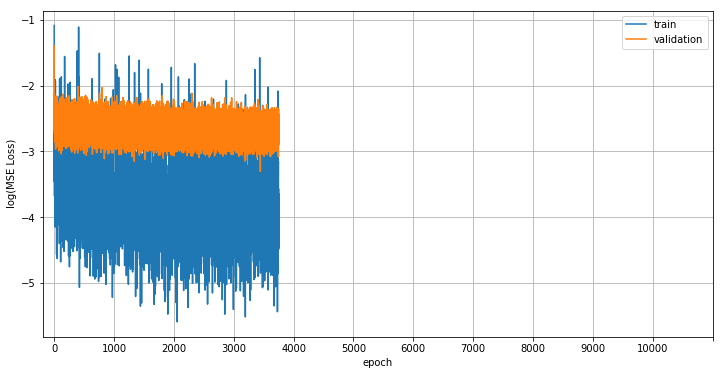

In [167]:
plt.figure(figsize=(12, 6))
plt.plot(np.log(train_loss_list)[:30000], label="train")
plt.plot(np.log(valid_loss_list)[:30000], label="validation")
plt.xlabel("epoch")
plt.ylabel("log(MSE Loss)")
plt.xticks(
    [i for i in range(0, len(train_loss_list), num*1000)], 
    [str(i*1000) for i in range(len(train_loss_list)//(num*1000))]
)
plt.legend()
plt.grid()
plt.show()

# plt.plot(np.log(aug_train_loss)[:70000])
# plt.plot(np.log(aug_valid_loss)[:70000])

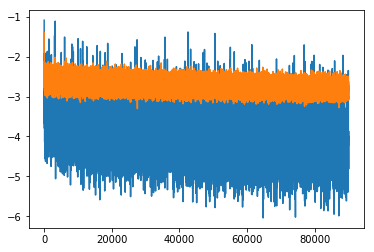

In [168]:
aug_train_loss = np.array(train_loss_list)
aug_valid_loss = np.array(valid_loss_list)

plt.plot(np.log(train_loss_list))
plt.plot(np.log(valid_loss_list))

In [ ]:
for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(param, geo)
    loss = loss_func(pred, spec)
    loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        print(float(loss))
        print(spec[:3])
        print(pred[:3])

## 分析

In [169]:
model.eval()

tmp = df.sample(frac=1)
# tmp = df.iloc[-500:]
pred = model(
    torch.tensor(tmp.values[:, 3:23].astype(np.float)).float().to(device), 
    torch.tensor(tmp.values[:, -10:-3].astype(np.float)).float().to(device)
)
loss = nn.MSELoss(reduction='none')(pred, torch.tensor(np.expand_dims(tmp.values[:, -3], 1).astype(np.float)).float().to(device))
tmp["loss"] = loss.detach().cpu().numpy()
model.train()

# col = df.columns[3:-3]
# for c in col:
# #     tmp.sort_values(by=[c])

# #     plt.title(c)
#     plt.scatter(tmp[c].tolist(), tmp["loss"].tolist())
#     plt.xlabel(c)
#     plt.ylabel("MSE Loss")
#     plt.show()

Model(
  (spec_layer): Linear(in_features=20, out_features=64, bias=True)
  (bn_spec): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (geo_layer): Linear(in_features=7, out_features=64, bias=True)
  (bn_geo): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=256, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tr

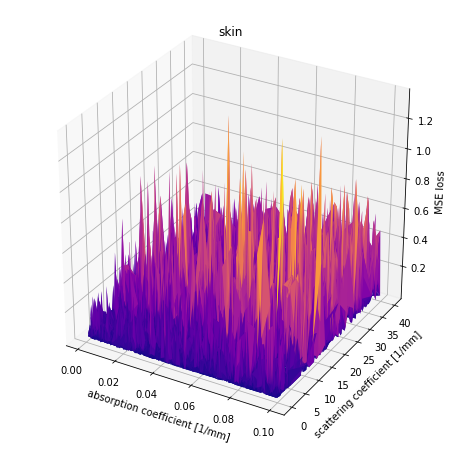

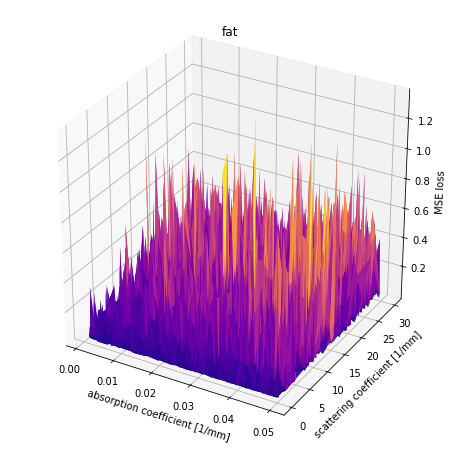

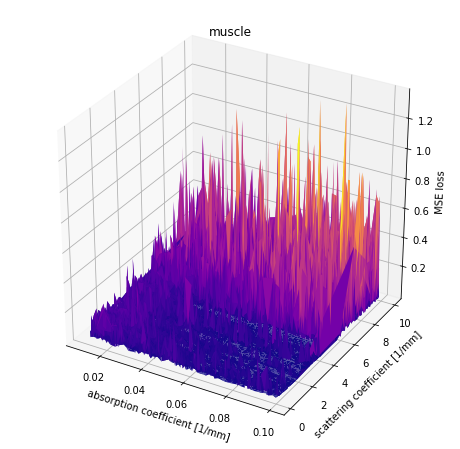

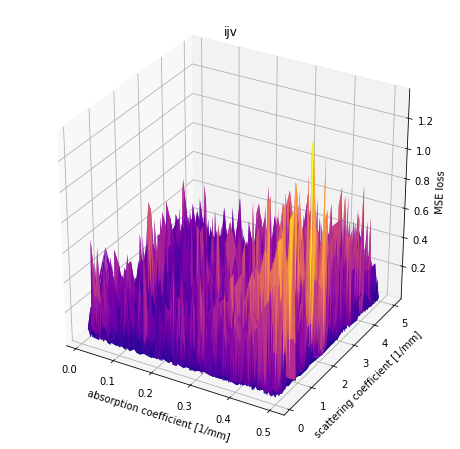

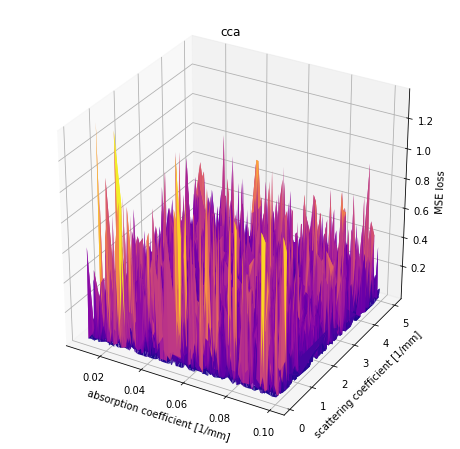

In [170]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.skin_mua, tmp.skin_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("skin")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/skin.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.fat_mua, tmp.fat_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("fat")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/fat.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.muscle_mua, tmp.muscle_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("muscle")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/muscle.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.ijv_mua, tmp.ijv_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("ijv")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/ijv.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.cca_mua, tmp.cca_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("cca")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/cca.png")
plt.show()

In [179]:
df.iloc[:, 10:].describe()

fat_n    muscle_mua    muscle_mus      muscle_g      muscle_n  \
count  26900.000000  26900.000000  26900.000000  26900.000000  26900.000000   
mean       1.416289      0.055062      5.913302      0.896422      1.415755   
std        0.020034      0.025850      2.863438      0.053749      0.020080   
min        1.380020      0.010001      0.137341      0.800202      1.380070   
25%        1.400120      0.032842      3.660430      0.852392      1.398190   
50%        1.415880      0.055112      6.351750      0.894577      1.416520   
75%        1.433150      0.077114      8.461190      0.944280      1.432880   
max        1.449980      0.099998      9.948470      0.989505      1.449430   

            ijv_mua       ijv_mus         ijv_g         ijv_n       cca_mua  \
count  26900.000000  26900.000000  26900.000000  26900.000000  26900.000000   
mean       0.255307      2.535165      0.896052      1.415474      0.055159   
std        0.141516      1.486702      0.055183      0.019819      0.025907   
min        0.010041      0.110446      0.800203      1.380780      0.010001   
25%        0.133491      1.148840      0.847858      1.399580      0.032754   
50%        0.255174      2.695760      0.902243      1.414870      0.055175   
75%        0.377568      3.819790      0.942566      1.431650      0.077542   
max        0.499988      4.993110      0.989802      1.449900      0.099999   

       ...  skin_thickness  fat_thickness    ijv_radius     ijv_depth  \
count  ...    26900.000000   26900.000000  26900.000000  26900.000000   
mean   ...        1.004126       1.002170      5.709465     11.758497   
std    ...        0.291889       0.278063      2.234052      2.704080   
min    ...        0.500976       0.501006      2.504770      4.296920   
25%    ...        0.739310       0.776846      3.754680      9.887260   
50%    ...        1.020730       0.990495      5.199120     12.032400   
75%    ...        1.262500       1.230170      7.410880     13.915900   
max    ...        1.499240       1.499500     10.450800     15.997000   

         cca_radius     cca_depth  ijv_cca_distance  reflectance_20  \
count  26900.000000  26900.000000      26900.000000    26900.000000   
mean       3.383231     17.911773          7.963023      -18.530189   
std        0.570664      6.625276          1.368066        2.685381   
min        2.512410      5.032680          5.054690      -29.113786   
25%        2.897240     13.424600          6.837150      -20.449373   
50%        3.318780     19.753200          8.154930      -17.979108   
75%        3.850350     23.718600          9.016460      -16.344307   
max        4.474900     25.995800          9.998380      -13.537028   

       reflectance_24  reflectance_28  
count    2.690000e+04    2.690000e+04  
mean     2.757918e-08    1.297435e-08  
std      5.694190e-08    3.162913e-08  
min      6.200772e-15    7.088262e-17  
25%      2.338026e-10    4.641662e-11  
50%      4.162762e-09    1.195863e-09  
75%      2.800600e-08    1.047032e-08  
max      7.127339e-07    4.589903e-07  

[8 rows x 23 columns]

In [201]:
df.shape, df_low.shape

((17900, 33), (7100, 33))

In [200]:
df_low = df[
    (df["skin_mus"] < 3)|
    (df["fat_mus"] < 2.85)|
    (df["muscle_mus"] < 3.5)|
    (df["ijv_mus"] < 1.15)
]
# df_low = df[
#     (df["skin_mus"] < 3)&
#     (df["fat_mus"] < 2.85)&
#     (df["muscle_mus"] < 3.5)&
#     (df["ijv_mus"] < 1.15)
# ]

test = SpecData(df_low, False)

testloader = DataLoader(test, batch_size=32,
                        shuffle=True, num_workers=0)

In [188]:

model.eval()
for j, (_spec, geo, param) in enumerate(testloader):
    _spec, geo, param = torch.tensor(_spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()

    _spec, geo, param = _spec.to(device), geo.to(device), param.to(device)
    _predict = model(param, geo)
    _loss = loss_func(_predict, _spec)

    valid_loss_ += [float(_loss.data)]

valid_loss_list += [np.mean(valid_loss_)]
# valid_loss_ = []


print("valid: {}".format(valid_loss_list[-1]))
print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


valid: 0.044602571706857906
tensor([[1.0762e-07],
        [2.2161e-08],
        [1.3427e-07],
        [3.7771e-08],
        [1.1556e-07]], device='cuda:0')
tensor([[8.3270e-08],
        [1.5858e-08],
        [9.6985e-08],
        [3.4649e-08],
        [1.0758e-07]], device='cuda:0', grad_fn=<ExpBackward>)


In [192]:
np.min(valid_loss_)

0.014480163343250751

In [207]:
model.train()
train_loss_list = []
for epoch in range(10000):
    train_loss_ = []
    valid_loss_ = []
    
    for i, (spec, geo, param) in enumerate(testloader):
        spec, geo, param = torch.tensor(spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
        spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(param, geo)
        loss = loss_func(predict, spec)
        loss.backward()
        optimizer.step()
        train_loss_ += [float(loss.data)]
    train_loss_list += [np.mean(train_loss_)]

    
    if epoch % 1 == 0:
            print("epoch: {} | train: {}".format(
                epoch, train_loss_list[-1]
                 ))
            print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))
#             print("{}\n{}".format(spec[0:5]*std+mean, predict[0:5]*std+mean))

#         print(predict)
#         print(param)
#     scheduler.step(loss)

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch: 0 | train: 0.012408185156632785
tensor([[2.0977e-11],
        [1.1629e-07],
        [7.3723e-08],
        [3.7726e-09],
        [9.0045e-09]], device='cuda:0')
tensor([[1.8557e-11],
        [1.1964e-07],
        [7.8173e-08],
        [2.9006e-09],
        [9.1280e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1 | train: 0.011003441093405624
tensor([[7.1826e-08],
        [1.7161e-08],
        [2.5656e-08],
        [2.9362e-10],
        [8.9293e-12]], device='cuda:0')
tensor([[7.3808e-08],
        [1.5393e-08],
        [2.2192e-08],
        [2.9748e-10],
        [8.0821e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2 | train: 0.011612596200057515
tensor([[1.0663e-07],
        [2.6883e-08],
        [4.7516e-08],
        [8.2080e-08],
        [1.6551e-09]], device='cuda:0')
tensor([[1.1547e-07],
        [2.5884e-08],
        [5.1585e-08],
        [7.9303e-08],
        [1.8786e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3 | train: 0.011278460071808114
tensor(

epoch: 26 | train: 0.013100625674433267
tensor([[1.1088e-09],
        [1.2575e-08],
        [8.2618e-08],
        [2.8901e-08],
        [9.6434e-09]], device='cuda:0')
tensor([[1.2538e-09],
        [1.2568e-08],
        [8.2953e-08],
        [3.3029e-08],
        [1.0163e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 27 | train: 0.012034518835092854
tensor([[4.9760e-09],
        [2.0334e-08],
        [4.0333e-08],
        [1.4086e-10],
        [3.9552e-08]], device='cuda:0')
tensor([[4.5717e-09],
        [1.8872e-08],
        [3.7037e-08],
        [8.2007e-11],
        [3.8000e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 28 | train: 0.011672295688710234
tensor([[6.2489e-10],
        [1.6981e-07],
        [3.3190e-10],
        [2.3467e-09],
        [3.5800e-09]], device='cuda:0')
tensor([[7.1419e-10],
        [1.6221e-07],
        [3.8432e-10],
        [2.8575e-09],
        [3.6909e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 29 | train: 0.012397512729564967
ten

epoch: 52 | train: 0.01198213999023292
tensor([[2.9915e-09],
        [7.9715e-10],
        [4.6847e-09],
        [9.1355e-10],
        [1.8469e-08]], device='cuda:0')
tensor([[6.1782e-09],
        [9.1969e-10],
        [5.3468e-09],
        [9.4287e-10],
        [2.0371e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 53 | train: 0.012948656101241239
tensor([[3.5712e-09],
        [1.1629e-07],
        [2.8512e-09],
        [1.4777e-09],
        [3.4631e-12]], device='cuda:0')
tensor([[3.5723e-09],
        [1.0705e-07],
        [2.7515e-09],
        [1.4448e-09],
        [3.9866e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 54 | train: 0.012218667696616068
tensor([[1.1533e-08],
        [1.9442e-09],
        [1.2694e-08],
        [4.0111e-10],
        [2.0905e-08]], device='cuda:0')
tensor([[1.2133e-08],
        [1.9938e-09],
        [1.1864e-08],
        [3.7093e-10],
        [2.2420e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 55 | train: 0.01244227719799456
tenso

epoch: 78 | train: 0.012502373623040816
tensor([[4.1678e-08],
        [8.6494e-10],
        [1.9421e-08],
        [2.8037e-09],
        [2.0691e-08]], device='cuda:0')
tensor([[3.3533e-08],
        [7.7021e-10],
        [1.6298e-08],
        [1.7824e-09],
        [1.7653e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 79 | train: 0.01382371182721276
tensor([[4.2741e-09],
        [3.8478e-08],
        [2.0835e-08],
        [7.5716e-08],
        [5.4112e-10]], device='cuda:0')
tensor([[4.7701e-09],
        [3.6721e-08],
        [2.1278e-08],
        [6.9831e-08],
        [6.0383e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 80 | train: 0.011326953761388656
tensor([[6.6435e-08],
        [3.5070e-08],
        [1.6742e-08],
        [1.8188e-09],
        [3.4022e-12]], device='cuda:0')
tensor([[8.1215e-08],
        [3.8314e-08],
        [1.7546e-08],
        [2.2738e-09],
        [3.7252e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 81 | train: 0.013400797094512093
tens

epoch: 104 | train: 0.012775941572554812
tensor([[6.5178e-08],
        [2.1078e-08],
        [5.4096e-09],
        [1.3625e-08],
        [2.4237e-08]], device='cuda:0')
tensor([[6.4739e-08],
        [2.1161e-08],
        [4.8863e-09],
        [1.1948e-08],
        [2.2215e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 105 | train: 0.011084816360904894
tensor([[9.5017e-10],
        [3.8324e-08],
        [1.5039e-08],
        [5.4859e-09],
        [1.4333e-09]], device='cuda:0')
tensor([[9.5730e-10],
        [3.6026e-08],
        [1.3923e-08],
        [5.2351e-09],
        [1.7336e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 106 | train: 0.010854920121706888
tensor([[1.9418e-08],
        [1.0795e-09],
        [6.5192e-08],
        [1.1235e-08],
        [7.4074e-08]], device='cuda:0')
tensor([[1.7775e-08],
        [8.6327e-10],
        [7.0213e-08],
        [1.0463e-08],
        [7.1187e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 107 | train: 0.012115271592109993

epoch: 130 | train: 0.012308135013062473
tensor([[4.7191e-09],
        [3.7785e-09],
        [4.5202e-08],
        [7.3231e-09],
        [5.7356e-10]], device='cuda:0')
tensor([[5.6484e-09],
        [3.9826e-09],
        [4.7706e-08],
        [7.6087e-09],
        [5.1952e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 131 | train: 0.011926797867819734
tensor([[7.1850e-08],
        [7.6662e-08],
        [2.5877e-08],
        [3.5181e-10],
        [6.4139e-08]], device='cuda:0')
tensor([[7.2550e-08],
        [8.1773e-08],
        [2.4521e-08],
        [3.3919e-10],
        [6.4066e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 132 | train: 0.011610091048259254
tensor([[3.8674e-10],
        [3.3579e-10],
        [1.1101e-07],
        [3.3878e-07],
        [1.6001e-07]], device='cuda:0')
tensor([[3.8816e-10],
        [3.6313e-10],
        [1.0256e-07],
        [3.2643e-07],
        [1.4291e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 133 | train: 0.011573730985768273

epoch: 156 | train: 0.012889232572486944
tensor([[4.2907e-08],
        [1.1547e-08],
        [2.4821e-09],
        [5.3152e-09],
        [1.5715e-08]], device='cuda:0')
tensor([[4.9780e-08],
        [1.3048e-08],
        [2.6366e-09],
        [5.2061e-09],
        [1.5242e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 157 | train: 0.011336669843929174
tensor([[5.7113e-08],
        [3.9329e-09],
        [1.7080e-07],
        [9.7053e-09],
        [8.9399e-09]], device='cuda:0')
tensor([[5.8530e-08],
        [4.1776e-09],
        [1.8724e-07],
        [9.1712e-09],
        [9.3735e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 158 | train: 0.012276862026402005
tensor([[1.5323e-07],
        [4.6910e-08],
        [1.0080e-08],
        [2.7870e-08],
        [9.9418e-09]], device='cuda:0')
tensor([[1.3105e-07],
        [3.9495e-08],
        [8.6511e-09],
        [2.4878e-08],
        [1.0008e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 159 | train: 0.010577019123645785

epoch: 182 | train: 0.013061269471182715
tensor([[2.2172e-10],
        [1.5233e-08],
        [2.6830e-10],
        [2.7794e-08],
        [5.4962e-11]], device='cuda:0')
tensor([[2.0664e-10],
        [1.2907e-08],
        [2.4844e-10],
        [2.9703e-08],
        [5.4063e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 183 | train: 0.012115283205324935
tensor([[1.0482e-09],
        [2.0363e-09],
        [6.3288e-10],
        [2.7113e-08],
        [8.0097e-10]], device='cuda:0')
tensor([[1.0383e-09],
        [1.8167e-09],
        [5.8363e-10],
        [2.7609e-08],
        [7.3581e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 184 | train: 0.011413585156546318
tensor([[2.8169e-08],
        [4.6146e-09],
        [1.1941e-07],
        [3.8246e-07],
        [1.9080e-08]], device='cuda:0')
tensor([[2.9090e-08],
        [3.7478e-09],
        [1.1903e-07],
        [3.2208e-07],
        [1.7917e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 185 | train: 0.013572357453380686

epoch: 208 | train: 0.011428908482172971
tensor([[1.6109e-07],
        [4.3120e-08],
        [1.0813e-08],
        [1.7519e-08],
        [1.3519e-07]], device='cuda:0')
tensor([[1.5805e-07],
        [4.3508e-08],
        [1.0492e-08],
        [1.7260e-08],
        [1.3222e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 209 | train: 0.01198471277146726
tensor([[1.1205e-10],
        [1.0266e-09],
        [2.4883e-09],
        [1.5369e-08],
        [1.2989e-07]], device='cuda:0')
tensor([[1.4474e-10],
        [1.0535e-09],
        [2.8014e-09],
        [1.9780e-08],
        [1.6841e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 210 | train: 0.01085614568243424
tensor([[6.9787e-10],
        [3.2321e-08],
        [1.2005e-10],
        [2.1695e-07],
        [7.8638e-12]], device='cuda:0')
tensor([[7.7987e-10],
        [2.7435e-08],
        [1.1714e-10],
        [2.2832e-07],
        [6.8017e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 211 | train: 0.012439426282727
tens

epoch: 234 | train: 0.013296674983680819
tensor([[6.9205e-08],
        [8.3174e-09],
        [7.0304e-09],
        [1.7074e-09],
        [6.2759e-09]], device='cuda:0')
tensor([[7.0727e-08],
        [8.6337e-09],
        [6.8829e-09],
        [1.6840e-09],
        [6.6170e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 235 | train: 0.011667444867811896
tensor([[4.9060e-08],
        [9.3090e-11],
        [1.1212e-07],
        [4.7141e-08],
        [3.8045e-09]], device='cuda:0')
tensor([[5.0190e-08],
        [1.0552e-10],
        [1.1082e-07],
        [5.0631e-08],
        [3.8671e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 236 | train: 0.011892520368459995
tensor([[1.4931e-07],
        [3.0184e-10],
        [1.9014e-10],
        [1.6550e-07],
        [3.7707e-10]], device='cuda:0')
tensor([[1.5159e-07],
        [3.4553e-10],
        [2.2599e-10],
        [1.8113e-07],
        [3.9773e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 237 | train: 0.011980238198596347

epoch: 260 | train: 0.014635151559969427
tensor([[3.9029e-08],
        [4.6308e-08],
        [3.9662e-10],
        [4.3231e-08],
        [4.3064e-11]], device='cuda:0')
tensor([[3.9121e-08],
        [5.1082e-08],
        [4.3108e-10],
        [4.0466e-08],
        [3.6446e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 261 | train: 0.01228593290271657
tensor([[1.4950e-07],
        [2.0998e-11],
        [3.6116e-08],
        [9.3967e-11],
        [2.2347e-08]], device='cuda:0')
tensor([[1.5820e-07],
        [2.1097e-11],
        [3.5371e-08],
        [8.7903e-11],
        [2.1644e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 262 | train: 0.011977287680581884
tensor([[5.7235e-12],
        [4.3354e-08],
        [8.6305e-08],
        [8.2327e-08],
        [2.5520e-10]], device='cuda:0')
tensor([[6.1009e-12],
        [4.5105e-08],
        [8.9195e-08],
        [8.3200e-08],
        [3.2161e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 263 | train: 0.011872867882662863


epoch: 286 | train: 0.012411359781483272
tensor([[5.4701e-10],
        [1.4126e-08],
        [1.1696e-09],
        [4.1242e-08],
        [7.7766e-08]], device='cuda:0')
tensor([[6.3505e-10],
        [1.8760e-08],
        [1.2705e-09],
        [4.5457e-08],
        [8.4367e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 287 | train: 0.012214548749480027
tensor([[1.4802e-11],
        [1.9352e-09],
        [7.4905e-09],
        [3.4135e-08],
        [1.2487e-08]], device='cuda:0')
tensor([[1.5816e-11],
        [2.1178e-09],
        [6.8579e-09],
        [3.1866e-08],
        [1.4150e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 288 | train: 0.012111333707506928
tensor([[1.4599e-08],
        [8.7440e-09],
        [1.1513e-08],
        [2.5065e-10],
        [1.9455e-10]], device='cuda:0')
tensor([[1.4732e-08],
        [9.7302e-09],
        [1.3623e-08],
        [2.9427e-10],
        [1.9678e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 289 | train: 0.012293389352323773

epoch: 312 | train: 0.01268446829321014
tensor([[8.0934e-09],
        [1.0402e-07],
        [1.4937e-08],
        [2.7706e-10],
        [1.7090e-09]], device='cuda:0')
tensor([[7.6271e-09],
        [9.2222e-08],
        [1.4087e-08],
        [2.6105e-10],
        [1.7123e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 313 | train: 0.011943125650538382
tensor([[4.7426e-10],
        [4.1968e-08],
        [4.5327e-08],
        [5.6516e-11],
        [9.9110e-09]], device='cuda:0')
tensor([[3.7896e-10],
        [3.7539e-08],
        [4.5422e-08],
        [4.6604e-11],
        [9.5114e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 314 | train: 0.012693929619696998
tensor([[6.7058e-10],
        [1.3794e-10],
        [3.2221e-10],
        [3.5317e-11],
        [1.5802e-07]], device='cuda:0')
tensor([[7.3132e-10],
        [1.3181e-10],
        [3.3171e-10],
        [3.8205e-11],
        [1.4953e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 315 | train: 0.01283567901784638
t

epoch: 338 | train: 0.011427434781138357
tensor([[1.6598e-08],
        [1.6823e-10],
        [1.1528e-07],
        [5.4547e-09],
        [1.5504e-07]], device='cuda:0')
tensor([[1.5609e-08],
        [1.5342e-10],
        [1.1095e-07],
        [5.3363e-09],
        [1.5199e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 339 | train: 0.014602190761424199
tensor([[5.7473e-09],
        [8.2815e-09],
        [6.3916e-10],
        [1.6057e-07],
        [2.4521e-09]], device='cuda:0')
tensor([[6.0703e-09],
        [9.2918e-09],
        [6.1874e-10],
        [1.4170e-07],
        [2.4812e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 340 | train: 0.011660775610220593
tensor([[2.7165e-08],
        [3.8369e-08],
        [4.0534e-08],
        [1.5845e-08],
        [7.2847e-09]], device='cuda:0')
tensor([[3.4437e-08],
        [3.4194e-08],
        [3.4960e-08],
        [1.7050e-08],
        [6.9281e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 341 | train: 0.011845771343917124

epoch: 364 | train: 0.013329600472724787
tensor([[1.5332e-08],
        [4.7916e-08],
        [4.5309e-08],
        [3.6456e-10],
        [1.1659e-12]], device='cuda:0')
tensor([[1.3653e-08],
        [5.0180e-08],
        [4.2472e-08],
        [3.7312e-10],
        [1.2095e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 365 | train: 0.011452312586485065
tensor([[2.9299e-08],
        [3.3373e-09],
        [4.2774e-09],
        [6.7681e-08],
        [2.5051e-09]], device='cuda:0')
tensor([[2.8382e-08],
        [3.3594e-09],
        [4.3316e-09],
        [6.7276e-08],
        [2.3947e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 366 | train: 0.012130905582510808
tensor([[1.0194e-08],
        [2.6722e-09],
        [5.5399e-10],
        [4.3996e-10],
        [3.5425e-08]], device='cuda:0')
tensor([[1.0321e-08],
        [2.7666e-09],
        [5.6460e-10],
        [4.6619e-10],
        [3.5008e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 367 | train: 0.011422819875365307

epoch: 390 | train: 0.011480671103502548
tensor([[1.3404e-08],
        [5.3163e-08],
        [1.8718e-07],
        [8.0934e-09],
        [3.4234e-07]], device='cuda:0')
tensor([[1.3266e-08],
        [5.5720e-08],
        [2.0011e-07],
        [8.4500e-09],
        [3.1080e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 391 | train: 0.011785810696368047
tensor([[8.9018e-09],
        [1.4626e-08],
        [6.1697e-11],
        [9.0520e-09],
        [1.7170e-09]], device='cuda:0')
tensor([[9.4652e-09],
        [1.3791e-08],
        [6.3834e-11],
        [8.8847e-09],
        [1.6897e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 392 | train: 0.01238678900529169
tensor([[6.1818e-09],
        [1.0931e-08],
        [4.7270e-09],
        [3.3377e-09],
        [3.9893e-12]], device='cuda:0')
tensor([[7.0473e-09],
        [1.2548e-08],
        [6.0979e-09],
        [4.6661e-09],
        [5.2608e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 393 | train: 0.012561040441715368


epoch: 416 | train: 0.011245899087002685
tensor([[2.3403e-08],
        [1.9537e-07],
        [2.8340e-08],
        [2.4384e-08],
        [6.6611e-08]], device='cuda:0')
tensor([[2.0757e-08],
        [1.8425e-07],
        [3.1945e-08],
        [2.3991e-08],
        [6.2452e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 417 | train: 0.011579226941050676
tensor([[4.0046e-11],
        [1.3062e-10],
        [7.4641e-08],
        [2.5125e-08],
        [3.7798e-08]], device='cuda:0')
tensor([[3.8360e-11],
        [1.1624e-10],
        [7.2829e-08],
        [2.6642e-08],
        [3.5778e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 418 | train: 0.012081300088850496
tensor([[1.9967e-11],
        [5.1500e-09],
        [1.6715e-08],
        [2.7753e-09],
        [1.1547e-08]], device='cuda:0')
tensor([[2.0705e-11],
        [6.3096e-09],
        [1.9352e-08],
        [2.5703e-09],
        [1.0793e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 419 | train: 0.011540318934691584

epoch: 442 | train: 0.01390972589813844
tensor([[2.5063e-09],
        [1.9236e-08],
        [3.8135e-09],
        [4.8709e-09],
        [1.9969e-07]], device='cuda:0')
tensor([[2.5615e-09],
        [1.4488e-08],
        [4.0806e-09],
        [4.7163e-09],
        [2.0470e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 443 | train: 0.012060855377910172
tensor([[2.7194e-07],
        [8.1339e-09],
        [7.6088e-08],
        [1.8245e-08],
        [4.5712e-08]], device='cuda:0')
tensor([[2.5642e-07],
        [7.7303e-09],
        [7.7996e-08],
        [1.7481e-08],
        [4.0797e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 444 | train: 0.012304556816145106
tensor([[1.4074e-08],
        [2.0985e-09],
        [6.8642e-09],
        [6.3925e-09],
        [1.1528e-07]], device='cuda:0')
tensor([[1.3195e-08],
        [2.1394e-09],
        [6.3878e-09],
        [6.3175e-09],
        [1.0621e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 445 | train: 0.012772891623270069


epoch: 468 | train: 0.012562070748777137
tensor([[2.7670e-08],
        [3.1877e-07],
        [1.5734e-08],
        [7.6846e-08],
        [1.9212e-08]], device='cuda:0')
tensor([[3.0807e-08],
        [2.6387e-07],
        [1.1452e-08],
        [7.4510e-08],
        [1.6577e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 469 | train: 0.011341834385241676
tensor([[2.1417e-07],
        [3.1828e-09],
        [8.6460e-09],
        [3.9151e-08],
        [1.5845e-08]], device='cuda:0')
tensor([[2.0510e-07],
        [2.9112e-09],
        [8.7582e-09],
        [3.9480e-08],
        [1.5711e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 470 | train: 0.012053447427345557
tensor([[5.0192e-08],
        [1.2134e-08],
        [1.2840e-07],
        [1.7701e-10],
        [8.2796e-08]], device='cuda:0')
tensor([[3.7075e-08],
        [1.0438e-08],
        [1.1717e-07],
        [1.6643e-10],
        [8.5504e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 471 | train: 0.01210284360258647


epoch: 494 | train: 0.014916005671267642
tensor([[7.5837e-09],
        [5.4497e-10],
        [7.7586e-11],
        [7.6404e-08],
        [7.9715e-10]], device='cuda:0')
tensor([[6.8276e-09],
        [5.9247e-10],
        [5.5657e-11],
        [7.0333e-08],
        [6.7334e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 495 | train: 0.012692365257346348
tensor([[2.1048e-07],
        [8.2867e-09],
        [1.4096e-08],
        [1.4476e-08],
        [7.8523e-10]], device='cuda:0')
tensor([[2.3412e-07],
        [8.6877e-09],
        [1.1376e-08],
        [1.4847e-08],
        [7.1972e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 496 | train: 0.01213014996526679
tensor([[1.3718e-11],
        [4.4972e-09],
        [4.6239e-09],
        [1.5766e-09],
        [4.7496e-10]], device='cuda:0')
tensor([[1.0925e-11],
        [4.5472e-09],
        [4.6964e-09],
        [1.6597e-09],
        [5.1089e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 497 | train: 0.011959495373187704


epoch: 520 | train: 0.012762187370770351
tensor([[6.4540e-08],
        [1.1543e-08],
        [8.8405e-09],
        [2.4497e-07],
        [4.7092e-09]], device='cuda:0')
tensor([[6.5950e-08],
        [1.1503e-08],
        [1.0132e-08],
        [2.5501e-07],
        [4.9848e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 521 | train: 0.01274993565869056
tensor([[1.9551e-09],
        [7.5613e-08],
        [1.4246e-10],
        [5.0755e-08],
        [3.9797e-08]], device='cuda:0')
tensor([[1.2163e-09],
        [6.6293e-08],
        [1.2155e-10],
        [4.0364e-08],
        [3.3605e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 522 | train: 0.012111658845012923
tensor([[1.5409e-09],
        [2.7936e-08],
        [1.7321e-07],
        [1.2405e-11],
        [1.8482e-07]], device='cuda:0')
tensor([[1.6121e-09],
        [2.9571e-08],
        [1.8013e-07],
        [1.3142e-11],
        [1.8298e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 523 | train: 0.011678432638815663


epoch: 546 | train: 0.013390502396358497
tensor([[1.8184e-08],
        [6.7110e-08],
        [8.3601e-09],
        [8.0439e-10],
        [2.1281e-07]], device='cuda:0')
tensor([[2.2879e-08],
        [6.6395e-08],
        [1.1720e-08],
        [1.5990e-09],
        [2.2994e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 547 | train: 0.011017449692034305
tensor([[1.7893e-08],
        [6.4478e-09],
        [3.2827e-08],
        [8.5999e-08],
        [1.7701e-10]], device='cuda:0')
tensor([[1.6471e-08],
        [5.7834e-09],
        [3.3191e-08],
        [8.2473e-08],
        [1.7128e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 548 | train: 0.011831690491227483
tensor([[2.5332e-09],
        [8.0491e-08],
        [4.4545e-08],
        [6.6232e-09],
        [1.3153e-09]], device='cuda:0')
tensor([[2.3932e-09],
        [8.0197e-08],
        [3.8566e-08],
        [5.2900e-09],
        [1.3277e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 549 | train: 0.013003443956148584

epoch: 572 | train: 0.01080274710490427
tensor([[4.4211e-09],
        [6.7535e-09],
        [5.4701e-10],
        [4.3452e-08],
        [2.6019e-08]], device='cuda:0')
tensor([[4.4842e-09],
        [8.1862e-09],
        [5.4182e-10],
        [4.6545e-08],
        [2.5502e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 573 | train: 0.010918096170408299
tensor([[5.9325e-08],
        [5.3949e-10],
        [1.4177e-08],
        [3.3688e-11],
        [7.3964e-10]], device='cuda:0')
tensor([[6.3215e-08],
        [5.5418e-10],
        [1.3293e-08],
        [3.8724e-11],
        [7.3997e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 574 | train: 0.01056973463834708
tensor([[2.6253e-08],
        [1.9491e-07],
        [6.5301e-10],
        [1.1362e-08],
        [3.0485e-08]], device='cuda:0')
tensor([[2.5490e-08],
        [1.8946e-07],
        [6.3252e-10],
        [1.0755e-08],
        [2.8454e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 575 | train: 0.011542620298847018
t

epoch: 598 | train: 0.011590257794113813
tensor([[6.9755e-11],
        [2.1563e-09],
        [1.0678e-10],
        [6.8035e-11],
        [8.0719e-08]], device='cuda:0')
tensor([[7.7674e-11],
        [2.2676e-09],
        [9.6927e-11],
        [9.0804e-11],
        [9.3444e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 599 | train: 0.011267100445095551
tensor([[2.0096e-09],
        [4.4219e-09],
        [1.7140e-07],
        [3.7011e-08],
        [5.4476e-10]], device='cuda:0')
tensor([[2.4066e-09],
        [4.2108e-09],
        [1.7181e-07],
        [3.4283e-08],
        [6.0387e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 600 | train: 0.010737873216344227
tensor([[1.0280e-07],
        [1.7336e-10],
        [2.6454e-11],
        [2.0156e-08],
        [1.7091e-10]], device='cuda:0')
tensor([[1.0608e-07],
        [1.6517e-10],
        [2.3923e-11],
        [2.1079e-08],
        [1.9959e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 601 | train: 0.010896858911298483

epoch: 624 | train: 0.011975257971055538
tensor([[7.0594e-08],
        [2.6580e-08],
        [7.6395e-10],
        [2.4453e-07],
        [3.2335e-10]], device='cuda:0')
tensor([[7.8840e-08],
        [2.8682e-08],
        [7.8185e-10],
        [2.2766e-07],
        [2.9310e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 625 | train: 0.012217036094977983
tensor([[2.4755e-08],
        [5.3690e-09],
        [3.7370e-08],
        [6.6240e-09],
        [4.8071e-09]], device='cuda:0')
tensor([[2.7042e-08],
        [5.4632e-09],
        [4.5546e-08],
        [6.9860e-09],
        [5.2133e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 626 | train: 0.0124510295074517
tensor([[1.0050e-08],
        [3.3078e-09],
        [1.0469e-08],
        [4.0305e-09],
        [9.8126e-09]], device='cuda:0')
tensor([[9.5350e-09],
        [3.3175e-09],
        [1.4202e-08],
        [3.8561e-09],
        [1.0243e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 627 | train: 0.012905372533242445
t

epoch: 650 | train: 0.011832159942829865
tensor([[2.0487e-09],
        [6.4221e-11],
        [3.3676e-10],
        [2.0417e-08],
        [1.3453e-09]], device='cuda:0')
tensor([[1.7220e-09],
        [5.3401e-11],
        [3.3843e-10],
        [1.9120e-08],
        [1.5015e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 651 | train: 0.013876390882541199
tensor([[4.2825e-11],
        [6.8988e-09],
        [6.1730e-08],
        [1.3975e-08],
        [8.3272e-08]], device='cuda:0')
tensor([[4.5520e-11],
        [7.3351e-09],
        [6.0642e-08],
        [1.4081e-08],
        [8.6825e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 652 | train: 0.011049069125448598
tensor([[3.6402e-11],
        [5.6224e-08],
        [1.9080e-08],
        [7.5394e-10],
        [4.2741e-09]], device='cuda:0')
tensor([[3.9028e-11],
        [5.9244e-08],
        [1.6025e-08],
        [8.6900e-10],
        [4.9408e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 653 | train: 0.011164195605906079

epoch: 676 | train: 0.01025897934602842
tensor([[2.5773e-09],
        [2.0537e-08],
        [2.1117e-07],
        [2.8750e-08],
        [4.8470e-08]], device='cuda:0')
tensor([[2.3602e-09],
        [1.8889e-08],
        [1.9016e-07],
        [3.0745e-08],
        [4.5196e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 677 | train: 0.012886362720851426
tensor([[7.5093e-08],
        [1.3427e-07],
        [1.9667e-09],
        [3.7441e-08],
        [4.9718e-08]], device='cuda:0')
tensor([[8.4350e-08],
        [1.1099e-07],
        [2.1042e-09],
        [3.2682e-08],
        [5.0928e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 678 | train: 0.011760209236600276
tensor([[2.0724e-08],
        [5.4353e-10],
        [3.1430e-10],
        [1.3398e-10],
        [3.6917e-08]], device='cuda:0')
tensor([[2.1384e-08],
        [5.5161e-10],
        [2.8754e-10],
        [1.2453e-10],
        [3.5644e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 679 | train: 0.012541756178629963


epoch: 702 | train: 0.013011817970346694
tensor([[4.9544e-09],
        [8.3038e-10],
        [1.0648e-08],
        [9.0635e-08],
        [3.0049e-08]], device='cuda:0')
tensor([[5.0753e-09],
        [8.9380e-10],
        [1.0685e-08],
        [1.0183e-07],
        [2.9928e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 703 | train: 0.01152013276225409
tensor([[2.6772e-10],
        [1.4603e-09],
        [1.0332e-09],
        [3.3348e-09],
        [2.8958e-10]], device='cuda:0')
tensor([[1.9275e-10],
        [1.3551e-09],
        [1.0097e-09],
        [3.1004e-09],
        [2.6965e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 704 | train: 0.013963516621204378
tensor([[3.1998e-09],
        [8.6895e-09],
        [2.4721e-07],
        [1.6240e-07],
        [4.1988e-09]], device='cuda:0')
tensor([[2.6050e-09],
        [7.5994e-09],
        [2.4523e-07],
        [1.4946e-07],
        [3.7420e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 705 | train: 0.01260894013627491
t

epoch: 728 | train: 0.011027296940032561
tensor([[5.8063e-07],
        [5.3106e-08],
        [4.5705e-08],
        [1.7622e-07],
        [5.3682e-10]], device='cuda:0')
tensor([[6.7043e-07],
        [4.9083e-08],
        [4.6527e-08],
        [1.9164e-07],
        [5.4356e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 729 | train: 0.011896341179103197
tensor([[6.9445e-08],
        [3.4749e-08],
        [2.4249e-09],
        [2.1924e-08],
        [6.4874e-09]], device='cuda:0')
tensor([[7.2830e-08],
        [3.3326e-08],
        [2.4372e-09],
        [2.1067e-08],
        [6.1261e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 730 | train: 0.011474973984641602
tensor([[3.6191e-09],
        [5.9099e-08],
        [3.5632e-09],
        [1.0469e-07],
        [1.8259e-07]], device='cuda:0')
tensor([[3.6083e-09],
        [6.1628e-08],
        [3.8396e-09],
        [1.1072e-07],
        [2.0384e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 731 | train: 0.012408954222468441

epoch: 754 | train: 0.012819695484673453
tensor([[5.7574e-08],
        [1.2003e-08],
        [3.7532e-08],
        [8.1227e-10],
        [3.0994e-11]], device='cuda:0')
tensor([[5.6206e-08],
        [1.2843e-08],
        [3.7611e-08],
        [7.9931e-10],
        [3.0495e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 755 | train: 0.011266420141223248
tensor([[8.1091e-08],
        [1.1556e-07],
        [3.7546e-11],
        [3.0546e-10],
        [3.5222e-09]], device='cuda:0')
tensor([[7.5511e-08],
        [1.2125e-07],
        [4.3023e-11],
        [3.4193e-10],
        [3.7271e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 756 | train: 0.011496957726063425
tensor([[1.0428e-08],
        [2.2771e-08],
        [5.0324e-10],
        [4.7891e-09],
        [3.4515e-08]], device='cuda:0')
tensor([[1.0323e-08],
        [2.7350e-08],
        [4.7775e-10],
        [4.7485e-09],
        [3.6110e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 757 | train: 0.01249704214005924


epoch: 780 | train: 0.012414102905077508
tensor([[2.8362e-09],
        [4.3451e-11],
        [1.8688e-09],
        [7.2340e-09],
        [2.6463e-08]], device='cuda:0')
tensor([[2.8141e-09],
        [4.6638e-11],
        [1.6331e-09],
        [7.1976e-09],
        [2.0063e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 781 | train: 0.013018384314695926
tensor([[5.1446e-10],
        [6.4104e-08],
        [2.3482e-08],
        [4.9668e-09],
        [1.5039e-08]], device='cuda:0')
tensor([[7.0908e-10],
        [7.5732e-08],
        [2.4517e-08],
        [5.7427e-09],
        [1.7370e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 782 | train: 0.011472872433227461
tensor([[2.7571e-08],
        [5.1591e-11],
        [1.6208e-07],
        [3.4342e-08],
        [4.0280e-09]], device='cuda:0')
tensor([[2.3861e-08],
        [4.6163e-11],
        [1.6410e-07],
        [2.9283e-08],
        [3.4359e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 783 | train: 0.013913137053751998

epoch: 806 | train: 0.009892174117225181
tensor([[7.6841e-08],
        [6.2759e-08],
        [1.5343e-09],
        [5.7872e-09],
        [1.3511e-10]], device='cuda:0')
tensor([[7.6035e-08],
        [6.5428e-08],
        [1.9308e-09],
        [5.3205e-09],
        [1.1115e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 807 | train: 0.011348920819760711
tensor([[1.7174e-10],
        [1.7318e-08],
        [5.1073e-09],
        [2.2393e-09],
        [6.6115e-09]], device='cuda:0')
tensor([[1.5890e-10],
        [1.6182e-08],
        [5.8543e-09],
        [2.1372e-09],
        [6.8568e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 808 | train: 0.011058061133004591
tensor([[1.8004e-09],
        [7.5734e-10],
        [1.2693e-08],
        [7.7842e-11],
        [6.8157e-09]], device='cuda:0')
tensor([[2.0398e-09],
        [8.3710e-10],
        [1.5129e-08],
        [9.8290e-11],
        [8.1018e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 809 | train: 0.011675069728438315

epoch: 832 | train: 0.013354247827124823
tensor([[3.0467e-08],
        [4.0595e-08],
        [5.1573e-11],
        [2.5489e-09],
        [1.2716e-08]], device='cuda:0')
tensor([[3.0063e-08],
        [4.3448e-08],
        [4.1496e-11],
        [2.5728e-09],
        [1.1731e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 833 | train: 0.011503549785613342
tensor([[1.4834e-08],
        [4.6817e-08],
        [9.3967e-11],
        [2.2847e-08],
        [3.2103e-09]], device='cuda:0')
tensor([[1.4444e-08],
        [4.8235e-08],
        [8.7277e-11],
        [2.1993e-08],
        [2.9389e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 834 | train: 0.012455403134604363
tensor([[2.6956e-08],
        [3.9012e-09],
        [1.6281e-11],
        [5.4721e-10],
        [5.9538e-11]], device='cuda:0')
tensor([[2.7203e-08],
        [4.1744e-09],
        [1.6173e-11],
        [5.7337e-10],
        [6.2871e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 835 | train: 0.01305754271625365


epoch: 858 | train: 0.011594647771326473
tensor([[4.8606e-07],
        [1.1025e-08],
        [1.0793e-08],
        [6.8182e-09],
        [1.1564e-07]], device='cuda:0')
tensor([[4.2925e-07],
        [1.0205e-08],
        [9.5799e-09],
        [6.2753e-09],
        [1.0883e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 859 | train: 0.010966781538340624
tensor([[8.7930e-09],
        [1.0525e-08],
        [4.5046e-09],
        [9.5360e-09],
        [1.3975e-08]], device='cuda:0')
tensor([[8.3427e-09],
        [1.1273e-08],
        [4.5129e-09],
        [9.2190e-09],
        [1.3206e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 860 | train: 0.012435601187265805
tensor([[6.5056e-09],
        [5.6819e-08],
        [1.1952e-10],
        [1.0886e-09],
        [4.1089e-09]], device='cuda:0')
tensor([[7.4320e-09],
        [5.4267e-08],
        [1.3472e-10],
        [1.0677e-09],
        [3.9887e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 861 | train: 0.011278794970371769

epoch: 884 | train: 0.01168161712540733
tensor([[1.0201e-08],
        [1.7701e-10],
        [5.5267e-08],
        [7.6007e-08],
        [2.9607e-08]], device='cuda:0')
tensor([[1.5406e-08],
        [1.8612e-10],
        [6.9725e-08],
        [8.1914e-08],
        [3.4553e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 885 | train: 0.011427822067645622
tensor([[1.0747e-08],
        [9.2696e-09],
        [1.8181e-08],
        [1.2491e-07],
        [4.8063e-11]], device='cuda:0')
tensor([[1.0289e-08],
        [1.0155e-08],
        [2.0533e-08],
        [1.5583e-07],
        [4.8658e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 886 | train: 0.012625282903008902
tensor([[6.4791e-08],
        [2.7169e-08],
        [4.6083e-09],
        [2.7961e-08],
        [4.9878e-09]], device='cuda:0')
tensor([[5.9290e-08],
        [2.7952e-08],
        [4.4143e-09],
        [2.8028e-08],
        [5.7077e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 887 | train: 0.011836330163049268


epoch: 910 | train: 0.01197639937609065
tensor([[1.7448e-07],
        [1.2546e-08],
        [9.4825e-08],
        [3.5681e-10],
        [3.4428e-09]], device='cuda:0')
tensor([[1.6506e-07],
        [1.2551e-08],
        [9.9812e-08],
        [4.1367e-10],
        [3.4542e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 911 | train: 0.011511545298990232
tensor([[1.8569e-08],
        [1.9455e-10],
        [1.9136e-07],
        [1.4640e-07],
        [2.4215e-08]], device='cuda:0')
tensor([[1.9535e-08],
        [1.9545e-10],
        [2.2290e-07],
        [1.4862e-07],
        [2.7388e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 912 | train: 0.01096721818913949
tensor([[3.4943e-08],
        [1.1822e-07],
        [3.2723e-08],
        [3.6393e-08],
        [2.0196e-09]], device='cuda:0')
tensor([[3.4049e-08],
        [1.0114e-07],
        [3.5103e-08],
        [3.1845e-08],
        [1.7596e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 913 | train: 0.012580484899625115
t

epoch: 936 | train: 0.011829244099800719
tensor([[3.4718e-08],
        [1.0886e-09],
        [1.0576e-07],
        [4.1957e-08],
        [1.0747e-08]], device='cuda:0')
tensor([[2.0907e-08],
        [1.0368e-09],
        [8.2832e-08],
        [3.6132e-08],
        [1.0015e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 937 | train: 0.012998837678743576
tensor([[1.7547e-08],
        [1.3169e-08],
        [2.8147e-08],
        [4.0333e-08],
        [5.9247e-08]], device='cuda:0')
tensor([[1.6534e-08],
        [1.1361e-08],
        [3.1517e-08],
        [3.7436e-08],
        [5.4437e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 938 | train: 0.012470805219391378
tensor([[1.0904e-08],
        [2.9864e-08],
        [1.9119e-08],
        [2.9103e-08],
        [1.2545e-08]], device='cuda:0')
tensor([[1.1940e-08],
        [3.2009e-08],
        [1.9504e-08],
        [3.0913e-08],
        [1.3053e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 939 | train: 0.009974277358049073

epoch: 962 | train: 0.011443913030136074
tensor([[3.3513e-10],
        [1.9080e-08],
        [3.9731e-08],
        [2.3995e-11],
        [7.1182e-09]], device='cuda:0')
tensor([[3.3837e-10],
        [1.8965e-08],
        [4.3937e-08],
        [2.3909e-11],
        [6.3369e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 963 | train: 0.0104044691291386
tensor([[7.0594e-08],
        [1.1475e-07],
        [1.5020e-09],
        [3.1185e-09],
        [1.6836e-08]], device='cuda:0')
tensor([[6.4907e-08],
        [1.2487e-07],
        [1.5716e-09],
        [3.6419e-09],
        [1.7730e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 964 | train: 0.013143967071480982
tensor([[9.4950e-10],
        [8.5008e-10],
        [7.5386e-10],
        [1.1568e-10],
        [1.8070e-09]], device='cuda:0')
tensor([[1.0197e-09],
        [9.1553e-10],
        [7.4661e-10],
        [1.2384e-10],
        [2.1365e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 965 | train: 0.011460698625022496
t

epoch: 988 | train: 0.012713080873033283
tensor([[5.7064e-08],
        [8.7562e-08],
        [2.8201e-10],
        [3.5550e-09],
        [3.5796e-08]], device='cuda:0')
tensor([[6.1960e-08],
        [9.8335e-08],
        [2.9921e-10],
        [3.7117e-09],
        [4.2079e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 989 | train: 0.012409037449984468
tensor([[5.7344e-08],
        [2.7795e-09],
        [1.5140e-07],
        [4.0400e-08],
        [2.7127e-08]], device='cuda:0')
tensor([[5.0682e-08],
        [2.4515e-09],
        [1.5272e-07],
        [3.8881e-08],
        [2.4726e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 990 | train: 0.011427666918534014
tensor([[9.7106e-10],
        [8.2274e-08],
        [4.8189e-09],
        [6.0337e-10],
        [1.5834e-10]], device='cuda:0')
tensor([[8.6456e-10],
        [7.7177e-08],
        [4.1036e-09],
        [6.1179e-10],
        [1.3999e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 991 | train: 0.011435006079180082

epoch: 1014 | train: 0.011059489778687691
tensor([[2.6019e-08],
        [6.5454e-09],
        [9.1296e-08],
        [3.6116e-08],
        [1.3672e-07]], device='cuda:0')
tensor([[2.5214e-08],
        [5.8014e-09],
        [9.1632e-08],
        [3.5923e-08],
        [1.4287e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1015 | train: 0.010492426956802406
tensor([[7.4412e-08],
        [3.6122e-08],
        [1.3141e-08],
        [6.6408e-09],
        [6.1506e-08]], device='cuda:0')
tensor([[7.2545e-08],
        [3.8450e-08],
        [1.4229e-08],
        [6.9657e-09],
        [6.9640e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1016 | train: 0.01189783746733221
tensor([[4.3660e-07],
        [9.9367e-11],
        [1.5206e-10],
        [1.2799e-08],
        [2.1482e-07]], device='cuda:0')
tensor([[4.8555e-07],
        [1.1344e-10],
        [1.7970e-10],
        [1.1388e-08],
        [2.1941e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1017 | train: 0.011214844862561

epoch: 1040 | train: 0.012461559772533406
tensor([[4.9690e-08],
        [9.2901e-10],
        [8.4074e-08],
        [6.6766e-10],
        [8.8787e-08]], device='cuda:0')
tensor([[4.2527e-08],
        [9.3611e-10],
        [8.2843e-08],
        [6.3743e-10],
        [8.6427e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1041 | train: 0.010786030287350956
tensor([[1.2753e-10],
        [1.0396e-09],
        [1.0232e-10],
        [7.7830e-10],
        [5.3258e-08]], device='cuda:0')
tensor([[1.3868e-10],
        [1.0787e-09],
        [1.0848e-10],
        [8.1115e-10],
        [5.6857e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1042 | train: 0.011490492543482498
tensor([[1.2392e-09],
        [1.3226e-09],
        [1.6840e-08],
        [1.7542e-08],
        [5.3331e-09]], device='cuda:0')
tensor([[1.3747e-09],
        [1.5740e-09],
        [1.9110e-08],
        [1.9050e-08],
        [6.0166e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1043 | train: 0.01050603865679

epoch: 1066 | train: 0.012063116226387251
tensor([[1.8324e-10],
        [7.6088e-08],
        [1.3907e-12],
        [4.3120e-08],
        [7.6801e-09]], device='cuda:0')
tensor([[1.7080e-10],
        [6.8890e-08],
        [1.1987e-12],
        [4.1165e-08],
        [7.2977e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1067 | train: 0.01160400809703378
tensor([[5.0698e-08],
        [1.8188e-09],
        [4.4149e-10],
        [4.7348e-08],
        [7.3432e-09]], device='cuda:0')
tensor([[5.6019e-08],
        [2.0116e-09],
        [4.3637e-10],
        [5.5633e-08],
        [8.1156e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1068 | train: 0.011700176143062275
tensor([[9.2801e-09],
        [1.1809e-10],
        [3.7184e-09],
        [2.6391e-10],
        [3.7969e-08]], device='cuda:0')
tensor([[9.2167e-09],
        [1.2583e-10],
        [4.2471e-09],
        [2.7768e-10],
        [3.6285e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1069 | train: 0.012159854330978

epoch: 1092 | train: 0.013473276552316305
tensor([[1.1730e-09],
        [1.6836e-09],
        [1.4960e-09],
        [3.4008e-08],
        [2.1318e-07]], device='cuda:0')
tensor([[1.5053e-09],
        [2.1910e-09],
        [1.6891e-09],
        [3.8965e-08],
        [2.0608e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1093 | train: 0.011897003050549543
tensor([[2.0600e-08],
        [1.2215e-08],
        [2.2547e-09],
        [2.5023e-08],
        [1.4600e-08]], device='cuda:0')
tensor([[2.5136e-08],
        [1.1123e-08],
        [1.9415e-09],
        [2.4704e-08],
        [1.4626e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1094 | train: 0.01290164130890893
tensor([[7.5852e-08],
        [4.3388e-11],
        [5.8629e-10],
        [5.3783e-08],
        [1.6819e-07]], device='cuda:0')
tensor([[8.1004e-08],
        [4.6327e-11],
        [6.1031e-10],
        [5.3692e-08],
        [1.7132e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1095 | train: 0.011628371422170

epoch: 1118 | train: 0.010637265281869215
tensor([[1.7160e-08],
        [2.6022e-09],
        [1.9245e-10],
        [1.6106e-08],
        [2.4984e-08]], device='cuda:0')
tensor([[1.7414e-08],
        [2.8531e-09],
        [2.0049e-10],
        [1.1578e-08],
        [2.5583e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1119 | train: 0.010918920298593605
tensor([[4.4249e-09],
        [1.9136e-07],
        [4.8968e-07],
        [2.3085e-08],
        [1.3207e-09]], device='cuda:0')
tensor([[4.3612e-09],
        [1.9230e-07],
        [5.5487e-07],
        [2.0144e-08],
        [1.2158e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1120 | train: 0.011087294505397277
tensor([[5.7965e-09],
        [1.2487e-08],
        [1.6166e-09],
        [5.3005e-08],
        [2.3177e-08]], device='cuda:0')
tensor([[5.9389e-09],
        [8.2471e-09],
        [1.2990e-09],
        [4.4602e-08],
        [1.7598e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1121 | train: 0.01115594542614

epoch: 1144 | train: 0.013346996724706245
tensor([[2.0565e-09],
        [2.0691e-08],
        [1.0842e-11],
        [6.8900e-08],
        [3.7991e-09]], device='cuda:0')
tensor([[1.7066e-09],
        [1.8121e-08],
        [1.1449e-11],
        [6.7085e-08],
        [3.2403e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1145 | train: 0.012049819651135319
tensor([[6.5240e-10],
        [3.5787e-09],
        [1.8230e-08],
        [4.0534e-08],
        [3.4855e-09]], device='cuda:0')
tensor([[5.8315e-10],
        [3.3164e-09],
        [1.8518e-08],
        [4.0126e-08],
        [3.4044e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1146 | train: 0.0105394889015352
tensor([[8.1043e-08],
        [8.4535e-09],
        [5.2091e-10],
        [6.3707e-08],
        [1.1528e-07]], device='cuda:0')
tensor([[9.4635e-08],
        [8.0165e-09],
        [4.8090e-10],
        [6.6087e-08],
        [1.1009e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1147 | train: 0.0123357112259343

epoch: 1170 | train: 0.011114404110976302
tensor([[1.3385e-09],
        [6.3041e-10],
        [1.9080e-07],
        [2.2878e-08],
        [1.0816e-07]], device='cuda:0')
tensor([[1.0793e-09],
        [6.0057e-10],
        [1.7554e-07],
        [2.1886e-08],
        [9.4944e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1171 | train: 0.011030429877185574
tensor([[3.8660e-11],
        [4.2503e-09],
        [1.3959e-08],
        [9.9434e-08],
        [1.4035e-08]], device='cuda:0')
tensor([[4.0005e-11],
        [3.9229e-09],
        [1.2589e-08],
        [8.9945e-08],
        [1.3061e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1172 | train: 0.012582854578074336
tensor([[6.6132e-09],
        [4.0305e-09],
        [3.1205e-07],
        [5.2453e-11],
        [2.1978e-08]], device='cuda:0')
tensor([[6.6381e-09],
        [4.1369e-09],
        [3.2675e-07],
        [4.9674e-11],
        [2.0194e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1173 | train: 0.01278118975775

epoch: 1196 | train: 0.01003501242181907
tensor([[3.1620e-08],
        [3.6232e-08],
        [8.2462e-09],
        [6.0558e-09],
        [6.1156e-08]], device='cuda:0')
tensor([[2.7259e-08],
        [3.9194e-08],
        [7.9558e-09],
        [6.0060e-09],
        [6.2635e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1197 | train: 0.011016327657040444
tensor([[1.1174e-08],
        [3.9616e-09],
        [1.3457e-08],
        [1.4726e-08],
        [1.2278e-09]], device='cuda:0')
tensor([[1.2921e-08],
        [4.2984e-09],
        [1.5411e-08],
        [1.6855e-08],
        [1.4324e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1198 | train: 0.014801444999689052
tensor([[2.9067e-08],
        [1.2208e-08],
        [1.5990e-07],
        [3.1046e-08],
        [3.3360e-08]], device='cuda:0')
tensor([[3.0761e-08],
        [1.2110e-08],
        [1.4308e-07],
        [3.3519e-08],
        [3.0648e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1199 | train: 0.013258104962464

epoch: 1222 | train: 0.0130265134550329
tensor([[1.7249e-10],
        [5.2289e-11],
        [5.7337e-11],
        [5.2575e-09],
        [1.2568e-08]], device='cuda:0')
tensor([[2.2072e-10],
        [6.4015e-11],
        [7.8963e-11],
        [5.7118e-09],
        [1.2475e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1223 | train: 0.011052864265988942
tensor([[5.5971e-11],
        [8.6492e-09],
        [6.6190e-10],
        [6.0899e-09],
        [2.6513e-09]], device='cuda:0')
tensor([[5.5611e-11],
        [8.1065e-09],
        [6.5209e-10],
        [6.1189e-09],
        [3.0142e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1224 | train: 0.011156830794035314
tensor([[5.9847e-09],
        [6.7058e-10],
        [5.2786e-08],
        [2.0782e-07],
        [5.9099e-08]], device='cuda:0')
tensor([[5.1653e-09],
        [5.5416e-10],
        [4.7450e-08],
        [1.8072e-07],
        [5.9829e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1225 | train: 0.0117337935932425

epoch: 1248 | train: 0.012021402585076855
tensor([[2.3410e-10],
        [4.3142e-08],
        [3.4526e-08],
        [5.7965e-09],
        [8.1779e-09]], device='cuda:0')
tensor([[2.1229e-10],
        [3.4785e-08],
        [3.3161e-08],
        [5.8520e-09],
        [8.0913e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1249 | train: 0.01048290600364625
tensor([[8.8787e-08],
        [7.6271e-08],
        [5.9820e-08],
        [2.2348e-08],
        [3.8684e-08]], device='cuda:0')
tensor([[8.2112e-08],
        [7.5463e-08],
        [6.6353e-08],
        [2.0200e-08],
        [3.5315e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1250 | train: 0.01097241548301132
tensor([[2.6929e-11],
        [8.0641e-10],
        [3.6692e-08],
        [6.9501e-10],
        [5.1905e-10]], device='cuda:0')
tensor([[2.8024e-11],
        [8.7729e-10],
        [4.3190e-08],
        [8.0340e-10],
        [5.2440e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1251 | train: 0.0112555487110774

epoch: 1274 | train: 0.011813167182661526
tensor([[3.7878e-09],
        [1.3056e-07],
        [1.3908e-07],
        [4.2581e-09],
        [1.6490e-08]], device='cuda:0')
tensor([[3.5895e-09],
        [1.4608e-07],
        [1.1509e-07],
        [4.4462e-09],
        [1.6420e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1275 | train: 0.011359133833163493
tensor([[7.8997e-09],
        [3.2401e-09],
        [1.0363e-07],
        [8.9059e-11],
        [9.3009e-11]], device='cuda:0')
tensor([[7.2230e-09],
        [3.1672e-09],
        [1.1059e-07],
        [8.8173e-11],
        [9.5945e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1276 | train: 0.012402472629522284
tensor([[7.6724e-09],
        [1.5967e-08],
        [6.9757e-09],
        [7.1012e-08],
        [1.5504e-08]], device='cuda:0')
tensor([[8.4547e-09],
        [1.8110e-08],
        [7.5428e-09],
        [8.6921e-08],
        [1.6275e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1277 | train: 0.01377731672727

epoch: 1300 | train: 0.010961146056148651
tensor([[2.9580e-09],
        [2.9906e-08],
        [1.4329e-08],
        [3.1179e-08],
        [4.0122e-08]], device='cuda:0')
tensor([[2.9597e-09],
        [2.5834e-08],
        [1.1993e-08],
        [4.0262e-08],
        [3.9319e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1301 | train: 0.010469519463997032
tensor([[1.0684e-07],
        [9.9605e-08],
        [1.5296e-08],
        [4.9690e-08],
        [4.3728e-08]], device='cuda:0')
tensor([[1.0075e-07],
        [9.0635e-08],
        [1.3775e-08],
        [4.3993e-08],
        [3.9568e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1302 | train: 0.011606996743688109
tensor([[4.9508e-10],
        [4.8004e-09],
        [4.8851e-08],
        [1.4609e-09],
        [6.8293e-09]], device='cuda:0')
tensor([[1.4107e-09],
        [4.9784e-09],
        [5.0122e-08],
        [2.7272e-09],
        [6.9251e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1303 | train: 0.01242703715861

epoch: 1326 | train: 0.012533536030877347
tensor([[1.1535e-10],
        [7.4151e-09],
        [2.7298e-08],
        [6.5630e-09],
        [5.2800e-08]], device='cuda:0')
tensor([[1.1501e-10],
        [7.5795e-09],
        [2.6742e-08],
        [6.7122e-09],
        [5.1579e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1327 | train: 0.011853088009137626
tensor([[2.3470e-10],
        [1.0007e-07],
        [2.2152e-09],
        [8.4997e-09],
        [3.4023e-08]], device='cuda:0')
tensor([[2.0825e-10],
        [9.2700e-08],
        [2.3617e-09],
        [7.4971e-09],
        [3.2381e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1328 | train: 0.01205268723109888
tensor([[1.3938e-07],
        [2.2961e-08],
        [6.7286e-09],
        [1.6316e-07],
        [2.0096e-08]], device='cuda:0')
tensor([[1.4235e-07],
        [2.0511e-08],
        [6.2589e-09],
        [1.4738e-07],
        [2.0850e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1329 | train: 0.009985802159225

epoch: 1352 | train: 0.01259665443931144
tensor([[2.5888e-08],
        [9.9195e-09],
        [2.3062e-08],
        [3.2378e-09],
        [6.7289e-12]], device='cuda:0')
tensor([[2.3973e-08],
        [1.0330e-08],
        [2.0949e-08],
        [3.6415e-09],
        [7.3809e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1353 | train: 0.01208617865435175
tensor([[1.3831e-08],
        [9.8708e-11],
        [1.5906e-10],
        [2.0626e-07],
        [1.0710e-10]], device='cuda:0')
tensor([[1.1880e-08],
        [7.4670e-11],
        [1.4243e-10],
        [1.8276e-07],
        [1.0049e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1354 | train: 0.011227560941201241
tensor([[1.2232e-07],
        [1.8047e-09],
        [1.3202e-08],
        [3.1905e-09],
        [4.9081e-10]], device='cuda:0')
tensor([[1.1080e-07],
        [1.3136e-09],
        [1.1001e-08],
        [3.1402e-09],
        [4.3224e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1355 | train: 0.0128940936201042

epoch: 1378 | train: 0.01172675810091466
tensor([[3.1828e-09],
        [2.5158e-11],
        [2.9231e-08],
        [1.3012e-08],
        [6.1741e-10]], device='cuda:0')
tensor([[8.6485e-09],
        [4.9846e-11],
        [3.1861e-08],
        [1.6268e-08],
        [5.3157e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1379 | train: 0.011044003924161935
tensor([[3.7536e-07],
        [3.6875e-08],
        [1.3989e-07],
        [3.2618e-11],
        [2.5065e-10]], device='cuda:0')
tensor([[3.3139e-07],
        [3.4672e-08],
        [1.3769e-07],
        [2.6792e-11],
        [2.2289e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1380 | train: 0.01303513221514017
tensor([[3.0030e-07],
        [1.1556e-07],
        [5.5051e-09],
        [3.0779e-08],
        [9.2261e-09]], device='cuda:0')
tensor([[3.3948e-07],
        [1.2725e-07],
        [5.9384e-09],
        [3.2961e-08],
        [9.4441e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1381 | train: 0.0121050463844644

epoch: 1404 | train: 0.012007428650945626
tensor([[1.9855e-10],
        [1.1341e-09],
        [3.9255e-10],
        [1.3625e-08],
        [3.7104e-09]], device='cuda:0')
tensor([[1.9231e-10],
        [1.0011e-09],
        [3.6897e-10],
        [1.1497e-08],
        [3.4623e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1405 | train: 0.011875283032831913
tensor([[5.3692e-08],
        [1.4372e-07],
        [1.8457e-09],
        [1.9033e-09],
        [2.4586e-08]], device='cuda:0')
tensor([[5.0386e-08],
        [1.3969e-07],
        [1.7522e-09],
        [1.8043e-09],
        [2.3394e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1406 | train: 0.011109959856430823
tensor([[6.8900e-08],
        [1.4288e-07],
        [9.7073e-09],
        [4.9634e-08],
        [1.9954e-07]], device='cuda:0')
tensor([[7.1352e-08],
        [1.2520e-07],
        [9.3113e-09],
        [5.1257e-08],
        [2.1018e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1407 | train: 0.01232433962207

epoch: 1430 | train: 0.011140696036310547
tensor([[2.0292e-08],
        [9.5811e-09],
        [9.2628e-10],
        [2.8281e-08],
        [1.7287e-07]], device='cuda:0')
tensor([[1.7650e-08],
        [8.5127e-09],
        [8.8543e-10],
        [2.4345e-08],
        [1.5360e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1431 | train: 0.00991372157072833
tensor([[1.3204e-08],
        [1.7413e-09],
        [6.3682e-11],
        [2.5238e-10],
        [4.6723e-10]], device='cuda:0')
tensor([[1.3285e-08],
        [1.7115e-09],
        [7.2389e-11],
        [2.9894e-10],
        [5.9379e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1432 | train: 0.013931891474000237
tensor([[9.5702e-08],
        [4.9481e-08],
        [2.5524e-11],
        [1.2077e-08],
        [9.7286e-09]], device='cuda:0')
tensor([[1.0593e-07],
        [4.7320e-08],
        [2.5795e-11],
        [1.4942e-08],
        [1.4857e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1433 | train: 0.010390646100203

epoch: 1456 | train: 0.010194880284813678
tensor([[1.8250e-07],
        [3.1432e-10],
        [2.9504e-10],
        [5.5738e-08],
        [2.3190e-07]], device='cuda:0')
tensor([[2.0296e-07],
        [3.4685e-10],
        [3.1686e-10],
        [5.4243e-08],
        [2.0920e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1457 | train: 0.011677683795684832
tensor([[1.7519e-08],
        [4.3120e-08],
        [1.3587e-11],
        [2.2412e-08],
        [1.9442e-09]], device='cuda:0')
tensor([[1.7607e-08],
        [4.6165e-08],
        [1.6564e-11],
        [2.8642e-08],
        [1.9018e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1458 | train: 0.011448287457512977
tensor([[1.0049e-10],
        [1.7542e-08],
        [4.4632e-10],
        [1.8775e-08],
        [2.2004e-08]], device='cuda:0')
tensor([[1.0232e-10],
        [1.6681e-08],
        [5.0174e-10],
        [1.7277e-08],
        [2.1599e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1459 | train: 0.01204348250967

epoch: 1482 | train: 0.011450733458791097
tensor([[1.2730e-08],
        [1.4456e-08],
        [1.8069e-09],
        [6.3818e-10],
        [8.0624e-09]], device='cuda:0')
tensor([[1.2719e-08],
        [1.4070e-08],
        [1.8491e-09],
        [6.1874e-10],
        [7.6902e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1483 | train: 0.011838056096756781
tensor([[9.6579e-09],
        [3.3348e-09],
        [2.2240e-10],
        [4.8326e-09],
        [1.6445e-09]], device='cuda:0')
tensor([[8.5633e-09],
        [3.3762e-09],
        [2.0417e-10],
        [4.7483e-09],
        [1.5926e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1484 | train: 0.011618821321659395
tensor([[3.0618e-08],
        [5.9924e-08],
        [1.6929e-08],
        [1.6040e-10],
        [1.5300e-10]], device='cuda:0')
tensor([[3.1769e-08],
        [5.2257e-08],
        [1.7523e-08],
        [1.7036e-10],
        [1.3478e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1485 | train: 0.01254242066679

epoch: 1508 | train: 0.012321422591297846
tensor([[6.8641e-09],
        [1.2344e-08],
        [4.7578e-08],
        [3.1337e-08],
        [1.1559e-07]], device='cuda:0')
tensor([[6.7117e-09],
        [1.1853e-08],
        [4.7723e-08],
        [3.0316e-08],
        [1.0509e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1509 | train: 0.012460135228655024
tensor([[3.0361e-08],
        [9.5794e-09],
        [9.8807e-08],
        [1.3537e-12],
        [3.7485e-08]], device='cuda:0')
tensor([[2.8940e-08],
        [8.6943e-09],
        [9.9596e-08],
        [1.4337e-12],
        [3.6277e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1510 | train: 0.0115178308904859
tensor([[1.7670e-08],
        [7.6946e-09],
        [9.0548e-08],
        [4.3728e-08],
        [7.6428e-09]], device='cuda:0')
tensor([[1.8120e-08],
        [7.4903e-09],
        [8.9802e-08],
        [4.5308e-08],
        [7.6638e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1511 | train: 0.0112446631002869

epoch: 1534 | train: 0.013427336621077245
tensor([[1.7427e-08],
        [1.8849e-08],
        [1.7315e-08],
        [2.7345e-08],
        [1.4924e-08]], device='cuda:0')
tensor([[1.8351e-08],
        [1.8339e-08],
        [1.6328e-08],
        [2.8868e-08],
        [1.4566e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1535 | train: 0.01184099495121454
tensor([[1.7559e-08],
        [1.5734e-08],
        [8.0324e-10],
        [1.1071e-07],
        [7.9986e-08]], device='cuda:0')
tensor([[1.8516e-08],
        [1.7366e-08],
        [8.2363e-10],
        [1.2012e-07],
        [8.2190e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1536 | train: 0.01048612751345662
tensor([[5.4091e-09],
        [2.6829e-09],
        [2.9202e-07],
        [9.5065e-11],
        [6.7720e-09]], device='cuda:0')
tensor([[5.8626e-09],
        [3.0888e-09],
        [3.3922e-07],
        [1.0662e-10],
        [8.4284e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1537 | train: 0.0127755211564494

epoch: 1560 | train: 0.011742458165925299
tensor([[1.0974e-08],
        [9.3511e-08],
        [2.1608e-10],
        [9.3019e-10],
        [8.0074e-08]], device='cuda:0')
tensor([[1.1746e-08],
        [1.0376e-07],
        [2.2500e-10],
        [7.9033e-10],
        [7.7286e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1561 | train: 0.011207161377381265
tensor([[1.2304e-07],
        [2.5677e-10],
        [1.5667e-08],
        [7.8804e-10],
        [3.6861e-08]], device='cuda:0')
tensor([[1.2576e-07],
        [2.8284e-10],
        [1.6514e-08],
        [7.3498e-10],
        [3.7055e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1562 | train: 0.012017737233986121
tensor([[2.9191e-08],
        [4.0864e-08],
        [1.4331e-08],
        [2.3244e-10],
        [1.6992e-08]], device='cuda:0')
tensor([[3.0942e-08],
        [4.7857e-08],
        [1.4930e-08],
        [2.6404e-10],
        [1.6441e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1563 | train: 0.01229304971219

epoch: 1586 | train: 0.01211263499168159
tensor([[6.6766e-10],
        [3.9255e-10],
        [3.9467e-11],
        [1.4653e-08],
        [1.1531e-08]], device='cuda:0')
tensor([[5.4841e-10],
        [3.4958e-10],
        [4.0272e-11],
        [1.2528e-08],
        [1.0882e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1587 | train: 0.012429783066214473
tensor([[2.6253e-08],
        [7.0184e-09],
        [1.3077e-09],
        [1.1990e-10],
        [7.2523e-09]], device='cuda:0')
tensor([[2.5211e-08],
        [5.9509e-09],
        [1.0230e-09],
        [9.1538e-11],
        [7.3951e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1588 | train: 0.011467246951216512
tensor([[1.2423e-09],
        [5.1226e-08],
        [7.9304e-11],
        [8.2818e-10],
        [4.9291e-10]], device='cuda:0')
tensor([[1.1118e-09],
        [5.8757e-08],
        [8.6736e-11],
        [8.7544e-10],
        [4.8526e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1589 | train: 0.011798725790671

epoch: 1612 | train: 0.012182858552855046
tensor([[1.6992e-08],
        [9.3269e-10],
        [3.8205e-08],
        [2.0612e-08],
        [1.6598e-08]], device='cuda:0')
tensor([[1.7632e-08],
        [1.0600e-09],
        [4.0449e-08],
        [2.5366e-08],
        [1.7837e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1613 | train: 0.01075883966142748
tensor([[7.8710e-10],
        [1.3457e-08],
        [1.4260e-07],
        [8.6087e-10],
        [2.2654e-10]], device='cuda:0')
tensor([[7.9942e-10],
        [1.1868e-08],
        [1.3293e-07],
        [8.2318e-10],
        [2.0839e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1614 | train: 0.013091245444852288
tensor([[9.2928e-09],
        [1.7091e-10],
        [2.4502e-08],
        [6.2642e-09],
        [5.4859e-09]], device='cuda:0')
tensor([[9.2637e-09],
        [1.6492e-10],
        [2.3497e-08],
        [6.1079e-09],
        [5.8375e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1615 | train: 0.012471621550372

epoch: 1638 | train: 0.011684495056895455
tensor([[3.2712e-09],
        [1.3107e-08],
        [1.8872e-10],
        [7.1354e-09],
        [4.8788e-08]], device='cuda:0')
tensor([[3.2746e-09],
        [2.0609e-08],
        [2.7991e-10],
        [1.1535e-08],
        [4.5095e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1639 | train: 0.013513315269757097
tensor([[1.0563e-08],
        [5.8706e-11],
        [2.9663e-10],
        [3.7565e-08],
        [1.6749e-08]], device='cuda:0')
tensor([[9.8691e-09],
        [5.8859e-11],
        [2.9007e-10],
        [3.7504e-08],
        [1.7909e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1640 | train: 0.013317880376980448
tensor([[4.0532e-08],
        [8.5073e-08],
        [2.6478e-09],
        [5.5355e-11],
        [1.7868e-09]], device='cuda:0')
tensor([[4.4184e-08],
        [8.3225e-08],
        [2.9735e-09],
        [5.6195e-11],
        [1.9857e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1641 | train: 0.01128292334400

epoch: 1664 | train: 0.012030027257194658
tensor([[1.8442e-08],
        [5.7235e-12],
        [2.3916e-08],
        [9.3330e-09],
        [5.3362e-09]], device='cuda:0')
tensor([[2.2938e-08],
        [7.5857e-12],
        [2.5429e-08],
        [1.0045e-08],
        [6.2408e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1665 | train: 0.012775434988659915
tensor([[2.9348e-08],
        [5.3106e-08],
        [4.1843e-09],
        [4.0211e-08],
        [8.0719e-08]], device='cuda:0')
tensor([[2.9989e-08],
        [5.5633e-08],
        [3.7480e-09],
        [4.0187e-08],
        [8.5460e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1666 | train: 0.013526805008442753
tensor([[3.3191e-08],
        [1.7484e-08],
        [1.3432e-08],
        [4.7253e-09],
        [4.1763e-09]], device='cuda:0')
tensor([[3.4179e-08],
        [1.7779e-08],
        [1.3086e-08],
        [4.6127e-09],
        [4.2914e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1667 | train: 0.01215421302172

epoch: 1690 | train: 0.011407451940121481
tensor([[5.8213e-09],
        [4.9953e-11],
        [6.4216e-08],
        [3.0233e-08],
        [3.8427e-09]], device='cuda:0')
tensor([[6.1094e-09],
        [5.2435e-11],
        [6.7834e-08],
        [2.9199e-08],
        [3.9248e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1691 | train: 0.011097326982233606
tensor([[1.7345e-09],
        [1.2258e-07],
        [7.0016e-10],
        [4.0200e-07],
        [4.9152e-09]], device='cuda:0')
tensor([[1.5661e-09],
        [1.0594e-07],
        [3.8321e-10],
        [2.5855e-07],
        [4.0452e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1692 | train: 0.011517677156187527
tensor([[3.9511e-08],
        [1.3326e-08],
        [5.7820e-10],
        [4.6190e-09],
        [1.0903e-09]], device='cuda:0')
tensor([[3.8251e-08],
        [1.2232e-08],
        [5.6292e-10],
        [4.4612e-09],
        [1.1082e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1693 | train: 0.01120016095752

epoch: 1716 | train: 0.011056944782434552
tensor([[5.4572e-08],
        [1.2877e-09],
        [1.5757e-08],
        [1.0752e-08],
        [3.3259e-08]], device='cuda:0')
tensor([[5.2165e-08],
        [1.2803e-09],
        [1.6132e-08],
        [8.4659e-09],
        [3.0650e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1717 | train: 0.010600468286455752
tensor([[3.5676e-09],
        [2.5006e-09],
        [2.6612e-07],
        [1.5918e-08],
        [4.9760e-09]], device='cuda:0')
tensor([[3.4589e-09],
        [2.4402e-09],
        [2.3425e-07],
        [1.5901e-08],
        [4.4156e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1718 | train: 0.012381876575517224
tensor([[1.9551e-09],
        [2.0262e-08],
        [5.7235e-12],
        [4.4805e-11],
        [3.4460e-08]], device='cuda:0')
tensor([[2.1706e-09],
        [2.0775e-08],
        [8.7461e-12],
        [4.0568e-11],
        [3.7066e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1719 | train: 0.01277543186275

epoch: 1742 | train: 0.0108863645807949
tensor([[5.8475e-09],
        [8.6105e-08],
        [5.1090e-08],
        [3.5377e-10],
        [1.3070e-07]], device='cuda:0')
tensor([[5.8765e-09],
        [8.0665e-08],
        [5.0833e-08],
        [3.3478e-10],
        [1.0196e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1743 | train: 0.01228598191671342
tensor([[4.7342e-09],
        [2.0201e-07],
        [6.8293e-09],
        [4.3500e-08],
        [1.2936e-07]], device='cuda:0')
tensor([[4.6028e-09],
        [1.8462e-07],
        [6.8714e-09],
        [3.9753e-08],
        [1.1177e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1744 | train: 0.010896270655238212
tensor([[1.4033e-08],
        [3.2746e-09],
        [3.6902e-10],
        [1.1339e-09],
        [2.7194e-07]], device='cuda:0')
tensor([[1.4404e-08],
        [3.2846e-09],
        [3.7860e-10],
        [1.2442e-09],
        [2.5073e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1745 | train: 0.01102804653514344

epoch: 1768 | train: 0.011669580783770495
tensor([[4.3933e-08],
        [5.4092e-08],
        [1.4611e-08],
        [1.9738e-08],
        [4.6341e-09]], device='cuda:0')
tensor([[4.2796e-08],
        [5.5668e-08],
        [1.1500e-08],
        [2.0376e-08],
        [5.3730e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1769 | train: 0.01039039823205655
tensor([[1.0772e-09],
        [1.7581e-09],
        [1.8235e-08],
        [3.9077e-08],
        [1.1222e-09]], device='cuda:0')
tensor([[9.6790e-10],
        [1.6128e-09],
        [1.9419e-08],
        [3.8453e-08],
        [1.0314e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1770 | train: 0.010910168061502747
tensor([[3.1452e-10],
        [2.1625e-09],
        [1.0396e-09],
        [1.3792e-11],
        [9.8344e-11]], device='cuda:0')
tensor([[3.0597e-10],
        [2.1334e-09],
        [1.0063e-09],
        [1.3279e-11],
        [9.9730e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1771 | train: 0.011239638004603

epoch: 1794 | train: 0.011796806954678047
tensor([[7.8360e-08],
        [4.3113e-08],
        [2.3877e-08],
        [3.5796e-08],
        [8.4389e-08]], device='cuda:0')
tensor([[9.3121e-08],
        [4.0611e-08],
        [2.6083e-08],
        [4.3278e-08],
        [8.6609e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1795 | train: 0.012414826273179805
tensor([[6.8823e-10],
        [1.5715e-08],
        [3.9967e-08],
        [1.7480e-09],
        [1.2995e-08]], device='cuda:0')
tensor([[6.3735e-10],
        [1.6561e-08],
        [3.7871e-08],
        [1.8555e-09],
        [1.3693e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1796 | train: 0.012109427626857214
tensor([[1.2081e-07],
        [1.7485e-07],
        [9.9744e-10],
        [2.0286e-07],
        [9.7154e-09]], device='cuda:0')
tensor([[1.0943e-07],
        [1.4800e-07],
        [9.4665e-10],
        [1.8103e-07],
        [9.1079e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1797 | train: 0.01196317768001

epoch: 1820 | train: 0.012557152028380146
tensor([[3.6760e-08],
        [5.8313e-09],
        [1.4603e-09],
        [3.4640e-08],
        [5.4096e-09]], device='cuda:0')
tensor([[3.5763e-08],
        [6.0013e-09],
        [1.8171e-09],
        [3.3112e-08],
        [6.3183e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1821 | train: 0.013604101462725986
tensor([[1.0418e-08],
        [1.7519e-08],
        [4.4149e-10],
        [1.3394e-09],
        [1.5019e-10]], device='cuda:0')
tensor([[1.1923e-08],
        [2.2115e-08],
        [5.1174e-10],
        [1.4544e-09],
        [1.3619e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1822 | train: 0.011650248254473144
tensor([[1.3357e-09],
        [3.5241e-08],
        [1.8148e-08],
        [3.8072e-12],
        [1.0991e-08]], device='cuda:0')
tensor([[1.2205e-09],
        [3.2055e-08],
        [1.4496e-08],
        [3.2770e-12],
        [1.0778e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1823 | train: 0.01073235669487

epoch: 1846 | train: 0.010497411930102956
tensor([[1.1930e-07],
        [8.0710e-08],
        [1.4423e-09],
        [5.4259e-10],
        [3.7878e-09]], device='cuda:0')
tensor([[1.1662e-07],
        [8.0220e-08],
        [1.5913e-09],
        [5.5373e-10],
        [3.8367e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1847 | train: 0.010903663559909071
tensor([[1.4083e-09],
        [8.4791e-10],
        [2.0343e-08],
        [2.4436e-09],
        [3.1676e-08]], device='cuda:0')
tensor([[1.2858e-09],
        [7.9008e-10],
        [2.2329e-08],
        [2.1940e-09],
        [3.1450e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1848 | train: 0.011930929361590865
tensor([[7.7487e-09],
        [5.6627e-12],
        [2.9511e-08],
        [2.4427e-08],
        [1.0589e-08]], device='cuda:0')
tensor([[7.1921e-09],
        [5.3587e-12],
        [2.8227e-08],
        [2.5760e-08],
        [1.0166e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1849 | train: 0.01166080971151

epoch: 1872 | train: 0.012145174498908926
tensor([[9.1874e-11],
        [6.2178e-08],
        [4.1988e-09],
        [2.4435e-08],
        [2.8516e-08]], device='cuda:0')
tensor([[9.0235e-11],
        [5.7420e-08],
        [4.1227e-09],
        [2.2674e-08],
        [3.1994e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1873 | train: 0.01077087163644096
tensor([[9.7543e-09],
        [8.7804e-08],
        [2.7631e-10],
        [3.9089e-09],
        [2.1117e-07]], device='cuda:0')
tensor([[1.0753e-08],
        [9.2013e-08],
        [2.8393e-10],
        [4.5995e-09],
        [1.9211e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1874 | train: 0.01095442061295716
tensor([[2.1553e-07],
        [7.1412e-08],
        [2.8381e-08],
        [1.4078e-07],
        [2.0417e-08]], device='cuda:0')
tensor([[2.3937e-07],
        [7.0780e-08],
        [3.3059e-08],
        [1.3148e-07],
        [2.0360e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1875 | train: 0.0117183337365654

epoch: 1898 | train: 0.012579123001872888
tensor([[7.3162e-08],
        [1.8656e-09],
        [9.8344e-11],
        [7.9995e-10],
        [1.3725e-07]], device='cuda:0')
tensor([[7.6290e-08],
        [2.0350e-09],
        [7.8005e-11],
        [7.7928e-10],
        [1.5094e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1899 | train: 0.011271130011484094
tensor([[8.2815e-09],
        [2.5656e-08],
        [2.8423e-10],
        [5.9924e-08],
        [4.6950e-10]], device='cuda:0')
tensor([[8.9972e-09],
        [2.7295e-08],
        [3.1611e-10],
        [6.6686e-08],
        [5.1241e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1900 | train: 0.0107752947086418
tensor([[3.3458e-08],
        [2.3577e-10],
        [1.9969e-07],
        [1.1090e-09],
        [2.6459e-07]], device='cuda:0')
tensor([[3.2617e-08],
        [2.1482e-10],
        [1.9915e-07],
        [1.0802e-09],
        [2.4753e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1901 | train: 0.0115847687891407

epoch: 1924 | train: 0.012742541871990103
tensor([[6.1518e-08],
        [5.9364e-08],
        [1.8672e-08],
        [9.9745e-09],
        [3.5241e-08]], device='cuda:0')
tensor([[5.7829e-08],
        [6.0388e-08],
        [1.8146e-08],
        [1.1868e-08],
        [3.0658e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1925 | train: 0.011554569211003982
tensor([[2.3733e-09],
        [8.8764e-11],
        [4.6409e-09],
        [1.0919e-07],
        [8.6786e-09]], device='cuda:0')
tensor([[2.5846e-09],
        [9.6116e-11],
        [5.2241e-09],
        [1.1847e-07],
        [8.5732e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1926 | train: 0.01017717565179106
tensor([[3.4815e-08],
        [3.7164e-10],
        [6.3548e-08],
        [2.4883e-09],
        [4.2152e-10]], device='cuda:0')
tensor([[3.8590e-08],
        [4.0636e-10],
        [6.7100e-08],
        [2.8223e-09],
        [4.7834e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1927 | train: 0.011624788115564

epoch: 1950 | train: 0.012653198805302046
tensor([[1.5369e-08],
        [2.5234e-07],
        [5.5405e-09],
        [2.5677e-10],
        [1.5343e-09]], device='cuda:0')
tensor([[1.6762e-08],
        [2.9274e-07],
        [5.9361e-09],
        [2.9180e-10],
        [1.7222e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1951 | train: 0.011285323849963108
tensor([[4.8470e-08],
        [2.8147e-08],
        [1.2208e-08],
        [8.6927e-11],
        [9.4097e-08]], device='cuda:0')
tensor([[5.2845e-08],
        [2.9292e-08],
        [1.1715e-08],
        [9.3485e-11],
        [1.0112e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1952 | train: 0.009716788154758245
tensor([[6.1871e-08],
        [1.3162e-10],
        [1.0563e-08],
        [2.0088e-09],
        [1.9218e-11]], device='cuda:0')
tensor([[7.1580e-08],
        [1.6816e-10],
        [1.2334e-08],
        [2.0504e-09],
        [2.5060e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1953 | train: 0.01093944615887

epoch: 1976 | train: 0.010186301949140322
tensor([[5.2776e-10],
        [4.4832e-08],
        [1.2650e-10],
        [2.9187e-09],
        [2.3244e-10]], device='cuda:0')
tensor([[5.9166e-10],
        [4.2331e-08],
        [1.0761e-10],
        [3.2596e-09],
        [2.7436e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1977 | train: 0.009992312495743536
tensor([[7.9047e-10],
        [2.2192e-08],
        [1.6746e-08],
        [5.3814e-09],
        [4.6683e-10]], device='cuda:0')
tensor([[8.4234e-10],
        [2.0604e-08],
        [1.6480e-08],
        [5.4133e-09],
        [4.2591e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1978 | train: 0.012697177405284534
tensor([[8.5153e-09],
        [2.8362e-09],
        [7.7632e-08],
        [1.9822e-07],
        [9.2913e-10]], device='cuda:0')
tensor([[7.6050e-09],
        [2.8749e-09],
        [7.4087e-08],
        [1.7746e-07],
        [9.2434e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1979 | train: 0.01066309817110

epoch: 2002 | train: 0.011064963981609893
tensor([[6.5352e-08],
        [4.9544e-09],
        [1.4195e-08],
        [1.1577e-09],
        [1.2591e-08]], device='cuda:0')
tensor([[5.6272e-08],
        [4.5506e-09],
        [1.1382e-08],
        [8.7609e-10],
        [1.0831e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2003 | train: 0.011471748833443868
tensor([[1.1417e-08],
        [9.4325e-09],
        [1.5326e-11],
        [3.7379e-08],
        [6.6885e-11]], device='cuda:0')
tensor([[1.1181e-08],
        [8.6775e-09],
        [1.5843e-11],
        [3.3042e-08],
        [6.2100e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2004 | train: 0.010458877254571128
tensor([[3.3077e-09],
        [1.8442e-09],
        [1.2842e-08],
        [2.9320e-08],
        [2.4823e-07]], device='cuda:0')
tensor([[3.3116e-09],
        [1.7663e-09],
        [1.3572e-08],
        [2.8724e-08],
        [2.4651e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2005 | train: 0.01214182405441

epoch: 2028 | train: 0.010915979451441148
tensor([[8.2729e-11],
        [1.6661e-09],
        [5.2453e-11],
        [2.4268e-09],
        [2.3179e-09]], device='cuda:0')
tensor([[8.6272e-11],
        [1.7366e-09],
        [4.8768e-11],
        [2.2629e-09],
        [2.3337e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2029 | train: 0.010689869578634095
tensor([[1.4456e-08],
        [3.0862e-08],
        [1.8676e-08],
        [2.7670e-08],
        [7.5535e-10]], device='cuda:0')
tensor([[1.3892e-08],
        [3.0955e-08],
        [1.8393e-08],
        [2.4535e-08],
        [8.0218e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2030 | train: 0.012007814920129808
tensor([[1.0566e-08],
        [5.3221e-08],
        [4.2594e-09],
        [6.9199e-11],
        [8.1250e-09]], device='cuda:0')
tensor([[1.0745e-08],
        [5.6582e-08],
        [4.5475e-09],
        [5.8719e-11],
        [8.2815e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2031 | train: 0.01123369217909

epoch: 2054 | train: 0.010414461978618894
tensor([[1.6316e-07],
        [8.3742e-08],
        [8.4017e-08],
        [2.4026e-10],
        [6.6966e-09]], device='cuda:0')
tensor([[1.4495e-07],
        [5.9031e-08],
        [7.6618e-08],
        [1.8753e-10],
        [6.1873e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2055 | train: 0.012014716989486604
tensor([[5.1738e-09],
        [3.1158e-08],
        [1.1646e-09],
        [1.5918e-08],
        [1.7067e-08]], device='cuda:0')
tensor([[4.6607e-09],
        [2.8595e-08],
        [9.9303e-10],
        [1.5938e-08],
        [1.5804e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2056 | train: 0.012660495375769699
tensor([[1.4554e-08],
        [1.5050e-10],
        [3.3318e-09],
        [5.4210e-10],
        [6.2642e-09]], device='cuda:0')
tensor([[1.4152e-08],
        [1.4626e-10],
        [3.5187e-09],
        [5.1066e-10],
        [5.3953e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2057 | train: 0.01117012357372

epoch: 2080 | train: 0.011979624135042163
tensor([[5.5250e-09],
        [4.5525e-10],
        [1.6640e-08],
        [3.7379e-08],
        [5.5610e-08]], device='cuda:0')
tensor([[5.4489e-09],
        [5.4672e-10],
        [1.5524e-08],
        [3.4709e-08],
        [4.9218e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2081 | train: 0.011506874748790922
tensor([[1.3282e-10],
        [2.6613e-08],
        [1.9079e-08],
        [3.4930e-09],
        [6.5630e-09]], device='cuda:0')
tensor([[1.3827e-10],
        [2.5671e-08],
        [1.8981e-08],
        [4.4052e-09],
        [7.2121e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2082 | train: 0.011496588543711885
tensor([[3.4767e-08],
        [1.9461e-09],
        [5.4545e-08],
        [1.7518e-09],
        [2.7875e-07]], device='cuda:0')
tensor([[3.1986e-08],
        [1.6977e-09],
        [4.0419e-08],
        [1.2135e-09],
        [2.9089e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2083 | train: 0.01040435675741

epoch: 2106 | train: 0.011743684061739996
tensor([[3.9682e-09],
        [7.3482e-08],
        [1.1629e-07],
        [3.8684e-08],
        [3.7095e-08]], device='cuda:0')
tensor([[4.1139e-09],
        [7.5416e-08],
        [1.0974e-07],
        [3.8533e-08],
        [4.0154e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2107 | train: 0.010787944981685697
tensor([[2.5871e-10],
        [3.3094e-09],
        [6.4662e-09],
        [2.1549e-11],
        [1.4328e-10]], device='cuda:0')
tensor([[2.1986e-10],
        [3.6132e-09],
        [7.3650e-09],
        [2.3677e-11],
        [1.4084e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2108 | train: 0.010798546018368388
tensor([[9.1802e-09],
        [2.3509e-08],
        [3.6487e-08],
        [1.5037e-09],
        [3.5067e-09]], device='cuda:0')
tensor([[8.7780e-09],
        [2.1142e-08],
        [3.2997e-08],
        [1.3910e-09],
        [3.7707e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2109 | train: 0.01240491570363

epoch: 2132 | train: 0.010299938325015074
tensor([[3.3495e-10],
        [7.5937e-08],
        [2.1284e-07],
        [1.4029e-10],
        [2.4206e-09]], device='cuda:0')
tensor([[3.3320e-10],
        [7.5955e-08],
        [1.9687e-07],
        [1.2993e-10],
        [2.1222e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2133 | train: 0.011702605190703663
tensor([[3.6990e-08],
        [8.9410e-12],
        [6.0257e-08],
        [2.7785e-11],
        [1.7716e-08]], device='cuda:0')
tensor([[4.1616e-08],
        [9.9124e-12],
        [6.5224e-08],
        [2.8656e-11],
        [1.8963e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2134 | train: 0.0107996002089249
tensor([[6.6075e-08],
        [4.0588e-08],
        [1.2204e-09],
        [5.3783e-08],
        [6.6253e-08]], device='cuda:0')
tensor([[6.0359e-08],
        [3.4624e-08],
        [1.0798e-09],
        [4.9887e-08],
        [5.4165e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2135 | train: 0.0120576028958558

epoch: 2158 | train: 0.013580108886827959
tensor([[1.8472e-10],
        [7.7886e-10],
        [3.4638e-07],
        [3.1882e-08],
        [4.6891e-10]], device='cuda:0')
tensor([[1.3803e-10],
        [6.4200e-10],
        [3.4462e-07],
        [3.1049e-08],
        [3.6712e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2159 | train: 0.01084556488051742
tensor([[5.5574e-08],
        [2.9125e-08],
        [1.9245e-10],
        [7.3372e-11],
        [1.5083e-09]], device='cuda:0')
tensor([[4.9787e-08],
        [2.4648e-08],
        [1.8266e-10],
        [7.0964e-11],
        [1.5250e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2160 | train: 0.012177428213862685
tensor([[2.5376e-10],
        [4.9302e-09],
        [3.9467e-11],
        [2.1925e-09],
        [1.1712e-08]], device='cuda:0')
tensor([[2.5790e-10],
        [4.6392e-09],
        [4.1826e-11],
        [2.0626e-09],
        [1.3209e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2161 | train: 0.011752096992741

epoch: 2184 | train: 0.011696240063421093
tensor([[2.4453e-07],
        [9.4962e-10],
        [1.1161e-07],
        [6.2147e-08],
        [8.1172e-10]], device='cuda:0')
tensor([[2.6410e-07],
        [9.6030e-10],
        [1.2007e-07],
        [6.9591e-08],
        [8.0125e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2185 | train: 0.01119942169296681
tensor([[2.1505e-09],
        [1.1901e-11],
        [2.9977e-10],
        [3.2205e-10],
        [9.1270e-09]], device='cuda:0')
tensor([[2.3658e-09],
        [1.2924e-11],
        [3.8471e-10],
        [3.6924e-10],
        [8.5844e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2186 | train: 0.012393253415965618
tensor([[1.0343e-08],
        [1.5722e-09],
        [3.3971e-09],
        [7.4412e-08],
        [3.7989e-07]], device='cuda:0')
tensor([[7.8678e-09],
        [1.2019e-09],
        [3.1567e-09],
        [6.8661e-08],
        [3.6844e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2187 | train: 0.012290328507194

epoch: 2210 | train: 0.011275140905274532
tensor([[1.0252e-10],
        [1.1410e-08],
        [3.6393e-09],
        [4.1897e-07],
        [7.6428e-09]], device='cuda:0')
tensor([[9.3096e-11],
        [1.2487e-08],
        [4.0355e-09],
        [4.9729e-07],
        [7.2211e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2211 | train: 0.010197815166467481
tensor([[5.3723e-11],
        [2.7194e-07],
        [1.3763e-08],
        [2.9191e-08],
        [9.7227e-10]], device='cuda:0')
tensor([[5.4718e-11],
        [2.8468e-07],
        [1.3324e-08],
        [2.6312e-08],
        [9.1695e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2212 | train: 0.010567515551506935
tensor([[1.3603e-10],
        [2.9511e-08],
        [4.1473e-09],
        [1.1924e-09],
        [6.1643e-08]], device='cuda:0')
tensor([[1.3621e-10],
        [2.7638e-08],
        [3.7348e-09],
        [1.1682e-09],
        [6.2208e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2213 | train: 0.01281305236284

epoch: 2236 | train: 0.011853586691473652
tensor([[1.1556e-07],
        [1.2313e-08],
        [2.9891e-08],
        [4.8219e-08],
        [1.0504e-10]], device='cuda:0')
tensor([[1.1955e-07],
        [1.1949e-08],
        [3.2418e-08],
        [5.1453e-08],
        [1.3189e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2237 | train: 0.012367238489877398
tensor([[2.4702e-08],
        [1.2706e-10],
        [7.6092e-08],
        [9.0123e-10],
        [5.7356e-10]], device='cuda:0')
tensor([[2.3237e-08],
        [1.2038e-10],
        [7.3058e-08],
        [8.9166e-10],
        [5.0072e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2238 | train: 0.01122550162914637
tensor([[3.8967e-08],
        [8.4499e-08],
        [1.1118e-09],
        [9.1649e-08],
        [2.4237e-08]], device='cuda:0')
tensor([[3.6820e-08],
        [8.0022e-08],
        [9.4771e-10],
        [8.8847e-08],
        [2.4471e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2239 | train: 0.011767174357439

epoch: 2262 | train: 0.01128679632339291
tensor([[7.8197e-08],
        [1.0378e-10],
        [3.0483e-08],
        [8.2774e-08],
        [1.0470e-09]], device='cuda:0')
tensor([[8.0441e-08],
        [9.8902e-11],
        [2.8240e-08],
        [7.7683e-08],
        [1.1248e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2263 | train: 0.012663437605223007
tensor([[1.3433e-07],
        [1.9458e-09],
        [8.3813e-08],
        [1.0544e-08],
        [2.3179e-09]], device='cuda:0')
tensor([[1.2646e-07],
        [3.9041e-09],
        [6.7198e-08],
        [8.5895e-09],
        [2.1870e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2264 | train: 0.012242487161881753
tensor([[2.9504e-10],
        [9.2901e-10],
        [1.1627e-08],
        [1.8324e-10],
        [2.4360e-09]], device='cuda:0')
tensor([[3.1351e-10],
        [9.3625e-10],
        [1.1169e-08],
        [1.7033e-10],
        [2.5279e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2265 | train: 0.012145760683091

epoch: 2288 | train: 0.011231177484381709
tensor([[1.0280e-07],
        [6.1069e-10],
        [2.3154e-08],
        [4.1763e-09],
        [1.5123e-09]], device='cuda:0')
tensor([[1.1835e-07],
        [7.0866e-10],
        [2.4391e-08],
        [4.3752e-09],
        [1.5213e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2289 | train: 0.011310633234700674
tensor([[9.8879e-10],
        [2.3690e-09],
        [2.7855e-09],
        [1.4150e-08],
        [1.3364e-09]], device='cuda:0')
tensor([[1.0444e-09],
        [2.4456e-09],
        [3.0289e-09],
        [1.4298e-08],
        [1.7875e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2290 | train: 0.010651436750777066
tensor([[6.3348e-09],
        [1.7525e-08],
        [7.9725e-08],
        [3.8596e-09],
        [3.2171e-10]], device='cuda:0')
tensor([[5.2677e-09],
        [1.7740e-08],
        [8.0536e-08],
        [3.3643e-09],
        [3.0610e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2291 | train: 0.01229504099732

epoch: 2314 | train: 0.010484126338793955
tensor([[3.5940e-11],
        [3.3259e-08],
        [1.8413e-08],
        [1.6482e-07],
        [3.3302e-10]], device='cuda:0')
tensor([[3.4137e-11],
        [3.0987e-08],
        [1.5865e-08],
        [1.6070e-07],
        [3.1327e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2315 | train: 0.010923281261122677
tensor([[1.7103e-08],
        [4.3618e-11],
        [8.8538e-09],
        [1.3055e-10],
        [4.9469e-09]], device='cuda:0')
tensor([[1.7370e-08],
        [4.4363e-11],
        [9.5203e-09],
        [1.4277e-10],
        [5.3009e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2316 | train: 0.012336749579287596
tensor([[2.0662e-10],
        [3.3154e-10],
        [1.7162e-09],
        [2.2360e-10],
        [6.2552e-09]], device='cuda:0')
tensor([[2.1233e-10],
        [3.3652e-10],
        [1.9209e-09],
        [2.3227e-10],
        [6.5570e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2317 | train: 0.01220713014114

epoch: 2340 | train: 0.011861531473989892
tensor([[3.1510e-11],
        [6.4769e-11],
        [8.9018e-09],
        [3.4420e-08],
        [1.2632e-09]], device='cuda:0')
tensor([[3.9783e-11],
        [7.7204e-11],
        [9.8284e-09],
        [4.8628e-08],
        [1.4094e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2341 | train: 0.01126390621265363
tensor([[8.6796e-09],
        [4.1596e-10],
        [1.5456e-09],
        [4.1166e-08],
        [1.2595e-07]], device='cuda:0')
tensor([[8.7148e-09],
        [4.3873e-10],
        [1.4284e-09],
        [4.2330e-08],
        [1.2621e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2342 | train: 0.011830535312476862
tensor([[3.0186e-10],
        [4.2977e-10],
        [1.8672e-08],
        [1.3398e-09],
        [1.4816e-10]], device='cuda:0')
tensor([[2.8462e-10],
        [4.2363e-10],
        [1.8318e-08],
        [1.2983e-09],
        [1.3897e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2343 | train: 0.010774811338591

epoch: 2366 | train: 0.010892245377862809
tensor([[1.2369e-08],
        [9.0560e-08],
        [7.0854e-09],
        [1.4448e-08],
        [7.6294e-10]], device='cuda:0')
tensor([[1.0302e-08],
        [8.8757e-08],
        [6.3597e-09],
        [1.3067e-08],
        [7.0976e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2367 | train: 0.01205523164527541
tensor([[5.5773e-08],
        [3.7813e-10],
        [8.8135e-09],
        [1.9150e-10],
        [2.1375e-08]], device='cuda:0')
tensor([[6.0724e-08],
        [4.4535e-10],
        [9.1130e-09],
        [1.8311e-10],
        [2.2003e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2368 | train: 0.010856226482009096
tensor([[1.5207e-09],
        [8.6971e-09],
        [8.1016e-08],
        [6.2426e-08],
        [1.4803e-08]], device='cuda:0')
tensor([[1.5694e-09],
        [9.1866e-09],
        [8.4809e-08],
        [7.1429e-08],
        [1.3675e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2369 | train: 0.010355109061525

epoch: 2392 | train: 0.011501530868101966
tensor([[3.1286e-09],
        [5.6173e-08],
        [3.9117e-10],
        [1.2531e-09],
        [1.4600e-08]], device='cuda:0')
tensor([[3.2382e-09],
        [6.2629e-08],
        [3.9800e-10],
        [1.4928e-09],
        [1.4908e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2393 | train: 0.011504496485498306
tensor([[2.6067e-08],
        [1.9416e-08],
        [2.3403e-08],
        [1.2887e-09],
        [4.6146e-09]], device='cuda:0')
tensor([[2.6124e-08],
        [1.8682e-08],
        [2.1460e-08],
        [1.1097e-09],
        [4.0645e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2394 | train: 0.010760326412514792
tensor([[1.5875e-10],
        [7.3807e-10],
        [2.0482e-09],
        [9.2484e-10],
        [8.2818e-10]], device='cuda:0')
tensor([[1.2151e-10],
        [7.5676e-10],
        [1.8625e-09],
        [9.6847e-10],
        [6.6548e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2395 | train: 0.01080830468217

epoch: 2418 | train: 0.010679670059969565
tensor([[2.2498e-08],
        [5.4367e-09],
        [2.7875e-07],
        [5.9223e-08],
        [2.9915e-09]], device='cuda:0')
tensor([[2.2320e-08],
        [5.4150e-09],
        [2.8523e-07],
        [5.9120e-08],
        [6.8330e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2419 | train: 0.01107929811838108
tensor([[3.7969e-08],
        [4.9679e-08],
        [6.1607e-08],
        [9.0445e-08],
        [5.4266e-11]], device='cuda:0')
tensor([[2.9886e-08],
        [4.3189e-08],
        [3.7177e-08],
        [7.6836e-08],
        [4.7385e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2420 | train: 0.01173410693347152
tensor([[1.4240e-08],
        [3.5690e-08],
        [2.0175e-08],
        [6.1928e-09],
        [1.9573e-09]], device='cuda:0')
tensor([[1.4715e-08],
        [3.1967e-08],
        [1.8856e-08],
        [5.2535e-09],
        [1.9895e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2421 | train: 0.0113612431927944

epoch: 2444 | train: 0.011969350194474598
tensor([[3.2524e-09],
        [3.1477e-09],
        [1.6163e-08],
        [3.6191e-09],
        [2.9356e-09]], device='cuda:0')
tensor([[3.2382e-09],
        [4.0335e-09],
        [1.2478e-08],
        [3.3787e-09],
        [2.9536e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2445 | train: 0.010923791585515279
tensor([[2.8781e-10],
        [2.5766e-09],
        [7.5255e-09],
        [3.7813e-10],
        [2.8172e-08]], device='cuda:0')
tensor([[2.9643e-10],
        [2.4956e-09],
        [7.2063e-09],
        [3.5011e-10],
        [2.9044e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2446 | train: 0.011148206942068698
tensor([[1.9567e-09],
        [3.0596e-08],
        [7.1776e-08],
        [1.6049e-08],
        [2.9577e-11]], device='cuda:0')
tensor([[1.7453e-09],
        [2.7208e-08],
        [5.9273e-08],
        [1.5115e-08],
        [2.6910e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2447 | train: 0.01045236564010

epoch: 2470 | train: 0.012352583520869547
tensor([[7.4186e-10],
        [9.7543e-09],
        [2.2972e-07],
        [1.1929e-09],
        [7.9324e-09]], device='cuda:0')
tensor([[5.7262e-10],
        [8.6617e-09],
        [2.0037e-07],
        [1.0615e-09],
        [7.3293e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2471 | train: 0.011658689497995216
tensor([[1.1564e-07],
        [2.0766e-10],
        [1.1547e-08],
        [1.4673e-09],
        [6.5240e-10]], device='cuda:0')
tensor([[8.6540e-08],
        [1.8087e-10],
        [9.5437e-09],
        [1.2845e-09],
        [6.6272e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2472 | train: 0.01148291152004186
tensor([[7.4256e-09],
        [2.3482e-08],
        [8.9639e-10],
        [8.7099e-12],
        [2.3470e-10]], device='cuda:0')
tensor([[7.6444e-09],
        [2.3839e-08],
        [8.3931e-10],
        [9.6484e-12],
        [2.6280e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2473 | train: 0.011601331265148

epoch: 2496 | train: 0.01164027783172289
tensor([[1.5613e-08],
        [4.3799e-07],
        [1.9753e-09],
        [2.7870e-08],
        [1.0877e-08]], device='cuda:0')
tensor([[1.6223e-08],
        [4.4403e-07],
        [1.6923e-09],
        [2.6548e-08],
        [1.2029e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2497 | train: 0.011607089515162951
tensor([[5.6072e-08],
        [2.1048e-07],
        [3.5479e-09],
        [2.2240e-10],
        [6.6966e-09]], device='cuda:0')
tensor([[4.9788e-08],
        [1.9809e-07],
        [3.2953e-09],
        [2.1015e-10],
        [6.0983e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2498 | train: 0.012047013777585045
tensor([[1.4649e-08],
        [9.7613e-11],
        [1.3164e-10],
        [6.1156e-08],
        [2.4448e-07]], device='cuda:0')
tensor([[1.1944e-08],
        [7.9022e-11],
        [1.0878e-10],
        [5.3297e-08],
        [2.3482e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2499 | train: 0.010006640998957

epoch: 2522 | train: 0.011301884548277132
tensor([[3.0304e-09],
        [1.9647e-10],
        [3.4266e-08],
        [1.5104e-08],
        [6.6232e-09]], device='cuda:0')
tensor([[3.4531e-09],
        [2.4898e-10],
        [3.4883e-08],
        [1.4915e-08],
        [6.3257e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2523 | train: 0.012713221977842418
tensor([[1.0069e-08],
        [1.5399e-09],
        [3.6232e-08],
        [4.7516e-08],
        [6.5403e-10]], device='cuda:0')
tensor([[1.0655e-08],
        [1.5325e-09],
        [4.1304e-08],
        [4.7165e-08],
        [6.5767e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2524 | train: 0.010156921914417867
tensor([[2.0084e-08],
        [1.3364e-09],
        [2.0691e-08],
        [1.9469e-08],
        [1.8964e-08]], device='cuda:0')
tensor([[1.9090e-08],
        [1.2489e-09],
        [1.9969e-08],
        [1.9162e-08],
        [1.7180e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2525 | train: 0.01077900031845

epoch: 2548 | train: 0.010198302779908854
tensor([[1.1696e-09],
        [4.7408e-09],
        [1.6414e-09],
        [5.1961e-10],
        [1.4060e-07]], device='cuda:0')
tensor([[1.1558e-09],
        [4.3528e-09],
        [1.6822e-09],
        [5.5163e-10],
        [1.4019e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2549 | train: 0.011563521144945209
tensor([[1.2706e-08],
        [2.9776e-08],
        [1.5347e-08],
        [2.4749e-09],
        [7.5668e-11]], device='cuda:0')
tensor([[1.3014e-08],
        [2.9741e-08],
        [1.6365e-08],
        [2.6654e-09],
        [6.9086e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2550 | train: 0.010629841623626448
tensor([[3.3458e-08],
        [5.0648e-10],
        [2.7481e-07],
        [9.2550e-08],
        [2.4345e-09]], device='cuda:0')
tensor([[3.4997e-08],
        [4.2027e-10],
        [3.1745e-07],
        [9.3109e-08],
        [2.4824e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2551 | train: 0.01241615821443

epoch: 2574 | train: 0.012225545302499086
tensor([[4.2792e-08],
        [1.6124e-09],
        [3.1227e-09],
        [2.6985e-08],
        [1.2753e-10]], device='cuda:0')
tensor([[5.1835e-08],
        [1.9444e-09],
        [3.6372e-09],
        [2.9467e-08],
        [1.4985e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2575 | train: 0.01093175007777104
tensor([[7.2074e-10],
        [2.5557e-09],
        [2.9896e-08],
        [1.9987e-08],
        [2.4820e-08]], device='cuda:0')
tensor([[6.4609e-10],
        [2.1218e-09],
        [2.6752e-08],
        [2.0362e-08],
        [2.1610e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2576 | train: 0.010567563159080843
tensor([[2.0448e-09],
        [6.8045e-09],
        [1.6662e-09],
        [3.6768e-08],
        [4.0296e-08]], device='cuda:0')
tensor([[2.0003e-09],
        [6.2911e-09],
        [1.4918e-09],
        [3.6945e-08],
        [3.5826e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2577 | train: 0.011334144451596

epoch: 2600 | train: 0.012809931453703358
tensor([[7.3787e-11],
        [6.6720e-09],
        [2.3205e-09],
        [6.4139e-08],
        [1.6987e-08]], device='cuda:0')
tensor([[7.1997e-11],
        [6.1952e-09],
        [2.3562e-09],
        [5.9997e-08],
        [1.7667e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2601 | train: 0.012061110936285643
tensor([[1.0044e-07],
        [3.4084e-11],
        [9.3044e-10],
        [2.7532e-11],
        [6.2147e-08]], device='cuda:0')
tensor([[8.9565e-08],
        [3.1209e-11],
        [1.0101e-09],
        [1.8817e-11],
        [5.2365e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2602 | train: 0.010758479356530818
tensor([[4.0836e-10],
        [4.7153e-10],
        [1.0778e-08],
        [2.1549e-11],
        [2.4572e-07]], device='cuda:0')
tensor([[4.3592e-10],
        [4.1992e-10],
        [9.2234e-09],
        [2.4530e-11],
        [2.4652e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2603 | train: 0.01016285886195

epoch: 2626 | train: 0.009885121583162496
tensor([[1.5624e-07],
        [3.0059e-08],
        [2.2287e-09],
        [1.2628e-10],
        [3.1600e-08]], device='cuda:0')
tensor([[1.5155e-07],
        [4.0151e-08],
        [2.1617e-09],
        [1.7512e-10],
        [4.6730e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2627 | train: 0.009762333314299482
tensor([[1.0494e-08],
        [8.8846e-08],
        [7.6615e-10],
        [2.7739e-10],
        [4.4751e-09]], device='cuda:0')
tensor([[9.4191e-09],
        [8.1641e-08],
        [7.0804e-10],
        [2.8801e-10],
        [3.8032e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2628 | train: 0.011280954465152579
tensor([[5.2039e-09],
        [2.1078e-08],
        [1.0194e-08],
        [1.4380e-09],
        [5.1228e-08]], device='cuda:0')
tensor([[5.1406e-09],
        [2.2022e-08],
        [1.1967e-08],
        [1.4809e-09],
        [5.8979e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2629 | train: 0.01223676712545

epoch: 2652 | train: 0.010459628220446207
tensor([[2.8037e-09],
        [7.9960e-09],
        [1.2650e-10],
        [1.3723e-08],
        [1.0007e-07]], device='cuda:0')
tensor([[3.2311e-09],
        [7.5704e-09],
        [1.7389e-10],
        [1.2880e-08],
        [1.0248e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2653 | train: 0.010328503651229816
tensor([[2.1318e-07],
        [2.1156e-08],
        [1.2802e-10],
        [3.1205e-07],
        [1.7693e-09]], device='cuda:0')
tensor([[2.3757e-07],
        [2.2868e-08],
        [1.4438e-10],
        [3.7127e-07],
        [2.0264e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2654 | train: 0.013141520529028934
tensor([[3.5095e-08],
        [1.7351e-09],
        [3.3838e-09],
        [1.1726e-08],
        [6.9455e-08]], device='cuda:0')
tensor([[3.4068e-08],
        [1.7644e-09],
        [3.8205e-09],
        [1.2206e-08],
        [7.6897e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2655 | train: 0.01204259212753

epoch: 2678 | train: 0.009979177286286276
tensor([[1.9033e-09],
        [2.7529e-11],
        [1.2744e-07],
        [2.7155e-08],
        [1.2744e-08]], device='cuda:0')
tensor([[2.0002e-09],
        [2.4625e-11],
        [1.2527e-07],
        [2.4086e-08],
        [1.2417e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2679 | train: 0.012120519580134938
tensor([[3.2534e-08],
        [7.0786e-11],
        [2.3482e-08],
        [1.7854e-08],
        [5.9298e-09]], device='cuda:0')
tensor([[3.5952e-08],
        [8.9277e-11],
        [2.9121e-08],
        [2.0119e-08],
        [7.9768e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2680 | train: 0.012147814017586276
tensor([[1.2573e-07],
        [3.0944e-08],
        [2.5313e-08],
        [5.9231e-12],
        [6.5290e-08]], device='cuda:0')
tensor([[1.1953e-07],
        [2.6817e-08],
        [2.5997e-08],
        [6.8638e-12],
        [6.6554e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2681 | train: 0.01128580107884

epoch: 2704 | train: 0.011186463495628355
tensor([[1.6913e-09],
        [3.2417e-10],
        [4.3247e-08],
        [3.0059e-08],
        [5.3192e-09]], device='cuda:0')
tensor([[1.6610e-09],
        [3.4498e-10],
        [4.3034e-08],
        [2.8594e-08],
        [6.0804e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2705 | train: 0.009508810804208723
tensor([[1.0863e-08],
        [6.3916e-10],
        [3.4007e-07],
        [2.0291e-08],
        [5.9525e-09]], device='cuda:0')
tensor([[1.0487e-08],
        [6.1846e-10],
        [3.1740e-07],
        [1.8785e-08],
        [4.8392e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2706 | train: 0.0125991021464411
tensor([[6.8996e-11],
        [8.5840e-08],
        [2.6592e-11],
        [2.7276e-08],
        [1.5658e-08]], device='cuda:0')
tensor([[6.2189e-11],
        [8.9578e-08],
        [2.5865e-11],
        [2.3238e-08],
        [1.4355e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2707 | train: 0.0122465930904286

epoch: 2730 | train: 0.012088839129884602
tensor([[2.3795e-08],
        [8.2796e-08],
        [4.3120e-08],
        [5.0950e-08],
        [1.5344e-09]], device='cuda:0')
tensor([[2.6847e-08],
        [8.8919e-08],
        [4.6049e-08],
        [4.6531e-08],
        [1.9410e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2731 | train: 0.01064777150928454
tensor([[7.7216e-10],
        [2.8052e-08],
        [4.2635e-09],
        [2.0156e-08],
        [1.8116e-11]], device='cuda:0')
tensor([[7.5306e-10],
        [2.7747e-08],
        [4.3749e-09],
        [2.0877e-08],
        [1.7635e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2732 | train: 0.011412236048747693
tensor([[4.6048e-11],
        [4.1166e-08],
        [1.2531e-09],
        [3.9354e-07],
        [2.7943e-10]], device='cuda:0')
tensor([[4.7666e-11],
        [3.9327e-08],
        [1.3029e-09],
        [3.6352e-07],
        [2.6752e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2733 | train: 0.010614951325765

epoch: 2756 | train: 0.011779216840770934
tensor([[8.6154e-09],
        [5.1727e-09],
        [2.5296e-09],
        [2.0013e-08],
        [3.7848e-08]], device='cuda:0')
tensor([[9.2122e-09],
        [5.5986e-09],
        [2.7952e-09],
        [2.3575e-08],
        [3.9825e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2757 | train: 0.010695669499041329
tensor([[4.0199e-07],
        [5.3015e-10],
        [1.7899e-08],
        [4.9993e-11],
        [2.2750e-08]], device='cuda:0')
tensor([[3.8492e-07],
        [4.8797e-10],
        [1.8471e-08],
        [5.5408e-11],
        [2.2516e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2758 | train: 0.010230164638791771
tensor([[4.1158e-07],
        [2.7795e-09],
        [9.6020e-10],
        [1.0112e-08],
        [1.3907e-08]], device='cuda:0')
tensor([[4.0351e-07],
        [2.6261e-09],
        [9.5410e-10],
        [1.0987e-08],
        [1.2895e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2759 | train: 0.01298993540537

epoch: 2782 | train: 0.011751322428116927
tensor([[2.4721e-08],
        [4.1025e-08],
        [1.8325e-08],
        [6.0628e-10],
        [9.5310e-09]], device='cuda:0')
tensor([[2.5560e-08],
        [4.2614e-08],
        [1.9615e-08],
        [5.3194e-10],
        [9.9564e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2783 | train: 0.011003213832868045
tensor([[1.6367e-08],
        [6.2133e-10],
        [3.5892e-09],
        [3.2401e-09],
        [2.7874e-10]], device='cuda:0')
tensor([[1.6068e-08],
        [7.2169e-10],
        [3.7586e-09],
        [3.4919e-09],
        [3.6331e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2784 | train: 0.012524607296621948
tensor([[4.2207e-07],
        [1.0124e-07],
        [9.5858e-09],
        [9.0520e-09],
        [7.4647e-08]], device='cuda:0')
tensor([[4.8919e-07],
        [1.0459e-07],
        [9.7466e-09],
        [8.1236e-09],
        [7.8231e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2785 | train: 0.01168252979950

epoch: 2808 | train: 0.010476407561417635
tensor([[6.7221e-09],
        [8.7930e-09],
        [1.5504e-07],
        [7.5535e-10],
        [5.9030e-11]], device='cuda:0')
tensor([[6.4691e-09],
        [8.2124e-09],
        [1.6622e-07],
        [7.0906e-10],
        [6.3902e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2809 | train: 0.01044661486374533
tensor([[1.3453e-09],
        [7.5420e-09],
        [3.7297e-08],
        [2.1375e-08],
        [1.7427e-08]], device='cuda:0')
tensor([[1.7425e-09],
        [7.3822e-09],
        [3.3362e-08],
        [2.4327e-08],
        [1.6231e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2810 | train: 0.012430549519522502
tensor([[4.7784e-08],
        [1.4969e-08],
        [2.4026e-11],
        [5.2152e-08],
        [5.7820e-10]], device='cuda:0')
tensor([[4.4718e-08],
        [1.4032e-08],
        [1.9823e-11],
        [5.4090e-08],
        [5.2909e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2811 | train: 0.011140170183057

epoch: 2834 | train: 0.010867341855217845
tensor([[1.3751e-08],
        [2.2324e-09],
        [1.1440e-07],
        [3.4480e-07],
        [1.8427e-08]], device='cuda:0')
tensor([[1.4812e-08],
        [2.4010e-09],
        [1.1338e-07],
        [3.3466e-07],
        [1.8781e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2835 | train: 0.010141506453405495
tensor([[5.5423e-08],
        [2.0057e-08],
        [2.5690e-08],
        [2.8024e-07],
        [2.3798e-09]], device='cuda:0')
tensor([[6.9182e-08],
        [2.0447e-08],
        [2.7141e-08],
        [2.6482e-07],
        [2.1777e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2836 | train: 0.010780457464394974
tensor([[3.7578e-07],
        [2.3285e-10],
        [1.3941e-11],
        [1.0863e-08],
        [6.8157e-09]], device='cuda:0')
tensor([[4.1157e-07],
        [2.4908e-10],
        [1.9312e-11],
        [1.1114e-08],
        [7.1938e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2837 | train: 0.01145312646382

epoch: 2860 | train: 0.010481570886661979
tensor([[5.9015e-08],
        [1.6746e-08],
        [2.7856e-08],
        [1.2628e-10],
        [1.7198e-08]], device='cuda:0')
tensor([[4.7385e-08],
        [1.3175e-08],
        [2.4800e-08],
        [1.2521e-10],
        [1.4888e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2861 | train: 0.011840414313540736
tensor([[4.1399e-10],
        [1.0637e-07],
        [4.3390e-10],
        [5.3163e-10],
        [5.3776e-08]], device='cuda:0')
tensor([[3.9236e-10],
        [1.0783e-07],
        [4.2318e-10],
        [5.0165e-10],
        [5.7253e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2862 | train: 0.010907710009665639
tensor([[3.8135e-09],
        [3.7526e-09],
        [4.3644e-10],
        [2.1463e-08],
        [4.8602e-10]], device='cuda:0')
tensor([[3.7799e-09],
        [3.8288e-09],
        [4.8520e-10],
        [2.2719e-08],
        [5.6949e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2863 | train: 0.01078753370418

epoch: 2886 | train: 0.010587680564673097
tensor([[4.7092e-09],
        [9.5360e-09],
        [9.9383e-09],
        [5.4040e-08],
        [1.4490e-08]], device='cuda:0')
tensor([[4.5500e-09],
        [8.6988e-09],
        [9.0702e-09],
        [4.9640e-08],
        [1.4352e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2887 | train: 0.010038932094241384
tensor([[1.4931e-07],
        [3.1665e-08],
        [4.7535e-09],
        [6.0899e-09],
        [2.1318e-07]], device='cuda:0')
tensor([[1.5149e-07],
        [3.3557e-08],
        [5.0382e-09],
        [6.0486e-09],
        [2.1577e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2888 | train: 0.011017699658279182
tensor([[3.0039e-10],
        [3.4952e-08],
        [8.8617e-09],
        [6.9340e-09],
        [2.7576e-08]], device='cuda:0')
tensor([[3.6770e-10],
        [3.5002e-08],
        [9.6289e-09],
        [8.1154e-09],
        [3.5700e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2889 | train: 0.01037285979658

epoch: 2912 | train: 0.011277428376152776
tensor([[1.8504e-08],
        [7.5142e-08],
        [1.6175e-08],
        [1.6870e-08],
        [4.9152e-09]], device='cuda:0')
tensor([[2.2344e-08],
        [7.3702e-08],
        [1.7820e-08],
        [1.8548e-08],
        [5.2546e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2913 | train: 0.011126972408755473
tensor([[8.5928e-08],
        [8.9930e-10],
        [1.1633e-11],
        [9.2324e-08],
        [2.9577e-11]], device='cuda:0')
tensor([[7.8235e-08],
        [1.0729e-09],
        [1.2690e-11],
        [8.8912e-08],
        [3.0467e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2914 | train: 0.012483584251976362
tensor([[3.6281e-08],
        [5.1160e-10],
        [5.8448e-09],
        [8.4009e-13],
        [5.8250e-09]], device='cuda:0')
tensor([[3.6664e-08],
        [5.0553e-10],
        [5.6558e-09],
        [9.6479e-13],
        [5.9594e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2915 | train: 0.01111459619835

epoch: 2938 | train: 0.00946706925625787
tensor([[3.4952e-08],
        [3.3190e-10],
        [3.1344e-09],
        [2.9988e-09],
        [2.9830e-08]], device='cuda:0')
tensor([[3.3464e-08],
        [2.8312e-10],
        [2.9865e-09],
        [2.7026e-09],
        [2.6589e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2939 | train: 0.009280034048306579
tensor([[3.0824e-08],
        [2.2814e-11],
        [5.0684e-09],
        [2.3653e-08],
        [1.4451e-08]], device='cuda:0')
tensor([[3.0337e-08],
        [2.5806e-11],
        [3.8130e-09],
        [2.5004e-08],
        [1.5301e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2940 | train: 0.011206922077296956
tensor([[3.0994e-11],
        [1.5339e-10],
        [1.4855e-08],
        [2.5333e-08],
        [7.4905e-09]], device='cuda:0')
tensor([[3.5521e-11],
        [1.6258e-10],
        [1.7023e-08],
        [2.7024e-08],
        [7.5369e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2941 | train: 0.011757117892753

epoch: 2964 | train: 0.010162854768012793
tensor([[2.3705e-08],
        [5.3362e-09],
        [5.8099e-12],
        [2.7363e-09],
        [5.6627e-12]], device='cuda:0')
tensor([[1.8600e-08],
        [4.8299e-09],
        [4.7526e-12],
        [2.5670e-09],
        [4.8450e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2965 | train: 0.010189019334460567
tensor([[2.0234e-08],
        [7.0448e-09],
        [4.4976e-09],
        [1.5480e-08],
        [5.5574e-08]], device='cuda:0')
tensor([[2.2556e-08],
        [7.3273e-09],
        [4.7172e-09],
        [1.6479e-08],
        [5.9958e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2966 | train: 0.010472775624670626
tensor([[2.4558e-08],
        [1.1940e-08],
        [5.8629e-10],
        [4.6308e-08],
        [9.8321e-08]], device='cuda:0')
tensor([[2.0886e-08],
        [1.2649e-08],
        [4.6090e-10],
        [4.4001e-08],
        [9.9417e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2967 | train: 0.01054661678515

epoch: 2990 | train: 0.011776936653191811
tensor([[3.8205e-08],
        [2.2384e-07],
        [2.5238e-10],
        [6.5554e-08],
        [9.5244e-11]], device='cuda:0')
tensor([[3.8833e-08],
        [2.1678e-07],
        [3.0483e-10],
        [7.0051e-08],
        [9.5029e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2991 | train: 0.010418811218334816
tensor([[3.2220e-09],
        [1.3941e-08],
        [2.8169e-08],
        [1.8477e-10],
        [1.8060e-08]], device='cuda:0')
tensor([[3.4237e-09],
        [1.4508e-08],
        [2.8088e-08],
        [1.9643e-10],
        [1.8986e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2992 | train: 0.011974101723591285
tensor([[3.1694e-08],
        [3.0742e-08],
        [1.8203e-09],
        [5.8063e-07],
        [1.3843e-08]], device='cuda:0')
tensor([[3.4904e-08],
        [3.0361e-08],
        [1.7721e-09],
        [6.6617e-07],
        [1.3892e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2993 | train: 0.01229627003268

epoch: 3016 | train: 0.012131830185509144
tensor([[1.0599e-09],
        [8.9094e-08],
        [6.7686e-08],
        [1.3473e-07],
        [1.1832e-11]], device='cuda:0')
tensor([[9.9717e-10],
        [8.5772e-08],
        [6.4046e-08],
        [1.4811e-07],
        [1.0684e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3017 | train: 0.009496938177124338
tensor([[7.8578e-08],
        [1.9441e-08],
        [1.4126e-08],
        [3.7495e-10],
        [3.8407e-10]], device='cuda:0')
tensor([[7.0841e-08],
        [1.9133e-08],
        [1.1875e-08],
        [3.2474e-10],
        [4.0159e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3018 | train: 0.012954235950543604
tensor([[2.0475e-09],
        [7.0766e-10],
        [1.5339e-10],
        [4.2578e-10],
        [2.0572e-08]], device='cuda:0')
tensor([[2.4907e-09],
        [8.8730e-10],
        [1.6767e-10],
        [4.3956e-10],
        [2.2531e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3019 | train: 0.01235969125205

epoch: 3042 | train: 0.011292430127526188
tensor([[3.9803e-09],
        [1.6496e-08],
        [2.8850e-09],
        [6.5397e-09],
        [1.2373e-10]], device='cuda:0')
tensor([[3.6665e-09],
        [1.8853e-08],
        [2.7911e-09],
        [5.4461e-09],
        [1.0366e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3043 | train: 0.010614299932746468
tensor([[2.0343e-08],
        [7.5981e-08],
        [7.0094e-08],
        [4.5079e-09],
        [1.8788e-10]], device='cuda:0')
tensor([[1.6505e-08],
        [7.4822e-08],
        [7.0753e-08],
        [3.7663e-09],
        [1.9404e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3044 | train: 0.011413907353254454
tensor([[2.7739e-10],
        [1.4347e-09],
        [6.0215e-08],
        [2.4828e-09],
        [1.6445e-09]], device='cuda:0')
tensor([[2.8586e-10],
        [1.7773e-09],
        [6.4911e-08],
        [2.4506e-09],
        [1.7231e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3045 | train: 0.01147833690026

epoch: 3068 | train: 0.010431445083111055
tensor([[2.7345e-08],
        [2.2404e-08],
        [6.1607e-08],
        [3.3387e-10],
        [3.4826e-10]], device='cuda:0')
tensor([[2.5773e-08],
        [1.8553e-08],
        [5.4770e-08],
        [3.3452e-10],
        [3.1498e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3069 | train: 0.01253166966673054
tensor([[2.0487e-09],
        [1.0620e-09],
        [1.3219e-07],
        [9.2495e-08],
        [2.7934e-10]], device='cuda:0')
tensor([[1.9229e-09],
        [9.9838e-10],
        [1.3283e-07],
        [8.6856e-08],
        [2.5172e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3070 | train: 0.011285899697303738
tensor([[6.5304e-09],
        [5.7344e-08],
        [8.9011e-10],
        [3.5940e-11],
        [9.1468e-08]], device='cuda:0')
tensor([[6.8375e-09],
        [5.0798e-08],
        [8.7267e-10],
        [3.7558e-11],
        [9.8282e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3071 | train: 0.011666558170061

epoch: 3094 | train: 0.009972201888910957
tensor([[6.7462e-08],
        [7.7070e-11],
        [7.6946e-09],
        [4.3482e-11],
        [3.5095e-08]], device='cuda:0')
tensor([[6.0927e-08],
        [7.1300e-11],
        [6.9881e-09],
        [3.7717e-11],
        [3.2431e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3095 | train: 0.01143591035197296
tensor([[1.0855e-08],
        [4.0864e-08],
        [1.0996e-11],
        [1.8562e-07],
        [8.7930e-09]], device='cuda:0')
tensor([[1.1749e-08],
        [4.0882e-08],
        [1.1223e-11],
        [1.8198e-07],
        [9.2106e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3096 | train: 0.012413082900247327
tensor([[4.8709e-09],
        [1.0181e-08],
        [1.4326e-10],
        [9.2324e-08],
        [1.0486e-08]], device='cuda:0')
tensor([[4.8689e-09],
        [1.0053e-08],
        [1.4340e-10],
        [8.8486e-08],
        [1.0212e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3097 | train: 0.012363864085846

epoch: 3120 | train: 0.011821060832631815
tensor([[1.8553e-09],
        [1.0067e-11],
        [9.6679e-09],
        [3.4825e-11],
        [4.8136e-11]], device='cuda:0')
tensor([[1.7852e-09],
        [1.0083e-11],
        [9.4761e-09],
        [3.4688e-11],
        [4.5540e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3121 | train: 0.014063933612527075
tensor([[8.8750e-09],
        [7.0016e-10],
        [3.9222e-11],
        [3.6075e-10],
        [9.0492e-10]], device='cuda:0')
tensor([[9.0338e-09],
        [5.9441e-10],
        [3.8530e-11],
        [3.1949e-10],
        [7.3417e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3122 | train: 0.010866957259372817
tensor([[5.2246e-10],
        [7.9757e-08],
        [1.8126e-09],
        [2.1312e-07],
        [1.5233e-08]], device='cuda:0')
tensor([[5.7397e-10],
        [9.0788e-08],
        [3.1258e-09],
        [1.9659e-07],
        [2.2612e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3123 | train: 0.01050925483299

epoch: 3146 | train: 0.012115372980940618
tensor([[7.8360e-08],
        [4.3342e-08],
        [3.5215e-09],
        [1.1495e-07],
        [4.1158e-07]], device='cuda:0')
tensor([[5.5123e-08],
        [4.6620e-08],
        [3.5412e-09],
        [1.0629e-07],
        [4.5274e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3147 | train: 0.011591804637531709
tensor([[2.0480e-08],
        [2.6821e-07],
        [4.9412e-11],
        [5.4128e-11],
        [3.4124e-08]], device='cuda:0')
tensor([[2.0309e-08],
        [2.5171e-07],
        [5.2204e-11],
        [5.4689e-11],
        [3.1942e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3148 | train: 0.012484841333987477
tensor([[3.6302e-09],
        [5.4794e-09],
        [7.6067e-09],
        [1.4279e-11],
        [9.1649e-08]], device='cuda:0')
tensor([[4.1781e-09],
        [6.0011e-09],
        [8.1231e-09],
        [1.8725e-11],
        [1.0174e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3149 | train: 0.01091920859432

epoch: 3172 | train: 0.009228796313248307
tensor([[3.5873e-09],
        [2.9916e-07],
        [2.9866e-09],
        [1.8192e-10],
        [2.3179e-09]], device='cuda:0')
tensor([[3.7572e-09],
        [2.9152e-07],
        [2.9828e-09],
        [1.7773e-10],
        [2.4485e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3173 | train: 0.010382382437242783
tensor([[1.0067e-11],
        [1.6146e-08],
        [2.0297e-09],
        [6.6046e-08],
        [2.9906e-08]], device='cuda:0')
tensor([[9.2265e-12],
        [1.4350e-08],
        [1.9019e-09],
        [8.1958e-08],
        [2.9696e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3174 | train: 0.012276369368296687
tensor([[2.2360e-10],
        [1.5403e-08],
        [2.9293e-10],
        [1.8245e-08],
        [6.1111e-09]], device='cuda:0')
tensor([[2.4595e-10],
        [1.5189e-08],
        [2.9967e-10],
        [1.6450e-08],
        [6.7485e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3175 | train: 0.01248202682892

epoch: 3198 | train: 0.010819389455456723
tensor([[1.5414e-08],
        [2.7555e-08],
        [1.3027e-09],
        [2.2041e-12],
        [1.2487e-08]], device='cuda:0')
tensor([[1.6308e-08],
        [2.9127e-08],
        [1.3519e-09],
        [2.4675e-12],
        [1.2945e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3199 | train: 0.013323605243066276
tensor([[6.8942e-09],
        [4.3378e-10],
        [7.2378e-09],
        [4.2087e-10],
        [7.2475e-08]], device='cuda:0')
tensor([[6.7044e-09],
        [3.9402e-10],
        [6.7663e-09],
        [3.9934e-10],
        [6.8802e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3200 | train: 0.01049717771191452
tensor([[7.0666e-09],
        [1.0479e-09],
        [1.1990e-07],
        [2.6920e-08],
        [1.1015e-08]], device='cuda:0')
tensor([[6.7575e-09],
        [1.0850e-09],
        [9.4215e-08],
        [2.6466e-08],
        [1.0543e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3201 | train: 0.009511910181761

epoch: 3224 | train: 0.011451721470383508
tensor([[1.3906e-10],
        [8.4997e-09],
        [1.9236e-08],
        [2.6098e-09],
        [2.2324e-09]], device='cuda:0')
tensor([[1.2599e-10],
        [1.0605e-08],
        [1.7636e-08],
        [2.6085e-09],
        [2.3008e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3225 | train: 0.010863651754334569
tensor([[1.1528e-07],
        [6.5642e-08],
        [1.0409e-07],
        [4.3528e-08],
        [1.0615e-09]], device='cuda:0')
tensor([[1.1467e-07],
        [6.8569e-08],
        [1.0109e-07],
        [4.2451e-08],
        [1.2640e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3226 | train: 0.011296670210572917
tensor([[7.6801e-09],
        [2.9362e-10],
        [1.2395e-08],
        [6.3613e-08],
        [2.7941e-08]], device='cuda:0')
tensor([[7.9176e-09],
        [3.3818e-10],
        [1.2707e-08],
        [6.7041e-08],
        [2.8783e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3227 | train: 0.00979311862773

epoch: 3250 | train: 0.01319024037477468
tensor([[1.8203e-09],
        [9.9926e-11],
        [3.5690e-08],
        [1.0366e-08],
        [6.2334e-08]], device='cuda:0')
tensor([[1.8243e-09],
        [9.5902e-11],
        [3.6046e-08],
        [1.0528e-08],
        [6.1777e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3251 | train: 0.009963247049306225
tensor([[6.1177e-08],
        [5.6623e-08],
        [8.8533e-08],
        [1.0996e-11],
        [1.1205e-10]], device='cuda:0')
tensor([[6.1171e-08],
        [6.4905e-08],
        [8.7507e-08],
        [9.8655e-12],
        [1.3474e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3252 | train: 0.010177891733447878
tensor([[3.0642e-08],
        [1.7052e-07],
        [4.6075e-08],
        [1.8970e-09],
        [1.2407e-10]], device='cuda:0')
tensor([[2.8281e-08],
        [1.8001e-07],
        [4.5261e-08],
        [1.8598e-09],
        [1.0770e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3253 | train: 0.009384092455310

epoch: 3276 | train: 0.011256177872964726
tensor([[3.9954e-08],
        [6.2759e-09],
        [1.2710e-11],
        [6.2264e-09],
        [1.5343e-09]], device='cuda:0')
tensor([[4.3072e-08],
        [6.2857e-09],
        [1.2116e-11],
        [6.4044e-09],
        [1.4286e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3277 | train: 0.011408085431400183
tensor([[3.5379e-11],
        [2.3179e-09],
        [2.7273e-10],
        [1.4789e-08],
        [2.9555e-08]], device='cuda:0')
tensor([[4.5247e-11],
        [2.3880e-09],
        [2.7550e-10],
        [1.5783e-08],
        [3.0868e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3278 | train: 0.011168400947893928
tensor([[3.5495e-08],
        [6.3889e-08],
        [1.8325e-08],
        [4.3991e-09],
        [4.0329e-09]], device='cuda:0')
tensor([[3.0838e-08],
        [7.6278e-08],
        [2.0328e-08],
        [4.4501e-09],
        [4.0539e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3279 | train: 0.01055392803653

epoch: 3302 | train: 0.01085546320862229
tensor([[1.7069e-10],
        [1.1248e-09],
        [1.8116e-11],
        [1.6026e-10],
        [1.4203e-09]], device='cuda:0')
tensor([[1.5310e-10],
        [1.1649e-09],
        [1.6483e-11],
        [1.1074e-10],
        [1.3618e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3303 | train: 0.01093670295400394
tensor([[6.8792e-10],
        [1.0675e-09],
        [1.5228e-09],
        [1.5021e-09],
        [1.2283e-07]], device='cuda:0')
tensor([[7.5529e-10],
        [1.1707e-09],
        [1.5315e-09],
        [1.4704e-09],
        [1.1777e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3304 | train: 0.01102754350925737
tensor([[5.5391e-07],
        [1.2308e-07],
        [4.6083e-09],
        [3.5130e-09],
        [1.9540e-09]], device='cuda:0')
tensor([[5.1156e-07],
        [1.1308e-07],
        [5.6042e-09],
        [3.5708e-09],
        [2.6703e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3305 | train: 0.00955929936576836

epoch: 3328 | train: 0.010483120255033812
tensor([[1.1088e-07],
        [3.4749e-08],
        [6.4553e-09],
        [3.9719e-09],
        [1.0470e-09]], device='cuda:0')
tensor([[1.0512e-07],
        [3.2132e-08],
        [6.2572e-09],
        [4.3955e-09],
        [9.9071e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3329 | train: 0.011041936975891224
tensor([[2.2862e-09],
        [5.4015e-11],
        [7.1127e-10],
        [9.0901e-08],
        [1.9212e-08]], device='cuda:0')
tensor([[2.1692e-09],
        [5.8679e-11],
        [6.3323e-10],
        [8.8875e-08],
        [1.8490e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3330 | train: 0.012016150083074027
tensor([[2.5425e-09],
        [5.3583e-11],
        [5.0791e-08],
        [1.3941e-08],
        [1.0234e-07]], device='cuda:0')
tensor([[2.8926e-09],
        [5.5302e-11],
        [4.8783e-08],
        [1.4764e-08],
        [1.1925e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3331 | train: 0.01010367823586

epoch: 3354 | train: 0.011124250573957726
tensor([[3.0059e-08],
        [1.8926e-07],
        [5.3221e-08],
        [4.8873e-08],
        [5.1961e-10]], device='cuda:0')
tensor([[2.9321e-08],
        [1.8504e-07],
        [5.3928e-08],
        [4.5859e-08],
        [5.8208e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3355 | train: 0.011257148629918627
tensor([[2.7856e-08],
        [1.9548e-10],
        [2.4915e-09],
        [6.4645e-11],
        [4.2087e-10]], device='cuda:0')
tensor([[3.5366e-08],
        [2.3532e-10],
        [2.8542e-09],
        [7.1952e-11],
        [4.7539e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3356 | train: 0.011979745442953866
tensor([[1.6178e-08],
        [9.1874e-11],
        [9.6190e-08],
        [2.1786e-10],
        [3.8482e-10]], device='cuda:0')
tensor([[1.6688e-08],
        [8.4741e-11],
        [9.8995e-08],
        [1.9718e-10],
        [4.3126e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3357 | train: 0.01045511722321

epoch: 3380 | train: 0.012646000133827329
tensor([[1.8077e-09],
        [4.2376e-09],
        [1.8481e-08],
        [1.3594e-09],
        [5.3087e-08]], device='cuda:0')
tensor([[1.8369e-09],
        [4.8767e-09],
        [2.0428e-08],
        [1.3817e-09],
        [5.3071e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3381 | train: 0.012274925474304001
tensor([[4.4848e-09],
        [9.1204e-10],
        [2.0932e-08],
        [5.9847e-09],
        [1.0254e-07]], device='cuda:0')
tensor([[4.6859e-09],
        [1.0146e-09],
        [2.0315e-08],
        [6.4129e-09],
        [1.1608e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3382 | train: 0.01078326095772387
tensor([[3.3459e-08],
        [1.7394e-07],
        [1.1442e-08],
        [8.8445e-11],
        [4.0046e-11]], device='cuda:0')
tensor([[3.4308e-08],
        [1.8156e-07],
        [1.1739e-08],
        [9.6136e-11],
        [5.0770e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3383 | train: 0.011342632183637

epoch: 3406 | train: 0.010800959448527277
tensor([[3.8394e-12],
        [7.7593e-09],
        [4.7624e-09],
        [1.8512e-10],
        [3.5222e-09]], device='cuda:0')
tensor([[3.9732e-12],
        [6.3189e-09],
        [6.6619e-09],
        [1.7624e-10],
        [3.3526e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3407 | train: 0.011431461905951503
tensor([[5.5270e-09],
        [1.3888e-07],
        [3.9117e-10],
        [2.1598e-08],
        [2.4767e-10]], device='cuda:0')
tensor([[5.7516e-09],
        [1.4260e-07],
        [4.1928e-10],
        [2.0686e-08],
        [2.3494e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3408 | train: 0.011034032966530471
tensor([[1.5399e-09],
        [3.1986e-08],
        [1.7870e-08],
        [1.0488e-08],
        [6.5701e-09]], device='cuda:0')
tensor([[1.4250e-09],
        [2.8296e-08],
        [1.6857e-08],
        [1.0823e-08],
        [5.3269e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3409 | train: 0.00940049854201

epoch: 3432 | train: 0.011939731003876004
tensor([[1.8626e-07],
        [2.6459e-07],
        [1.2454e-09],
        [1.3342e-07],
        [5.5747e-08]], device='cuda:0')
tensor([[1.8233e-07],
        [2.7405e-07],
        [1.1113e-09],
        [1.2547e-07],
        [5.8710e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3433 | train: 0.009615710838949559
tensor([[2.4432e-08],
        [6.4399e-08],
        [4.2795e-09],
        [3.9088e-09],
        [2.0127e-08]], device='cuda:0')
tensor([[2.1790e-08],
        [8.2592e-08],
        [4.5569e-09],
        [3.7922e-09],
        [2.9935e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3434 | train: 0.011392951361952466
tensor([[5.3783e-08],
        [4.4165e-10],
        [1.3977e-08],
        [2.7703e-07],
        [4.3921e-08]], device='cuda:0')
tensor([[4.9404e-08],
        [4.7025e-10],
        [1.3394e-08],
        [2.7210e-07],
        [4.0237e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3435 | train: 0.00938786023195

epoch: 3458 | train: 0.012640954588900681
tensor([[6.2759e-09],
        [1.6840e-08],
        [7.8271e-08],
        [1.0290e-07],
        [2.0343e-08]], device='cuda:0')
tensor([[7.0334e-09],
        [1.9423e-08],
        [8.8877e-08],
        [1.1135e-07],
        [2.0485e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3459 | train: 0.011217882135161408
tensor([[1.4394e-07],
        [1.2773e-08],
        [1.0578e-09],
        [5.6130e-09],
        [1.7238e-09]], device='cuda:0')
tensor([[9.5361e-08],
        [1.0105e-08],
        [7.4906e-10],
        [4.0100e-09],
        [1.1962e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3460 | train: 0.010549689847598406
tensor([[6.9455e-08],
        [1.7586e-11],
        [3.8557e-08],
        [1.0237e-09],
        [2.4072e-08]], device='cuda:0')
tensor([[6.4757e-08],
        [1.6804e-11],
        [3.7752e-08],
        [9.5062e-10],
        [2.2316e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3461 | train: 0.01010560340076

epoch: 3484 | train: 0.011892380814281973
tensor([[9.3269e-10],
        [8.5341e-10],
        [2.5546e-08],
        [9.8378e-09],
        [4.0527e-08]], device='cuda:0')
tensor([[9.3131e-10],
        [1.1527e-09],
        [2.6667e-08],
        [1.0648e-08],
        [3.9221e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3485 | train: 0.01135504576807573
tensor([[2.7196e-08],
        [8.9563e-08],
        [9.8769e-08],
        [3.3014e-09],
        [5.7872e-09]], device='cuda:0')
tensor([[3.6181e-08],
        [9.6047e-08],
        [1.1126e-07],
        [3.2600e-09],
        [6.2505e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3486 | train: 0.009420761816530815
tensor([[1.4731e-08],
        [1.6644e-09],
        [1.0677e-07],
        [9.8744e-10],
        [2.9607e-08]], device='cuda:0')
tensor([[1.2871e-08],
        [1.5165e-09],
        [1.0897e-07],
        [9.5588e-10],
        [2.6399e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3487 | train: 0.011678344532868

epoch: 3510 | train: 0.01067854931917847
tensor([[1.4527e-07],
        [1.6049e-08],
        [2.7462e-09],
        [2.9382e-10],
        [1.6109e-07]], device='cuda:0')
tensor([[1.3296e-07],
        [1.5989e-08],
        [2.7669e-09],
        [3.0156e-10],
        [1.6535e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3511 | train: 0.01103517710470368
tensor([[5.3106e-08],
        [1.7156e-10],
        [1.0049e-10],
        [1.9119e-08],
        [2.7392e-08]], device='cuda:0')
tensor([[4.2748e-08],
        [1.5938e-10],
        [9.1243e-11],
        [2.2957e-08],
        [2.4767e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3512 | train: 0.01051138645994502
tensor([[8.6927e-11],
        [1.1440e-07],
        [1.9902e-08],
        [9.0520e-09],
        [9.3976e-08]], device='cuda:0')
tensor([[8.6898e-11],
        [1.2655e-07],
        [2.2187e-08],
        [9.4943e-09],
        [9.6677e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3513 | train: 0.01201210114559544

epoch: 3536 | train: 0.012099225339395841
tensor([[6.0209e-08],
        [7.3619e-08],
        [8.1866e-09],
        [5.0192e-08],
        [1.7934e-10]], device='cuda:0')
tensor([[5.7665e-08],
        [6.7685e-08],
        [8.0933e-09],
        [5.8445e-08],
        [1.6682e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3537 | train: 0.010541936715116707
tensor([[4.5947e-08],
        [1.6445e-09],
        [7.7904e-11],
        [3.8769e-08],
        [1.8148e-08]], device='cuda:0')
tensor([[4.2065e-08],
        [1.5483e-09],
        [7.8136e-11],
        [4.1546e-08],
        [1.7488e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3538 | train: 0.011906093987006997
tensor([[2.4593e-07],
        [3.6320e-09],
        [4.8757e-07],
        [2.7002e-08],
        [1.2837e-07]], device='cuda:0')
tensor([[2.4649e-07],
        [3.7530e-09],
        [5.2429e-07],
        [2.6315e-08],
        [1.1961e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3539 | train: 0.01098479558336

epoch: 3562 | train: 0.012045464914728393
tensor([[6.5411e-09],
        [4.7141e-08],
        [3.3856e-09],
        [2.2324e-09],
        [1.7271e-09]], device='cuda:0')
tensor([[7.1960e-09],
        [4.8459e-08],
        [3.4355e-09],
        [2.2938e-09],
        [1.6257e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3563 | train: 0.010981219270065226
tensor([[1.0199e-08],
        [6.3699e-10],
        [1.4249e-08],
        [2.2730e-07],
        [4.5748e-09]], device='cuda:0')
tensor([[7.6472e-09],
        [5.8576e-10],
        [1.3907e-08],
        [2.2907e-07],
        [5.1803e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3564 | train: 0.010519494570011424
tensor([[1.6051e-07],
        [1.4288e-07],
        [1.7345e-09],
        [4.0266e-10],
        [3.4211e-08]], device='cuda:0')
tensor([[1.4778e-07],
        [1.3051e-07],
        [1.5756e-09],
        [3.8694e-10],
        [3.4368e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3565 | train: 0.01098545140121

epoch: 3588 | train: 0.011760465852152725
tensor([[5.0610e-08],
        [2.0565e-09],
        [1.1990e-10],
        [1.5484e-07],
        [3.9548e-11]], device='cuda:0')
tensor([[5.3569e-08],
        [1.9266e-09],
        [1.2201e-10],
        [1.4952e-07],
        [4.2842e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3589 | train: 0.010191994566608825
tensor([[2.0818e-09],
        [3.0384e-08],
        [1.8775e-08],
        [5.4721e-10],
        [3.9418e-08]], device='cuda:0')
tensor([[2.2682e-09],
        [3.2493e-08],
        [1.7668e-08],
        [4.9598e-10],
        [3.8286e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3590 | train: 0.011672872355677657
tensor([[7.5668e-11],
        [6.2677e-10],
        [8.6895e-10],
        [4.3378e-10],
        [1.9442e-09]], device='cuda:0')
tensor([[7.8593e-11],
        [7.6713e-10],
        [8.9953e-10],
        [5.1858e-10],
        [1.7474e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3591 | train: 0.01150776444816

epoch: 3614 | train: 0.010427070562392138
tensor([[3.9816e-08],
        [3.2422e-07],
        [1.0687e-07],
        [5.3949e-10],
        [4.6023e-09]], device='cuda:0')
tensor([[4.0673e-08],
        [3.1602e-07],
        [9.8449e-08],
        [4.9940e-10],
        [4.5664e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3615 | train: 0.011263513904031332
tensor([[5.4961e-08],
        [4.0528e-10],
        [5.8658e-09],
        [2.3853e-09],
        [1.6339e-08]], device='cuda:0')
tensor([[5.4252e-08],
        [4.1310e-10],
        [5.4637e-09],
        [2.4354e-09],
        [1.6684e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3616 | train: 0.01059346622787416
tensor([[5.3629e-08],
        [7.6067e-09],
        [4.1307e-09],
        [1.2263e-08],
        [3.7943e-10]], device='cuda:0')
tensor([[5.1514e-08],
        [9.0211e-09],
        [4.6355e-09],
        [1.3335e-08],
        [4.3351e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3617 | train: 0.010959569393103

epoch: 3640 | train: 0.010862568524972376
tensor([[6.1212e-09],
        [1.1205e-08],
        [3.4056e-08],
        [2.4215e-08],
        [2.5006e-09]], device='cuda:0')
tensor([[6.2997e-09],
        [1.1101e-08],
        [3.4833e-08],
        [2.5226e-08],
        [2.6759e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3641 | train: 0.012197503688438955
tensor([[7.2340e-09],
        [1.0477e-08],
        [6.8875e-08],
        [6.3763e-10],
        [1.5947e-08]], device='cuda:0')
tensor([[6.0994e-09],
        [8.7986e-09],
        [5.6790e-08],
        [4.5473e-10],
        [1.3091e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3642 | train: 0.012128725362656353
tensor([[4.1061e-08],
        [2.4727e-09],
        [2.6230e-09],
        [1.1713e-07],
        [1.8872e-10]], device='cuda:0')
tensor([[3.4116e-08],
        [1.9463e-09],
        [1.9270e-09],
        [8.5867e-08],
        [1.5621e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3643 | train: 0.01071817846444

epoch: 3666 | train: 0.011683509902197969
tensor([[3.5706e-08],
        [4.9591e-10],
        [2.1245e-08],
        [8.0439e-10],
        [1.5145e-09]], device='cuda:0')
tensor([[3.7360e-08],
        [5.0968e-10],
        [2.5871e-08],
        [8.4265e-10],
        [1.4061e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3667 | train: 0.011407455767144088
tensor([[1.8069e-09],
        [7.4026e-09],
        [1.7913e-08],
        [1.2460e-08],
        [1.1449e-07]], device='cuda:0')
tensor([[2.2848e-09],
        [7.8083e-09],
        [2.9164e-08],
        [1.6283e-08],
        [1.0790e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3668 | train: 0.011189209928668968
tensor([[5.6317e-10],
        [5.2316e-08],
        [1.5953e-10],
        [1.4089e-08],
        [1.2405e-11]], device='cuda:0')
tensor([[5.7109e-10],
        [6.1245e-08],
        [1.5703e-10],
        [1.7563e-08],
        [1.5301e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3669 | train: 0.01316741454679

epoch: 3692 | train: 0.011438077200321597
tensor([[4.5976e-09],
        [1.1174e-08],
        [7.3372e-11],
        [9.5528e-09],
        [2.0524e-08]], device='cuda:0')
tensor([[4.4277e-09],
        [1.1138e-08],
        [7.9995e-11],
        [1.0747e-08],
        [2.1331e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3693 | train: 0.01157049313586138
tensor([[1.1093e-09],
        [3.0443e-08],
        [3.4385e-10],
        [1.7870e-10],
        [1.2529e-09]], device='cuda:0')
tensor([[1.2299e-09],
        [3.0475e-08],
        [3.9262e-10],
        [1.9539e-10],
        [1.3445e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3694 | train: 0.009841751283126976
tensor([[2.8686e-08],
        [9.5485e-09],
        [6.9503e-09],
        [2.8516e-08],
        [9.3991e-09]], device='cuda:0')
tensor([[2.5233e-08],
        [9.2809e-09],
        [7.1430e-09],
        [2.4594e-08],
        [9.0013e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3695 | train: 0.010191285607262

epoch: 3718 | train: 0.011281477823341685
tensor([[4.1871e-08],
        [5.2103e-09],
        [5.2993e-09],
        [1.9446e-09],
        [8.9397e-08]], device='cuda:0')
tensor([[3.9649e-08],
        [5.0042e-09],
        [4.9860e-09],
        [1.9338e-09],
        [8.1885e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3719 | train: 0.010174623670618612
tensor([[6.5167e-08],
        [3.4638e-07],
        [7.1167e-08],
        [3.3444e-08],
        [1.8178e-09]], device='cuda:0')
tensor([[5.4753e-08],
        [3.5922e-07],
        [5.7126e-08],
        [2.9751e-08],
        [1.3407e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3720 | train: 0.010214694141649414
tensor([[3.0596e-08],
        [2.4263e-08],
        [2.9384e-08],
        [7.9235e-09],
        [4.5202e-08]], device='cuda:0')
tensor([[3.0214e-08],
        [2.4179e-08],
        [2.9256e-08],
        [7.6940e-09],
        [4.4735e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3721 | train: 0.01232609030767

epoch: 3744 | train: 0.010805572829888883
tensor([[1.1822e-07],
        [6.5397e-08],
        [1.6810e-10],
        [4.1283e-08],
        [2.0482e-09]], device='cuda:0')
tensor([[1.4416e-07],
        [6.1381e-08],
        [1.6665e-10],
        [4.9967e-08],
        [1.9822e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3745 | train: 0.010647237214872294
tensor([[3.7387e-08],
        [5.9272e-10],
        [7.9446e-08],
        [7.4357e-11],
        [5.7209e-10]], device='cuda:0')
tensor([[3.2371e-08],
        [6.1461e-10],
        [7.2658e-08],
        [8.1068e-11],
        [5.0220e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3746 | train: 0.01054502377519384
tensor([[2.5051e-09],
        [1.7604e-11],
        [1.5211e-10],
        [3.2256e-10],
        [2.3849e-08]], device='cuda:0')
tensor([[2.3221e-09],
        [1.7039e-11],
        [1.5158e-10],
        [3.5384e-10],
        [2.8971e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3747 | train: 0.010826541846072

epoch: 3770 | train: 0.010976377795429414
tensor([[2.3406e-08],
        [5.1918e-09],
        [2.0372e-08],
        [2.2192e-08],
        [1.7806e-08]], device='cuda:0')
tensor([[2.4605e-08],
        [5.6425e-09],
        [2.2438e-08],
        [2.3067e-08],
        [1.7470e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3771 | train: 0.011728604792969654
tensor([[3.3296e-08],
        [9.5501e-11],
        [1.5187e-08],
        [1.1150e-08],
        [5.4210e-10]], device='cuda:0')
tensor([[3.7132e-08],
        [8.7995e-11],
        [1.5910e-08],
        [1.1440e-08],
        [4.9539e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3772 | train: 0.01050893227917956
tensor([[1.9340e-07],
        [5.8072e-08],
        [7.0309e-08],
        [4.2867e-07],
        [7.5496e-10]], device='cuda:0')
tensor([[1.8900e-07],
        [5.5731e-08],
        [7.0997e-08],
        [4.0942e-07],
        [8.0183e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3773 | train: 0.010838535102503

epoch: 3796 | train: 0.011038045035486386
tensor([[1.0028e-07],
        [8.1016e-08],
        [3.0306e-10],
        [1.0632e-09],
        [1.5825e-08]], device='cuda:0')
tensor([[1.0262e-07],
        [9.4288e-08],
        [2.8496e-10],
        [1.0250e-09],
        [1.4878e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3797 | train: 0.011345877554393499
tensor([[1.8885e-09],
        [7.7499e-09],
        [1.2793e-08],
        [6.4223e-08],
        [5.4001e-08]], device='cuda:0')
tensor([[1.9387e-09],
        [7.5440e-09],
        [1.1865e-08],
        [6.0535e-08],
        [4.8854e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3798 | train: 0.011636555758053186
tensor([[9.9246e-08],
        [5.3360e-09],
        [6.0257e-08],
        [1.1417e-08],
        [4.3590e-09]], device='cuda:0')
tensor([[1.0951e-07],
        [5.6035e-09],
        [5.7403e-08],
        [1.1440e-08],
        [4.4852e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3799 | train: 0.01125886740670

epoch: 3822 | train: 0.011570562426575568
tensor([[8.7439e-08],
        [1.6362e-07],
        [4.7141e-08],
        [1.8727e-07],
        [2.4237e-11]], device='cuda:0')
tensor([[9.2848e-08],
        [1.7372e-07],
        [4.5517e-08],
        [1.9355e-07],
        [2.7446e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3823 | train: 0.012413117542720257
tensor([[1.6240e-07],
        [1.2626e-08],
        [2.1505e-09],
        [3.2392e-10],
        [9.2285e-08]], device='cuda:0')
tensor([[1.5339e-07],
        [1.3064e-08],
        [1.8864e-09],
        [3.1854e-10],
        [9.1963e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3824 | train: 0.010503746997061613
tensor([[2.6230e-09],
        [2.0871e-10],
        [5.9886e-08],
        [6.2336e-08],
        [1.4927e-10]], device='cuda:0')
tensor([[2.0320e-09],
        [2.1681e-10],
        [6.2428e-08],
        [5.8067e-08],
        [1.5329e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3825 | train: 0.01154073476078

epoch: 3848 | train: 0.010724344165987327
tensor([[1.8702e-09],
        [2.4702e-08],
        [5.3684e-10],
        [1.7559e-08],
        [4.3266e-10]], device='cuda:0')
tensor([[2.0094e-09],
        [2.2736e-08],
        [5.5898e-10],
        [1.8082e-08],
        [3.5267e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3849 | train: 0.010826654526665135
tensor([[1.0900e-08],
        [3.1645e-09],
        [1.2232e-07],
        [1.7047e-09],
        [3.9897e-09]], device='cuda:0')
tensor([[1.2287e-08],
        [3.0786e-09],
        [1.2204e-07],
        [2.1415e-09],
        [4.0852e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3850 | train: 0.010607923549885215
tensor([[2.2796e-07],
        [1.2878e-09],
        [1.2369e-08],
        [9.9825e-10],
        [9.0123e-10]], device='cuda:0')
tensor([[2.2787e-07],
        [1.5236e-09],
        [1.3658e-08],
        [1.0298e-09],
        [9.2683e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3851 | train: 0.00993295717116

epoch: 3874 | train: 0.011810412428547369
tensor([[9.8871e-08],
        [3.3091e-07],
        [6.9915e-09],
        [8.6494e-10],
        [1.0792e-07]], device='cuda:0')
tensor([[1.0630e-07],
        [3.1455e-07],
        [6.8438e-09],
        [9.1671e-10],
        [1.0094e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3875 | train: 0.012432514601764647
tensor([[1.0795e-07],
        [2.0487e-09],
        [1.7411e-07],
        [8.4535e-09],
        [2.1243e-09]], device='cuda:0')
tensor([[1.0828e-07],
        [2.2959e-09],
        [1.7460e-07],
        [8.6822e-09],
        [2.0280e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3876 | train: 0.010138464963634138
tensor([[3.3878e-07],
        [1.1261e-08],
        [5.0830e-08],
        [1.3207e-09],
        [2.0511e-08]], device='cuda:0')
tensor([[3.3834e-07],
        [1.2160e-08],
        [4.9444e-08],
        [1.2354e-09],
        [1.8732e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3877 | train: 0.01208881983011

epoch: 3900 | train: 0.010920178156706865
tensor([[5.9099e-08],
        [6.8503e-08],
        [2.9607e-08],
        [2.4502e-08],
        [4.2907e-08]], device='cuda:0')
tensor([[5.4315e-08],
        [6.6241e-08],
        [3.1367e-08],
        [2.4666e-08],
        [4.5647e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3901 | train: 0.01064618034151945
tensor([[6.5167e-08],
        [1.4611e-08],
        [2.7700e-07],
        [2.4438e-09],
        [2.2252e-08]], device='cuda:0')
tensor([[6.6070e-08],
        [1.6070e-08],
        [2.6627e-07],
        [2.2121e-09],
        [2.0395e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3902 | train: 0.011918907609625577
tensor([[1.2744e-08],
        [3.5864e-09],
        [3.0051e-09],
        [4.1968e-08],
        [3.6326e-08]], device='cuda:0')
tensor([[1.6783e-08],
        [3.9315e-09],
        [3.3153e-09],
        [4.2891e-08],
        [4.4795e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3903 | train: 0.012531472066929

epoch: 3926 | train: 0.01075614531427991
tensor([[1.5103e-08],
        [1.2887e-09],
        [1.2735e-08],
        [7.5668e-11],
        [1.5037e-09]], device='cuda:0')
tensor([[1.4627e-08],
        [1.1426e-09],
        [1.5523e-08],
        [7.4518e-11],
        [1.7652e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3927 | train: 0.010007302662743642
tensor([[2.5067e-08],
        [5.0718e-09],
        [5.1201e-10],
        [9.0492e-10],
        [3.7621e-09]], device='cuda:0')
tensor([[2.8758e-08],
        [5.5269e-09],
        [6.2442e-10],
        [1.0137e-09],
        [4.3610e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3928 | train: 0.011266915980298576
tensor([[1.4904e-10],
        [3.4316e-10],
        [4.8301e-08],
        [3.4515e-08],
        [3.0738e-07]], device='cuda:0')
tensor([[1.6091e-10],
        [3.3481e-10],
        [5.0681e-08],
        [3.6294e-08],
        [3.0393e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3929 | train: 0.009866688841521

epoch: 3952 | train: 0.012514321046445082
tensor([[6.7855e-08],
        [4.5292e-09],
        [3.1046e-08],
        [1.6308e-09],
        [7.6271e-08]], device='cuda:0')
tensor([[6.8300e-08],
        [3.5878e-09],
        [2.8075e-08],
        [1.3091e-09],
        [6.0229e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3953 | train: 0.011452011314644437
tensor([[8.8736e-09],
        [5.2922e-09],
        [3.0162e-07],
        [2.3310e-10],
        [9.4155e-10]], device='cuda:0')
tensor([[8.5234e-09],
        [4.8351e-09],
        [2.9467e-07],
        [1.9586e-10],
        [8.6903e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3954 | train: 0.010607976237781815
tensor([[1.7885e-09],
        [3.5292e-08],
        [4.8505e-08],
        [5.2575e-09],
        [2.9356e-09]], device='cuda:0')
tensor([[1.7067e-09],
        [3.8356e-08],
        [4.9320e-08],
        [5.2775e-09],
        [3.0187e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3955 | train: 0.01216125388489

epoch: 3978 | train: 0.012678819167352206
tensor([[9.2913e-10],
        [1.1559e-07],
        [6.1738e-08],
        [2.7081e-08],
        [1.1335e-08]], device='cuda:0')
tensor([[7.5003e-10],
        [1.0791e-07],
        [5.3934e-08],
        [1.8967e-08],
        [8.7043e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3979 | train: 0.01132349641196564
tensor([[2.7559e-09],
        [3.0269e-09],
        [9.3085e-11],
        [1.3760e-08],
        [1.9780e-07]], device='cuda:0')
tensor([[2.1684e-09],
        [2.8668e-09],
        [9.0266e-11],
        [1.3279e-08],
        [1.9663e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3980 | train: 0.010548279150850602
tensor([[3.3296e-08],
        [9.8623e-11],
        [1.7622e-07],
        [1.3581e-08],
        [1.3056e-07]], device='cuda:0')
tensor([[3.4320e-08],
        [8.1401e-11],
        [1.8337e-07],
        [1.3399e-08],
        [1.1984e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3981 | train: 0.012061999046226

epoch: 4004 | train: 0.010591367183060193
tensor([[2.2347e-08],
        [2.3410e-08],
        [9.8144e-09],
        [7.0289e-10],
        [2.9193e-10]], device='cuda:0')
tensor([[2.5024e-08],
        [2.8909e-08],
        [1.1523e-08],
        [6.9969e-10],
        [3.1098e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4005 | train: 0.012465842340879881
tensor([[2.4497e-07],
        [5.4770e-10],
        [4.0332e-08],
        [8.0779e-10],
        [1.3907e-08]], device='cuda:0')
tensor([[2.3677e-07],
        [5.3589e-10],
        [4.0551e-08],
        [1.0438e-09],
        [1.4466e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4006 | train: 0.010837245653886851
tensor([[1.1919e-07],
        [1.8729e-09],
        [8.5145e-09],
        [8.2774e-09],
        [1.4727e-07]], device='cuda:0')
tensor([[1.1281e-07],
        [2.0688e-09],
        [9.1350e-09],
        [7.5338e-09],
        [1.4790e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4007 | train: 0.01039131769180

epoch: 4030 | train: 0.011522708118784133
tensor([[2.6098e-09],
        [3.2462e-08],
        [4.0532e-08],
        [6.4060e-09],
        [1.4033e-08]], device='cuda:0')
tensor([[2.5276e-09],
        [3.2299e-08],
        [4.3582e-08],
        [7.0305e-09],
        [1.3762e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4031 | train: 0.011455548755186904
tensor([[5.4207e-09],
        [4.4887e-11],
        [4.5712e-08],
        [1.5500e-08],
        [5.8390e-09]], device='cuda:0')
tensor([[5.0282e-09],
        [4.7359e-11],
        [4.2681e-08],
        [1.6368e-08],
        [6.0006e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4032 | train: 0.011650596600579651
tensor([[2.8236e-10],
        [4.5531e-09],
        [2.9303e-08],
        [1.4551e-08],
        [2.7540e-09]], device='cuda:0')
tensor([[1.9949e-10],
        [4.9269e-09],
        [2.5587e-08],
        [1.4411e-08],
        [2.3992e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4033 | train: 0.01143724686436

epoch: 4056 | train: 0.012155283719662006
tensor([[1.6454e-08],
        [3.7785e-09],
        [1.7047e-09],
        [3.8045e-09],
        [4.3782e-08]], device='cuda:0')
tensor([[1.6043e-08],
        [3.4722e-09],
        [1.7660e-09],
        [3.7766e-09],
        [4.5290e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4057 | train: 0.010221668709958862
tensor([[3.4034e-07],
        [5.9099e-08],
        [1.2545e-08],
        [2.2460e-09],
        [2.4054e-10]], device='cuda:0')
tensor([[3.2513e-07],
        [5.6808e-08],
        [1.1826e-08],
        [2.0239e-09],
        [2.1667e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4058 | train: 0.010764684405928763
tensor([[7.0233e-09],
        [1.8325e-08],
        [4.4320e-08],
        [2.0734e-08],
        [5.9213e-11]], device='cuda:0')
tensor([[7.7190e-09],
        [1.6930e-08],
        [4.1904e-08],
        [2.0023e-08],
        [5.2945e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4059 | train: 0.01137124678080

epoch: 4082 | train: 0.012022374085096122
tensor([[4.8334e-10],
        [9.9806e-10],
        [1.6731e-08],
        [4.1348e-08],
        [2.0482e-09]], device='cuda:0')
tensor([[4.7448e-10],
        [8.9987e-10],
        [1.7320e-08],
        [3.5318e-08],
        [1.7850e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4083 | train: 0.010378627664501872
tensor([[6.4299e-09],
        [2.2161e-08],
        [2.5833e-07],
        [3.4145e-09],
        [1.5037e-09]], device='cuda:0')
tensor([[7.7161e-09],
        [2.3702e-08],
        [2.6302e-07],
        [3.5593e-09],
        [1.7340e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4084 | train: 0.01134267669519292
tensor([[5.5907e-08],
        [1.2589e-08],
        [1.0910e-10],
        [1.8192e-09],
        [2.5435e-07]], device='cuda:0')
tensor([[6.1500e-08],
        [1.3387e-08],
        [1.1135e-10],
        [1.9465e-09],
        [3.0611e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4085 | train: 0.010256200353405

epoch: 4108 | train: 0.010607245485696875
tensor([[6.9894e-10],
        [9.4099e-09],
        [4.3390e-10],
        [9.1802e-09],
        [4.7153e-10]], device='cuda:0')
tensor([[7.4487e-10],
        [8.9021e-09],
        [4.6430e-10],
        [1.0331e-08],
        [5.0543e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4109 | train: 0.01236372016294784
tensor([[1.2687e-07],
        [2.8068e-09],
        [8.5999e-08],
        [3.8024e-10],
        [4.9544e-09]], device='cuda:0')
tensor([[1.2775e-07],
        [2.8462e-09],
        [8.7670e-08],
        [4.3999e-10],
        [5.7086e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4110 | train: 0.012279318696987052
tensor([[3.0269e-09],
        [4.3475e-09],
        [8.6762e-10],
        [4.2806e-10],
        [4.1159e-08]], device='cuda:0')
tensor([[3.2593e-09],
        [4.4581e-09],
        [7.9502e-10],
        [4.7282e-10],
        [3.2357e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4111 | train: 0.010943210726763

epoch: 4134 | train: 0.011849235089365728
tensor([[4.8470e-08],
        [6.7779e-08],
        [4.8698e-08],
        [6.2733e-09],
        [6.8078e-09]], device='cuda:0')
tensor([[4.8716e-08],
        [6.2063e-08],
        [4.8016e-08],
        [6.5246e-09],
        [7.5177e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4135 | train: 0.011771171181756366
tensor([[8.8508e-12],
        [3.1877e-07],
        [5.1364e-08],
        [6.8157e-09],
        [1.0460e-07]], device='cuda:0')
tensor([[9.7739e-12],
        [2.8306e-07],
        [4.7955e-08],
        [6.2518e-09],
        [1.1925e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4136 | train: 0.010514909335462426
tensor([[6.2280e-09],
        [4.0064e-08],
        [4.3996e-10],
        [7.6196e-08],
        [3.2321e-08]], device='cuda:0')
tensor([[6.1699e-09],
        [3.9957e-08],
        [4.0837e-10],
        [6.3214e-08],
        [3.0932e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4137 | train: 0.01183744399810

epoch: 4160 | train: 0.010850688109073687
tensor([[2.0833e-07],
        [1.3934e-07],
        [2.2768e-08],
        [4.7443e-11],
        [9.9287e-12]], device='cuda:0')
tensor([[2.3817e-07],
        [1.6213e-07],
        [2.3371e-08],
        [7.5282e-11],
        [1.4641e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4161 | train: 0.010262922247502583
tensor([[1.0863e-08],
        [3.6108e-09],
        [2.8288e-08],
        [1.3241e-07],
        [1.2878e-09]], device='cuda:0')
tensor([[1.1675e-08],
        [3.9816e-09],
        [2.5479e-08],
        [1.0558e-07],
        [1.1860e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4162 | train: 0.012081130272981518
tensor([[8.2774e-09],
        [3.4313e-08],
        [4.6074e-09],
        [8.2051e-08],
        [1.1504e-08]], device='cuda:0')
tensor([[7.4067e-09],
        [2.8397e-08],
        [2.4955e-09],
        [7.2013e-08],
        [1.0293e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4163 | train: 0.01094997685658

epoch: 4186 | train: 0.010659426076312524
tensor([[1.5187e-08],
        [4.9170e-07],
        [1.9499e-08],
        [1.1770e-10],
        [2.2756e-10]], device='cuda:0')
tensor([[1.4249e-08],
        [4.7489e-07],
        [1.8173e-08],
        [1.1040e-10],
        [2.1491e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4187 | train: 0.010323742577629918
tensor([[1.9160e-08],
        [2.4787e-07],
        [3.4514e-08],
        [1.2010e-08],
        [5.9866e-08]], device='cuda:0')
tensor([[1.7144e-08],
        [2.1235e-07],
        [3.2227e-08],
        [1.2569e-08],
        [4.6870e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4188 | train: 0.010520796253773812
tensor([[5.6892e-09],
        [1.5123e-09],
        [6.8592e-08],
        [1.1186e-10],
        [3.0395e-08]], device='cuda:0')
tensor([[5.5763e-09],
        [1.5152e-09],
        [6.8526e-08],
        [1.1664e-10],
        [3.1976e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4189 | train: 0.01126608962344

epoch: 4212 | train: 0.012409761508188403
tensor([[4.7191e-09],
        [1.1839e-07],
        [1.4952e-07],
        [1.2604e-07],
        [3.6320e-09]], device='cuda:0')
tensor([[3.7372e-09],
        [1.0045e-07],
        [1.6909e-07],
        [8.0772e-08],
        [3.3037e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4213 | train: 0.010773191331290044
tensor([[4.6683e-10],
        [7.8897e-08],
        [2.1712e-08],
        [3.0895e-10],
        [1.3898e-09]], device='cuda:0')
tensor([[4.6679e-10],
        [7.6298e-08],
        [2.7580e-08],
        [3.3068e-10],
        [1.3805e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4214 | train: 0.01246283302159124
tensor([[2.4030e-08],
        [2.2700e-11],
        [6.4030e-10],
        [7.0555e-11],
        [9.5758e-09]], device='cuda:0')
tensor([[2.2158e-08],
        [2.7691e-11],
        [7.0767e-10],
        [1.5586e-10],
        [1.3254e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4215 | train: 0.011607438217856

epoch: 4238 | train: 0.01015056437038741
tensor([[1.9312e-08],
        [1.2405e-11],
        [4.7153e-10],
        [1.3144e-09],
        [4.5531e-09]], device='cuda:0')
tensor([[2.8800e-08],
        [1.4247e-11],
        [5.6701e-10],
        [1.4884e-09],
        [5.1018e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4239 | train: 0.009836268170237507
tensor([[4.8698e-09],
        [8.8846e-08],
        [3.3905e-08],
        [5.9247e-08],
        [4.6759e-09]], device='cuda:0')
tensor([[4.6717e-09],
        [7.9474e-08],
        [3.4867e-08],
        [5.0117e-08],
        [4.2339e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4240 | train: 0.010446732905735303
tensor([[2.1361e-07],
        [1.6803e-08],
        [1.8009e-07],
        [1.4551e-08],
        [1.3625e-08]], device='cuda:0')
tensor([[2.0813e-07],
        [1.7318e-08],
        [1.9346e-07],
        [1.4291e-08],
        [1.3070e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4241 | train: 0.011799528769024

epoch: 4264 | train: 0.009812591821878209
tensor([[2.0835e-08],
        [1.5454e-09],
        [5.1503e-08],
        [2.2649e-07],
        [8.7099e-12]], device='cuda:0')
tensor([[1.8911e-08],
        [1.6861e-09],
        [5.8796e-08],
        [2.4048e-07],
        [1.7264e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4265 | train: 0.012055295628080194
tensor([[1.0069e-08],
        [2.2400e-09],
        [1.7555e-08],
        [2.1132e-09],
        [5.5605e-08]], device='cuda:0')
tensor([[9.7479e-09],
        [2.2551e-09],
        [1.7418e-08],
        [2.0480e-09],
        [5.8104e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4266 | train: 0.010103050841706561
tensor([[2.3996e-09],
        [1.0599e-09],
        [1.1172e-08],
        [4.7504e-11],
        [2.5617e-09]], device='cuda:0')
tensor([[2.4037e-09],
        [1.0131e-09],
        [1.1678e-08],
        [4.8462e-11],
        [2.4956e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4267 | train: 0.01032406024043

epoch: 4290 | train: 0.010798190426719081
tensor([[9.9287e-12],
        [4.2615e-08],
        [2.9903e-09],
        [3.1029e-10],
        [1.2604e-07]], device='cuda:0')
tensor([[9.4608e-12],
        [4.8600e-08],
        [3.3233e-09],
        [2.9269e-10],
        [1.2849e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4291 | train: 0.011189567343109531
tensor([[7.9046e-08],
        [5.3684e-10],
        [2.0905e-08],
        [2.1129e-08],
        [1.5707e-08]], device='cuda:0')
tensor([[9.0963e-08],
        [6.2172e-10],
        [1.9750e-08],
        [2.3919e-08],
        [1.3214e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4292 | train: 0.012109207170847635
tensor([[6.8238e-09],
        [1.7856e-07],
        [5.5391e-07],
        [6.5630e-09],
        [4.2378e-08]], device='cuda:0')
tensor([[6.7194e-09],
        [1.8462e-07],
        [5.1327e-07],
        [5.1753e-09],
        [3.8421e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4293 | train: 0.01033025068023

epoch: 4316 | train: 0.011188086873205664
tensor([[1.6527e-07],
        [9.9575e-08],
        [3.9552e-08],
        [8.5458e-09],
        [4.6847e-09]], device='cuda:0')
tensor([[1.6711e-07],
        [9.1985e-08],
        [4.0366e-08],
        [9.0581e-09],
        [5.0711e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4317 | train: 0.010902833726324208
tensor([[5.5383e-08],
        [3.7830e-09],
        [9.7168e-11],
        [1.3984e-07],
        [7.8804e-10]], device='cuda:0')
tensor([[6.0589e-08],
        [3.8707e-09],
        [9.7204e-11],
        [1.3780e-07],
        [8.1759e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4318 | train: 0.011643577902997332
tensor([[4.8276e-09],
        [3.7495e-10],
        [1.3537e-07],
        [5.8313e-09],
        [3.4618e-10]], device='cuda:0')
tensor([[4.9978e-09],
        [4.1368e-10],
        [1.3194e-07],
        [5.7127e-09],
        [3.6892e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4319 | train: 0.01149537491135

epoch: 4342 | train: 0.010405532845824555
tensor([[5.7748e-09],
        [1.5614e-07],
        [2.0288e-09],
        [3.7014e-08],
        [1.2516e-07]], device='cuda:0')
tensor([[5.3721e-09],
        [1.5494e-07],
        [1.8206e-09],
        [3.8259e-08],
        [1.3747e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4343 | train: 0.011581315496424632
tensor([[1.9674e-08],
        [2.3394e-08],
        [3.8230e-09],
        [1.6731e-08],
        [6.7056e-09]], device='cuda:0')
tensor([[2.0614e-08],
        [2.1726e-08],
        [3.3817e-09],
        [1.7627e-08],
        [6.6181e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4344 | train: 0.01075551408942923
tensor([[5.2635e-09],
        [4.4588e-09],
        [3.0100e-07],
        [5.3768e-08],
        [5.2008e-11]], device='cuda:0')
tensor([[5.5677e-09],
        [4.7861e-09],
        [2.8829e-07],
        [6.1274e-08],
        [5.5075e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4345 | train: 0.009462522890267

epoch: 4368 | train: 0.011193762121193513
tensor([[8.8729e-08],
        [1.3542e-11],
        [1.1856e-08],
        [1.7849e-09],
        [5.5391e-07]], device='cuda:0')
tensor([[1.0680e-07],
        [1.4822e-11],
        [1.3291e-08],
        [1.9846e-09],
        [5.2750e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4369 | train: 0.010749025796833742
tensor([[3.1072e-09],
        [1.2365e-07],
        [6.1156e-08],
        [1.4820e-08],
        [9.0445e-08]], device='cuda:0')
tensor([[2.8917e-09],
        [1.1355e-07],
        [5.9443e-08],
        [1.4636e-08],
        [9.0215e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4370 | train: 0.011769039512335046
tensor([[3.1905e-09],
        [5.1642e-11],
        [2.1497e-08],
        [4.7423e-10],
        [4.3756e-08]], device='cuda:0')
tensor([[2.8880e-09],
        [4.8897e-11],
        [2.0877e-08],
        [4.8800e-10],
        [4.5961e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4371 | train: 0.01005186800224

epoch: 4394 | train: 0.009985981809042461
tensor([[8.9399e-09],
        [2.3401e-11],
        [1.5720e-11],
        [1.7154e-09],
        [1.1636e-07]], device='cuda:0')
tensor([[8.9137e-09],
        [2.6015e-11],
        [1.5849e-11],
        [1.8510e-09],
        [1.2858e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4395 | train: 0.011807101397452087
tensor([[4.8687e-08],
        [1.9641e-09],
        [1.1004e-07],
        [1.2388e-10],
        [6.4694e-10]], device='cuda:0')
tensor([[4.6192e-08],
        [1.7147e-09],
        [1.1619e-07],
        [1.1352e-10],
        [6.0297e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4396 | train: 0.011096144113941369
tensor([[4.8437e-09],
        [9.3038e-09],
        [8.6762e-10],
        [9.9605e-08],
        [1.9919e-10]], device='cuda:0')
tensor([[5.2425e-09],
        [1.5049e-08],
        [8.6145e-10],
        [1.0170e-07],
        [1.6330e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4397 | train: 0.01072214598094

epoch: 4420 | train: 0.009732695353041226
tensor([[3.9073e-07],
        [6.8393e-11],
        [1.3542e-11],
        [7.6213e-08],
        [3.8188e-08]], device='cuda:0')
tensor([[4.0397e-07],
        [6.7047e-11],
        [1.5685e-11],
        [7.0287e-08],
        [4.5851e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4421 | train: 0.008868676087995237
tensor([[3.0596e-08],
        [2.3310e-10],
        [5.7748e-09],
        [4.0411e-09],
        [5.2397e-09]], device='cuda:0')
tensor([[3.3155e-08],
        [2.0973e-10],
        [5.6447e-09],
        [3.7438e-09],
        [4.4170e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4422 | train: 0.012162072479678737
tensor([[1.9419e-09],
        [1.8966e-08],
        [3.2417e-10],
        [2.5213e-09],
        [6.6206e-08]], device='cuda:0')
tensor([[1.8628e-09],
        [1.6902e-08],
        [3.3167e-10],
        [2.4513e-09],
        [5.9332e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4423 | train: 0.01052088927905

epoch: 4446 | train: 0.009861820883973426
tensor([[3.3554e-09],
        [6.0381e-10],
        [2.2811e-08],
        [6.6190e-10],
        [6.8300e-09]], device='cuda:0')
tensor([[3.2355e-09],
        [4.8975e-10],
        [2.4890e-08],
        [6.7558e-10],
        [6.1485e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4447 | train: 0.012448122021154844
tensor([[1.8129e-08],
        [1.1230e-08],
        [1.5776e-07],
        [1.0396e-09],
        [2.5490e-10]], device='cuda:0')
tensor([[1.6824e-08],
        [1.0856e-08],
        [1.5669e-07],
        [9.2868e-10],
        [2.4609e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4448 | train: 0.0118855652567167
tensor([[1.4164e-07],
        [1.9540e-09],
        [4.8063e-11],
        [1.2841e-10],
        [4.5123e-08]], device='cuda:0')
tensor([[1.5925e-07],
        [1.8201e-09],
        [4.8184e-11],
        [1.3534e-10],
        [4.9090e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4449 | train: 0.0119925320823886

epoch: 4472 | train: 0.011152233268755177
tensor([[1.4455e-09],
        [3.9236e-09],
        [8.6895e-09],
        [3.8072e-12],
        [1.3542e-08]], device='cuda:0')
tensor([[1.5671e-09],
        [3.8656e-09],
        [8.6529e-09],
        [4.0210e-12],
        [1.3049e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4473 | train: 0.009607789427071373
tensor([[5.0332e-07],
        [3.3856e-09],
        [3.6828e-08],
        [7.1850e-08],
        [6.5105e-09]], device='cuda:0')
tensor([[5.4156e-07],
        [3.3018e-09],
        [3.7001e-08],
        [7.7884e-08],
        [6.9737e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4474 | train: 0.011033578420284431
tensor([[9.5698e-08],
        [5.2815e-09],
        [6.1198e-09],
        [5.1573e-11],
        [3.1773e-09]], device='cuda:0')
tensor([[8.8858e-08],
        [6.1058e-09],
        [7.4304e-09],
        [6.1473e-11],
        [3.7440e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4475 | train: 0.00952498287723

epoch: 4498 | train: 0.0097403354724651
tensor([[3.6191e-09],
        [9.7930e-08],
        [8.4092e-09],
        [5.5971e-11],
        [2.3887e-09]], device='cuda:0')
tensor([[3.0595e-09],
        [9.7962e-08],
        [8.0359e-09],
        [6.4330e-11],
        [1.9944e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4499 | train: 0.01116646105121519
tensor([[3.5405e-09],
        [4.3644e-10],
        [1.3107e-08],
        [2.4642e-08],
        [2.0199e-10]], device='cuda:0')
tensor([[4.0794e-09],
        [5.1061e-10],
        [1.4741e-08],
        [2.5942e-08],
        [2.3701e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4500 | train: 0.010916857848044586
tensor([[1.3588e-07],
        [1.2108e-08],
        [1.9823e-09],
        [4.1006e-09],
        [7.9266e-08]], device='cuda:0')
tensor([[1.6451e-07],
        [1.2525e-08],
        [2.0333e-09],
        [3.9609e-09],
        [9.1927e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4501 | train: 0.01071507272337823

epoch: 4524 | train: 0.011197038431156863
tensor([[4.5245e-10],
        [5.3629e-08],
        [4.2574e-08],
        [4.5947e-08],
        [2.0041e-08]], device='cuda:0')
tensor([[4.9885e-10],
        [6.1122e-08],
        [4.2428e-08],
        [4.8596e-08],
        [2.1520e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4525 | train: 0.010362682575653601
tensor([[2.2159e-08],
        [4.5261e-08],
        [2.9293e-10],
        [4.4323e-08],
        [4.6007e-08]], device='cuda:0')
tensor([[2.5374e-08],
        [4.6751e-08],
        [3.9436e-10],
        [5.2726e-08],
        [5.5259e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4526 | train: 0.011740037354930127
tensor([[7.3787e-11],
        [5.0332e-07],
        [4.9302e-09],
        [1.0560e-08],
        [2.5544e-10]], device='cuda:0')
tensor([[8.0143e-11],
        [5.7891e-07],
        [5.1885e-09],
        [1.0893e-08],
        [2.7247e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4527 | train: 0.01090397554143

epoch: 4550 | train: 0.011428320703835034
tensor([[1.6110e-10],
        [1.5732e-08],
        [1.7520e-07],
        [2.8602e-08],
        [2.8850e-09]], device='cuda:0')
tensor([[1.5188e-10],
        [1.2561e-08],
        [1.5235e-07],
        [2.8652e-08],
        [2.2364e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4551 | train: 0.014209850884235656
tensor([[3.6351e-08],
        [5.5391e-07],
        [2.8052e-08],
        [2.9452e-09],
        [1.4804e-08]], device='cuda:0')
tensor([[2.8498e-08],
        [4.8784e-07],
        [2.2166e-08],
        [2.1990e-09],
        [1.2663e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4552 | train: 0.010587835594223024
tensor([[6.0387e-09],
        [4.3991e-09],
        [1.6690e-10],
        [1.4259e-10],
        [5.7603e-10]], device='cuda:0')
tensor([[5.7887e-09],
        [4.2470e-09],
        [1.6129e-10],
        [1.1877e-10],
        [5.1732e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4553 | train: 0.01143117811266

epoch: 4576 | train: 0.010582608319210677
tensor([[2.9340e-09],
        [1.1057e-09],
        [4.3527e-08],
        [4.7175e-10],
        [6.7853e-10]], device='cuda:0')
tensor([[4.2392e-09],
        [1.1253e-09],
        [4.6643e-08],
        [5.3474e-10],
        [6.2739e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4577 | train: 0.010575755503498487
tensor([[4.5045e-09],
        [7.2219e-08],
        [2.2159e-10],
        [1.2388e-10],
        [5.2984e-08]], device='cuda:0')
tensor([[4.3395e-09],
        [6.3325e-08],
        [2.1872e-10],
        [1.2295e-10],
        [5.1610e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4578 | train: 0.013067169630425974
tensor([[4.6341e-09],
        [6.1928e-09],
        [2.1276e-10],
        [2.6463e-08],
        [2.4304e-10]], device='cuda:0')
tensor([[6.1143e-09],
        [8.0197e-09],
        [2.2430e-10],
        [2.8021e-08],
        [2.2325e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4579 | train: 0.01163706664931

epoch: 4602 | train: 0.009512664228447017
tensor([[8.8538e-09],
        [1.1032e-09],
        [5.1681e-08],
        [1.2429e-07],
        [3.2462e-08]], device='cuda:0')
tensor([[8.8469e-09],
        [1.1016e-09],
        [4.6078e-08],
        [1.1554e-07],
        [2.9750e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4603 | train: 0.00961965035179395
tensor([[6.3707e-08],
        [2.9449e-08],
        [3.7124e-08],
        [8.8651e-08],
        [1.1611e-08]], device='cuda:0')
tensor([[6.6891e-08],
        [3.1811e-08],
        [3.9879e-08],
        [9.7185e-08],
        [1.2204e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4604 | train: 0.011160214089155029
tensor([[2.2805e-10],
        [3.9697e-11],
        [9.5626e-08],
        [3.9338e-09],
        [4.7128e-09]], device='cuda:0')
tensor([[2.2158e-10],
        [3.8892e-11],
        [9.5055e-08],
        [3.7712e-09],
        [4.7164e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4605 | train: 0.010431491001089

epoch: 4628 | train: 0.01068496777621509
tensor([[1.3194e-08],
        [9.0752e-09],
        [3.6487e-08],
        [1.2807e-08],
        [1.5443e-08]], device='cuda:0')
tensor([[1.7536e-08],
        [9.2941e-09],
        [4.2647e-08],
        [1.4168e-08],
        [1.7714e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4629 | train: 0.010640309761731408
tensor([[5.0530e-10],
        [2.2756e-10],
        [8.7720e-09],
        [9.3090e-11],
        [1.1577e-09]], device='cuda:0')
tensor([[4.7247e-10],
        [2.1396e-10],
        [7.7333e-09],
        [9.4160e-11],
        [1.1357e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4630 | train: 0.009870944589770793
tensor([[3.1069e-09],
        [1.9396e-08],
        [1.3282e-10],
        [8.8538e-09],
        [2.1467e-09]], device='cuda:0')
tensor([[3.4518e-09],
        [1.6925e-08],
        [1.3721e-10],
        [8.6572e-09],
        [2.1655e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4631 | train: 0.010683678538404

epoch: 4654 | train: 0.011172588279068068
tensor([[6.7818e-08],
        [2.0334e-08],
        [3.2378e-09],
        [1.7495e-08],
        [2.0334e-08]], device='cuda:0')
tensor([[7.1806e-08],
        [1.6687e-08],
        [2.7134e-09],
        [1.5594e-08],
        [1.7929e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4655 | train: 0.01056814797145004
tensor([[6.8472e-10],
        [4.3342e-08],
        [1.0951e-09],
        [6.8420e-09],
        [5.9508e-08]], device='cuda:0')
tensor([[6.3162e-10],
        [4.4905e-08],
        [1.0281e-09],
        [6.9397e-09],
        [5.7079e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4656 | train: 0.012496068902724833
tensor([[4.6817e-08],
        [5.9866e-08],
        [7.9762e-08],
        [5.4367e-09],
        [1.3299e-07]], device='cuda:0')
tensor([[4.7822e-08],
        [6.2303e-08],
        [8.1812e-08],
        [5.7233e-09],
        [1.2832e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4657 | train: 0.011078380416399

epoch: 4680 | train: 0.011019468872791139
tensor([[8.9563e-08],
        [1.9967e-11],
        [2.7663e-08],
        [2.4432e-08],
        [2.0286e-07]], device='cuda:0')
tensor([[7.4742e-08],
        [1.5809e-11],
        [2.3328e-08],
        [2.2914e-08],
        [1.5708e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4681 | train: 0.010024423081729864
tensor([[4.5748e-09],
        [5.4391e-08],
        [1.9080e-07],
        [1.6900e-10],
        [6.7621e-09]], device='cuda:0')
tensor([[4.6164e-09],
        [5.9167e-08],
        [1.9691e-07],
        [1.8011e-10],
        [6.9323e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4682 | train: 0.01066262992298197
tensor([[2.0614e-09],
        [5.2786e-08],
        [3.3513e-10],
        [1.1282e-09],
        [2.5013e-11]], device='cuda:0')
tensor([[1.9284e-09],
        [5.1017e-08],
        [3.3218e-10],
        [1.2317e-09],
        [2.4984e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4683 | train: 0.011453894037241

epoch: 4706 | train: 0.010715350529665614
tensor([[3.7991e-09],
        [1.7220e-08],
        [6.0800e-10],
        [1.3929e-08],
        [3.7878e-09]], device='cuda:0')
tensor([[4.0284e-09],
        [1.5633e-08],
        [6.4240e-10],
        [1.3886e-08],
        [3.9598e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4707 | train: 0.011479838144008976
tensor([[1.0526e-08],
        [8.9018e-09],
        [1.6481e-07],
        [1.2328e-09],
        [4.7016e-10]], device='cuda:0')
tensor([[9.6925e-09],
        [8.4217e-09],
        [1.4018e-07],
        [1.2372e-09],
        [5.6034e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4708 | train: 0.011445790306908322
tensor([[3.2452e-08],
        [1.8788e-10],
        [9.6579e-09],
        [6.6744e-08],
        [4.0333e-08]], device='cuda:0')
tensor([[2.8627e-08],
        [1.8457e-10],
        [8.7320e-09],
        [5.4939e-08],
        [3.2939e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4709 | train: 0.01162914584887

epoch: 4732 | train: 0.011856749840500252
tensor([[3.3460e-09],
        [4.9060e-08],
        [7.1689e-08],
        [6.3701e-10],
        [4.9051e-08]], device='cuda:0')
tensor([[4.1289e-09],
        [5.1824e-08],
        [7.7790e-08],
        [6.8470e-10],
        [5.2855e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4733 | train: 0.01046554051729775
tensor([[7.7842e-11],
        [3.0361e-08],
        [1.0052e-07],
        [2.0647e-08],
        [3.5209e-07]], device='cuda:0')
tensor([[7.8808e-11],
        [2.8287e-08],
        [9.9161e-08],
        [2.0338e-08],
        [3.2285e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4734 | train: 0.011268453407185236
tensor([[2.6179e-08],
        [3.4826e-10],
        [6.1698e-09],
        [3.1666e-09],
        [1.6230e-10]], device='cuda:0')
tensor([[2.7385e-08],
        [3.6572e-10],
        [6.7890e-09],
        [3.2835e-09],
        [1.6453e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4735 | train: 0.011529174681568

epoch: 4758 | train: 0.0114068990858557
tensor([[1.1543e-08],
        [2.5677e-10],
        [9.5552e-09],
        [3.9127e-07],
        [8.6895e-09]], device='cuda:0')
tensor([[1.2602e-08],
        [3.4860e-10],
        [9.4108e-09],
        [4.9831e-07],
        [1.1431e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4759 | train: 0.01164139162744857
tensor([[6.6545e-10],
        [3.0790e-08],
        [3.2335e-10],
        [5.9708e-09],
        [5.2346e-08]], device='cuda:0')
tensor([[6.1798e-10],
        [2.8958e-08],
        [3.0916e-10],
        [5.4895e-09],
        [5.2211e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4760 | train: 0.010476051266032464
tensor([[3.8122e-07],
        [7.0582e-09],
        [5.6516e-11],
        [4.0834e-10],
        [2.8423e-10]], device='cuda:0')
tensor([[3.8293e-07],
        [7.0587e-09],
        [5.5459e-11],
        [4.3077e-10],
        [3.1219e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4761 | train: 0.01087030682813476

epoch: 4784 | train: 0.011558131750060565
tensor([[3.7670e-10],
        [3.5520e-08],
        [1.3723e-08],
        [2.4190e-08],
        [4.9371e-08]], device='cuda:0')
tensor([[4.6039e-10],
        [3.6409e-08],
        [1.3997e-08],
        [2.3674e-08],
        [5.2473e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4785 | train: 0.010957218473252782
tensor([[8.6534e-10],
        [3.7184e-09],
        [6.0627e-08],
        [5.3684e-10],
        [4.1242e-08]], device='cuda:0')
tensor([[7.2840e-10],
        [3.3196e-09],
        [5.2714e-08],
        [4.4128e-10],
        [3.5629e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4786 | train: 0.009695408921395135
tensor([[1.9646e-10],
        [4.0760e-07],
        [7.4285e-10],
        [6.8996e-11],
        [1.7885e-09]], device='cuda:0')
tensor([[2.6901e-10],
        [3.6989e-07],
        [6.9604e-10],
        [6.8233e-11],
        [2.0195e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4787 | train: 0.01053845692060

epoch: 4810 | train: 0.009658850996906089
tensor([[1.7161e-08],
        [6.5832e-11],
        [1.9119e-08],
        [2.5690e-08],
        [3.5215e-09]], device='cuda:0')
tensor([[1.7226e-08],
        [6.0160e-11],
        [1.7955e-08],
        [3.0727e-08],
        [3.5277e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4811 | train: 0.01283954031165555
tensor([[2.3285e-10],
        [3.7638e-08],
        [6.2524e-09],
        [7.4647e-08],
        [9.0369e-08]], device='cuda:0')
tensor([[2.2545e-10],
        [3.6092e-08],
        [5.6787e-09],
        [6.7302e-08],
        [8.9653e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4812 | train: 0.01131920602596323
tensor([[3.8820e-10],
        [3.0039e-10],
        [1.5708e-10],
        [1.5895e-09],
        [1.6069e-08]], device='cuda:0')
tensor([[3.4135e-10],
        [2.5457e-10],
        [1.5861e-10],
        [1.5333e-09],
        [1.6878e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4813 | train: 0.0109179334175932

epoch: 4836 | train: 0.011818771204399364
tensor([[4.8687e-08],
        [9.9348e-11],
        [6.0628e-10],
        [2.2889e-10],
        [8.3055e-08]], device='cuda:0')
tensor([[4.8259e-08],
        [8.2658e-11],
        [5.0134e-10],
        [1.8743e-10],
        [8.8101e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4837 | train: 0.010396511044336466
tensor([[2.3795e-08],
        [7.2909e-08],
        [2.0804e-07],
        [5.7875e-08],
        [2.4345e-09]], device='cuda:0')
tensor([[2.5693e-08],
        [8.4045e-08],
        [2.0971e-07],
        [5.4552e-08],
        [2.7652e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4838 | train: 0.010842982512324009
tensor([[3.9520e-10],
        [2.7530e-08],
        [8.4029e-10],
        [1.1032e-09],
        [7.5142e-08]], device='cuda:0')
tensor([[4.3914e-10],
        [2.7375e-08],
        [8.1085e-10],
        [1.1286e-09],
        [7.2939e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4839 | train: 0.01120321477473

epoch: 4862 | train: 0.01207241119065968
tensor([[5.9052e-08],
        [1.6746e-08],
        [8.9094e-08],
        [6.1738e-08],
        [8.6895e-09]], device='cuda:0')
tensor([[6.6751e-08],
        [1.7928e-08],
        [9.6745e-08],
        [5.9779e-08],
        [1.0055e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4863 | train: 0.011363776314684802
tensor([[7.0594e-08],
        [4.0615e-09],
        [5.0069e-08],
        [2.3396e-08],
        [4.9183e-09]], device='cuda:0')
tensor([[7.6598e-08],
        [4.1974e-09],
        [4.1683e-08],
        [2.3366e-08],
        [5.1319e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4864 | train: 0.010686012040530038
tensor([[9.6900e-09],
        [1.3358e-08],
        [2.5775e-08],
        [3.7954e-08],
        [6.9529e-10]], device='cuda:0')
tensor([[7.5453e-09],
        [8.7360e-09],
        [2.2239e-08],
        [3.5291e-08],
        [6.0802e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4865 | train: 0.008782154561632

epoch: 4888 | train: 0.010216919340293956
tensor([[8.6908e-11],
        [1.5095e-11],
        [3.0153e-08],
        [5.4817e-09],
        [6.9901e-08]], device='cuda:0')
tensor([[6.2710e-11],
        [1.2514e-11],
        [2.6709e-08],
        [4.4397e-09],
        [6.4870e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4889 | train: 0.010989703951185351
tensor([[8.4110e-08],
        [2.6299e-08],
        [9.5950e-11],
        [4.0860e-08],
        [4.3921e-08]], device='cuda:0')
tensor([[7.8846e-08],
        [2.6828e-08],
        [1.0451e-10],
        [4.0798e-08],
        [4.3766e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4890 | train: 0.011511557709283053
tensor([[3.2034e-09],
        [2.1552e-08],
        [6.3755e-10],
        [3.5508e-07],
        [3.5332e-07]], device='cuda:0')
tensor([[3.1120e-09],
        [1.9716e-08],
        [6.4280e-10],
        [3.1000e-07],
        [3.4897e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4891 | train: 0.01031691726058

epoch: 4914 | train: 0.013030291985938544
tensor([[1.2416e-07],
        [1.5817e-08],
        [3.4609e-10],
        [2.5406e-09],
        [3.8997e-10]], device='cuda:0')
tensor([[1.5634e-07],
        [1.7145e-08],
        [4.2584e-10],
        [2.9033e-09],
        [3.9342e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4915 | train: 0.01042511653069088
tensor([[4.0793e-10],
        [3.9222e-11],
        [8.1616e-08],
        [2.3300e-08],
        [1.0254e-07]], device='cuda:0')
tensor([[4.0347e-10],
        [4.5616e-11],
        [8.2372e-08],
        [2.5193e-08],
        [8.8003e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4916 | train: 0.011219214652203493
tensor([[6.9894e-10],
        [1.0842e-11],
        [3.3579e-10],
        [1.1921e-08],
        [1.0181e-08]], device='cuda:0')
tensor([[6.0905e-10],
        [1.0214e-11],
        [3.0952e-10],
        [1.1626e-08],
        [9.1738e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 4917 | train: 0.011273740471953

KeyboardInterrupt: 